In [2]:
import json
import nltk
import numpy as np
import sys
import time
from Utils import *
from tqdm import *
from attention_small import *
import os
from matplotlib import pyplot as plt
from collections import Counter

import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn

In [3]:
data_dir = './SciQ'
dataset_name = 'SciQ dataset-2 3'
sub_dataset_train = 'train.json'
sub_data_size_train = 10481

In [4]:
def load_dataset(data_dir, dataset_name, sub_data_size,sub_dataset):
    train_files_path = os.path.join(data_dir, dataset_name,sub_dataset)  # file path
    
    with open(train_files_path, 'r') as rf:
        train = json.load(rf)
    sub_train_files = train[:sub_data_size]  # select part of sub_data to use
    train_d = []
    train_q = []
    d_len = []
    q_len = []
    a_len = []
    max_idx = len(sub_train_files)
    y = []
    for idx, file in tqdm(enumerate(sub_train_files)):  # read each sub_data file 
        document = file['support'].lower()
        question = file['question'].lower()
        answer = file['correct_answer'].lower()
        data_idx, data_max_idx = idx, max_idx
        a = [str(a) for a in answer.split()]
        if document != '' and len(a) == 1:
            d = [str(d) for d in document.split()]  # read each document word in each file
            q = [str(q) for q in question.split()]  # read each query word in each file
            #a = [str(a) for a in answer.split()]
            train_d.append(d)
            train_q.append(q)
            y.append(a)
            d_len.append(len(train_d[-1]))
            q_len.append(len(train_q[-1]))
            a_len.append(len(y[-1]))
    return train_d, train_q, d_len, q_len, a_len, y   # All training document, query, document length, query length and answer

In [5]:
train_d, train_q, d_len, q_len, a_len, y = load_dataset(data_dir, dataset_name, sub_data_size_train,sub_dataset_train)
num_train = len(train_d)
print('Number of training: ', num_train)

10481it [00:00, 40770.19it/s]

Number of training:  5787


In [6]:
# parameters for validation load_dataset
sub_dataset_dev = 'valid.json'
sub_data_size_dev = 887

In [7]:
dev_d, dev_q, dev_len, qev_len,ave_len, y_dev = load_dataset(data_dir, dataset_name, sub_data_size_dev,sub_dataset_dev)
num_dev = len(dev_d)
print('Number of validation:', num_dev)

887it [00:00, 61643.13it/s]

Number of validation: 477


In [8]:
doc_maxlen_train = max(d_len)
query_maxlen_train = max(q_len)
doc_maxlen_dev = max(dev_len)
query_maxlen_dev = max(qev_len)
doc_avelen_train = np.ceil(np.mean(d_len))
query_avelen_train = np.ceil(np.mean(q_len))
doc_avelen_dev = np.ceil(np.mean(dev_len))
query_avelen_dev = np.ceil(np.mean(qev_len))
print('Document max len in train:', doc_maxlen_train, ',Query max len in train:', query_maxlen_train)
print('Document max len in validation:', doc_maxlen_dev, ',Query max len in validation:', query_maxlen_dev)
print('Document average len in train:', doc_avelen_train, ',Query average len in train:', query_avelen_train)
print('Document average len in validation:', doc_avelen_dev, ',Query average len in validation:', query_avelen_dev)

Document max len in train: 560 ,Query max len in train: 65
Document max len in validation: 388 ,Query max len in validation: 47
Document average len in train: 76.0 ,Query average len in train: 14.0
Document average len in validation: 75.0 ,Query average len in validation: 14.0


In [12]:
print('Build dictionary..')
word_dict = build_dict(train_d + train_q + y,max_words=35000)
num_labels = len(word_dict.keys())+2

Build dictionary..
#Words: 34885 -> 34885
('the', 37573)
('of', 20916)
('and', 12737)
('a', 12711)
('is', 12175)
...
('tetrapods', 1)
('spermatophytes', 1)
('radiostope', 1)
('favoring', 1)
('arachnid', 1)


In [9]:
# parameters for embedding matrix
vocab_size = max(word_dict.values()) + 1 
embd_size = 300
print('vocab size:', vocab_size)
print('embedding dim:', embd_size)

vocab size: 34887
embedding dim: 300


In [10]:
glove_embd_w = load_glove_weights('./Embedding', embd_size, vocab_size, word_dict)

Found 400000 word vectors.
embed_matrix.shape (34887, 300)


In [11]:
def vectorize(doc, query, ans, word_dict, sort_by_len=True, verbose=True):
    """
        Vectorize `examples`.
        in_x1, in_x2: sequences for document and question respecitvely.
        in_y: label
        in_l: whether the entity label occurs in the document.
    """
    in_x1 = []
    in_x2 = []
    in_l = np.zeros((len(doc), len(word_dict.keys())+2)).astype(float)
    in_y = []
    for idx, (d, q, a) in enumerate(zip(doc, query, ans)):
        #assert (a in d)
        #y_tmp = []
        seq1 = [word_dict[w] if w in word_dict else 0 for w in d] #  here 0 for unk
        seq2 = [word_dict[w] if w in word_dict else 0 for w in q]
        if (len(seq1) > 0) and (len(seq2) > 0):
            in_x1.append(seq1)
            in_x2.append(seq2)
            in_l[idx, [word_dict[w] for w in a if w in word_dict]] = 1.0
            
            for w in a:
                if w in word_dict:
                    in_y.append(word_dict[w])
                else:
                    in_y.append(0)
            #in_y.append(y_tmp)
        if verbose and (idx % 1000 == 0):
            print('vectorize: Vectorization: processed %d / %d' % (idx, len(doc)))

    def len_argsort(seq):
        return sorted(range(len(seq)), key=lambda x: len(seq[x]))

    if sort_by_len:
        # sort by the document length
        sorted_index = len_argsort(in_x1)
        in_x1 = [in_x1[i] for i in sorted_index]
        in_x2 = [in_x2[i] for i in sorted_index]
        in_l = in_l[sorted_index]
        in_y = [in_y[i] for i in sorted_index]

    return in_x1, in_x2, in_l, in_y


In [12]:
# prepate the training data 
train_x1, train_x2, train_l, train_y = vectorize(train_d, train_q, y, word_dict)

vectorize: Vectorization: processed 0 / 5787
vectorize: Vectorization: processed 1000 / 5787
vectorize: Vectorization: processed 2000 / 5787
vectorize: Vectorization: processed 3000 / 5787
vectorize: Vectorization: processed 4000 / 5787
vectorize: Vectorization: processed 5000 / 5787


In [13]:
# prepate the validation data 
dev_x1, dev_x2, dev_l, dev_y = vectorize(dev_d, dev_q, y_dev, word_dict)

vectorize: Vectorization: processed 0 / 477


In [14]:
rnn_type = 'lstm'
hidden_size = 256
dropout_rate_embd = 0.2
dropout_rate_d = 0.3
dropout_rate_q = 0.3
learning_rate = 0.0001
batch_size = 32
optimizer_name = 'adam'
num_epoches = 200
eval_iter = 100
model_path = 'checkpoint/attreader_small_data.ckpt'

In [15]:
# padding and get each mini batch for training
all_train = gen_examples(train_x1, train_x2, train_l, train_y, batch_size)

In [16]:
# padding and get each mini batch for validation
all_dev = gen_examples(dev_x1, dev_x2, dev_l, dev_y, batch_size)

In [17]:
train_loss,train_acc,dev_loss,dev_acc = attention_reader_small(rnn_type, hidden_size, dropout_rate_embd,dropout_rate_d,dropout_rate_q,
                                                               learning_rate, batch_size, optimizer_name, num_epoches, eval_iter,
                                                               vocab_size, embd_size, glove_embd_w,num_labels, model_path,
                                                               all_train, all_dev)

--------------------------------------------------
Creating TF computation graph...
Using LSTM Cells
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Build the Model Done!
--------------------------------------------------
Initial Test...
Initial Dev Accuracy: 0.00 %
--------------------------------------------------
Start training...
Batch Si

Epoch = 0, Iter = 41 (max = 181), Loss = 10.27, Elapsed Time = 10.726 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 0, Iter = 42 (max = 181), Loss = 10.24, Elapsed Time = 11.024 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 0, Iter = 43 (max = 181), Loss = 10.29, Elapsed Time = 11.107 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 0, Iter = 44 (max = 181), Loss = 10.19, Elapsed Time = 11.272 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 0, Iter = 45 (max = 181), Loss = 10.15, Elapsed Time = 11.400 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 0, Iter = 46 (max = 181), Loss = 10.19, Elapsed Time = 11.496 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 0, Iter = 47 (max = 181), Loss = 10.17, Elapsed Time = 11.629 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 0, Iter = 48 (max = 181), Loss = 9.94, 

Epoch = 0, Iter = 101 (max = 181), Loss = 8.34, Elapsed Time = 27.437 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 0, Iter = 102 (max = 181), Loss = 8.68, Elapsed Time = 27.685 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 0, Iter = 103 (max = 181), Loss = 8.44, Elapsed Time = 27.850 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 0, Iter = 104 (max = 181), Loss = 8.32, Elapsed Time = 28.052 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 0, Iter = 105 (max = 181), Loss = 8.79, Elapsed Time = 28.205 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 0, Iter = 106 (max = 181), Loss = 9.09, Elapsed Time = 28.288 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 0, Iter = 107 (max = 181), Loss = 8.61, Elapsed Time = 28.717 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 0, Iter = 108 (max = 181), Loss = 8.56

Epoch = 0, Iter = 162 (max = 181), Loss = 8.88, Elapsed Time = 38.508 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 0, Iter = 163 (max = 181), Loss = 8.53, Elapsed Time = 39.027 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 0, Iter = 164 (max = 181), Loss = 8.78, Elapsed Time = 39.181 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 0, Iter = 165 (max = 181), Loss = 8.58, Elapsed Time = 39.450 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 0, Iter = 166 (max = 181), Loss = 8.66, Elapsed Time = 39.551 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 0, Iter = 167 (max = 181), Loss = 8.79, Elapsed Time = 39.714 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 0, Iter = 168 (max = 181), Loss = 8.73, Elapsed Time = 39.837 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 0, Iter = 169 (max = 181), Loss = 8.63

Epoch = 1, Iter = 43 (max = 181), Loss = 7.28, Elapsed Time = 10.111 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 1, Iter = 44 (max = 181), Loss = 8.77, Elapsed Time = 10.234 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 1, Iter = 45 (max = 181), Loss = 7.77, Elapsed Time = 10.676 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 1, Iter = 46 (max = 181), Loss = 7.34, Elapsed Time = 10.894 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 1, Iter = 47 (max = 181), Loss = 7.28, Elapsed Time = 11.049 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 1, Iter = 48 (max = 181), Loss = 7.10, Elapsed Time = 11.149 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 1, Iter = 49 (max = 181), Loss = 7.29, Elapsed Time = 11.502 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 1, Iter = 50 (max = 181), Loss = 6.80, Elapse

Epoch = 1, Iter = 104 (max = 181), Loss = 7.61, Elapsed Time = 25.520 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 1, Iter = 105 (max = 181), Loss = 7.82, Elapsed Time = 25.695 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 1, Iter = 106 (max = 181), Loss = 7.79, Elapsed Time = 25.803 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 1, Iter = 107 (max = 181), Loss = 7.37, Elapsed Time = 25.907 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 1, Iter = 108 (max = 181), Loss = 7.51, Elapsed Time = 26.425 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 1, Iter = 109 (max = 181), Loss = 7.27, Elapsed Time = 26.584 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 1, Iter = 110 (max = 181), Loss = 7.45, Elapsed Time = 26.695 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 1, Iter = 111 (max = 181), Loss = 7.56,

Epoch = 1, Iter = 165 (max = 181), Loss = 7.40, Elapsed Time = 37.415 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 1, Iter = 166 (max = 181), Loss = 7.23, Elapsed Time = 37.563 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 1, Iter = 167 (max = 181), Loss = 6.91, Elapsed Time = 37.655 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 1, Iter = 168 (max = 181), Loss = 7.29, Elapsed Time = 37.740 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 1, Iter = 169 (max = 181), Loss = 7.11, Elapsed Time = 37.903 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 1, Iter = 170 (max = 181), Loss = 7.77, Elapsed Time = 37.996 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 1, Iter = 171 (max = 181), Loss = 7.48, Elapsed Time = 38.186 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 1, Iter = 172 (max = 181), Loss = 7.15,

Epoch = 2, Iter = 45 (max = 181), Loss = 7.97, Elapsed Time = 10.370 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 2, Iter = 46 (max = 181), Loss = 7.58, Elapsed Time = 10.546 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 2, Iter = 47 (max = 181), Loss = 7.22, Elapsed Time = 10.711 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 2, Iter = 48 (max = 181), Loss = 8.01, Elapsed Time = 10.853 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 2, Iter = 49 (max = 181), Loss = 7.08, Elapsed Time = 11.006 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 2, Iter = 50 (max = 181), Loss = 7.60, Elapsed Time = 11.164 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 2, Iter = 51 (max = 181), Loss = 7.42, Elapsed Time = 11.246 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 2, Iter = 52 (max = 181), Loss = 7.78, Elapsed T

Epoch = 2, Iter = 106 (max = 181), Loss = 7.97, Elapsed Time = 24.898 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 2, Iter = 107 (max = 181), Loss = 7.26, Elapsed Time = 25.067 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 2, Iter = 108 (max = 181), Loss = 7.41, Elapsed Time = 25.270 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 2, Iter = 109 (max = 181), Loss = 7.29, Elapsed Time = 25.631 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 2, Iter = 110 (max = 181), Loss = 7.57, Elapsed Time = 25.852 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 2, Iter = 111 (max = 181), Loss = 7.21, Elapsed Time = 25.937 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 2, Iter = 112 (max = 181), Loss = 7.64, Elapsed Time = 26.097 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 2, Iter = 113 (max = 181), Loss = 7.08,

Epoch = 2, Iter = 168 (max = 181), Loss = 7.12, Elapsed Time = 38.253 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 2, Iter = 169 (max = 181), Loss = 7.75, Elapsed Time = 38.443 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 2, Iter = 170 (max = 181), Loss = 7.50, Elapsed Time = 38.678 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 2, Iter = 171 (max = 181), Loss = 6.86, Elapsed Time = 38.770 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 2, Iter = 172 (max = 181), Loss = 7.76, Elapsed Time = 38.880 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 2, Iter = 173 (max = 181), Loss = 7.65, Elapsed Time = 38.971 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 2, Iter = 174 (max = 181), Loss = 7.33, Elapsed Time = 39.131 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 2, Iter = 175 (max = 181), Loss = 7.71,

Epoch = 3, Iter = 48 (max = 181), Loss = 7.46, Elapsed Time = 9.007 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 3, Iter = 49 (max = 181), Loss = 7.07, Elapsed Time = 9.152 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 3, Iter = 50 (max = 181), Loss = 7.51, Elapsed Time = 9.316 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 3, Iter = 51 (max = 181), Loss = 7.59, Elapsed Time = 9.555 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 3, Iter = 52 (max = 181), Loss = 7.07, Elapsed Time = 9.800 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 3, Iter = 53 (max = 181), Loss = 7.32, Elapsed Time = 9.998 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 3, Iter = 54 (max = 181), Loss = 7.47, Elapsed Time = 10.523 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 3, Iter = 55 (max = 181), Loss = 7.73, Elapsed Time 

Epoch = 3, Iter = 109 (max = 181), Loss = 7.24, Elapsed Time = 25.543 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 3, Iter = 110 (max = 181), Loss = 7.64, Elapsed Time = 26.078 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 3, Iter = 111 (max = 181), Loss = 7.46, Elapsed Time = 26.245 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 3, Iter = 112 (max = 181), Loss = 6.94, Elapsed Time = 26.367 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 3, Iter = 113 (max = 181), Loss = 7.12, Elapsed Time = 26.470 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 3, Iter = 114 (max = 181), Loss = 7.35, Elapsed Time = 26.548 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 3, Iter = 115 (max = 181), Loss = 7.77, Elapsed Time = 26.822 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 3, Iter = 116 (max = 181), Loss = 7.21,

Epoch = 3, Iter = 171 (max = 181), Loss = 7.36, Elapsed Time = 37.144 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 3, Iter = 172 (max = 181), Loss = 7.54, Elapsed Time = 37.275 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 3, Iter = 173 (max = 181), Loss = 7.37, Elapsed Time = 37.419 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 3, Iter = 174 (max = 181), Loss = 7.42, Elapsed Time = 37.561 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 3, Iter = 175 (max = 181), Loss = 8.20, Elapsed Time = 37.783 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 3, Iter = 176 (max = 181), Loss = 7.27, Elapsed Time = 38.141 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 3, Iter = 177 (max = 181), Loss = 7.16, Elapsed Time = 38.632 (s), Acc = 6.25
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 3, Iter = 178 (max = 181), Loss = 7.8

Epoch = 4, Iter = 51 (max = 181), Loss = 6.95, Elapsed Time = 12.656 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 4, Iter = 52 (max = 181), Loss = 7.48, Elapsed Time = 12.749 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 4, Iter = 53 (max = 181), Loss = 7.27, Elapsed Time = 12.981 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 4, Iter = 54 (max = 181), Loss = 7.26, Elapsed Time = 13.085 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 4, Iter = 55 (max = 181), Loss = 7.80, Elapsed Time = 13.226 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 4, Iter = 56 (max = 181), Loss = 7.29, Elapsed Time = 13.422 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 4, Iter = 57 (max = 181), Loss = 7.38, Elapsed Time = 13.622 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 4, Iter = 58 (max = 181), Loss = 7.53, Elapsed

Epoch = 4, Iter = 112 (max = 181), Loss = 7.36, Elapsed Time = 27.775 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 4, Iter = 113 (max = 181), Loss = 7.46, Elapsed Time = 27.949 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 4, Iter = 114 (max = 181), Loss = 7.38, Elapsed Time = 28.093 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 4, Iter = 115 (max = 181), Loss = 7.15, Elapsed Time = 28.303 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 4, Iter = 116 (max = 181), Loss = 7.35, Elapsed Time = 28.498 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 4, Iter = 117 (max = 181), Loss = 7.21, Elapsed Time = 28.932 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 4, Iter = 118 (max = 181), Loss = 7.27, Elapsed Time = 29.065 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 4, Iter = 119 (max = 181), Loss = 7.27

Epoch = 4, Iter = 173 (max = 181), Loss = 7.43, Elapsed Time = 39.132 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 4, Iter = 174 (max = 181), Loss = 7.75, Elapsed Time = 39.346 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 4, Iter = 175 (max = 181), Loss = 7.15, Elapsed Time = 39.616 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 4, Iter = 176 (max = 181), Loss = 7.14, Elapsed Time = 39.721 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 4, Iter = 177 (max = 181), Loss = 7.09, Elapsed Time = 39.903 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 4, Iter = 178 (max = 181), Loss = 7.20, Elapsed Time = 40.024 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 4, Iter = 179 (max = 181), Loss = 7.09, Elapsed Time = 40.188 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 4, Iter = 180 (max = 181), Loss = 7.58,

Epoch = 5, Iter = 53 (max = 181), Loss = 7.06, Elapsed Time = 11.921 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 5, Iter = 54 (max = 181), Loss = 7.03, Elapsed Time = 12.048 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 5, Iter = 55 (max = 181), Loss = 7.70, Elapsed Time = 12.263 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 5, Iter = 56 (max = 181), Loss = 6.88, Elapsed Time = 12.407 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 5, Iter = 57 (max = 181), Loss = 7.21, Elapsed Time = 12.639 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 5, Iter = 58 (max = 181), Loss = 6.76, Elapsed Time = 12.942 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 5, Iter = 59 (max = 181), Loss = 7.47, Elapsed Time = 13.139 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 5, Iter = 60 (max = 181), Loss = 7.24, Elapsed

Epoch = 5, Iter = 111 (max = 181), Loss = 7.42, Elapsed Time = 26.954 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 5, Iter = 112 (max = 181), Loss = 7.25, Elapsed Time = 27.156 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 5, Iter = 113 (max = 181), Loss = 7.18, Elapsed Time = 27.237 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 5, Iter = 114 (max = 181), Loss = 7.43, Elapsed Time = 27.396 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 5, Iter = 115 (max = 181), Loss = 7.04, Elapsed Time = 27.482 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 5, Iter = 116 (max = 181), Loss = 6.97, Elapsed Time = 27.645 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 5, Iter = 117 (max = 181), Loss = 7.04, Elapsed Time = 27.827 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 5, Iter = 118 (max = 181), Loss = 7.21, E

Epoch = 5, Iter = 173 (max = 181), Loss = 7.24, Elapsed Time = 38.929 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 5, Iter = 174 (max = 181), Loss = 7.46, Elapsed Time = 39.341 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 5, Iter = 175 (max = 181), Loss = 7.15, Elapsed Time = 39.549 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 5, Iter = 176 (max = 181), Loss = 7.47, Elapsed Time = 39.781 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 5, Iter = 177 (max = 181), Loss = 7.32, Elapsed Time = 39.982 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 5, Iter = 178 (max = 181), Loss = 7.25, Elapsed Time = 40.208 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 5, Iter = 179 (max = 181), Loss = 7.64, Elapsed Time = 40.421 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 5, Iter = 180 (max = 181), Loss = 7.38

Epoch = 6, Iter = 54 (max = 181), Loss = 7.06, Elapsed Time = 12.739 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 6, Iter = 55 (max = 181), Loss = 7.57, Elapsed Time = 13.084 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 6, Iter = 56 (max = 181), Loss = 7.40, Elapsed Time = 13.165 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 6, Iter = 57 (max = 181), Loss = 7.74, Elapsed Time = 13.337 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 6, Iter = 58 (max = 181), Loss = 7.33, Elapsed Time = 13.495 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 6, Iter = 59 (max = 181), Loss = 7.36, Elapsed Time = 13.622 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 6, Iter = 60 (max = 181), Loss = 7.13, Elapsed Time = 13.770 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 6, Iter = 61 (max = 181), Loss = 7.21, Elapsed

Epoch = 6, Iter = 115 (max = 181), Loss = 7.88, Elapsed Time = 27.286 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 6, Iter = 116 (max = 181), Loss = 7.53, Elapsed Time = 27.910 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 6, Iter = 117 (max = 181), Loss = 7.20, Elapsed Time = 28.000 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 6, Iter = 118 (max = 181), Loss = 7.17, Elapsed Time = 28.152 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 6, Iter = 119 (max = 181), Loss = 7.48, Elapsed Time = 28.286 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 6, Iter = 120 (max = 181), Loss = 7.28, Elapsed Time = 28.833 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 6, Iter = 121 (max = 181), Loss = 7.29, Elapsed Time = 29.004 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 6, Iter = 122 (max = 181), Loss = 6.82

Epoch = 6, Iter = 176 (max = 181), Loss = 7.13, Elapsed Time = 39.235 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 6, Iter = 177 (max = 181), Loss = 7.43, Elapsed Time = 39.576 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 6, Iter = 178 (max = 181), Loss = 6.96, Elapsed Time = 39.824 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 6, Iter = 179 (max = 181), Loss = 6.98, Elapsed Time = 40.041 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 6, Iter = 180 (max = 181), Loss = 7.43, Elapsed Time = 40.166 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 7, Iter = 0 (max = 181), Loss = 6.93, Elapsed Time = 0.492 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 7, Iter = 1 (max = 181), Loss = 7.13, Elapsed Time = 0.621 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 7, Iter = 2 (max = 181), Loss = 6.82, Elapse

Epoch = 7, Iter = 56 (max = 181), Loss = 7.21, Elapsed Time = 11.299 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 7, Iter = 57 (max = 181), Loss = 7.33, Elapsed Time = 11.468 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 7, Iter = 58 (max = 181), Loss = 7.62, Elapsed Time = 11.822 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 7, Iter = 59 (max = 181), Loss = 6.64, Elapsed Time = 11.915 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 7, Iter = 60 (max = 181), Loss = 7.32, Elapsed Time = 12.153 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 7, Iter = 61 (max = 181), Loss = 6.97, Elapsed Time = 12.252 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 7, Iter = 62 (max = 181), Loss = 7.20, Elapsed Time = 12.410 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 7, Iter = 63 (max = 181), Loss = 7.10, Elapsed

Epoch = 7, Iter = 117 (max = 181), Loss = 7.48, Elapsed Time = 26.367 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 7, Iter = 118 (max = 181), Loss = 7.11, Elapsed Time = 26.443 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 7, Iter = 119 (max = 181), Loss = 7.28, Elapsed Time = 26.644 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 7, Iter = 120 (max = 181), Loss = 7.21, Elapsed Time = 26.819 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 7, Iter = 121 (max = 181), Loss = 6.98, Elapsed Time = 27.034 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 7, Iter = 122 (max = 181), Loss = 7.46, Elapsed Time = 27.237 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 7, Iter = 123 (max = 181), Loss = 7.23, Elapsed Time = 27.474 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 7, Iter = 124 (max = 181), Loss = 7.44, 

Epoch = 7, Iter = 179 (max = 181), Loss = 7.25, Elapsed Time = 39.815 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 7, Iter = 180 (max = 181), Loss = 7.40, Elapsed Time = 40.209 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 8, Iter = 0 (max = 181), Loss = 6.97, Elapsed Time = 0.098 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 8, Iter = 1 (max = 181), Loss = 7.27, Elapsed Time = 0.167 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 8, Iter = 2 (max = 181), Loss = 7.00, Elapsed Time = 0.331 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 8, Iter = 3 (max = 181), Loss = 6.95, Elapsed Time = 0.468 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 8, Iter = 4 (max = 181), Loss = 7.14, Elapsed Time = 0.827 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 8, Iter = 5 (max = 181), Loss = 6.93, Elapsed Time = 1

Epoch = 8, Iter = 60 (max = 181), Loss = 7.65, Elapsed Time = 11.903 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 8, Iter = 61 (max = 181), Loss = 7.56, Elapsed Time = 12.258 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 8, Iter = 62 (max = 181), Loss = 7.38, Elapsed Time = 12.389 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 8, Iter = 63 (max = 181), Loss = 7.31, Elapsed Time = 12.771 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 8, Iter = 64 (max = 181), Loss = 6.96, Elapsed Time = 12.875 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 8, Iter = 65 (max = 181), Loss = 7.34, Elapsed Time = 12.977 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 8, Iter = 66 (max = 181), Loss = 6.96, Elapsed Time = 13.085 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 8, Iter = 67 (max = 181), Loss = 6.84, Elapse

Epoch = 8, Iter = 121 (max = 181), Loss = 7.70, Elapsed Time = 28.514 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 8, Iter = 122 (max = 181), Loss = 7.14, Elapsed Time = 28.664 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 8, Iter = 123 (max = 181), Loss = 7.14, Elapsed Time = 28.767 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 8, Iter = 124 (max = 181), Loss = 7.33, Elapsed Time = 29.002 (s), Acc = 0.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 8, Iter = 125 (max = 181), Loss = 7.68, Elapsed Time = 29.980 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 8, Iter = 126 (max = 181), Loss = 7.07, Elapsed Time = 30.158 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 8, Iter = 127 (max = 181), Loss = 7.32, Elapsed Time = 30.302 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 8, Iter = 128 (max = 181), Loss = 7.42,

Epoch = 9, Iter = 2 (max = 181), Loss = 6.93, Elapsed Time = 0.407 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 9, Iter = 3 (max = 181), Loss = 7.06, Elapsed Time = 0.511 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 9, Iter = 4 (max = 181), Loss = 7.14, Elapsed Time = 0.650 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 9, Iter = 5 (max = 181), Loss = 6.58, Elapsed Time = 0.744 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 9, Iter = 6 (max = 181), Loss = 6.44, Elapsed Time = 0.851 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 9, Iter = 7 (max = 181), Loss = 6.77, Elapsed Time = 1.066 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 9, Iter = 8 (max = 181), Loss = 7.10, Elapsed Time = 1.364 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 9, Iter = 9 (max = 181), Loss = 7.44, Elapsed Time = 1.522 (

Epoch = 9, Iter = 65 (max = 181), Loss = 7.29, Elapsed Time = 12.371 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 9, Iter = 66 (max = 181), Loss = 7.07, Elapsed Time = 12.476 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 9, Iter = 67 (max = 181), Loss = 7.32, Elapsed Time = 12.628 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 9, Iter = 68 (max = 181), Loss = 6.84, Elapsed Time = 12.710 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 9, Iter = 69 (max = 181), Loss = 7.04, Elapsed Time = 12.866 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 9, Iter = 70 (max = 181), Loss = 6.70, Elapsed Time = 12.955 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 9, Iter = 71 (max = 181), Loss = 7.30, Elapsed Time = 13.146 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 9, Iter = 72 (max = 181), Loss = 6.73, Elapsed 

Epoch = 9, Iter = 126 (max = 181), Loss = 6.85, Elapsed Time = 28.339 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 9, Iter = 127 (max = 181), Loss = 7.20, Elapsed Time = 28.510 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 9, Iter = 128 (max = 181), Loss = 7.21, Elapsed Time = 28.689 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 9, Iter = 129 (max = 181), Loss = 6.97, Elapsed Time = 28.819 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 9, Iter = 130 (max = 181), Loss = 7.24, Elapsed Time = 28.974 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 9, Iter = 131 (max = 181), Loss = 7.05, Elapsed Time = 29.062 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 9, Iter = 132 (max = 181), Loss = 7.08, Elapsed Time = 29.239 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 9, Iter = 133 (max = 181), Loss = 7.35, E

Epoch = 10, Iter = 7 (max = 181), Loss = 7.12, Elapsed Time = 1.268 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 10, Iter = 8 (max = 181), Loss = 7.23, Elapsed Time = 1.421 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 10, Iter = 9 (max = 181), Loss = 7.59, Elapsed Time = 1.923 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 10, Iter = 10 (max = 181), Loss = 7.12, Elapsed Time = 2.267 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 10, Iter = 11 (max = 181), Loss = 7.07, Elapsed Time = 2.391 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 10, Iter = 12 (max = 181), Loss = 6.75, Elapsed Time = 2.992 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 10, Iter = 13 (max = 181), Loss = 6.78, Elapsed Time = 3.093 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 10, Iter = 14 (max = 181), Loss = 6.72, Elapsed

Epoch = 10, Iter = 68 (max = 181), Loss = 7.19, Elapsed Time = 14.138 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 10, Iter = 69 (max = 181), Loss = 6.92, Elapsed Time = 14.223 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 10, Iter = 70 (max = 181), Loss = 6.87, Elapsed Time = 14.321 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 10, Iter = 71 (max = 181), Loss = 7.06, Elapsed Time = 14.492 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 10, Iter = 72 (max = 181), Loss = 6.97, Elapsed Time = 14.759 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 10, Iter = 73 (max = 181), Loss = 7.26, Elapsed Time = 14.949 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 10, Iter = 74 (max = 181), Loss = 7.03, Elapsed Time = 15.153 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 10, Iter = 75 (max = 181), Loss = 7.23

Epoch = 10, Iter = 129 (max = 181), Loss = 6.98, Elapsed Time = 29.725 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 10, Iter = 130 (max = 181), Loss = 7.03, Elapsed Time = 29.805 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 10, Iter = 131 (max = 181), Loss = 7.16, Elapsed Time = 29.980 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 10, Iter = 132 (max = 181), Loss = 7.03, Elapsed Time = 30.064 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 10, Iter = 133 (max = 181), Loss = 6.98, Elapsed Time = 30.216 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 10, Iter = 134 (max = 181), Loss = 6.61, Elapsed Time = 30.518 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 10, Iter = 135 (max = 181), Loss = 7.03, Elapsed Time = 30.656 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 10, Iter = 136 (max = 181), Loss

Epoch = 11, Iter = 8 (max = 181), Loss = 7.10, Elapsed Time = 2.089 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 11, Iter = 9 (max = 181), Loss = 7.05, Elapsed Time = 2.173 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 11, Iter = 10 (max = 181), Loss = 6.96, Elapsed Time = 2.692 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 11, Iter = 11 (max = 181), Loss = 7.40, Elapsed Time = 3.226 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 11, Iter = 12 (max = 181), Loss = 7.08, Elapsed Time = 3.645 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 11, Iter = 13 (max = 181), Loss = 7.22, Elapsed Time = 3.857 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 11, Iter = 14 (max = 181), Loss = 7.07, Elapsed Time = 4.095 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 11, Iter = 15 (max = 181), Loss = 7.20, Elapse

Epoch = 11, Iter = 69 (max = 181), Loss = 6.96, Elapsed Time = 15.541 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 11, Iter = 70 (max = 181), Loss = 7.33, Elapsed Time = 15.695 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 11, Iter = 71 (max = 181), Loss = 7.15, Elapsed Time = 16.415 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 11, Iter = 72 (max = 181), Loss = 6.86, Elapsed Time = 16.599 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 11, Iter = 73 (max = 181), Loss = 7.11, Elapsed Time = 16.947 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 11, Iter = 74 (max = 181), Loss = 7.26, Elapsed Time = 17.098 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 11, Iter = 75 (max = 181), Loss = 7.24, Elapsed Time = 17.381 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 11, Iter = 76 (max = 181), Loss = 7.1

Epoch = 11, Iter = 129 (max = 181), Loss = 6.90, Elapsed Time = 30.534 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 11, Iter = 130 (max = 181), Loss = 7.16, Elapsed Time = 30.722 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 11, Iter = 131 (max = 181), Loss = 6.87, Elapsed Time = 30.858 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 11, Iter = 132 (max = 181), Loss = 6.87, Elapsed Time = 31.096 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 11, Iter = 133 (max = 181), Loss = 6.90, Elapsed Time = 31.305 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 11, Iter = 134 (max = 181), Loss = 6.90, Elapsed Time = 31.573 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 11, Iter = 135 (max = 181), Loss = 7.18, Elapsed Time = 31.764 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 11, Iter = 136 (max = 181), Loss

Epoch = 12, Iter = 9 (max = 181), Loss = 6.88, Elapsed Time = 2.131 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 12, Iter = 10 (max = 181), Loss = 6.74, Elapsed Time = 2.217 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 12, Iter = 11 (max = 181), Loss = 6.97, Elapsed Time = 2.328 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 12, Iter = 12 (max = 181), Loss = 6.85, Elapsed Time = 2.648 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 12, Iter = 13 (max = 181), Loss = 6.98, Elapsed Time = 2.843 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 12, Iter = 14 (max = 181), Loss = 6.85, Elapsed Time = 3.044 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 12, Iter = 15 (max = 181), Loss = 6.83, Elapsed Time = 3.130 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 12, Iter = 16 (max = 181), Loss = 6.96, Elapsed

Epoch = 12, Iter = 72 (max = 181), Loss = 6.69, Elapsed Time = 15.175 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 12, Iter = 73 (max = 181), Loss = 6.92, Elapsed Time = 15.348 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 12, Iter = 74 (max = 181), Loss = 6.97, Elapsed Time = 15.462 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 12, Iter = 75 (max = 181), Loss = 6.63, Elapsed Time = 15.682 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 12, Iter = 76 (max = 181), Loss = 7.27, Elapsed Time = 16.136 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 12, Iter = 77 (max = 181), Loss = 6.53, Elapsed Time = 16.278 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 12, Iter = 78 (max = 181), Loss = 6.87, Elapsed Time = 16.542 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 12, Iter = 79 (max = 181), Loss = 6.86,

Epoch = 12, Iter = 132 (max = 181), Loss = 6.91, Elapsed Time = 30.855 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 12, Iter = 133 (max = 181), Loss = 7.22, Elapsed Time = 31.145 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 12, Iter = 134 (max = 181), Loss = 6.76, Elapsed Time = 31.317 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 12, Iter = 135 (max = 181), Loss = 7.07, Elapsed Time = 31.558 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 12, Iter = 136 (max = 181), Loss = 7.23, Elapsed Time = 31.701 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 12, Iter = 137 (max = 181), Loss = 6.88, Elapsed Time = 31.855 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 12, Iter = 138 (max = 181), Loss = 6.98, Elapsed Time = 32.154 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 12, Iter = 139 (max = 181), Los

Epoch = 13, Iter = 12 (max = 181), Loss = 6.82, Elapsed Time = 2.294 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 13, Iter = 13 (max = 181), Loss = 6.88, Elapsed Time = 2.535 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 13, Iter = 14 (max = 181), Loss = 6.86, Elapsed Time = 2.664 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 13, Iter = 15 (max = 181), Loss = 6.68, Elapsed Time = 2.831 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 13, Iter = 16 (max = 181), Loss = 6.83, Elapsed Time = 2.959 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 13, Iter = 17 (max = 181), Loss = 6.77, Elapsed Time = 3.035 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 13, Iter = 18 (max = 181), Loss = 6.68, Elapsed Time = 3.176 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 13, Iter = 19 (max = 181), Loss = 6.68, Elapsed

Epoch = 13, Iter = 73 (max = 181), Loss = 7.32, Elapsed Time = 16.365 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 13, Iter = 74 (max = 181), Loss = 6.65, Elapsed Time = 16.493 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 13, Iter = 75 (max = 181), Loss = 6.59, Elapsed Time = 16.924 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 13, Iter = 76 (max = 181), Loss = 6.63, Elapsed Time = 17.416 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 13, Iter = 77 (max = 181), Loss = 6.66, Elapsed Time = 17.522 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 13, Iter = 78 (max = 181), Loss = 6.75, Elapsed Time = 17.724 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 13, Iter = 79 (max = 181), Loss = 7.16, Elapsed Time = 18.185 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 13, Iter = 80 (max = 181), Loss = 6.7

Epoch = 13, Iter = 134 (max = 181), Loss = 6.77, Elapsed Time = 31.117 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 13, Iter = 135 (max = 181), Loss = 6.92, Elapsed Time = 31.525 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 13, Iter = 136 (max = 181), Loss = 6.76, Elapsed Time = 31.676 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 13, Iter = 137 (max = 181), Loss = 6.96, Elapsed Time = 31.756 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 13, Iter = 138 (max = 181), Loss = 6.69, Elapsed Time = 32.020 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 13, Iter = 139 (max = 181), Loss = 6.60, Elapsed Time = 32.181 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 13, Iter = 140 (max = 181), Loss = 6.73, Elapsed Time = 32.295 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 13, Iter = 141 (max = 181), Los

Epoch = 14, Iter = 14 (max = 181), Loss = 6.65, Elapsed Time = 3.949 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 14, Iter = 15 (max = 181), Loss = 6.18, Elapsed Time = 4.070 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 14, Iter = 16 (max = 181), Loss = 6.65, Elapsed Time = 4.206 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 14, Iter = 17 (max = 181), Loss = 6.59, Elapsed Time = 4.290 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 14, Iter = 18 (max = 181), Loss = 6.85, Elapsed Time = 4.402 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 14, Iter = 19 (max = 181), Loss = 6.43, Elapsed Time = 4.839 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 14, Iter = 20 (max = 181), Loss = 6.69, Elapsed Time = 4.909 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 14, Iter = 21 (max = 181), Loss = 6.57, Elapsed

Epoch = 14, Iter = 76 (max = 181), Loss = 6.79, Elapsed Time = 14.659 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 14, Iter = 77 (max = 181), Loss = 6.93, Elapsed Time = 14.788 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 14, Iter = 78 (max = 181), Loss = 6.51, Elapsed Time = 15.008 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 14, Iter = 79 (max = 181), Loss = 6.68, Elapsed Time = 15.086 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 14, Iter = 80 (max = 181), Loss = 6.79, Elapsed Time = 15.262 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 14, Iter = 81 (max = 181), Loss = 6.68, Elapsed Time = 15.489 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 14, Iter = 82 (max = 181), Loss = 6.93, Elapsed Time = 15.564 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 14, Iter = 83 (max = 181), Loss = 6.67, E

Epoch = 14, Iter = 136 (max = 181), Loss = 7.18, Elapsed Time = 30.649 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 14, Iter = 137 (max = 181), Loss = 6.90, Elapsed Time = 30.776 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 14, Iter = 138 (max = 181), Loss = 7.08, Elapsed Time = 31.150 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 14, Iter = 139 (max = 181), Loss = 7.13, Elapsed Time = 31.502 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 14, Iter = 140 (max = 181), Loss = 6.73, Elapsed Time = 31.601 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 14, Iter = 141 (max = 181), Loss = 6.59, Elapsed Time = 32.090 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 14, Iter = 142 (max = 181), Loss = 6.67, Elapsed Time = 32.234 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 14, Iter = 143 (max = 181), Lo

Epoch = 15, Iter = 16 (max = 181), Loss = 5.88, Elapsed Time = 2.895 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 15, Iter = 17 (max = 181), Loss = 6.98, Elapsed Time = 3.113 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 15, Iter = 18 (max = 181), Loss = 6.79, Elapsed Time = 3.189 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 15, Iter = 19 (max = 181), Loss = 6.75, Elapsed Time = 3.483 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 15, Iter = 20 (max = 181), Loss = 6.25, Elapsed Time = 3.627 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 15, Iter = 21 (max = 181), Loss = 6.64, Elapsed Time = 4.040 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 15, Iter = 22 (max = 181), Loss = 6.53, Elapsed Time = 4.185 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 15, Iter = 23 (max = 181), Loss = 6.66, Elap

Epoch = 15, Iter = 77 (max = 181), Loss = 6.27, Elapsed Time = 15.065 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 15, Iter = 78 (max = 181), Loss = 6.87, Elapsed Time = 15.201 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 15, Iter = 79 (max = 181), Loss = 6.93, Elapsed Time = 15.291 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 15, Iter = 80 (max = 181), Loss = 6.53, Elapsed Time = 15.530 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 15, Iter = 81 (max = 181), Loss = 6.35, Elapsed Time = 15.687 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 15, Iter = 82 (max = 181), Loss = 6.39, Elapsed Time = 15.932 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 15, Iter = 83 (max = 181), Loss = 6.95, Elapsed Time = 16.206 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 15, Iter = 84 (max = 181), Loss = 6.2

Epoch = 15, Iter = 138 (max = 181), Loss = 6.98, Elapsed Time = 30.228 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 15, Iter = 139 (max = 181), Loss = 6.48, Elapsed Time = 30.329 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 15, Iter = 140 (max = 181), Loss = 6.59, Elapsed Time = 30.478 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 15, Iter = 141 (max = 181), Loss = 6.83, Elapsed Time = 30.652 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 15, Iter = 142 (max = 181), Loss = 6.72, Elapsed Time = 30.920 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 15, Iter = 143 (max = 181), Loss = 6.79, Elapsed Time = 31.102 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 15, Iter = 144 (max = 181), Loss = 6.68, Elapsed Time = 31.703 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 15, Iter = 145 (max = 181), Los

Epoch = 16, Iter = 17 (max = 181), Loss = 6.46, Elapsed Time = 3.760 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 16, Iter = 18 (max = 181), Loss = 6.45, Elapsed Time = 4.024 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 16, Iter = 19 (max = 181), Loss = 6.54, Elapsed Time = 4.363 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 16, Iter = 20 (max = 181), Loss = 6.48, Elapsed Time = 4.511 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 16, Iter = 21 (max = 181), Loss = 6.74, Elapsed Time = 4.664 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 16, Iter = 22 (max = 181), Loss = 6.12, Elapsed Time = 4.969 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 16, Iter = 23 (max = 181), Loss = 6.71, Elapsed Time = 5.159 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 16, Iter = 24 (max = 181), Loss = 6.52, Elap

Epoch = 16, Iter = 79 (max = 181), Loss = 6.71, Elapsed Time = 16.835 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 16, Iter = 80 (max = 181), Loss = 6.71, Elapsed Time = 16.972 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 16, Iter = 81 (max = 181), Loss = 6.56, Elapsed Time = 17.228 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 16, Iter = 82 (max = 181), Loss = 6.67, Elapsed Time = 17.337 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 16, Iter = 83 (max = 181), Loss = 6.76, Elapsed Time = 17.499 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 16, Iter = 84 (max = 181), Loss = 6.74, Elapsed Time = 17.626 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 16, Iter = 85 (max = 181), Loss = 6.75, Elapsed Time = 17.921 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 16, Iter = 86 (max = 181), Loss = 6.46,

Epoch = 16, Iter = 140 (max = 181), Loss = 6.49, Elapsed Time = 31.494 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 16, Iter = 141 (max = 181), Loss = 6.50, Elapsed Time = 31.735 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 16, Iter = 142 (max = 181), Loss = 6.57, Elapsed Time = 32.013 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 16, Iter = 143 (max = 181), Loss = 6.58, Elapsed Time = 32.560 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 16, Iter = 144 (max = 181), Loss = 6.81, Elapsed Time = 32.696 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 16, Iter = 145 (max = 181), Loss = 6.91, Elapsed Time = 32.970 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 16, Iter = 146 (max = 181), Loss = 6.67, Elapsed Time = 33.197 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 16, Iter = 147 (max = 181), L

Epoch = 17, Iter = 20 (max = 181), Loss = 6.33, Elapsed Time = 3.806 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 17, Iter = 21 (max = 181), Loss = 6.35, Elapsed Time = 3.993 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 17, Iter = 22 (max = 181), Loss = 6.56, Elapsed Time = 4.295 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 17, Iter = 23 (max = 181), Loss = 6.38, Elapsed Time = 4.494 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 17, Iter = 24 (max = 181), Loss = 6.37, Elapsed Time = 4.643 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 17, Iter = 25 (max = 181), Loss = 6.46, Elapsed Time = 4.821 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 17, Iter = 26 (max = 181), Loss = 6.29, Elapsed Time = 4.970 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 17, Iter = 27 (max = 181), Loss = 6.73, Elap

Epoch = 17, Iter = 83 (max = 181), Loss = 6.53, Elapsed Time = 15.816 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 17, Iter = 84 (max = 181), Loss = 6.45, Elapsed Time = 16.018 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 17, Iter = 85 (max = 181), Loss = 6.60, Elapsed Time = 16.249 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 17, Iter = 86 (max = 181), Loss = 6.43, Elapsed Time = 16.488 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 17, Iter = 87 (max = 181), Loss = 6.81, Elapsed Time = 16.899 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 17, Iter = 88 (max = 181), Loss = 6.34, Elapsed Time = 16.982 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 17, Iter = 89 (max = 181), Loss = 6.44, Elapsed Time = 17.182 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 17, Iter = 90 (max = 181), Loss = 6.1

Epoch = 17, Iter = 143 (max = 181), Loss = 6.52, Elapsed Time = 30.524 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 17, Iter = 144 (max = 181), Loss = 6.16, Elapsed Time = 30.761 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 17, Iter = 145 (max = 181), Loss = 7.00, Elapsed Time = 31.114 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 17, Iter = 146 (max = 181), Loss = 6.56, Elapsed Time = 31.345 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 17, Iter = 147 (max = 181), Loss = 6.16, Elapsed Time = 31.431 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 17, Iter = 148 (max = 181), Loss = 6.56, Elapsed Time = 31.712 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 17, Iter = 149 (max = 181), Loss = 6.39, Elapsed Time = 32.141 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 17, Iter = 150 (max = 181), L

Epoch = 18, Iter = 23 (max = 181), Loss = 6.53, Elapsed Time = 4.572 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 18, Iter = 24 (max = 181), Loss = 6.60, Elapsed Time = 4.709 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 18, Iter = 25 (max = 181), Loss = 6.17, Elapsed Time = 4.797 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 18, Iter = 26 (max = 181), Loss = 6.59, Elapsed Time = 4.998 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 18, Iter = 27 (max = 181), Loss = 6.45, Elapsed Time = 5.357 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 18, Iter = 28 (max = 181), Loss = 6.65, Elapsed Time = 5.589 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 18, Iter = 29 (max = 181), Loss = 6.29, Elapsed Time = 5.789 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 18, Iter = 30 (max = 181), Loss = 6.37, Elapse

Epoch = 18, Iter = 85 (max = 181), Loss = 6.54, Elapsed Time = 17.291 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 18, Iter = 86 (max = 181), Loss = 6.35, Elapsed Time = 17.537 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 18, Iter = 87 (max = 181), Loss = 6.48, Elapsed Time = 17.641 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 18, Iter = 88 (max = 181), Loss = 5.93, Elapsed Time = 17.815 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 18, Iter = 89 (max = 181), Loss = 6.45, Elapsed Time = 17.990 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 18, Iter = 90 (max = 181), Loss = 6.74, Elapsed Time = 18.274 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 18, Iter = 91 (max = 181), Loss = 6.20, Elapsed Time = 18.439 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 18, Iter = 92 (max = 181), Loss = 6.0

Epoch = 18, Iter = 146 (max = 181), Loss = 6.45, Elapsed Time = 34.132 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 18, Iter = 147 (max = 181), Loss = 6.36, Elapsed Time = 34.370 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 18, Iter = 148 (max = 181), Loss = 6.28, Elapsed Time = 34.483 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 18, Iter = 149 (max = 181), Loss = 6.80, Elapsed Time = 34.828 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 18, Iter = 150 (max = 181), Loss = 6.43, Elapsed Time = 34.927 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 18, Iter = 151 (max = 181), Loss = 6.45, Elapsed Time = 35.099 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 18, Iter = 152 (max = 181), Loss = 6.65, Elapsed Time = 35.231 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 18, Iter = 153 (max = 181), Loss

Epoch = 19, Iter = 26 (max = 181), Loss = 6.37, Elapsed Time = 6.507 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 19, Iter = 27 (max = 181), Loss = 6.24, Elapsed Time = 6.711 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 19, Iter = 28 (max = 181), Loss = 6.36, Elapsed Time = 7.070 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 19, Iter = 29 (max = 181), Loss = 6.34, Elapsed Time = 7.245 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 19, Iter = 30 (max = 181), Loss = 6.41, Elapsed Time = 7.610 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 19, Iter = 31 (max = 181), Loss = 6.54, Elapsed Time = 7.711 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 19, Iter = 32 (max = 181), Loss = 6.53, Elapsed Time = 7.839 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 19, Iter = 33 (max = 181), Loss = 6.64, Elaps

Epoch = 19, Iter = 87 (max = 181), Loss = 6.45, Elapsed Time = 17.638 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 19, Iter = 88 (max = 181), Loss = 6.20, Elapsed Time = 17.845 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 19, Iter = 89 (max = 181), Loss = 6.32, Elapsed Time = 17.985 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 19, Iter = 90 (max = 181), Loss = 6.32, Elapsed Time = 18.085 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 19, Iter = 91 (max = 181), Loss = 6.31, Elapsed Time = 18.332 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 19, Iter = 92 (max = 181), Loss = 6.17, Elapsed Time = 18.462 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 19, Iter = 93 (max = 181), Loss = 6.48, Elapsed Time = 18.572 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 19, Iter = 94 (max = 181), Loss = 6.14,

Epoch = 19, Iter = 148 (max = 181), Loss = 6.13, Elapsed Time = 33.355 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 19, Iter = 149 (max = 181), Loss = 6.14, Elapsed Time = 33.432 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 19, Iter = 150 (max = 181), Loss = 6.52, Elapsed Time = 33.576 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 19, Iter = 151 (max = 181), Loss = 6.37, Elapsed Time = 33.713 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 19, Iter = 152 (max = 181), Loss = 6.14, Elapsed Time = 33.798 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 19, Iter = 153 (max = 181), Loss = 6.45, Elapsed Time = 34.029 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 19, Iter = 154 (max = 181), Loss = 6.39, Elapsed Time = 34.326 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 19, Iter = 155 (max = 181), Loss

Epoch = 20, Iter = 29 (max = 181), Loss = 6.07, Elapsed Time = 5.855 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 20, Iter = 30 (max = 181), Loss = 6.18, Elapsed Time = 5.990 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 20, Iter = 31 (max = 181), Loss = 6.45, Elapsed Time = 6.331 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 20, Iter = 32 (max = 181), Loss = 6.56, Elapsed Time = 6.431 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 20, Iter = 33 (max = 181), Loss = 6.22, Elapsed Time = 6.728 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 20, Iter = 34 (max = 181), Loss = 6.20, Elapsed Time = 6.995 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 20, Iter = 35 (max = 181), Loss = 5.80, Elapsed Time = 7.168 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 20, Iter = 36 (max = 181), Loss = 6.39, Ela

Epoch = 20, Iter = 90 (max = 181), Loss = 6.38, Elapsed Time = 19.663 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 20, Iter = 91 (max = 181), Loss = 6.70, Elapsed Time = 19.888 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 20, Iter = 92 (max = 181), Loss = 5.86, Elapsed Time = 20.140 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 20, Iter = 93 (max = 181), Loss = 6.42, Elapsed Time = 20.301 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 20, Iter = 94 (max = 181), Loss = 6.17, Elapsed Time = 20.563 (s), Acc = 6.25
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 20, Iter = 95 (max = 181), Loss = 6.84, Elapsed Time = 21.564 (s), Acc = 3.70
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 20, Iter = 96 (max = 181), Loss = 6.43, Elapsed Time = 21.752 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 20, Iter = 97 (max = 181), Loss = 6.4

Epoch = 20, Iter = 151 (max = 181), Loss = 6.31, Elapsed Time = 35.641 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 20, Iter = 152 (max = 181), Loss = 6.51, Elapsed Time = 35.800 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 20, Iter = 153 (max = 181), Loss = 6.23, Elapsed Time = 36.006 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 20, Iter = 154 (max = 181), Loss = 6.39, Elapsed Time = 36.151 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 20, Iter = 155 (max = 181), Loss = 6.16, Elapsed Time = 36.342 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 20, Iter = 156 (max = 181), Loss = 6.46, Elapsed Time = 36.530 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 20, Iter = 157 (max = 181), Loss = 6.48, Elapsed Time = 36.708 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 20, Iter = 158 (max = 181), Loss 

Epoch = 21, Iter = 32 (max = 181), Loss = 6.54, Elapsed Time = 7.746 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 21, Iter = 33 (max = 181), Loss = 6.07, Elapsed Time = 7.870 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 21, Iter = 34 (max = 181), Loss = 5.89, Elapsed Time = 7.954 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 21, Iter = 35 (max = 181), Loss = 5.42, Elapsed Time = 8.058 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 21, Iter = 36 (max = 181), Loss = 5.85, Elapsed Time = 8.302 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 21, Iter = 37 (max = 181), Loss = 6.17, Elapsed Time = 8.473 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 21, Iter = 38 (max = 181), Loss = 6.02, Elapsed Time = 8.607 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 21, Iter = 39 (max = 181), Loss = 5.99, Elapsed

Epoch = 21, Iter = 93 (max = 181), Loss = 6.81, Elapsed Time = 20.201 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 21, Iter = 94 (max = 181), Loss = 6.36, Elapsed Time = 20.353 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 21, Iter = 95 (max = 181), Loss = 6.51, Elapsed Time = 20.730 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 21, Iter = 96 (max = 181), Loss = 6.21, Elapsed Time = 20.885 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 21, Iter = 97 (max = 181), Loss = 6.28, Elapsed Time = 21.235 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 21, Iter = 98 (max = 181), Loss = 6.50, Elapsed Time = 21.334 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 21, Iter = 99 (max = 181), Loss = 6.26, Elapsed Time = 21.669 (s), Acc = 6.25
Dev Accuracy: 2.10 %
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 21, Iter = 100 (

Epoch = 21, Iter = 153 (max = 181), Loss = 6.30, Elapsed Time = 34.295 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 21, Iter = 154 (max = 181), Loss = 5.94, Elapsed Time = 34.476 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 21, Iter = 155 (max = 181), Loss = 6.04, Elapsed Time = 34.724 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 21, Iter = 156 (max = 181), Loss = 6.55, Elapsed Time = 34.936 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 21, Iter = 157 (max = 181), Loss = 6.29, Elapsed Time = 35.347 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 21, Iter = 158 (max = 181), Loss = 5.97, Elapsed Time = 35.469 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 21, Iter = 159 (max = 181), Loss = 6.23, Elapsed Time = 35.773 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 21, Iter = 160 (max = 181), L

Epoch = 22, Iter = 34 (max = 181), Loss = 5.98, Elapsed Time = 6.640 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 22, Iter = 35 (max = 181), Loss = 6.30, Elapsed Time = 6.874 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 22, Iter = 36 (max = 181), Loss = 5.89, Elapsed Time = 6.981 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 22, Iter = 37 (max = 181), Loss = 5.86, Elapsed Time = 7.205 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 22, Iter = 38 (max = 181), Loss = 6.07, Elapsed Time = 7.435 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 22, Iter = 39 (max = 181), Loss = 6.33, Elapsed Time = 7.535 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 22, Iter = 40 (max = 181), Loss = 6.12, Elapsed Time = 7.736 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 22, Iter = 41 (max = 181), Loss = 6.04, Elaps

Epoch = 22, Iter = 95 (max = 181), Loss = 5.97, Elapsed Time = 18.926 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 22, Iter = 96 (max = 181), Loss = 6.23, Elapsed Time = 19.058 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 22, Iter = 97 (max = 181), Loss = 6.20, Elapsed Time = 19.158 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 22, Iter = 98 (max = 181), Loss = 6.35, Elapsed Time = 19.283 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 22, Iter = 99 (max = 181), Loss = 5.96, Elapsed Time = 19.390 (s), Acc = 6.25
Dev Accuracy: 2.94 %
Best Dev Accuracy: epoch = 22, n_updates (iter) = 100, acc = 2.94 %
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 22, Iter = 100 (max = 181), Loss = 6.16, Elapsed Time = 22.765 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 22, Iter = 101 (max = 181), Loss = 6.08, Elapsed Time = 23.205 (s), Acc = 9.38
Batch 

Epoch = 22, Iter = 156 (max = 181), Loss = 6.13, Elapsed Time = 35.519 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 22, Iter = 157 (max = 181), Loss = 5.63, Elapsed Time = 35.607 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 22, Iter = 158 (max = 181), Loss = 6.29, Elapsed Time = 35.740 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 22, Iter = 159 (max = 181), Loss = 6.33, Elapsed Time = 35.895 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 22, Iter = 160 (max = 181), Loss = 6.35, Elapsed Time = 36.238 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 22, Iter = 161 (max = 181), Loss = 6.40, Elapsed Time = 36.441 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 22, Iter = 162 (max = 181), Loss = 6.58, Elapsed Time = 36.695 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 22, Iter = 163 (max = 181), Los

Epoch = 23, Iter = 37 (max = 181), Loss = 5.65, Elapsed Time = 8.002 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 23, Iter = 38 (max = 181), Loss = 5.58, Elapsed Time = 8.084 (s), Acc = 3.12
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 23, Iter = 39 (max = 181), Loss = 6.68, Elapsed Time = 9.050 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 23, Iter = 40 (max = 181), Loss = 5.53, Elapsed Time = 9.140 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 23, Iter = 41 (max = 181), Loss = 6.48, Elapsed Time = 9.374 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 23, Iter = 42 (max = 181), Loss = 6.47, Elapsed Time = 9.723 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 23, Iter = 43 (max = 181), Loss = 6.63, Elapsed Time = 9.898 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 23, Iter = 44 (max = 181), Loss = 5.99, Elaps

Epoch = 23, Iter = 99 (max = 181), Loss = 6.12, Elapsed Time = 20.708 (s), Acc = 0.00
Dev Accuracy: 2.31 %
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 23, Iter = 100 (max = 181), Loss = 5.82, Elapsed Time = 24.162 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 23, Iter = 101 (max = 181), Loss = 6.22, Elapsed Time = 24.554 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 23, Iter = 102 (max = 181), Loss = 6.05, Elapsed Time = 24.853 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 23, Iter = 103 (max = 181), Loss = 6.13, Elapsed Time = 25.195 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 23, Iter = 104 (max = 181), Loss = 6.40, Elapsed Time = 25.413 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 23, Iter = 105 (max = 181), Loss = 6.31, Elapsed Time = 25.626 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 23, Iter =

Epoch = 23, Iter = 159 (max = 181), Loss = 5.85, Elapsed Time = 36.863 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 23, Iter = 160 (max = 181), Loss = 5.97, Elapsed Time = 37.031 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 23, Iter = 161 (max = 181), Loss = 5.76, Elapsed Time = 37.101 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 23, Iter = 162 (max = 181), Loss = 5.96, Elapsed Time = 37.193 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 23, Iter = 163 (max = 181), Loss = 5.86, Elapsed Time = 37.291 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 23, Iter = 164 (max = 181), Loss = 6.30, Elapsed Time = 37.390 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 23, Iter = 165 (max = 181), Loss = 6.29, Elapsed Time = 37.570 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 23, Iter = 166 (max = 181), Loss 

Epoch = 24, Iter = 39 (max = 181), Loss = 6.02, Elapsed Time = 8.731 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 24, Iter = 40 (max = 181), Loss = 5.77, Elapsed Time = 8.912 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 24, Iter = 41 (max = 181), Loss = 6.20, Elapsed Time = 9.055 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 24, Iter = 42 (max = 181), Loss = 5.92, Elapsed Time = 9.376 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 24, Iter = 43 (max = 181), Loss = 5.90, Elapsed Time = 9.553 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 24, Iter = 44 (max = 181), Loss = 5.97, Elapsed Time = 9.777 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 24, Iter = 45 (max = 181), Loss = 5.24, Elapsed Time = 9.870 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 24, Iter = 46 (max = 181), Loss = 6.13, Elap

Dev Accuracy: 2.73 %
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 24, Iter = 100 (max = 181), Loss = 6.09, Elapsed Time = 23.956 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 24, Iter = 101 (max = 181), Loss = 6.35, Elapsed Time = 24.240 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 24, Iter = 102 (max = 181), Loss = 5.80, Elapsed Time = 24.347 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 24, Iter = 103 (max = 181), Loss = 6.04, Elapsed Time = 24.490 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 24, Iter = 104 (max = 181), Loss = 5.92, Elapsed Time = 24.746 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 24, Iter = 105 (max = 181), Loss = 5.63, Elapsed Time = 24.835 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 24, Iter = 106 (max = 181), Loss = 6.36, Elapsed Time = 24.991 (s), Acc = 3.12
Batch Size = 32, #

Epoch = 24, Iter = 161 (max = 181), Loss = 6.08, Elapsed Time = 36.236 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 24, Iter = 162 (max = 181), Loss = 5.90, Elapsed Time = 36.481 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 24, Iter = 163 (max = 181), Loss = 6.22, Elapsed Time = 36.615 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 24, Iter = 164 (max = 181), Loss = 5.89, Elapsed Time = 36.741 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 24, Iter = 165 (max = 181), Loss = 6.31, Elapsed Time = 37.106 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 24, Iter = 166 (max = 181), Loss = 6.17, Elapsed Time = 37.241 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 24, Iter = 167 (max = 181), Loss = 5.85, Elapsed Time = 37.394 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 24, Iter = 168 (max = 181), Los

Epoch = 25, Iter = 42 (max = 181), Loss = 6.11, Elapsed Time = 9.129 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 25, Iter = 43 (max = 181), Loss = 5.77, Elapsed Time = 9.230 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 25, Iter = 44 (max = 181), Loss = 5.67, Elapsed Time = 9.387 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 25, Iter = 45 (max = 181), Loss = 5.65, Elapsed Time = 9.489 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 25, Iter = 46 (max = 181), Loss = 5.82, Elapsed Time = 9.647 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 25, Iter = 47 (max = 181), Loss = 5.19, Elapsed Time = 9.725 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 25, Iter = 48 (max = 181), Loss = 5.78, Elapsed Time = 9.915 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 25, Iter = 49 (max = 181), Loss = 6.14, Elapsed

Epoch = 25, Iter = 104 (max = 181), Loss = 5.19, Elapsed Time = 24.804 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 25, Iter = 105 (max = 181), Loss = 5.82, Elapsed Time = 25.001 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 25, Iter = 106 (max = 181), Loss = 6.13, Elapsed Time = 25.201 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 25, Iter = 107 (max = 181), Loss = 5.59, Elapsed Time = 25.460 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 25, Iter = 108 (max = 181), Loss = 6.31, Elapsed Time = 25.920 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 25, Iter = 109 (max = 181), Loss = 5.45, Elapsed Time = 26.010 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 25, Iter = 110 (max = 181), Loss = 5.32, Elapsed Time = 26.131 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 25, Iter = 111 (max = 181), Lo

Epoch = 25, Iter = 165 (max = 181), Loss = 5.16, Elapsed Time = 37.220 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 25, Iter = 166 (max = 181), Loss = 5.86, Elapsed Time = 37.388 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 25, Iter = 167 (max = 181), Loss = 6.00, Elapsed Time = 37.559 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 25, Iter = 168 (max = 181), Loss = 6.15, Elapsed Time = 37.716 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 25, Iter = 169 (max = 181), Loss = 6.43, Elapsed Time = 37.997 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 25, Iter = 170 (max = 181), Loss = 5.83, Elapsed Time = 38.217 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 25, Iter = 171 (max = 181), Loss = 5.57, Elapsed Time = 38.301 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 25, Iter = 172 (max = 181), Los

Epoch = 26, Iter = 46 (max = 181), Loss = 5.63, Elapsed Time = 8.820 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 26, Iter = 47 (max = 181), Loss = 5.91, Elapsed Time = 9.183 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 26, Iter = 48 (max = 181), Loss = 5.78, Elapsed Time = 9.431 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 26, Iter = 49 (max = 181), Loss = 5.62, Elapsed Time = 9.543 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 26, Iter = 50 (max = 181), Loss = 5.83, Elapsed Time = 9.676 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 26, Iter = 51 (max = 181), Loss = 5.76, Elapsed Time = 9.877 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 26, Iter = 52 (max = 181), Loss = 5.83, Elapsed Time = 9.977 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 26, Iter = 53 (max = 181), Loss = 6.17, Elap

Epoch = 26, Iter = 106 (max = 181), Loss = 6.01, Elapsed Time = 25.649 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 26, Iter = 107 (max = 181), Loss = 5.58, Elapsed Time = 25.869 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 26, Iter = 108 (max = 181), Loss = 5.92, Elapsed Time = 26.032 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 26, Iter = 109 (max = 181), Loss = 5.71, Elapsed Time = 26.135 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 26, Iter = 110 (max = 181), Loss = 5.77, Elapsed Time = 26.545 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 26, Iter = 111 (max = 181), Loss = 6.19, Elapsed Time = 26.783 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 26, Iter = 112 (max = 181), Loss = 5.99, Elapsed Time = 26.954 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 26, Iter = 113 (max = 181), L

Epoch = 26, Iter = 166 (max = 181), Loss = 6.07, Elapsed Time = 36.733 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 26, Iter = 167 (max = 181), Loss = 5.71, Elapsed Time = 36.818 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 26, Iter = 168 (max = 181), Loss = 5.90, Elapsed Time = 37.011 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 26, Iter = 169 (max = 181), Loss = 6.39, Elapsed Time = 37.429 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 26, Iter = 170 (max = 181), Loss = 5.98, Elapsed Time = 37.695 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 26, Iter = 171 (max = 181), Loss = 5.87, Elapsed Time = 37.818 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 26, Iter = 172 (max = 181), Loss = 5.31, Elapsed Time = 37.940 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 26, Iter = 173 (max = 181), Lo

Epoch = 27, Iter = 46 (max = 181), Loss = 5.48, Elapsed Time = 8.628 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 27, Iter = 47 (max = 181), Loss = 5.93, Elapsed Time = 8.982 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 27, Iter = 48 (max = 181), Loss = 5.31, Elapsed Time = 9.129 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 27, Iter = 49 (max = 181), Loss = 6.17, Elapsed Time = 9.363 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 27, Iter = 50 (max = 181), Loss = 5.76, Elapsed Time = 9.698 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 27, Iter = 51 (max = 181), Loss = 6.11, Elapsed Time = 9.830 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 27, Iter = 52 (max = 181), Loss = 6.08, Elapsed Time = 10.054 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 27, Iter = 53 (max = 181), Loss = 6.06, Elap

Epoch = 27, Iter = 106 (max = 181), Loss = 5.86, Elapsed Time = 25.170 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 27, Iter = 107 (max = 181), Loss = 5.39, Elapsed Time = 25.275 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 27, Iter = 108 (max = 181), Loss = 5.26, Elapsed Time = 25.366 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 27, Iter = 109 (max = 181), Loss = 5.94, Elapsed Time = 25.469 (s), Acc = 0.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 27, Iter = 110 (max = 181), Loss = 6.45, Elapsed Time = 26.462 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 27, Iter = 111 (max = 181), Loss = 6.05, Elapsed Time = 26.705 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 27, Iter = 112 (max = 181), Loss = 5.79, Elapsed Time = 26.916 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 27, Iter = 113 (max = 181), Los

Epoch = 27, Iter = 167 (max = 181), Loss = 6.32, Elapsed Time = 37.067 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 27, Iter = 168 (max = 181), Loss = 5.92, Elapsed Time = 37.230 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 27, Iter = 169 (max = 181), Loss = 6.12, Elapsed Time = 37.752 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 27, Iter = 170 (max = 181), Loss = 5.84, Elapsed Time = 38.077 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 27, Iter = 171 (max = 181), Loss = 5.84, Elapsed Time = 38.216 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 27, Iter = 172 (max = 181), Loss = 5.87, Elapsed Time = 38.351 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 27, Iter = 173 (max = 181), Loss = 6.18, Elapsed Time = 38.569 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 27, Iter = 174 (max = 181), Lo

Epoch = 28, Iter = 47 (max = 181), Loss = 6.03, Elapsed Time = 11.000 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 28, Iter = 48 (max = 181), Loss = 5.58, Elapsed Time = 11.148 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 28, Iter = 49 (max = 181), Loss = 5.30, Elapsed Time = 11.456 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 28, Iter = 50 (max = 181), Loss = 6.03, Elapsed Time = 11.692 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 28, Iter = 51 (max = 181), Loss = 5.27, Elapsed Time = 11.872 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 28, Iter = 52 (max = 181), Loss = 5.97, Elapsed Time = 12.007 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 28, Iter = 53 (max = 181), Loss = 5.77, Elapsed Time = 12.174 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 28, Iter = 54 (max = 181), Loss = 6.21,

Epoch = 28, Iter = 107 (max = 181), Loss = 5.95, Elapsed Time = 26.114 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 28, Iter = 108 (max = 181), Loss = 5.58, Elapsed Time = 26.267 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 28, Iter = 109 (max = 181), Loss = 5.66, Elapsed Time = 26.391 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 28, Iter = 110 (max = 181), Loss = 5.43, Elapsed Time = 26.519 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 28, Iter = 111 (max = 181), Loss = 5.49, Elapsed Time = 26.703 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 28, Iter = 112 (max = 181), Loss = 5.75, Elapsed Time = 26.877 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 28, Iter = 113 (max = 181), Loss = 5.70, Elapsed Time = 27.015 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 28, Iter = 114 (max = 181), Los

Epoch = 28, Iter = 167 (max = 181), Loss = 6.08, Elapsed Time = 37.534 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 28, Iter = 168 (max = 181), Loss = 5.72, Elapsed Time = 37.732 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 28, Iter = 169 (max = 181), Loss = 5.48, Elapsed Time = 37.955 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 28, Iter = 170 (max = 181), Loss = 5.21, Elapsed Time = 38.030 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 28, Iter = 171 (max = 181), Loss = 5.91, Elapsed Time = 38.338 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 28, Iter = 172 (max = 181), Loss = 6.14, Elapsed Time = 38.556 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 28, Iter = 173 (max = 181), Loss = 5.83, Elapsed Time = 38.657 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 28, Iter = 174 (max = 181), Los

Epoch = 29, Iter = 48 (max = 181), Loss = 5.84, Elapsed Time = 9.336 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 29, Iter = 49 (max = 181), Loss = 5.55, Elapsed Time = 9.544 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 29, Iter = 50 (max = 181), Loss = 4.95, Elapsed Time = 9.614 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 29, Iter = 51 (max = 181), Loss = 5.38, Elapsed Time = 9.831 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 29, Iter = 52 (max = 181), Loss = 5.24, Elapsed Time = 10.074 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 29, Iter = 53 (max = 181), Loss = 5.68, Elapsed Time = 10.222 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 29, Iter = 54 (max = 181), Loss = 5.52, Elapsed Time = 10.399 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 29, Iter = 55 (max = 181), Loss = 5.65, Elap

Epoch = 29, Iter = 108 (max = 181), Loss = 5.70, Elapsed Time = 25.029 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 29, Iter = 109 (max = 181), Loss = 5.84, Elapsed Time = 25.218 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 29, Iter = 110 (max = 181), Loss = 5.26, Elapsed Time = 25.389 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 29, Iter = 111 (max = 181), Loss = 6.03, Elapsed Time = 25.710 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 29, Iter = 112 (max = 181), Loss = 5.17, Elapsed Time = 25.801 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 29, Iter = 113 (max = 181), Loss = 6.13, Elapsed Time = 26.057 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 29, Iter = 114 (max = 181), Loss = 5.87, Elapsed Time = 26.212 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 29, Iter = 115 (max = 181), Loss

Epoch = 29, Iter = 169 (max = 181), Loss = 5.65, Elapsed Time = 37.489 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 29, Iter = 170 (max = 181), Loss = 5.80, Elapsed Time = 37.719 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 29, Iter = 171 (max = 181), Loss = 6.00, Elapsed Time = 37.954 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 29, Iter = 172 (max = 181), Loss = 5.64, Elapsed Time = 38.152 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 29, Iter = 173 (max = 181), Loss = 5.25, Elapsed Time = 38.296 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 29, Iter = 174 (max = 181), Loss = 5.79, Elapsed Time = 38.502 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 29, Iter = 175 (max = 181), Loss = 4.74, Elapsed Time = 38.567 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 29, Iter = 176 (max = 181), Los

Epoch = 30, Iter = 50 (max = 181), Loss = 5.83, Elapsed Time = 10.303 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 30, Iter = 51 (max = 181), Loss = 5.92, Elapsed Time = 10.682 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 30, Iter = 52 (max = 181), Loss = 4.76, Elapsed Time = 10.770 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 30, Iter = 53 (max = 181), Loss = 5.29, Elapsed Time = 11.070 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 30, Iter = 54 (max = 181), Loss = 5.43, Elapsed Time = 11.195 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 30, Iter = 55 (max = 181), Loss = 5.60, Elapsed Time = 11.329 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 30, Iter = 56 (max = 181), Loss = 5.94, Elapsed Time = 11.458 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 30, Iter = 57 (max = 181), Loss = 5.7

Epoch = 30, Iter = 110 (max = 181), Loss = 5.66, Elapsed Time = 26.397 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 30, Iter = 111 (max = 181), Loss = 5.74, Elapsed Time = 26.631 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 30, Iter = 112 (max = 181), Loss = 6.09, Elapsed Time = 26.983 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 30, Iter = 113 (max = 181), Loss = 5.59, Elapsed Time = 27.185 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 30, Iter = 114 (max = 181), Loss = 5.06, Elapsed Time = 27.269 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 30, Iter = 115 (max = 181), Loss = 5.13, Elapsed Time = 27.357 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 30, Iter = 116 (max = 181), Loss = 5.31, Elapsed Time = 27.603 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 30, Iter = 117 (max = 181), Loss

Epoch = 30, Iter = 171 (max = 181), Loss = 5.36, Elapsed Time = 38.279 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 30, Iter = 172 (max = 181), Loss = 5.79, Elapsed Time = 38.466 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 30, Iter = 173 (max = 181), Loss = 5.89, Elapsed Time = 38.977 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 30, Iter = 174 (max = 181), Loss = 5.53, Elapsed Time = 39.142 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 30, Iter = 175 (max = 181), Loss = 5.77, Elapsed Time = 39.295 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 30, Iter = 176 (max = 181), Loss = 6.14, Elapsed Time = 39.437 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 30, Iter = 177 (max = 181), Loss = 5.94, Elapsed Time = 39.635 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 30, Iter = 178 (max = 181), Los

Epoch = 31, Iter = 52 (max = 181), Loss = 5.44, Elapsed Time = 11.457 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 31, Iter = 53 (max = 181), Loss = 4.76, Elapsed Time = 11.527 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 31, Iter = 54 (max = 181), Loss = 5.93, Elapsed Time = 11.782 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 31, Iter = 55 (max = 181), Loss = 5.73, Elapsed Time = 11.975 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 31, Iter = 56 (max = 181), Loss = 5.30, Elapsed Time = 12.125 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 31, Iter = 57 (max = 181), Loss = 5.34, Elapsed Time = 12.232 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 31, Iter = 58 (max = 181), Loss = 5.47, Elapsed Time = 12.401 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 31, Iter = 59 (max = 181), Loss = 5.5

Epoch = 31, Iter = 112 (max = 181), Loss = 5.61, Elapsed Time = 27.652 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 31, Iter = 113 (max = 181), Loss = 5.42, Elapsed Time = 27.756 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 31, Iter = 114 (max = 181), Loss = 5.62, Elapsed Time = 27.883 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 31, Iter = 115 (max = 181), Loss = 5.18, Elapsed Time = 28.046 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 31, Iter = 116 (max = 181), Loss = 5.73, Elapsed Time = 28.397 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 31, Iter = 117 (max = 181), Loss = 5.31, Elapsed Time = 28.498 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 31, Iter = 118 (max = 181), Loss = 5.55, Elapsed Time = 28.691 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 31, Iter = 119 (max = 181), Los

Epoch = 31, Iter = 172 (max = 181), Loss = 5.93, Elapsed Time = 38.235 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 31, Iter = 173 (max = 181), Loss = 5.91, Elapsed Time = 38.390 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 31, Iter = 174 (max = 181), Loss = 5.40, Elapsed Time = 38.594 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 31, Iter = 175 (max = 181), Loss = 6.02, Elapsed Time = 38.947 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 31, Iter = 176 (max = 181), Loss = 5.72, Elapsed Time = 39.136 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 31, Iter = 177 (max = 181), Loss = 5.07, Elapsed Time = 39.280 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 31, Iter = 178 (max = 181), Loss = 5.49, Elapsed Time = 39.374 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 31, Iter = 179 (max = 181), Lo

Epoch = 32, Iter = 52 (max = 181), Loss = 5.38, Elapsed Time = 9.595 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 32, Iter = 53 (max = 181), Loss = 5.41, Elapsed Time = 10.005 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 32, Iter = 54 (max = 181), Loss = 5.66, Elapsed Time = 10.360 (s), Acc = 3.12
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 32, Iter = 55 (max = 181), Loss = 6.06, Elapsed Time = 11.325 (s), Acc = 3.70
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 32, Iter = 56 (max = 181), Loss = 5.19, Elapsed Time = 11.541 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 32, Iter = 57 (max = 181), Loss = 5.57, Elapsed Time = 11.712 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 32, Iter = 58 (max = 181), Loss = 5.89, Elapsed Time = 12.062 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 32, Iter = 59 (max = 181), Loss = 5.

Epoch = 32, Iter = 112 (max = 181), Loss = 5.94, Elapsed Time = 25.100 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 32, Iter = 113 (max = 181), Loss = 5.21, Elapsed Time = 25.197 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 32, Iter = 114 (max = 181), Loss = 5.25, Elapsed Time = 25.323 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 32, Iter = 115 (max = 181), Loss = 5.47, Elapsed Time = 25.575 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 32, Iter = 116 (max = 181), Loss = 4.94, Elapsed Time = 25.664 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 32, Iter = 117 (max = 181), Loss = 5.57, Elapsed Time = 26.249 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 32, Iter = 118 (max = 181), Loss = 6.35, Elapsed Time = 26.751 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 32, Iter = 119 (max = 181)

Epoch = 32, Iter = 172 (max = 181), Loss = 5.29, Elapsed Time = 38.423 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 32, Iter = 173 (max = 181), Loss = 5.57, Elapsed Time = 38.626 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 32, Iter = 174 (max = 181), Loss = 5.49, Elapsed Time = 38.833 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 32, Iter = 175 (max = 181), Loss = 5.48, Elapsed Time = 38.975 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 32, Iter = 176 (max = 181), Loss = 5.86, Elapsed Time = 39.128 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 32, Iter = 177 (max = 181), Loss = 5.33, Elapsed Time = 39.233 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 32, Iter = 178 (max = 181), Loss = 5.13, Elapsed Time = 39.491 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 32, Iter = 179 (max = 181), Lo

Epoch = 33, Iter = 52 (max = 181), Loss = 5.31, Elapsed Time = 10.774 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 33, Iter = 53 (max = 181), Loss = 5.30, Elapsed Time = 10.948 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 33, Iter = 54 (max = 181), Loss = 5.36, Elapsed Time = 11.116 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 33, Iter = 55 (max = 181), Loss = 5.83, Elapsed Time = 11.391 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 33, Iter = 56 (max = 181), Loss = 5.72, Elapsed Time = 11.582 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 33, Iter = 57 (max = 181), Loss = 5.31, Elapsed Time = 11.829 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 33, Iter = 58 (max = 181), Loss = 4.69, Elapsed Time = 11.912 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 33, Iter = 59 (max = 181), Loss = 5

Epoch = 33, Iter = 114 (max = 181), Loss = 5.42, Elapsed Time = 27.445 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 33, Iter = 115 (max = 181), Loss = 5.45, Elapsed Time = 27.653 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 33, Iter = 116 (max = 181), Loss = 4.54, Elapsed Time = 27.744 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 33, Iter = 117 (max = 181), Loss = 5.36, Elapsed Time = 27.865 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 33, Iter = 118 (max = 181), Loss = 5.31, Elapsed Time = 28.281 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 33, Iter = 119 (max = 181), Loss = 5.83, Elapsed Time = 28.536 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 33, Iter = 120 (max = 181), Loss = 4.94, Elapsed Time = 28.629 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 33, Iter = 121 (max = 181), L

Epoch = 33, Iter = 175 (max = 181), Loss = 4.65, Elapsed Time = 38.915 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 33, Iter = 176 (max = 181), Loss = 5.82, Elapsed Time = 39.140 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 33, Iter = 177 (max = 181), Loss = 5.44, Elapsed Time = 39.337 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 33, Iter = 178 (max = 181), Loss = 4.92, Elapsed Time = 39.421 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 33, Iter = 179 (max = 181), Loss = 5.84, Elapsed Time = 39.936 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 33, Iter = 180 (max = 181), Loss = 4.76, Elapsed Time = 40.022 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 34, Iter = 0 (max = 181), Loss = 4.84, Elapsed Time = 0.099 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 34, Iter = 1 (max = 181), Loss = 

Epoch = 34, Iter = 55 (max = 181), Loss = 5.31, Elapsed Time = 12.068 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 34, Iter = 56 (max = 181), Loss = 5.35, Elapsed Time = 12.194 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 34, Iter = 57 (max = 181), Loss = 4.68, Elapsed Time = 12.277 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 34, Iter = 58 (max = 181), Loss = 5.49, Elapsed Time = 12.794 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 34, Iter = 59 (max = 181), Loss = 5.75, Elapsed Time = 12.968 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 34, Iter = 60 (max = 181), Loss = 5.86, Elapsed Time = 13.419 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 34, Iter = 61 (max = 181), Loss = 5.14, Elapsed Time = 13.632 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 34, Iter = 62 (max = 181), Loss = 4.5

Epoch = 34, Iter = 116 (max = 181), Loss = 5.56, Elapsed Time = 28.044 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 34, Iter = 117 (max = 181), Loss = 5.36, Elapsed Time = 28.178 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 34, Iter = 118 (max = 181), Loss = 5.42, Elapsed Time = 28.329 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 34, Iter = 119 (max = 181), Loss = 5.41, Elapsed Time = 28.460 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 34, Iter = 120 (max = 181), Loss = 5.30, Elapsed Time = 28.722 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 34, Iter = 121 (max = 181), Loss = 5.48, Elapsed Time = 28.876 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 34, Iter = 122 (max = 181), Loss = 5.33, Elapsed Time = 29.035 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 34, Iter = 123 (max = 181), Loss

Epoch = 34, Iter = 177 (max = 181), Loss = 4.99, Elapsed Time = 39.785 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 34, Iter = 178 (max = 181), Loss = 4.79, Elapsed Time = 39.869 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 34, Iter = 179 (max = 181), Loss = 5.03, Elapsed Time = 39.995 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 34, Iter = 180 (max = 181), Loss = 4.90, Elapsed Time = 40.080 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 35, Iter = 0 (max = 181), Loss = 5.77, Elapsed Time = 0.455 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 35, Iter = 1 (max = 181), Loss = 5.38, Elapsed Time = 0.624 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 35, Iter = 2 (max = 181), Loss = 5.32, Elapsed Time = 0.850 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 35, Iter = 3 (max = 181), Loss = 5.41, 

Epoch = 35, Iter = 57 (max = 181), Loss = 5.34, Elapsed Time = 11.489 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 35, Iter = 58 (max = 181), Loss = 5.38, Elapsed Time = 11.752 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 35, Iter = 59 (max = 181), Loss = 5.56, Elapsed Time = 11.950 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 35, Iter = 60 (max = 181), Loss = 5.15, Elapsed Time = 12.086 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 35, Iter = 61 (max = 181), Loss = 5.58, Elapsed Time = 12.247 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 35, Iter = 62 (max = 181), Loss = 5.77, Elapsed Time = 12.393 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 35, Iter = 63 (max = 181), Loss = 5.36, Elapsed Time = 12.588 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 35, Iter = 64 (max = 181), Loss = 5.71

Epoch = 35, Iter = 117 (max = 181), Loss = 4.54, Elapsed Time = 26.378 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 35, Iter = 118 (max = 181), Loss = 5.23, Elapsed Time = 26.571 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 35, Iter = 119 (max = 181), Loss = 4.57, Elapsed Time = 26.655 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 35, Iter = 120 (max = 181), Loss = 4.82, Elapsed Time = 26.743 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 35, Iter = 121 (max = 181), Loss = 4.70, Elapsed Time = 26.825 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 35, Iter = 122 (max = 181), Loss = 5.71, Elapsed Time = 27.182 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 35, Iter = 123 (max = 181), Loss = 5.38, Elapsed Time = 27.377 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 35, Iter = 124 (max = 181), L

Epoch = 35, Iter = 178 (max = 181), Loss = 5.66, Elapsed Time = 39.894 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 35, Iter = 179 (max = 181), Loss = 5.52, Elapsed Time = 40.021 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 35, Iter = 180 (max = 181), Loss = 5.43, Elapsed Time = 40.228 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 36, Iter = 0 (max = 181), Loss = 4.81, Elapsed Time = 0.110 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 36, Iter = 1 (max = 181), Loss = 5.05, Elapsed Time = 0.247 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 36, Iter = 2 (max = 181), Loss = 5.27, Elapsed Time = 0.456 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 36, Iter = 3 (max = 181), Loss = 5.75, Elapsed Time = 0.920 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 36, Iter = 4 (max = 181), Loss = 4.34, Elap

Epoch = 36, Iter = 58 (max = 181), Loss = 4.92, Elapsed Time = 11.378 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 36, Iter = 59 (max = 181), Loss = 5.70, Elapsed Time = 11.551 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 36, Iter = 60 (max = 181), Loss = 5.60, Elapsed Time = 11.901 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 36, Iter = 61 (max = 181), Loss = 4.54, Elapsed Time = 12.022 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 36, Iter = 62 (max = 181), Loss = 5.35, Elapsed Time = 12.360 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 36, Iter = 63 (max = 181), Loss = 5.35, Elapsed Time = 12.565 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 36, Iter = 64 (max = 181), Loss = 4.98, Elapsed Time = 12.667 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 36, Iter = 65 (max = 181), Loss = 

Epoch = 36, Iter = 119 (max = 181), Loss = 5.29, Elapsed Time = 27.400 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 36, Iter = 120 (max = 181), Loss = 5.01, Elapsed Time = 27.617 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 36, Iter = 121 (max = 181), Loss = 5.71, Elapsed Time = 27.800 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 36, Iter = 122 (max = 181), Loss = 4.60, Elapsed Time = 27.891 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 36, Iter = 123 (max = 181), Loss = 5.66, Elapsed Time = 28.178 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 36, Iter = 124 (max = 181), Loss = 5.66, Elapsed Time = 28.458 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 36, Iter = 125 (max = 181), Loss = 5.27, Elapsed Time = 28.727 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 36, Iter = 126 (max = 181),

Epoch = 36, Iter = 180 (max = 181), Loss = 6.03, Elapsed Time = 40.311 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 37, Iter = 0 (max = 181), Loss = 5.16, Elapsed Time = 0.206 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 37, Iter = 1 (max = 181), Loss = 5.07, Elapsed Time = 0.406 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 37, Iter = 2 (max = 181), Loss = 4.98, Elapsed Time = 0.554 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 37, Iter = 3 (max = 181), Loss = 4.68, Elapsed Time = 0.727 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 37, Iter = 4 (max = 181), Loss = 5.47, Elapsed Time = 0.887 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 37, Iter = 5 (max = 181), Loss = 4.97, Elapsed Time = 1.053 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 37, Iter = 6 (max = 181), Loss = 4.79, Elapsed Tim

Epoch = 37, Iter = 61 (max = 181), Loss = 5.44, Elapsed Time = 13.048 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 37, Iter = 62 (max = 181), Loss = 5.58, Elapsed Time = 13.694 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 37, Iter = 63 (max = 181), Loss = 5.34, Elapsed Time = 13.891 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 37, Iter = 64 (max = 181), Loss = 5.25, Elapsed Time = 14.092 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 37, Iter = 65 (max = 181), Loss = 5.32, Elapsed Time = 14.298 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 37, Iter = 66 (max = 181), Loss = 4.91, Elapsed Time = 14.448 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 37, Iter = 67 (max = 181), Loss = 5.35, Elapsed Time = 14.881 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 37, Iter = 68 (max = 181), Loss = 4.

Epoch = 37, Iter = 121 (max = 181), Loss = 5.34, Elapsed Time = 28.259 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 37, Iter = 122 (max = 181), Loss = 4.83, Elapsed Time = 28.422 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 37, Iter = 123 (max = 181), Loss = 5.03, Elapsed Time = 28.565 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 37, Iter = 124 (max = 181), Loss = 4.55, Elapsed Time = 28.656 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 37, Iter = 125 (max = 181), Loss = 4.47, Elapsed Time = 28.746 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 37, Iter = 126 (max = 181), Loss = 4.54, Elapsed Time = 28.867 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 37, Iter = 127 (max = 181), Loss = 5.30, Elapsed Time = 29.004 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 37, Iter = 128 (max = 181), 

Epoch = 38, Iter = 1 (max = 181), Loss = 5.14, Elapsed Time = 0.349 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 38, Iter = 2 (max = 181), Loss = 5.11, Elapsed Time = 0.572 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 38, Iter = 3 (max = 181), Loss = 5.22, Elapsed Time = 0.798 (s), Acc = 6.25
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 38, Iter = 4 (max = 181), Loss = 5.63, Elapsed Time = 1.758 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 38, Iter = 5 (max = 181), Loss = 5.19, Elapsed Time = 1.960 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 38, Iter = 6 (max = 181), Loss = 5.06, Elapsed Time = 2.561 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 38, Iter = 7 (max = 181), Loss = 5.00, Elapsed Time = 2.693 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 38, Iter = 8 (max = 181), Loss = 5.36, Elapsed 

Epoch = 38, Iter = 63 (max = 181), Loss = 5.45, Elapsed Time = 13.323 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 38, Iter = 64 (max = 181), Loss = 5.60, Elapsed Time = 13.519 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 38, Iter = 65 (max = 181), Loss = 4.37, Elapsed Time = 13.609 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 38, Iter = 66 (max = 181), Loss = 5.05, Elapsed Time = 13.787 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 38, Iter = 67 (max = 181), Loss = 4.20, Elapsed Time = 13.863 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 38, Iter = 68 (max = 181), Loss = 5.20, Elapsed Time = 14.208 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 38, Iter = 69 (max = 181), Loss = 5.01, Elapsed Time = 14.373 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 38, Iter = 70 (max = 181), Loss = 4.

Epoch = 38, Iter = 123 (max = 181), Loss = 5.06, Elapsed Time = 28.493 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 38, Iter = 124 (max = 181), Loss = 5.33, Elapsed Time = 28.716 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 38, Iter = 125 (max = 181), Loss = 5.16, Elapsed Time = 28.871 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 38, Iter = 126 (max = 181), Loss = 4.55, Elapsed Time = 28.953 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 38, Iter = 127 (max = 181), Loss = 5.24, Elapsed Time = 29.074 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 38, Iter = 128 (max = 181), Loss = 3.99, Elapsed Time = 29.163 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 38, Iter = 129 (max = 181), Loss = 5.01, Elapsed Time = 29.313 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 38, Iter = 130 (max = 181), Los

Epoch = 39, Iter = 2 (max = 181), Loss = 4.88, Elapsed Time = 0.507 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 39, Iter = 3 (max = 181), Loss = 4.88, Elapsed Time = 0.714 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 39, Iter = 4 (max = 181), Loss = 5.16, Elapsed Time = 1.019 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 39, Iter = 5 (max = 181), Loss = 4.80, Elapsed Time = 1.143 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 39, Iter = 6 (max = 181), Loss = 5.27, Elapsed Time = 1.356 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 39, Iter = 7 (max = 181), Loss = 5.24, Elapsed Time = 1.942 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 39, Iter = 8 (max = 181), Loss = 5.20, Elapsed Time = 2.213 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 39, Iter = 9 (max = 181), Loss = 5.80, Elapsed 

Epoch = 39, Iter = 63 (max = 181), Loss = 4.24, Elapsed Time = 14.713 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 39, Iter = 64 (max = 181), Loss = 5.48, Elapsed Time = 15.418 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 39, Iter = 65 (max = 181), Loss = 3.94, Elapsed Time = 15.487 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 39, Iter = 66 (max = 181), Loss = 5.24, Elapsed Time = 15.662 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 39, Iter = 67 (max = 181), Loss = 4.71, Elapsed Time = 15.762 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 39, Iter = 68 (max = 181), Loss = 4.89, Elapsed Time = 15.937 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 39, Iter = 69 (max = 181), Loss = 5.17, Elapsed Time = 16.077 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 39, Iter = 70 (max = 181), Loss = 4

Epoch = 39, Iter = 124 (max = 181), Loss = 5.37, Elapsed Time = 29.616 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 39, Iter = 125 (max = 181), Loss = 4.76, Elapsed Time = 29.766 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 39, Iter = 126 (max = 181), Loss = 4.92, Elapsed Time = 29.876 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 39, Iter = 127 (max = 181), Loss = 4.46, Elapsed Time = 29.965 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 39, Iter = 128 (max = 181), Loss = 4.84, Elapsed Time = 30.128 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 39, Iter = 129 (max = 181), Loss = 4.84, Elapsed Time = 30.290 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 39, Iter = 130 (max = 181), Loss = 5.27, Elapsed Time = 30.559 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 39, Iter = 131 (max = 181),

Epoch = 40, Iter = 3 (max = 181), Loss = 5.06, Elapsed Time = 1.296 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 40, Iter = 4 (max = 181), Loss = 5.15, Elapsed Time = 1.519 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 40, Iter = 5 (max = 181), Loss = 4.62, Elapsed Time = 1.647 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 40, Iter = 6 (max = 181), Loss = 4.76, Elapsed Time = 1.903 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 40, Iter = 7 (max = 181), Loss = 5.19, Elapsed Time = 2.059 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 40, Iter = 8 (max = 181), Loss = 5.18, Elapsed Time = 2.251 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 40, Iter = 9 (max = 181), Loss = 4.86, Elapsed Time = 2.421 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 40, Iter = 10 (max = 181), Loss = 5.34, Elapsed Time

Epoch = 40, Iter = 65 (max = 181), Loss = 4.47, Elapsed Time = 13.526 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 40, Iter = 66 (max = 181), Loss = 4.46, Elapsed Time = 13.628 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 40, Iter = 67 (max = 181), Loss = 5.45, Elapsed Time = 13.842 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 40, Iter = 68 (max = 181), Loss = 4.44, Elapsed Time = 13.927 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 40, Iter = 69 (max = 181), Loss = 4.90, Elapsed Time = 14.056 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 40, Iter = 70 (max = 181), Loss = 5.41, Elapsed Time = 14.308 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 40, Iter = 71 (max = 181), Loss = 4.77, Elapsed Time = 14.418 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 40, Iter = 72 (max = 181), Loss = 5.04

Epoch = 40, Iter = 126 (max = 181), Loss = 5.20, Elapsed Time = 27.476 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 40, Iter = 127 (max = 181), Loss = 4.62, Elapsed Time = 27.583 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 40, Iter = 128 (max = 181), Loss = 5.41, Elapsed Time = 27.771 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 40, Iter = 129 (max = 181), Loss = 5.02, Elapsed Time = 27.915 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 40, Iter = 130 (max = 181), Loss = 5.46, Elapsed Time = 28.201 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 40, Iter = 131 (max = 181), Loss = 5.22, Elapsed Time = 28.369 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 40, Iter = 132 (max = 181), Loss = 4.99, Elapsed Time = 28.507 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 40, Iter = 133 (max = 181), Lo

Epoch = 41, Iter = 6 (max = 181), Loss = 4.79, Elapsed Time = 1.607 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 41, Iter = 7 (max = 181), Loss = 5.00, Elapsed Time = 1.854 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 41, Iter = 8 (max = 181), Loss = 5.26, Elapsed Time = 2.043 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 41, Iter = 9 (max = 181), Loss = 4.70, Elapsed Time = 2.202 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 41, Iter = 10 (max = 181), Loss = 4.40, Elapsed Time = 2.328 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 41, Iter = 11 (max = 181), Loss = 4.57, Elapsed Time = 2.487 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 41, Iter = 12 (max = 181), Loss = 3.88, Elapsed Time = 2.568 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 41, Iter = 13 (max = 181), Loss = 4.36, Elaps

Epoch = 41, Iter = 67 (max = 181), Loss = 4.90, Elapsed Time = 13.761 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 41, Iter = 68 (max = 181), Loss = 4.35, Elapsed Time = 13.869 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 41, Iter = 69 (max = 181), Loss = 5.38, Elapsed Time = 14.104 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 41, Iter = 70 (max = 181), Loss = 4.92, Elapsed Time = 14.226 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 41, Iter = 71 (max = 181), Loss = 4.89, Elapsed Time = 14.382 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 41, Iter = 72 (max = 181), Loss = 4.80, Elapsed Time = 14.651 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 41, Iter = 73 (max = 181), Loss = 4.42, Elapsed Time = 14.754 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 41, Iter = 74 (max = 181), Loss = 4

Epoch = 41, Iter = 129 (max = 181), Loss = 5.29, Elapsed Time = 29.107 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 41, Iter = 130 (max = 181), Loss = 4.78, Elapsed Time = 29.230 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 41, Iter = 131 (max = 181), Loss = 5.20, Elapsed Time = 29.441 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 41, Iter = 132 (max = 181), Loss = 4.76, Elapsed Time = 29.575 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 41, Iter = 133 (max = 181), Loss = 3.75, Elapsed Time = 29.644 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 41, Iter = 134 (max = 181), Loss = 5.14, Elapsed Time = 29.797 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 41, Iter = 135 (max = 181), Loss = 5.14, Elapsed Time = 30.065 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 41, Iter = 136 (max = 181), Lo

Epoch = 42, Iter = 8 (max = 181), Loss = 5.26, Elapsed Time = 1.627 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 42, Iter = 9 (max = 181), Loss = 5.23, Elapsed Time = 2.257 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 42, Iter = 10 (max = 181), Loss = 5.14, Elapsed Time = 2.532 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 42, Iter = 11 (max = 181), Loss = 3.87, Elapsed Time = 2.610 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 42, Iter = 12 (max = 181), Loss = 4.53, Elapsed Time = 2.731 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 42, Iter = 13 (max = 181), Loss = 4.86, Elapsed Time = 2.899 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 42, Iter = 14 (max = 181), Loss = 5.02, Elapsed Time = 3.129 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 42, Iter = 15 (max = 181), Loss = 4.55, Elap

Epoch = 42, Iter = 69 (max = 181), Loss = 3.87, Elapsed Time = 15.701 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 42, Iter = 70 (max = 181), Loss = 5.41, Elapsed Time = 16.054 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 42, Iter = 71 (max = 181), Loss = 4.60, Elapsed Time = 16.153 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 42, Iter = 72 (max = 181), Loss = 4.90, Elapsed Time = 16.418 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 42, Iter = 73 (max = 181), Loss = 5.11, Elapsed Time = 16.570 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 42, Iter = 74 (max = 181), Loss = 4.12, Elapsed Time = 16.653 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 42, Iter = 75 (max = 181), Loss = 5.28, Elapsed Time = 16.934 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 42, Iter = 76 (max = 181), Loss 

Epoch = 42, Iter = 129 (max = 181), Loss = 4.50, Elapsed Time = 30.428 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 42, Iter = 130 (max = 181), Loss = 5.26, Elapsed Time = 30.604 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 42, Iter = 131 (max = 181), Loss = 4.74, Elapsed Time = 30.755 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 42, Iter = 132 (max = 181), Loss = 5.38, Elapsed Time = 31.008 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 42, Iter = 133 (max = 181), Loss = 3.97, Elapsed Time = 31.096 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 42, Iter = 134 (max = 181), Loss = 4.89, Elapsed Time = 31.238 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 42, Iter = 135 (max = 181), Loss = 5.12, Elapsed Time = 31.439 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 42, Iter = 136 (max = 181), L

Epoch = 43, Iter = 9 (max = 181), Loss = 4.96, Elapsed Time = 2.297 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 43, Iter = 10 (max = 181), Loss = 4.75, Elapsed Time = 2.431 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 43, Iter = 11 (max = 181), Loss = 4.70, Elapsed Time = 2.585 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 43, Iter = 12 (max = 181), Loss = 3.62, Elapsed Time = 2.666 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 43, Iter = 13 (max = 181), Loss = 4.72, Elapsed Time = 2.816 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 43, Iter = 14 (max = 181), Loss = 4.28, Elapsed Time = 2.958 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 43, Iter = 15 (max = 181), Loss = 4.52, Elapsed Time = 3.108 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 43, Iter = 16 (max = 181), Loss = 4.92, Ela

Epoch = 43, Iter = 71 (max = 181), Loss = 3.47, Elapsed Time = 13.803 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 43, Iter = 72 (max = 181), Loss = 4.89, Elapsed Time = 14.045 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 43, Iter = 73 (max = 181), Loss = 5.22, Elapsed Time = 14.226 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 43, Iter = 74 (max = 181), Loss = 5.15, Elapsed Time = 14.542 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 43, Iter = 75 (max = 181), Loss = 4.23, Elapsed Time = 14.646 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 43, Iter = 76 (max = 181), Loss = 4.62, Elapsed Time = 14.820 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 43, Iter = 77 (max = 181), Loss = 4.54, Elapsed Time = 15.030 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 43, Iter = 78 (max = 181), Loss =

Epoch = 43, Iter = 132 (max = 181), Loss = 4.80, Elapsed Time = 31.447 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 43, Iter = 133 (max = 181), Loss = 4.54, Elapsed Time = 31.616 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 43, Iter = 134 (max = 181), Loss = 3.51, Elapsed Time = 31.705 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 43, Iter = 135 (max = 181), Loss = 5.08, Elapsed Time = 31.880 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 43, Iter = 136 (max = 181), Loss = 4.80, Elapsed Time = 32.017 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 43, Iter = 137 (max = 181), Loss = 5.23, Elapsed Time = 32.161 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 43, Iter = 138 (max = 181), Loss = 4.99, Elapsed Time = 32.369 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 43, Iter = 139 (max = 181), Lo

Epoch = 44, Iter = 12 (max = 181), Loss = 4.41, Elapsed Time = 2.293 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 44, Iter = 13 (max = 181), Loss = 4.69, Elapsed Time = 2.545 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 44, Iter = 14 (max = 181), Loss = 5.01, Elapsed Time = 2.696 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 44, Iter = 15 (max = 181), Loss = 4.63, Elapsed Time = 2.886 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 44, Iter = 16 (max = 181), Loss = 4.75, Elapsed Time = 3.094 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 44, Iter = 17 (max = 181), Loss = 4.55, Elapsed Time = 3.229 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 44, Iter = 18 (max = 181), Loss = 4.87, Elapsed Time = 3.501 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 44, Iter = 19 (max = 181), Loss = 4.32, E

Epoch = 44, Iter = 74 (max = 181), Loss = 4.47, Elapsed Time = 14.049 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 44, Iter = 75 (max = 181), Loss = 5.09, Elapsed Time = 14.224 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 44, Iter = 76 (max = 181), Loss = 4.66, Elapsed Time = 14.372 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 44, Iter = 77 (max = 181), Loss = 5.11, Elapsed Time = 14.651 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 44, Iter = 78 (max = 181), Loss = 4.45, Elapsed Time = 14.814 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 44, Iter = 79 (max = 181), Loss = 3.52, Elapsed Time = 14.887 (s), Acc = 46.88
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 44, Iter = 80 (max = 181), Loss = 5.37, Elapsed Time = 15.860 (s), Acc = 0.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 44, Iter = 81 (max = 181), Loss = 3.3

Epoch = 44, Iter = 133 (max = 181), Loss = 4.94, Elapsed Time = 30.297 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 44, Iter = 134 (max = 181), Loss = 5.04, Elapsed Time = 30.737 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 44, Iter = 135 (max = 181), Loss = 4.93, Elapsed Time = 30.926 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 44, Iter = 136 (max = 181), Loss = 3.84, Elapsed Time = 31.016 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 44, Iter = 137 (max = 181), Loss = 5.08, Elapsed Time = 31.174 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 44, Iter = 138 (max = 181), Loss = 4.37, Elapsed Time = 31.318 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 44, Iter = 139 (max = 181), Loss = 4.40, Elapsed Time = 31.417 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 44, Iter = 140 (max = 181)

Epoch = 45, Iter = 13 (max = 181), Loss = 5.12, Elapsed Time = 3.028 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 45, Iter = 14 (max = 181), Loss = 4.84, Elapsed Time = 3.253 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 45, Iter = 15 (max = 181), Loss = 5.10, Elapsed Time = 3.667 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 45, Iter = 16 (max = 181), Loss = 4.62, Elapsed Time = 3.808 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 45, Iter = 17 (max = 181), Loss = 4.76, Elapsed Time = 4.057 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 45, Iter = 18 (max = 181), Loss = 4.08, Elapsed Time = 4.153 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 45, Iter = 19 (max = 181), Loss = 4.76, Elapsed Time = 4.447 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 45, Iter = 20 (max = 181), Loss = 4.77, 

Epoch = 45, Iter = 74 (max = 181), Loss = 5.03, Elapsed Time = 15.667 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 45, Iter = 75 (max = 181), Loss = 5.09, Elapsed Time = 15.950 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 45, Iter = 76 (max = 181), Loss = 4.57, Elapsed Time = 16.082 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 45, Iter = 77 (max = 181), Loss = 4.23, Elapsed Time = 16.205 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 45, Iter = 78 (max = 181), Loss = 4.71, Elapsed Time = 16.360 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 45, Iter = 79 (max = 181), Loss = 4.73, Elapsed Time = 16.494 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 45, Iter = 80 (max = 181), Loss = 4.44, Elapsed Time = 16.622 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 45, Iter = 81 (max = 181), Loss = 4

Epoch = 45, Iter = 134 (max = 181), Loss = 4.70, Elapsed Time = 29.985 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 45, Iter = 135 (max = 181), Loss = 4.46, Elapsed Time = 30.106 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 45, Iter = 136 (max = 181), Loss = 5.24, Elapsed Time = 30.292 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 45, Iter = 137 (max = 181), Loss = 4.66, Elapsed Time = 30.482 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 45, Iter = 138 (max = 181), Loss = 4.63, Elapsed Time = 30.633 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 45, Iter = 139 (max = 181), Loss = 3.48, Elapsed Time = 30.725 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 45, Iter = 140 (max = 181), Loss = 4.53, Elapsed Time = 30.859 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 45, Iter = 141 (max = 181), L

Epoch = 46, Iter = 13 (max = 181), Loss = 4.98, Elapsed Time = 2.734 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 46, Iter = 14 (max = 181), Loss = 4.34, Elapsed Time = 2.976 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 46, Iter = 15 (max = 181), Loss = 4.44, Elapsed Time = 3.126 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 46, Iter = 16 (max = 181), Loss = 4.46, Elapsed Time = 3.340 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 46, Iter = 17 (max = 181), Loss = 3.52, Elapsed Time = 3.446 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 46, Iter = 18 (max = 181), Loss = 4.61, Elapsed Time = 3.654 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 46, Iter = 19 (max = 181), Loss = 4.26, Elapsed Time = 3.786 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 46, Iter = 20 (max = 181), Loss = 4.75, E

Epoch = 46, Iter = 74 (max = 181), Loss = 4.70, Elapsed Time = 15.260 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 46, Iter = 75 (max = 181), Loss = 5.15, Elapsed Time = 15.610 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 46, Iter = 76 (max = 181), Loss = 4.48, Elapsed Time = 15.863 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 46, Iter = 77 (max = 181), Loss = 4.94, Elapsed Time = 16.050 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 46, Iter = 78 (max = 181), Loss = 4.75, Elapsed Time = 16.214 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 46, Iter = 79 (max = 181), Loss = 5.10, Elapsed Time = 16.934 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 46, Iter = 80 (max = 181), Loss = 5.00, Elapsed Time = 17.159 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 46, Iter = 81 (max = 181), Loss =

Epoch = 46, Iter = 135 (max = 181), Loss = 3.92, Elapsed Time = 31.032 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 46, Iter = 136 (max = 181), Loss = 3.45, Elapsed Time = 31.105 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 46, Iter = 137 (max = 181), Loss = 4.86, Elapsed Time = 31.307 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 46, Iter = 138 (max = 181), Loss = 3.53, Elapsed Time = 31.390 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 46, Iter = 139 (max = 181), Loss = 4.92, Elapsed Time = 31.752 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 46, Iter = 140 (max = 181), Loss = 4.79, Elapsed Time = 32.021 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 46, Iter = 141 (max = 181), Loss = 4.44, Elapsed Time = 32.129 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 46, Iter = 142 (max = 181

Epoch = 47, Iter = 15 (max = 181), Loss = 4.36, Elapsed Time = 3.726 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 47, Iter = 16 (max = 181), Loss = 3.98, Elapsed Time = 3.898 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 47, Iter = 17 (max = 181), Loss = 4.58, Elapsed Time = 4.107 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 47, Iter = 18 (max = 181), Loss = 4.14, Elapsed Time = 4.231 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 47, Iter = 19 (max = 181), Loss = 4.87, Elapsed Time = 4.389 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 47, Iter = 20 (max = 181), Loss = 3.86, Elapsed Time = 4.512 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 47, Iter = 21 (max = 181), Loss = 4.57, Elapsed Time = 4.683 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 47, Iter = 22 (max = 181), Loss = 4.41, E

Epoch = 47, Iter = 76 (max = 181), Loss = 4.59, Elapsed Time = 15.568 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 47, Iter = 77 (max = 181), Loss = 5.00, Elapsed Time = 15.745 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 47, Iter = 78 (max = 181), Loss = 4.49, Elapsed Time = 15.879 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 47, Iter = 79 (max = 181), Loss = 4.87, Elapsed Time = 16.425 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 47, Iter = 80 (max = 181), Loss = 4.70, Elapsed Time = 16.569 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 47, Iter = 81 (max = 181), Loss = 4.29, Elapsed Time = 16.697 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 47, Iter = 82 (max = 181), Loss = 3.13, Elapsed Time = 16.767 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 47, Iter = 83 (max = 181), Loss = 

Epoch = 47, Iter = 136 (max = 181), Loss = 3.11, Elapsed Time = 30.503 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 47, Iter = 137 (max = 181), Loss = 4.29, Elapsed Time = 30.672 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 47, Iter = 138 (max = 181), Loss = 4.74, Elapsed Time = 30.839 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 47, Iter = 139 (max = 181), Loss = 4.61, Elapsed Time = 31.032 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 47, Iter = 140 (max = 181), Loss = 4.55, Elapsed Time = 31.205 (s), Acc = 25.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 47, Iter = 141 (max = 181), Loss = 5.19, Elapsed Time = 32.186 (s), Acc = 3.70
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 47, Iter = 142 (max = 181), Loss = 4.40, Elapsed Time = 32.315 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 47, Iter = 143 (max = 181),

Epoch = 48, Iter = 16 (max = 181), Loss = 3.61, Elapsed Time = 3.551 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 48, Iter = 17 (max = 181), Loss = 4.13, Elapsed Time = 3.674 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 48, Iter = 18 (max = 181), Loss = 4.40, Elapsed Time = 3.832 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 48, Iter = 19 (max = 181), Loss = 4.32, Elapsed Time = 3.940 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 48, Iter = 20 (max = 181), Loss = 3.82, Elapsed Time = 4.062 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 48, Iter = 21 (max = 181), Loss = 4.41, Elapsed Time = 4.264 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 48, Iter = 22 (max = 181), Loss = 3.34, Elapsed Time = 4.347 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 48, Iter = 23 (max = 181), Loss = 3.47, E

Epoch = 48, Iter = 78 (max = 181), Loss = 4.26, Elapsed Time = 14.917 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 48, Iter = 79 (max = 181), Loss = 4.93, Elapsed Time = 15.633 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 48, Iter = 80 (max = 181), Loss = 4.60, Elapsed Time = 15.795 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 48, Iter = 81 (max = 181), Loss = 5.05, Elapsed Time = 16.072 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 48, Iter = 82 (max = 181), Loss = 4.74, Elapsed Time = 16.294 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 48, Iter = 83 (max = 181), Loss = 4.79, Elapsed Time = 16.435 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 48, Iter = 84 (max = 181), Loss = 3.76, Elapsed Time = 16.529 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 48, Iter = 85 (max = 181), Loss = 

Epoch = 48, Iter = 139 (max = 181), Loss = 5.04, Elapsed Time = 31.120 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 48, Iter = 140 (max = 181), Loss = 5.08, Elapsed Time = 31.529 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 48, Iter = 141 (max = 181), Loss = 3.11, Elapsed Time = 31.600 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 48, Iter = 142 (max = 181), Loss = 4.82, Elapsed Time = 31.799 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 48, Iter = 143 (max = 181), Loss = 4.38, Elapsed Time = 31.979 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 48, Iter = 144 (max = 181), Loss = 4.17, Elapsed Time = 32.080 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 48, Iter = 145 (max = 181), Loss = 4.79, Elapsed Time = 32.457 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 48, Iter = 146 (max = 181), L

Epoch = 49, Iter = 18 (max = 181), Loss = 4.81, Elapsed Time = 4.147 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 49, Iter = 19 (max = 181), Loss = 4.31, Elapsed Time = 4.281 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 49, Iter = 20 (max = 181), Loss = 4.21, Elapsed Time = 4.439 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 49, Iter = 21 (max = 181), Loss = 4.60, Elapsed Time = 4.737 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 49, Iter = 22 (max = 181), Loss = 4.55, Elapsed Time = 4.939 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 49, Iter = 23 (max = 181), Loss = 4.32, Elapsed Time = 5.091 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 49, Iter = 24 (max = 181), Loss = 3.27, Elapsed Time = 5.175 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 49, Iter = 25 (max = 181), Loss = 4.20, El

Epoch = 49, Iter = 79 (max = 181), Loss = 4.50, Elapsed Time = 15.455 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 49, Iter = 80 (max = 181), Loss = 4.46, Elapsed Time = 15.608 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 49, Iter = 81 (max = 181), Loss = 4.13, Elapsed Time = 15.752 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 49, Iter = 82 (max = 181), Loss = 4.15, Elapsed Time = 15.917 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 49, Iter = 83 (max = 181), Loss = 3.56, Elapsed Time = 16.037 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 49, Iter = 84 (max = 181), Loss = 5.20, Elapsed Time = 16.394 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 49, Iter = 85 (max = 181), Loss = 4.55, Elapsed Time = 16.601 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 49, Iter = 86 (max = 181), Loss 

Epoch = 49, Iter = 140 (max = 181), Loss = 4.47, Elapsed Time = 31.888 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 49, Iter = 141 (max = 181), Loss = 4.76, Elapsed Time = 32.046 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 49, Iter = 142 (max = 181), Loss = 5.00, Elapsed Time = 32.557 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 49, Iter = 143 (max = 181), Loss = 4.66, Elapsed Time = 32.802 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 49, Iter = 144 (max = 181), Loss = 4.35, Elapsed Time = 32.998 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 49, Iter = 145 (max = 181), Loss = 3.31, Elapsed Time = 33.103 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 49, Iter = 146 (max = 181), Loss = 4.67, Elapsed Time = 33.265 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 49, Iter = 147 (max = 181)

Epoch = 50, Iter = 20 (max = 181), Loss = 2.77, Elapsed Time = 3.698 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 50, Iter = 21 (max = 181), Loss = 4.34, Elapsed Time = 3.933 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 50, Iter = 22 (max = 181), Loss = 4.01, Elapsed Time = 4.056 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 50, Iter = 23 (max = 181), Loss = 3.63, Elapsed Time = 4.181 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 50, Iter = 24 (max = 181), Loss = 4.57, Elapsed Time = 4.405 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 50, Iter = 25 (max = 181), Loss = 3.24, Elapsed Time = 4.498 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 50, Iter = 26 (max = 181), Loss = 4.18, Elapsed Time = 4.626 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 50, Iter = 27 (max = 181), Loss = 4.86, 

Epoch = 50, Iter = 82 (max = 181), Loss = 5.17, Elapsed Time = 17.443 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 50, Iter = 83 (max = 181), Loss = 4.09, Elapsed Time = 17.569 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 50, Iter = 84 (max = 181), Loss = 4.45, Elapsed Time = 17.712 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 50, Iter = 85 (max = 181), Loss = 4.84, Elapsed Time = 17.962 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 50, Iter = 86 (max = 181), Loss = 4.07, Elapsed Time = 18.106 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 50, Iter = 87 (max = 181), Loss = 3.98, Elapsed Time = 18.251 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 50, Iter = 88 (max = 181), Loss = 4.22, Elapsed Time = 18.399 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 50, Iter = 89 (max = 181), Loss = 4

Epoch = 50, Iter = 142 (max = 181), Loss = 4.79, Elapsed Time = 32.704 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 50, Iter = 143 (max = 181), Loss = 3.65, Elapsed Time = 32.792 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 50, Iter = 144 (max = 181), Loss = 4.50, Elapsed Time = 32.958 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 50, Iter = 145 (max = 181), Loss = 4.93, Elapsed Time = 33.673 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 50, Iter = 146 (max = 181), Loss = 4.67, Elapsed Time = 33.918 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 50, Iter = 147 (max = 181), Loss = 3.26, Elapsed Time = 34.024 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 50, Iter = 148 (max = 181), Loss = 3.62, Elapsed Time = 34.130 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 50, Iter = 149 (max = 181

Epoch = 51, Iter = 22 (max = 181), Loss = 4.97, Elapsed Time = 4.688 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 51, Iter = 23 (max = 181), Loss = 2.56, Elapsed Time = 4.755 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 51, Iter = 24 (max = 181), Loss = 4.32, Elapsed Time = 5.159 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 51, Iter = 25 (max = 181), Loss = 4.60, Elapsed Time = 5.312 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 51, Iter = 26 (max = 181), Loss = 4.47, Elapsed Time = 5.504 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 51, Iter = 27 (max = 181), Loss = 4.66, Elapsed Time = 5.663 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 51, Iter = 28 (max = 181), Loss = 4.43, Elapsed Time = 6.019 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 51, Iter = 29 (max = 181), Loss = 3.01, E

Epoch = 51, Iter = 82 (max = 181), Loss = 4.72, Elapsed Time = 16.519 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 51, Iter = 83 (max = 181), Loss = 4.41, Elapsed Time = 16.722 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 51, Iter = 84 (max = 181), Loss = 3.59, Elapsed Time = 16.823 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 51, Iter = 85 (max = 181), Loss = 4.31, Elapsed Time = 17.014 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 51, Iter = 86 (max = 181), Loss = 3.10, Elapsed Time = 17.090 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 51, Iter = 87 (max = 181), Loss = 4.36, Elapsed Time = 17.388 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 51, Iter = 88 (max = 181), Loss = 4.56, Elapsed Time = 17.579 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 51, Iter = 89 (max = 181), Loss

Epoch = 51, Iter = 143 (max = 181), Loss = 3.32, Elapsed Time = 32.801 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 51, Iter = 144 (max = 181), Loss = 2.56, Elapsed Time = 32.879 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 51, Iter = 145 (max = 181), Loss = 3.52, Elapsed Time = 32.974 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 51, Iter = 146 (max = 181), Loss = 3.01, Elapsed Time = 33.054 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 51, Iter = 147 (max = 181), Loss = 4.40, Elapsed Time = 33.196 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 51, Iter = 148 (max = 181), Loss = 3.87, Elapsed Time = 33.347 (s), Acc = 34.38
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 51, Iter = 149 (max = 181), Loss = 4.90, Elapsed Time = 34.334 (s), Acc = 3.70
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 51, Iter = 150 (max = 181), 

Epoch = 52, Iter = 22 (max = 181), Loss = 3.66, Elapsed Time = 4.647 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 52, Iter = 23 (max = 181), Loss = 4.50, Elapsed Time = 5.005 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 52, Iter = 24 (max = 181), Loss = 4.18, Elapsed Time = 5.126 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 52, Iter = 25 (max = 181), Loss = 3.00, Elapsed Time = 5.216 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 52, Iter = 26 (max = 181), Loss = 3.21, Elapsed Time = 5.298 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 52, Iter = 27 (max = 181), Loss = 4.33, Elapsed Time = 5.486 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 52, Iter = 28 (max = 181), Loss = 3.29, Elapsed Time = 5.606 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 52, Iter = 29 (max = 181), Loss = 3.49,

Epoch = 52, Iter = 82 (max = 181), Loss = 4.00, Elapsed Time = 15.477 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 52, Iter = 83 (max = 181), Loss = 3.44, Elapsed Time = 15.574 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 52, Iter = 84 (max = 181), Loss = 4.30, Elapsed Time = 15.814 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 52, Iter = 85 (max = 181), Loss = 4.46, Elapsed Time = 15.968 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 52, Iter = 86 (max = 181), Loss = 4.56, Elapsed Time = 16.111 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 52, Iter = 87 (max = 181), Loss = 3.88, Elapsed Time = 16.260 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 52, Iter = 88 (max = 181), Loss = 4.67, Elapsed Time = 16.436 (s), Acc = 6.25
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 52, Iter = 89 (max = 181), Loss = 

Epoch = 52, Iter = 142 (max = 181), Loss = 3.76, Elapsed Time = 33.025 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 52, Iter = 143 (max = 181), Loss = 4.16, Elapsed Time = 33.215 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 52, Iter = 144 (max = 181), Loss = 2.57, Elapsed Time = 33.286 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 52, Iter = 145 (max = 181), Loss = 4.55, Elapsed Time = 33.477 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 52, Iter = 146 (max = 181), Loss = 3.67, Elapsed Time = 33.577 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 52, Iter = 147 (max = 181), Loss = 4.75, Elapsed Time = 33.751 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 52, Iter = 148 (max = 181), Loss = 4.41, Elapsed Time = 34.084 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 52, Iter = 149 (max = 181),

Epoch = 53, Iter = 21 (max = 181), Loss = 2.42, Elapsed Time = 4.303 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 53, Iter = 22 (max = 181), Loss = 4.22, Elapsed Time = 4.529 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 53, Iter = 23 (max = 181), Loss = 4.08, Elapsed Time = 4.734 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 53, Iter = 24 (max = 181), Loss = 4.12, Elapsed Time = 4.949 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 53, Iter = 25 (max = 181), Loss = 4.04, Elapsed Time = 5.092 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 53, Iter = 26 (max = 181), Loss = 4.06, Elapsed Time = 5.270 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 53, Iter = 27 (max = 181), Loss = 2.95, Elapsed Time = 5.362 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 53, Iter = 28 (max = 181), Loss = 3.19, 

Epoch = 53, Iter = 82 (max = 181), Loss = 4.43, Elapsed Time = 17.730 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 53, Iter = 83 (max = 181), Loss = 3.28, Elapsed Time = 17.820 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 53, Iter = 84 (max = 181), Loss = 4.60, Elapsed Time = 18.034 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 53, Iter = 85 (max = 181), Loss = 4.16, Elapsed Time = 18.226 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 53, Iter = 86 (max = 181), Loss = 4.32, Elapsed Time = 18.433 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 53, Iter = 87 (max = 181), Loss = 3.96, Elapsed Time = 18.588 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 53, Iter = 88 (max = 181), Loss = 4.43, Elapsed Time = 18.810 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 53, Iter = 89 (max = 181), Loss =

Epoch = 53, Iter = 143 (max = 181), Loss = 2.84, Elapsed Time = 32.857 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 53, Iter = 144 (max = 181), Loss = 3.67, Elapsed Time = 32.982 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 53, Iter = 145 (max = 181), Loss = 4.92, Elapsed Time = 33.337 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 53, Iter = 146 (max = 181), Loss = 4.27, Elapsed Time = 33.504 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 53, Iter = 147 (max = 181), Loss = 4.13, Elapsed Time = 33.699 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 53, Iter = 148 (max = 181), Loss = 4.59, Elapsed Time = 34.129 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 53, Iter = 149 (max = 181), Loss = 4.37, Elapsed Time = 34.285 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 53, Iter = 150 (max = 181

Epoch = 54, Iter = 22 (max = 181), Loss = 3.69, Elapsed Time = 5.211 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 54, Iter = 23 (max = 181), Loss = 4.56, Elapsed Time = 5.491 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 54, Iter = 24 (max = 181), Loss = 4.00, Elapsed Time = 5.668 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 54, Iter = 25 (max = 181), Loss = 5.15, Elapsed Time = 6.202 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 54, Iter = 26 (max = 181), Loss = 4.56, Elapsed Time = 6.913 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 54, Iter = 27 (max = 181), Loss = 3.48, Elapsed Time = 7.013 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 54, Iter = 28 (max = 181), Loss = 4.37, Elapsed Time = 7.183 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 54, Iter = 29 (max = 181), Loss = 3.73,

Epoch = 54, Iter = 82 (max = 181), Loss = 4.28, Elapsed Time = 17.464 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 54, Iter = 83 (max = 181), Loss = 4.36, Elapsed Time = 17.975 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 54, Iter = 84 (max = 181), Loss = 4.39, Elapsed Time = 18.563 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 54, Iter = 85 (max = 181), Loss = 4.34, Elapsed Time = 18.829 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 54, Iter = 86 (max = 181), Loss = 4.24, Elapsed Time = 19.055 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 54, Iter = 87 (max = 181), Loss = 3.36, Elapsed Time = 19.163 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 54, Iter = 88 (max = 181), Loss = 3.97, Elapsed Time = 19.329 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 54, Iter = 89 (max = 181), Los

Epoch = 54, Iter = 143 (max = 181), Loss = 3.69, Elapsed Time = 32.474 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 54, Iter = 144 (max = 181), Loss = 3.85, Elapsed Time = 32.604 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 54, Iter = 145 (max = 181), Loss = 4.65, Elapsed Time = 33.014 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 54, Iter = 146 (max = 181), Loss = 3.98, Elapsed Time = 33.162 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 54, Iter = 147 (max = 181), Loss = 4.30, Elapsed Time = 33.383 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 54, Iter = 148 (max = 181), Loss = 4.57, Elapsed Time = 33.738 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 54, Iter = 149 (max = 181), Loss = 2.77, Elapsed Time = 33.819 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 54, Iter = 150 (max = 181)

Epoch = 55, Iter = 22 (max = 181), Loss = 3.68, Elapsed Time = 4.508 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 55, Iter = 23 (max = 181), Loss = 3.71, Elapsed Time = 4.672 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 55, Iter = 24 (max = 181), Loss = 3.13, Elapsed Time = 4.784 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 55, Iter = 25 (max = 181), Loss = 4.03, Elapsed Time = 5.017 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 55, Iter = 26 (max = 181), Loss = 4.55, Elapsed Time = 5.236 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 55, Iter = 27 (max = 181), Loss = 3.70, Elapsed Time = 5.370 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 55, Iter = 28 (max = 181), Loss = 4.56, Elapsed Time = 5.586 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 55, Iter = 29 (max = 181), Loss = 3.99, E

Epoch = 55, Iter = 82 (max = 181), Loss = 4.15, Elapsed Time = 15.567 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 55, Iter = 83 (max = 181), Loss = 3.57, Elapsed Time = 15.669 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 55, Iter = 84 (max = 181), Loss = 4.48, Elapsed Time = 15.858 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 55, Iter = 85 (max = 181), Loss = 3.48, Elapsed Time = 15.997 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 55, Iter = 86 (max = 181), Loss = 4.57, Elapsed Time = 16.318 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 55, Iter = 87 (max = 181), Loss = 3.80, Elapsed Time = 16.486 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 55, Iter = 88 (max = 181), Loss = 3.17, Elapsed Time = 16.569 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 55, Iter = 89 (max = 181), Loss =

Epoch = 55, Iter = 141 (max = 181), Loss = 3.76, Elapsed Time = 32.049 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 55, Iter = 142 (max = 181), Loss = 4.27, Elapsed Time = 32.452 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 55, Iter = 143 (max = 181), Loss = 4.33, Elapsed Time = 32.716 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 55, Iter = 144 (max = 181), Loss = 3.36, Elapsed Time = 32.837 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 55, Iter = 145 (max = 181), Loss = 3.33, Elapsed Time = 32.934 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 55, Iter = 146 (max = 181), Loss = 4.37, Elapsed Time = 33.155 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 55, Iter = 147 (max = 181), Loss = 4.45, Elapsed Time = 33.388 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 55, Iter = 148 (max = 181),

Epoch = 56, Iter = 21 (max = 181), Loss = 4.73, Elapsed Time = 5.374 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 56, Iter = 22 (max = 181), Loss = 2.94, Elapsed Time = 5.457 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 56, Iter = 23 (max = 181), Loss = 3.65, Elapsed Time = 5.567 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 56, Iter = 24 (max = 181), Loss = 3.80, Elapsed Time = 5.747 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 56, Iter = 25 (max = 181), Loss = 3.51, Elapsed Time = 5.875 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 56, Iter = 26 (max = 181), Loss = 4.17, Elapsed Time = 6.076 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 56, Iter = 27 (max = 181), Loss = 4.19, Elapsed Time = 6.383 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 56, Iter = 28 (max = 181), Loss = 2.62, 

Epoch = 56, Iter = 82 (max = 181), Loss = 4.05, Elapsed Time = 15.927 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 56, Iter = 83 (max = 181), Loss = 2.69, Elapsed Time = 16.021 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 56, Iter = 84 (max = 181), Loss = 4.30, Elapsed Time = 16.536 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 56, Iter = 85 (max = 181), Loss = 3.38, Elapsed Time = 16.641 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 56, Iter = 86 (max = 181), Loss = 4.26, Elapsed Time = 16.783 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 56, Iter = 87 (max = 181), Loss = 4.52, Elapsed Time = 17.069 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 56, Iter = 88 (max = 181), Loss = 3.96, Elapsed Time = 17.256 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 56, Iter = 89 (max = 181), Loss

Epoch = 56, Iter = 144 (max = 181), Loss = 4.01, Elapsed Time = 32.225 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 56, Iter = 145 (max = 181), Loss = 4.48, Elapsed Time = 32.455 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 56, Iter = 146 (max = 181), Loss = 4.59, Elapsed Time = 33.006 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 56, Iter = 147 (max = 181), Loss = 3.01, Elapsed Time = 33.091 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 56, Iter = 148 (max = 181), Loss = 4.26, Elapsed Time = 33.254 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 56, Iter = 149 (max = 181), Loss = 4.10, Elapsed Time = 33.410 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 56, Iter = 150 (max = 181), Loss = 4.11, Elapsed Time = 33.597 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 56, Iter = 151 (max = 181)

Epoch = 57, Iter = 23 (max = 181), Loss = 4.01, Elapsed Time = 4.851 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 57, Iter = 24 (max = 181), Loss = 3.94, Elapsed Time = 5.260 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 57, Iter = 25 (max = 181), Loss = 3.85, Elapsed Time = 5.394 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 57, Iter = 26 (max = 181), Loss = 3.93, Elapsed Time = 5.619 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 57, Iter = 27 (max = 181), Loss = 3.64, Elapsed Time = 5.730 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 57, Iter = 28 (max = 181), Loss = 3.91, Elapsed Time = 5.873 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 57, Iter = 29 (max = 181), Loss = 3.85, Elapsed Time = 6.048 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 57, Iter = 30 (max = 181), Loss = 4.21

Epoch = 57, Iter = 83 (max = 181), Loss = 4.97, Elapsed Time = 16.942 (s), Acc = 3.12
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 57, Iter = 84 (max = 181), Loss = 3.11, Elapsed Time = 17.068 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 57, Iter = 85 (max = 181), Loss = 3.05, Elapsed Time = 17.164 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 57, Iter = 86 (max = 181), Loss = 3.99, Elapsed Time = 17.320 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 57, Iter = 87 (max = 181), Loss = 3.64, Elapsed Time = 17.452 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 57, Iter = 88 (max = 181), Loss = 4.02, Elapsed Time = 17.716 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 57, Iter = 89 (max = 181), Loss = 4.38, Elapsed Time = 17.999 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 57, Iter = 90 (max = 181), Loss

Epoch = 57, Iter = 143 (max = 181), Loss = 2.56, Elapsed Time = 33.342 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 57, Iter = 144 (max = 181), Loss = 2.85, Elapsed Time = 33.429 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 57, Iter = 145 (max = 181), Loss = 4.23, Elapsed Time = 33.683 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 57, Iter = 146 (max = 181), Loss = 4.16, Elapsed Time = 33.907 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 57, Iter = 147 (max = 181), Loss = 2.08, Elapsed Time = 33.977 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 57, Iter = 148 (max = 181), Loss = 2.51, Elapsed Time = 34.058 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 57, Iter = 149 (max = 181), Loss = 4.37, Elapsed Time = 34.380 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 57, Iter = 150 (max = 181)

Epoch = 58, Iter = 23 (max = 181), Loss = 3.58, Elapsed Time = 4.857 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 58, Iter = 24 (max = 181), Loss = 3.87, Elapsed Time = 5.085 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 58, Iter = 25 (max = 181), Loss = 3.77, Elapsed Time = 5.245 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 58, Iter = 26 (max = 181), Loss = 3.92, Elapsed Time = 5.553 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 58, Iter = 27 (max = 181), Loss = 2.39, Elapsed Time = 5.644 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 58, Iter = 28 (max = 181), Loss = 4.30, Elapsed Time = 6.208 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 58, Iter = 29 (max = 181), Loss = 3.50, Elapsed Time = 6.375 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 58, Iter = 30 (max = 181), Loss = 4.22

Epoch = 58, Iter = 83 (max = 181), Loss = 4.48, Elapsed Time = 17.625 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 58, Iter = 84 (max = 181), Loss = 4.18, Elapsed Time = 17.795 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 58, Iter = 85 (max = 181), Loss = 3.60, Elapsed Time = 17.921 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 58, Iter = 86 (max = 181), Loss = 3.60, Elapsed Time = 18.051 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 58, Iter = 87 (max = 181), Loss = 4.52, Elapsed Time = 18.461 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 58, Iter = 88 (max = 181), Loss = 4.07, Elapsed Time = 18.687 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 58, Iter = 89 (max = 181), Loss = 3.62, Elapsed Time = 18.949 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 58, Iter = 90 (max = 181), Loss

Epoch = 58, Iter = 143 (max = 181), Loss = 4.06, Elapsed Time = 31.793 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 58, Iter = 144 (max = 181), Loss = 3.93, Elapsed Time = 32.009 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 58, Iter = 145 (max = 181), Loss = 4.19, Elapsed Time = 32.232 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 58, Iter = 146 (max = 181), Loss = 4.16, Elapsed Time = 32.422 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 58, Iter = 147 (max = 181), Loss = 4.11, Elapsed Time = 32.630 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 58, Iter = 148 (max = 181), Loss = 4.82, Elapsed Time = 33.134 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 58, Iter = 149 (max = 181), Loss = 3.37, Elapsed Time = 33.278 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 58, Iter = 150 (max = 181)

Epoch = 59, Iter = 22 (max = 181), Loss = 3.21, Elapsed Time = 3.980 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 59, Iter = 23 (max = 181), Loss = 3.80, Elapsed Time = 4.195 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 59, Iter = 24 (max = 181), Loss = 4.61, Elapsed Time = 4.605 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 59, Iter = 25 (max = 181), Loss = 3.72, Elapsed Time = 4.759 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 59, Iter = 26 (max = 181), Loss = 3.71, Elapsed Time = 4.933 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 59, Iter = 27 (max = 181), Loss = 4.42, Elapsed Time = 5.528 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 59, Iter = 28 (max = 181), Loss = 4.13, Elapsed Time = 5.696 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 59, Iter = 29 (max = 181), Loss = 3.47

Epoch = 59, Iter = 82 (max = 181), Loss = 4.11, Elapsed Time = 17.052 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 59, Iter = 83 (max = 181), Loss = 3.62, Elapsed Time = 17.206 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 59, Iter = 84 (max = 181), Loss = 4.34, Elapsed Time = 17.495 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 59, Iter = 85 (max = 181), Loss = 2.31, Elapsed Time = 17.574 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 59, Iter = 86 (max = 181), Loss = 4.04, Elapsed Time = 17.994 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 59, Iter = 87 (max = 181), Loss = 3.98, Elapsed Time = 18.200 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 59, Iter = 88 (max = 181), Loss = 4.30, Elapsed Time = 18.477 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 59, Iter = 89 (max = 181), Lo

Epoch = 59, Iter = 142 (max = 181), Loss = 4.82, Elapsed Time = 32.851 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 59, Iter = 143 (max = 181), Loss = 3.80, Elapsed Time = 33.039 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 59, Iter = 144 (max = 181), Loss = 3.20, Elapsed Time = 33.139 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 59, Iter = 145 (max = 181), Loss = 2.82, Elapsed Time = 33.235 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 59, Iter = 146 (max = 181), Loss = 3.74, Elapsed Time = 33.415 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 59, Iter = 147 (max = 181), Loss = 3.47, Elapsed Time = 33.559 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 59, Iter = 148 (max = 181), Loss = 3.08, Elapsed Time = 33.672 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 59, Iter = 149 (max = 181)

Epoch = 60, Iter = 21 (max = 181), Loss = 4.09, Elapsed Time = 3.383 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 60, Iter = 22 (max = 181), Loss = 3.32, Elapsed Time = 3.509 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 60, Iter = 23 (max = 181), Loss = 3.21, Elapsed Time = 3.662 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 60, Iter = 24 (max = 181), Loss = 2.82, Elapsed Time = 3.763 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 60, Iter = 25 (max = 181), Loss = 4.73, Elapsed Time = 4.289 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 60, Iter = 26 (max = 181), Loss = 3.96, Elapsed Time = 4.481 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 60, Iter = 27 (max = 181), Loss = 4.07, Elapsed Time = 4.759 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 60, Iter = 28 (max = 181), Loss = 4.18

Epoch = 60, Iter = 81 (max = 181), Loss = 3.88, Elapsed Time = 16.703 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 60, Iter = 82 (max = 181), Loss = 3.44, Elapsed Time = 16.828 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 60, Iter = 83 (max = 181), Loss = 2.99, Elapsed Time = 16.926 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 60, Iter = 84 (max = 181), Loss = 3.82, Elapsed Time = 17.188 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 60, Iter = 85 (max = 181), Loss = 3.76, Elapsed Time = 17.321 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 60, Iter = 86 (max = 181), Loss = 3.83, Elapsed Time = 17.507 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 60, Iter = 87 (max = 181), Loss = 3.85, Elapsed Time = 17.677 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 60, Iter = 88 (max = 181), Loss 

Epoch = 60, Iter = 141 (max = 181), Loss = 3.40, Elapsed Time = 32.479 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 60, Iter = 142 (max = 181), Loss = 1.88, Elapsed Time = 32.548 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 60, Iter = 143 (max = 181), Loss = 3.79, Elapsed Time = 32.701 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 60, Iter = 144 (max = 181), Loss = 3.20, Elapsed Time = 32.824 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 60, Iter = 145 (max = 181), Loss = 4.55, Elapsed Time = 33.235 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 60, Iter = 146 (max = 181), Loss = 3.23, Elapsed Time = 33.363 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 60, Iter = 147 (max = 181), Loss = 4.45, Elapsed Time = 33.708 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 60, Iter = 148 (max = 181

Epoch = 61, Iter = 20 (max = 181), Loss = 2.57, Elapsed Time = 3.795 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 61, Iter = 21 (max = 181), Loss = 3.58, Elapsed Time = 3.985 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 61, Iter = 22 (max = 181), Loss = 2.30, Elapsed Time = 4.092 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 61, Iter = 23 (max = 181), Loss = 3.20, Elapsed Time = 4.226 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 61, Iter = 24 (max = 181), Loss = 4.10, Elapsed Time = 4.742 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 61, Iter = 25 (max = 181), Loss = 3.42, Elapsed Time = 4.912 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 61, Iter = 26 (max = 181), Loss = 4.20, Elapsed Time = 5.329 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 61, Iter = 27 (max = 181), Loss = 3.66

Epoch = 61, Iter = 80 (max = 181), Loss = 3.78, Elapsed Time = 16.720 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 61, Iter = 81 (max = 181), Loss = 3.79, Elapsed Time = 16.957 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 61, Iter = 82 (max = 181), Loss = 4.03, Elapsed Time = 17.166 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 61, Iter = 83 (max = 181), Loss = 3.84, Elapsed Time = 17.354 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 61, Iter = 84 (max = 181), Loss = 3.32, Elapsed Time = 17.508 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 61, Iter = 85 (max = 181), Loss = 3.71, Elapsed Time = 17.689 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 61, Iter = 86 (max = 181), Loss = 4.12, Elapsed Time = 18.025 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 61, Iter = 87 (max = 181), Loss 

Epoch = 61, Iter = 140 (max = 181), Loss = 3.39, Elapsed Time = 32.164 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 61, Iter = 141 (max = 181), Loss = 3.07, Elapsed Time = 32.273 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 61, Iter = 142 (max = 181), Loss = 3.24, Elapsed Time = 32.405 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 61, Iter = 143 (max = 181), Loss = 2.88, Elapsed Time = 32.510 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 61, Iter = 144 (max = 181), Loss = 3.74, Elapsed Time = 32.706 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 61, Iter = 145 (max = 181), Loss = 1.80, Elapsed Time = 32.777 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 61, Iter = 146 (max = 181), Loss = 4.38, Elapsed Time = 33.498 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 61, Iter = 147 (max = 181

Epoch = 62, Iter = 19 (max = 181), Loss = 3.84, Elapsed Time = 3.698 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 62, Iter = 20 (max = 181), Loss = 3.57, Elapsed Time = 3.901 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 62, Iter = 21 (max = 181), Loss = 3.84, Elapsed Time = 4.293 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 62, Iter = 22 (max = 181), Loss = 3.27, Elapsed Time = 4.415 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 62, Iter = 23 (max = 181), Loss = 4.00, Elapsed Time = 4.612 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 62, Iter = 24 (max = 181), Loss = 3.50, Elapsed Time = 4.774 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 62, Iter = 25 (max = 181), Loss = 3.84, Elapsed Time = 5.109 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 62, Iter = 26 (max = 181), Loss = 3.6

Epoch = 62, Iter = 79 (max = 181), Loss = 3.02, Elapsed Time = 16.594 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 62, Iter = 80 (max = 181), Loss = 2.66, Elapsed Time = 16.691 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 62, Iter = 81 (max = 181), Loss = 3.10, Elapsed Time = 16.811 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 62, Iter = 82 (max = 181), Loss = 1.68, Elapsed Time = 16.877 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 62, Iter = 83 (max = 181), Loss = 1.67, Elapsed Time = 16.946 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 62, Iter = 84 (max = 181), Loss = 3.62, Elapsed Time = 17.101 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 62, Iter = 85 (max = 181), Loss = 3.46, Elapsed Time = 17.267 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 62, Iter = 86 (max = 181), Loss = 3

Epoch = 62, Iter = 140 (max = 181), Loss = 4.22, Elapsed Time = 32.692 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 62, Iter = 141 (max = 181), Loss = 3.82, Elapsed Time = 32.883 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 62, Iter = 142 (max = 181), Loss = 3.48, Elapsed Time = 33.042 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 62, Iter = 143 (max = 181), Loss = 4.09, Elapsed Time = 33.202 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 62, Iter = 144 (max = 181), Loss = 3.13, Elapsed Time = 33.346 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 62, Iter = 145 (max = 181), Loss = 4.01, Elapsed Time = 33.699 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 62, Iter = 146 (max = 181), Loss = 2.97, Elapsed Time = 33.824 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 62, Iter = 147 (max = 181

Epoch = 63, Iter = 20 (max = 181), Loss = 3.44, Elapsed Time = 3.480 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 63, Iter = 21 (max = 181), Loss = 2.83, Elapsed Time = 3.606 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 63, Iter = 22 (max = 181), Loss = 4.08, Elapsed Time = 3.818 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 63, Iter = 23 (max = 181), Loss = 3.77, Elapsed Time = 4.072 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 63, Iter = 24 (max = 181), Loss = 3.40, Elapsed Time = 4.229 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 63, Iter = 25 (max = 181), Loss = 3.46, Elapsed Time = 4.424 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 63, Iter = 26 (max = 181), Loss = 3.69, Elapsed Time = 4.624 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 63, Iter = 27 (max = 181), Loss = 3.57, 

Epoch = 63, Iter = 82 (max = 181), Loss = 4.15, Elapsed Time = 15.145 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 63, Iter = 83 (max = 181), Loss = 4.07, Elapsed Time = 15.661 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 63, Iter = 84 (max = 181), Loss = 4.20, Elapsed Time = 16.079 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 63, Iter = 85 (max = 181), Loss = 3.46, Elapsed Time = 16.245 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 63, Iter = 86 (max = 181), Loss = 4.14, Elapsed Time = 16.419 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 63, Iter = 87 (max = 181), Loss = 2.81, Elapsed Time = 16.523 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 63, Iter = 88 (max = 181), Loss = 3.42, Elapsed Time = 16.666 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 63, Iter = 89 (max = 181), Loss 

Epoch = 63, Iter = 142 (max = 181), Loss = 4.43, Elapsed Time = 32.090 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 63, Iter = 143 (max = 181), Loss = 3.97, Elapsed Time = 32.323 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 63, Iter = 144 (max = 181), Loss = 2.45, Elapsed Time = 32.413 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 63, Iter = 145 (max = 181), Loss = 3.51, Elapsed Time = 32.569 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 63, Iter = 146 (max = 181), Loss = 3.58, Elapsed Time = 32.771 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 63, Iter = 147 (max = 181), Loss = 3.74, Elapsed Time = 33.005 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 63, Iter = 148 (max = 181), Loss = 3.78, Elapsed Time = 33.198 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 63, Iter = 149 (max = 181),

Epoch = 64, Iter = 22 (max = 181), Loss = 3.40, Elapsed Time = 5.310 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 64, Iter = 23 (max = 181), Loss = 3.56, Elapsed Time = 5.499 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 64, Iter = 24 (max = 181), Loss = 3.73, Elapsed Time = 5.891 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 64, Iter = 25 (max = 181), Loss = 2.91, Elapsed Time = 6.024 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 64, Iter = 26 (max = 181), Loss = 3.61, Elapsed Time = 6.188 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 64, Iter = 27 (max = 181), Loss = 2.24, Elapsed Time = 6.292 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 64, Iter = 28 (max = 181), Loss = 2.85, Elapsed Time = 6.437 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 64, Iter = 29 (max = 181), Loss = 3.91,

Epoch = 64, Iter = 83 (max = 181), Loss = 1.93, Elapsed Time = 17.068 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 64, Iter = 84 (max = 181), Loss = 3.63, Elapsed Time = 17.362 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 64, Iter = 85 (max = 181), Loss = 2.76, Elapsed Time = 17.460 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 64, Iter = 86 (max = 181), Loss = 2.44, Elapsed Time = 17.568 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 64, Iter = 87 (max = 181), Loss = 3.56, Elapsed Time = 17.811 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 64, Iter = 88 (max = 181), Loss = 3.94, Elapsed Time = 18.412 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 64, Iter = 89 (max = 181), Loss = 3.05, Elapsed Time = 18.571 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 64, Iter = 90 (max = 181), Loss

Epoch = 64, Iter = 143 (max = 181), Loss = 3.54, Elapsed Time = 32.792 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 64, Iter = 144 (max = 181), Loss = 3.85, Elapsed Time = 32.960 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 64, Iter = 145 (max = 181), Loss = 3.26, Elapsed Time = 33.111 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 64, Iter = 146 (max = 181), Loss = 3.30, Elapsed Time = 33.309 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 64, Iter = 147 (max = 181), Loss = 3.90, Elapsed Time = 33.647 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 64, Iter = 148 (max = 181), Loss = 3.35, Elapsed Time = 33.805 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 64, Iter = 149 (max = 181), Loss = 2.94, Elapsed Time = 33.947 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 64, Iter = 150 (max = 18

Epoch = 65, Iter = 23 (max = 181), Loss = 1.71, Elapsed Time = 4.202 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 65, Iter = 24 (max = 181), Loss = 2.96, Elapsed Time = 4.346 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 65, Iter = 25 (max = 181), Loss = 2.45, Elapsed Time = 4.468 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 65, Iter = 26 (max = 181), Loss = 4.08, Elapsed Time = 4.786 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 65, Iter = 27 (max = 181), Loss = 3.06, Elapsed Time = 4.957 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 65, Iter = 28 (max = 181), Loss = 3.87, Elapsed Time = 5.157 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 65, Iter = 29 (max = 181), Loss = 3.40, Elapsed Time = 5.301 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 65, Iter = 30 (max = 181), Loss = 2.51, 

Epoch = 65, Iter = 83 (max = 181), Loss = 3.82, Elapsed Time = 15.470 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 65, Iter = 84 (max = 181), Loss = 3.96, Elapsed Time = 15.748 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 65, Iter = 85 (max = 181), Loss = 3.93, Elapsed Time = 16.262 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 65, Iter = 86 (max = 181), Loss = 3.80, Elapsed Time = 16.500 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 65, Iter = 87 (max = 181), Loss = 3.74, Elapsed Time = 16.747 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 65, Iter = 88 (max = 181), Loss = 2.54, Elapsed Time = 16.846 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 65, Iter = 89 (max = 181), Loss = 3.77, Elapsed Time = 17.203 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 65, Iter = 90 (max = 181), Lo

Epoch = 65, Iter = 143 (max = 181), Loss = 3.72, Elapsed Time = 32.306 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 65, Iter = 144 (max = 181), Loss = 1.46, Elapsed Time = 32.372 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 65, Iter = 145 (max = 181), Loss = 3.04, Elapsed Time = 32.503 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 65, Iter = 146 (max = 181), Loss = 3.27, Elapsed Time = 32.671 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 65, Iter = 147 (max = 181), Loss = 3.51, Elapsed Time = 32.839 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 65, Iter = 148 (max = 181), Loss = 3.74, Elapsed Time = 33.040 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 65, Iter = 149 (max = 181), Loss = 2.30, Elapsed Time = 33.127 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 65, Iter = 150 (max = 181)

Epoch = 66, Iter = 22 (max = 181), Loss = 3.34, Elapsed Time = 3.547 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 66, Iter = 23 (max = 181), Loss = 2.54, Elapsed Time = 3.671 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 66, Iter = 24 (max = 181), Loss = 3.75, Elapsed Time = 3.903 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 66, Iter = 25 (max = 181), Loss = 3.52, Elapsed Time = 4.113 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 66, Iter = 26 (max = 181), Loss = 3.34, Elapsed Time = 4.300 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 66, Iter = 27 (max = 181), Loss = 3.69, Elapsed Time = 4.665 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 66, Iter = 28 (max = 181), Loss = 3.68, Elapsed Time = 4.960 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 66, Iter = 29 (max = 181), Loss = 3.26

Epoch = 66, Iter = 83 (max = 181), Loss = 3.06, Elapsed Time = 16.869 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 66, Iter = 84 (max = 181), Loss = 3.13, Elapsed Time = 17.021 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 66, Iter = 85 (max = 181), Loss = 3.29, Elapsed Time = 17.165 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 66, Iter = 86 (max = 181), Loss = 3.16, Elapsed Time = 17.371 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 66, Iter = 87 (max = 181), Loss = 2.17, Elapsed Time = 17.453 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 66, Iter = 88 (max = 181), Loss = 2.10, Elapsed Time = 17.539 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 66, Iter = 89 (max = 181), Loss = 3.17, Elapsed Time = 17.684 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 66, Iter = 90 (max = 181), Loss 

Epoch = 66, Iter = 142 (max = 181), Loss = 2.37, Elapsed Time = 32.692 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 66, Iter = 143 (max = 181), Loss = 2.94, Elapsed Time = 32.829 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 66, Iter = 144 (max = 181), Loss = 3.83, Elapsed Time = 33.065 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 66, Iter = 145 (max = 181), Loss = 3.99, Elapsed Time = 33.261 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 66, Iter = 146 (max = 181), Loss = 3.64, Elapsed Time = 33.490 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 66, Iter = 147 (max = 181), Loss = 4.03, Elapsed Time = 33.769 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 66, Iter = 148 (max = 181), Loss = 3.34, Elapsed Time = 33.942 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 66, Iter = 149 (max = 181

Epoch = 67, Iter = 22 (max = 181), Loss = 1.10, Elapsed Time = 4.542 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 67, Iter = 23 (max = 181), Loss = 2.12, Elapsed Time = 4.658 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 67, Iter = 24 (max = 181), Loss = 3.57, Elapsed Time = 4.866 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 67, Iter = 25 (max = 181), Loss = 3.34, Elapsed Time = 5.068 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 67, Iter = 26 (max = 181), Loss = 2.78, Elapsed Time = 5.218 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 67, Iter = 27 (max = 181), Loss = 3.15, Elapsed Time = 5.400 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 67, Iter = 28 (max = 181), Loss = 3.47, Elapsed Time = 5.609 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 67, Iter = 29 (max = 181), Loss = 2.35,

Epoch = 67, Iter = 82 (max = 181), Loss = 4.05, Elapsed Time = 16.840 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 67, Iter = 83 (max = 181), Loss = 3.23, Elapsed Time = 17.041 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 67, Iter = 84 (max = 181), Loss = 1.92, Elapsed Time = 17.131 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 67, Iter = 85 (max = 181), Loss = 3.78, Elapsed Time = 17.500 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 67, Iter = 86 (max = 181), Loss = 3.61, Elapsed Time = 17.766 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 67, Iter = 87 (max = 181), Loss = 3.88, Elapsed Time = 18.128 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 67, Iter = 88 (max = 181), Loss = 2.22, Elapsed Time = 18.231 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 67, Iter = 89 (max = 181), Los

Epoch = 67, Iter = 144 (max = 181), Loss = 2.84, Elapsed Time = 33.483 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 67, Iter = 145 (max = 181), Loss = 4.41, Elapsed Time = 33.936 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 67, Iter = 146 (max = 181), Loss = 2.62, Elapsed Time = 34.061 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 67, Iter = 147 (max = 181), Loss = 3.41, Elapsed Time = 34.288 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 67, Iter = 148 (max = 181), Loss = 4.29, Elapsed Time = 34.785 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 67, Iter = 149 (max = 181), Loss = 2.40, Elapsed Time = 34.884 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 67, Iter = 150 (max = 181), Loss = 4.47, Elapsed Time = 35.413 (s), Acc = 6.25
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 67, Iter = 151 (max = 181)

Epoch = 68, Iter = 23 (max = 181), Loss = 3.40, Elapsed Time = 4.801 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 68, Iter = 24 (max = 181), Loss = 3.50, Elapsed Time = 5.157 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 68, Iter = 25 (max = 181), Loss = 3.30, Elapsed Time = 5.381 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 68, Iter = 26 (max = 181), Loss = 2.82, Elapsed Time = 5.515 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 68, Iter = 27 (max = 181), Loss = 2.52, Elapsed Time = 5.657 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 68, Iter = 28 (max = 181), Loss = 2.18, Elapsed Time = 5.756 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 68, Iter = 29 (max = 181), Loss = 2.14, Elapsed Time = 5.855 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 68, Iter = 30 (max = 181), Loss = 3.71,

Epoch = 68, Iter = 83 (max = 181), Loss = 3.67, Elapsed Time = 17.622 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 68, Iter = 84 (max = 181), Loss = 2.04, Elapsed Time = 17.718 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 68, Iter = 85 (max = 181), Loss = 3.12, Elapsed Time = 17.896 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 68, Iter = 86 (max = 181), Loss = 3.76, Elapsed Time = 18.096 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 68, Iter = 87 (max = 181), Loss = 2.09, Elapsed Time = 18.199 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 68, Iter = 88 (max = 181), Loss = 3.71, Elapsed Time = 18.411 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 68, Iter = 89 (max = 181), Loss = 2.66, Elapsed Time = 18.521 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 68, Iter = 90 (max = 181), Loss =

Epoch = 68, Iter = 143 (max = 181), Loss = 3.73, Elapsed Time = 32.767 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 68, Iter = 144 (max = 181), Loss = 3.48, Elapsed Time = 32.973 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 68, Iter = 145 (max = 181), Loss = 1.65, Elapsed Time = 33.066 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 68, Iter = 146 (max = 181), Loss = 3.36, Elapsed Time = 33.236 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 68, Iter = 147 (max = 181), Loss = 3.48, Elapsed Time = 33.443 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 68, Iter = 148 (max = 181), Loss = 1.55, Elapsed Time = 33.533 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 68, Iter = 149 (max = 181), Loss = 3.78, Elapsed Time = 33.813 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 68, Iter = 150 (max = 181)

Epoch = 69, Iter = 23 (max = 181), Loss = 1.97, Elapsed Time = 3.806 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 69, Iter = 24 (max = 181), Loss = 2.58, Elapsed Time = 3.932 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 69, Iter = 25 (max = 181), Loss = 3.35, Elapsed Time = 4.177 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 69, Iter = 26 (max = 181), Loss = 3.59, Elapsed Time = 4.393 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 69, Iter = 27 (max = 181), Loss = 3.38, Elapsed Time = 4.615 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 69, Iter = 28 (max = 181), Loss = 3.88, Elapsed Time = 5.131 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 69, Iter = 29 (max = 181), Loss = 1.82, Elapsed Time = 5.216 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 69, Iter = 30 (max = 181), Loss = 2.92,

Epoch = 69, Iter = 83 (max = 181), Loss = 1.94, Elapsed Time = 16.395 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 69, Iter = 84 (max = 181), Loss = 2.04, Elapsed Time = 16.501 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 69, Iter = 85 (max = 181), Loss = 3.77, Elapsed Time = 16.871 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 69, Iter = 86 (max = 181), Loss = 1.55, Elapsed Time = 16.951 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 69, Iter = 87 (max = 181), Loss = 3.37, Elapsed Time = 17.212 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 69, Iter = 88 (max = 181), Loss = 3.20, Elapsed Time = 17.349 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 69, Iter = 89 (max = 181), Loss = 3.51, Elapsed Time = 17.578 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 69, Iter = 90 (max = 181), Loss

Epoch = 69, Iter = 143 (max = 181), Loss = 2.87, Elapsed Time = 32.401 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 69, Iter = 144 (max = 181), Loss = 2.80, Elapsed Time = 32.572 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 69, Iter = 145 (max = 181), Loss = 3.22, Elapsed Time = 32.764 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 69, Iter = 146 (max = 181), Loss = 3.14, Elapsed Time = 32.898 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 69, Iter = 147 (max = 181), Loss = 2.85, Elapsed Time = 33.024 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 69, Iter = 148 (max = 181), Loss = 3.22, Elapsed Time = 33.188 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 69, Iter = 149 (max = 181), Loss = 3.79, Elapsed Time = 33.387 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 69, Iter = 150 (max = 181)

Epoch = 70, Iter = 22 (max = 181), Loss = 3.85, Elapsed Time = 4.785 (s), Acc = 21.88
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 70, Iter = 23 (max = 181), Loss = 3.77, Elapsed Time = 5.757 (s), Acc = 25.93
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 70, Iter = 24 (max = 181), Loss = 3.45, Elapsed Time = 6.010 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 70, Iter = 25 (max = 181), Loss = 1.18, Elapsed Time = 6.099 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 70, Iter = 26 (max = 181), Loss = 2.55, Elapsed Time = 6.255 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 70, Iter = 27 (max = 181), Loss = 1.10, Elapsed Time = 6.321 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 70, Iter = 28 (max = 181), Loss = 1.25, Elapsed Time = 6.410 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 70, Iter = 29 (max = 181), Loss = 3.54,

Epoch = 70, Iter = 83 (max = 181), Loss = 3.60, Elapsed Time = 16.542 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 70, Iter = 84 (max = 181), Loss = 2.11, Elapsed Time = 16.653 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 70, Iter = 85 (max = 181), Loss = 3.36, Elapsed Time = 16.902 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 70, Iter = 86 (max = 181), Loss = 2.76, Elapsed Time = 17.033 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 70, Iter = 87 (max = 181), Loss = 2.34, Elapsed Time = 17.141 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 70, Iter = 88 (max = 181), Loss = 2.59, Elapsed Time = 17.291 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 70, Iter = 89 (max = 181), Loss = 4.05, Elapsed Time = 17.838 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 70, Iter = 90 (max = 181), Loss

Epoch = 70, Iter = 143 (max = 181), Loss = 4.11, Elapsed Time = 31.665 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 70, Iter = 144 (max = 181), Loss = 3.53, Elapsed Time = 31.900 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 70, Iter = 145 (max = 181), Loss = 3.52, Elapsed Time = 32.092 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 70, Iter = 146 (max = 181), Loss = 2.70, Elapsed Time = 32.262 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 70, Iter = 147 (max = 181), Loss = 3.34, Elapsed Time = 32.467 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 70, Iter = 148 (max = 181), Loss = 3.77, Elapsed Time = 32.820 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 70, Iter = 149 (max = 181), Loss = 1.91, Elapsed Time = 32.902 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 70, Iter = 150 (max = 181

Epoch = 71, Iter = 23 (max = 181), Loss = 3.84, Elapsed Time = 5.860 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 71, Iter = 24 (max = 181), Loss = 1.94, Elapsed Time = 5.960 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 71, Iter = 25 (max = 181), Loss = 1.77, Elapsed Time = 6.046 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 71, Iter = 26 (max = 181), Loss = 2.04, Elapsed Time = 6.146 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 71, Iter = 27 (max = 181), Loss = 2.99, Elapsed Time = 6.358 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 71, Iter = 28 (max = 181), Loss = 2.68, Elapsed Time = 6.535 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 71, Iter = 29 (max = 181), Loss = 1.31, Elapsed Time = 6.628 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 71, Iter = 30 (max = 181), Loss = 4.34,

Epoch = 71, Iter = 83 (max = 181), Loss = 3.40, Elapsed Time = 17.925 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 71, Iter = 84 (max = 181), Loss = 2.82, Elapsed Time = 18.088 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 71, Iter = 85 (max = 181), Loss = 3.55, Elapsed Time = 18.365 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 71, Iter = 86 (max = 181), Loss = 2.66, Elapsed Time = 18.495 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 71, Iter = 87 (max = 181), Loss = 3.09, Elapsed Time = 18.684 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 71, Iter = 88 (max = 181), Loss = 2.06, Elapsed Time = 18.798 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 71, Iter = 89 (max = 181), Loss = 3.75, Elapsed Time = 19.395 (s), Acc = 15.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 71, Iter = 90 (max = 181), Loss

Epoch = 71, Iter = 144 (max = 181), Loss = 2.77, Elapsed Time = 33.213 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 71, Iter = 145 (max = 181), Loss = 2.05, Elapsed Time = 33.327 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 71, Iter = 146 (max = 181), Loss = 2.64, Elapsed Time = 33.484 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 71, Iter = 147 (max = 181), Loss = 3.63, Elapsed Time = 33.717 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 71, Iter = 148 (max = 181), Loss = 3.24, Elapsed Time = 33.941 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 71, Iter = 149 (max = 181), Loss = 3.16, Elapsed Time = 34.144 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 71, Iter = 150 (max = 181), Loss = 2.56, Elapsed Time = 34.280 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 71, Iter = 151 (max = 181

Epoch = 72, Iter = 24 (max = 181), Loss = 1.52, Elapsed Time = 5.593 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 72, Iter = 25 (max = 181), Loss = 2.46, Elapsed Time = 5.725 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 72, Iter = 26 (max = 181), Loss = 3.32, Elapsed Time = 5.926 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 72, Iter = 27 (max = 181), Loss = 3.76, Elapsed Time = 6.283 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 72, Iter = 28 (max = 181), Loss = 2.80, Elapsed Time = 6.417 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 72, Iter = 29 (max = 181), Loss = 1.79, Elapsed Time = 6.500 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 72, Iter = 30 (max = 181), Loss = 3.18, Elapsed Time = 6.743 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 72, Iter = 31 (max = 181), Loss = 1.73,

Epoch = 72, Iter = 86 (max = 181), Loss = 3.55, Elapsed Time = 16.275 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 72, Iter = 87 (max = 181), Loss = 3.05, Elapsed Time = 16.499 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 72, Iter = 88 (max = 181), Loss = 3.20, Elapsed Time = 16.898 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 72, Iter = 89 (max = 181), Loss = 1.85, Elapsed Time = 17.006 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 72, Iter = 90 (max = 181), Loss = 3.47, Elapsed Time = 17.365 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 72, Iter = 91 (max = 181), Loss = 2.50, Elapsed Time = 17.508 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 72, Iter = 92 (max = 181), Loss = 3.11, Elapsed Time = 17.743 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 72, Iter = 93 (max = 181), Loss

Epoch = 72, Iter = 146 (max = 181), Loss = 1.25, Elapsed Time = 32.620 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 72, Iter = 147 (max = 181), Loss = 3.46, Elapsed Time = 32.853 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 72, Iter = 148 (max = 181), Loss = 2.53, Elapsed Time = 33.024 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 72, Iter = 149 (max = 181), Loss = 3.57, Elapsed Time = 33.364 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 72, Iter = 150 (max = 181), Loss = 3.05, Elapsed Time = 33.561 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 72, Iter = 151 (max = 181), Loss = 3.41, Elapsed Time = 33.750 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 72, Iter = 152 (max = 181), Loss = 3.42, Elapsed Time = 34.029 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 72, Iter = 153 (max = 1

Epoch = 73, Iter = 25 (max = 181), Loss = 3.38, Elapsed Time = 4.446 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 73, Iter = 26 (max = 181), Loss = 3.04, Elapsed Time = 4.647 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 73, Iter = 27 (max = 181), Loss = 1.05, Elapsed Time = 4.739 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 73, Iter = 28 (max = 181), Loss = 2.86, Elapsed Time = 4.916 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 73, Iter = 29 (max = 181), Loss = 1.55, Elapsed Time = 5.005 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 73, Iter = 30 (max = 181), Loss = 3.36, Elapsed Time = 5.273 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 73, Iter = 31 (max = 181), Loss = 3.01, Elapsed Time = 5.494 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 73, Iter = 32 (max = 181), Loss = 2.36, 

Epoch = 73, Iter = 85 (max = 181), Loss = 3.10, Elapsed Time = 16.217 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 73, Iter = 86 (max = 181), Loss = 0.87, Elapsed Time = 16.288 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 73, Iter = 87 (max = 181), Loss = 3.36, Elapsed Time = 16.496 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 73, Iter = 88 (max = 181), Loss = 2.03, Elapsed Time = 16.626 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 73, Iter = 89 (max = 181), Loss = 2.08, Elapsed Time = 16.732 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 73, Iter = 90 (max = 181), Loss = 2.54, Elapsed Time = 16.870 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 73, Iter = 91 (max = 181), Loss = 3.67, Elapsed Time = 17.385 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 73, Iter = 92 (max = 181), Loss =

Epoch = 73, Iter = 146 (max = 181), Loss = 3.08, Elapsed Time = 31.863 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 73, Iter = 147 (max = 181), Loss = 3.62, Elapsed Time = 32.300 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 73, Iter = 148 (max = 181), Loss = 3.86, Elapsed Time = 32.649 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 73, Iter = 149 (max = 181), Loss = 2.95, Elapsed Time = 32.884 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 73, Iter = 150 (max = 181), Loss = 3.22, Elapsed Time = 33.183 (s), Acc = 28.12
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 73, Iter = 151 (max = 181), Loss = 3.79, Elapsed Time = 34.165 (s), Acc = 14.81
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 73, Iter = 152 (max = 181), Loss = 2.89, Elapsed Time = 34.342 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 73, Iter = 153 (max = 

Epoch = 74, Iter = 25 (max = 181), Loss = 1.89, Elapsed Time = 6.105 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 74, Iter = 26 (max = 181), Loss = 1.14, Elapsed Time = 6.180 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 74, Iter = 27 (max = 181), Loss = 2.96, Elapsed Time = 6.344 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 74, Iter = 28 (max = 181), Loss = 4.08, Elapsed Time = 6.872 (s), Acc = 9.38
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 74, Iter = 29 (max = 181), Loss = 2.23, Elapsed Time = 7.007 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 74, Iter = 30 (max = 181), Loss = 2.93, Elapsed Time = 7.177 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 74, Iter = 31 (max = 181), Loss = 3.27, Elapsed Time = 7.376 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 74, Iter = 32 (max = 181), Loss = 2.79, 

Epoch = 74, Iter = 85 (max = 181), Loss = 3.76, Elapsed Time = 18.276 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 74, Iter = 86 (max = 181), Loss = 3.00, Elapsed Time = 18.484 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 74, Iter = 87 (max = 181), Loss = 1.56, Elapsed Time = 18.589 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 74, Iter = 88 (max = 181), Loss = 3.21, Elapsed Time = 18.887 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 74, Iter = 89 (max = 181), Loss = 2.64, Elapsed Time = 19.042 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 74, Iter = 90 (max = 181), Loss = 1.77, Elapsed Time = 19.149 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 74, Iter = 91 (max = 181), Loss = 2.83, Elapsed Time = 19.367 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 74, Iter = 92 (max = 181), Loss 

Epoch = 74, Iter = 146 (max = 181), Loss = 1.72, Elapsed Time = 33.926 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 74, Iter = 147 (max = 181), Loss = 3.42, Elapsed Time = 34.238 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 74, Iter = 148 (max = 181), Loss = 2.37, Elapsed Time = 34.417 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 74, Iter = 149 (max = 181), Loss = 0.92, Elapsed Time = 34.486 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 74, Iter = 150 (max = 181), Loss = 3.21, Elapsed Time = 34.745 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 74, Iter = 151 (max = 181), Loss = 2.66, Elapsed Time = 34.915 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 74, Iter = 152 (max = 181), Loss = 3.83, Elapsed Time = 35.476 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 74, Iter = 153 (max = 1

Epoch = 75, Iter = 26 (max = 181), Loss = 2.32, Elapsed Time = 5.189 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 75, Iter = 27 (max = 181), Loss = 2.05, Elapsed Time = 5.316 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 75, Iter = 28 (max = 181), Loss = 2.65, Elapsed Time = 5.450 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 75, Iter = 29 (max = 181), Loss = 1.05, Elapsed Time = 5.541 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 75, Iter = 30 (max = 181), Loss = 3.21, Elapsed Time = 5.738 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 75, Iter = 31 (max = 181), Loss = 2.58, Elapsed Time = 5.924 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 75, Iter = 32 (max = 181), Loss = 1.77, Elapsed Time = 6.023 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 75, Iter = 33 (max = 181), Loss = 2.40, 

Epoch = 75, Iter = 86 (max = 181), Loss = 2.70, Elapsed Time = 16.055 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 75, Iter = 87 (max = 181), Loss = 2.63, Elapsed Time = 16.213 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 75, Iter = 88 (max = 181), Loss = 2.70, Elapsed Time = 16.366 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 75, Iter = 89 (max = 181), Loss = 3.64, Elapsed Time = 16.699 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 75, Iter = 90 (max = 181), Loss = 3.07, Elapsed Time = 16.962 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 75, Iter = 91 (max = 181), Loss = 2.00, Elapsed Time = 17.087 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 75, Iter = 92 (max = 181), Loss = 3.42, Elapsed Time = 17.260 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 75, Iter = 93 (max = 181), Loss 

Epoch = 75, Iter = 146 (max = 181), Loss = 2.55, Elapsed Time = 32.795 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 75, Iter = 147 (max = 181), Loss = 1.63, Elapsed Time = 32.897 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 75, Iter = 148 (max = 181), Loss = 2.41, Elapsed Time = 33.053 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 75, Iter = 149 (max = 181), Loss = 3.13, Elapsed Time = 33.260 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 75, Iter = 150 (max = 181), Loss = 2.37, Elapsed Time = 33.370 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 75, Iter = 151 (max = 181), Loss = 3.04, Elapsed Time = 33.574 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 75, Iter = 152 (max = 181), Loss = 1.07, Elapsed Time = 33.658 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 75, Iter = 153 (max = 181)

Epoch = 76, Iter = 26 (max = 181), Loss = 2.43, Elapsed Time = 4.967 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 76, Iter = 27 (max = 181), Loss = 1.68, Elapsed Time = 5.080 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 76, Iter = 28 (max = 181), Loss = 3.06, Elapsed Time = 5.401 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 76, Iter = 29 (max = 181), Loss = 3.10, Elapsed Time = 5.750 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 76, Iter = 30 (max = 181), Loss = 3.13, Elapsed Time = 5.985 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 76, Iter = 31 (max = 181), Loss = 3.47, Elapsed Time = 6.539 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 76, Iter = 32 (max = 181), Loss = 2.33, Elapsed Time = 6.672 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 76, Iter = 33 (max = 181), Loss = 2.

Epoch = 76, Iter = 86 (max = 181), Loss = 2.61, Elapsed Time = 18.008 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 76, Iter = 87 (max = 181), Loss = 3.08, Elapsed Time = 18.230 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 76, Iter = 88 (max = 181), Loss = 2.85, Elapsed Time = 18.403 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 76, Iter = 89 (max = 181), Loss = 2.74, Elapsed Time = 18.581 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 76, Iter = 90 (max = 181), Loss = 3.10, Elapsed Time = 18.919 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 76, Iter = 91 (max = 181), Loss = 2.62, Elapsed Time = 19.083 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 76, Iter = 92 (max = 181), Loss = 1.74, Elapsed Time = 19.205 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 76, Iter = 93 (max = 181), Loss 

Epoch = 76, Iter = 145 (max = 181), Loss = 3.51, Elapsed Time = 34.824 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 76, Iter = 146 (max = 181), Loss = 3.25, Elapsed Time = 34.985 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 76, Iter = 147 (max = 181), Loss = 1.44, Elapsed Time = 35.075 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 76, Iter = 148 (max = 181), Loss = 1.61, Elapsed Time = 35.177 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 76, Iter = 149 (max = 181), Loss = 2.99, Elapsed Time = 35.404 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 76, Iter = 150 (max = 181), Loss = 0.91, Elapsed Time = 35.489 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 76, Iter = 151 (max = 181), Loss = 1.36, Elapsed Time = 35.574 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 76, Iter = 152 (max = 181),

Epoch = 77, Iter = 25 (max = 181), Loss = 2.67, Elapsed Time = 5.297 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 77, Iter = 26 (max = 181), Loss = 3.06, Elapsed Time = 5.579 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 77, Iter = 27 (max = 181), Loss = 2.87, Elapsed Time = 5.825 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 77, Iter = 28 (max = 181), Loss = 1.49, Elapsed Time = 5.928 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 77, Iter = 29 (max = 181), Loss = 0.64, Elapsed Time = 5.994 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 77, Iter = 30 (max = 181), Loss = 2.46, Elapsed Time = 6.151 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 77, Iter = 31 (max = 181), Loss = 0.88, Elapsed Time = 6.233 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 77, Iter = 32 (max = 181), Loss = 2.17, 

Epoch = 77, Iter = 85 (max = 181), Loss = 3.01, Elapsed Time = 16.077 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 77, Iter = 86 (max = 181), Loss = 3.59, Elapsed Time = 16.393 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 77, Iter = 87 (max = 181), Loss = 3.26, Elapsed Time = 16.588 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 77, Iter = 88 (max = 181), Loss = 3.42, Elapsed Time = 17.215 (s), Acc = 28.12
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 77, Iter = 89 (max = 181), Loss = 3.36, Elapsed Time = 18.189 (s), Acc = 25.93
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 77, Iter = 90 (max = 181), Loss = 3.30, Elapsed Time = 18.547 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 77, Iter = 91 (max = 181), Loss = 3.57, Elapsed Time = 19.060 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 77, Iter = 92 (max = 181), L

Epoch = 77, Iter = 145 (max = 181), Loss = 2.27, Elapsed Time = 32.359 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 77, Iter = 146 (max = 181), Loss = 1.35, Elapsed Time = 32.463 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 77, Iter = 147 (max = 181), Loss = 3.32, Elapsed Time = 32.801 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 77, Iter = 148 (max = 181), Loss = 2.77, Elapsed Time = 33.059 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 77, Iter = 149 (max = 181), Loss = 1.72, Elapsed Time = 33.173 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 77, Iter = 150 (max = 181), Loss = 0.92, Elapsed Time = 33.250 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 77, Iter = 151 (max = 181), Loss = 1.44, Elapsed Time = 33.334 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 77, Iter = 152 (max = 

Epoch = 78, Iter = 24 (max = 181), Loss = 1.70, Elapsed Time = 4.984 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 78, Iter = 25 (max = 181), Loss = 2.19, Elapsed Time = 5.140 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 78, Iter = 26 (max = 181), Loss = 1.07, Elapsed Time = 5.232 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 78, Iter = 27 (max = 181), Loss = 2.95, Elapsed Time = 5.555 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 78, Iter = 28 (max = 181), Loss = 1.77, Elapsed Time = 5.663 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 78, Iter = 29 (max = 181), Loss = 2.63, Elapsed Time = 5.877 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 78, Iter = 30 (max = 181), Loss = 2.65, Elapsed Time = 6.081 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 78, Iter = 31 (max = 181), Loss = 2.04,

Epoch = 78, Iter = 84 (max = 181), Loss = 2.82, Elapsed Time = 18.400 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 78, Iter = 85 (max = 181), Loss = 0.80, Elapsed Time = 18.475 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 78, Iter = 86 (max = 181), Loss = 1.34, Elapsed Time = 18.579 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 78, Iter = 87 (max = 181), Loss = 2.45, Elapsed Time = 18.736 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 78, Iter = 88 (max = 181), Loss = 2.42, Elapsed Time = 18.918 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 78, Iter = 89 (max = 181), Loss = 2.85, Elapsed Time = 19.211 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 78, Iter = 90 (max = 181), Loss = 2.77, Elapsed Time = 19.435 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 78, Iter = 91 (max = 181), Loss 

Epoch = 78, Iter = 143 (max = 181), Loss = 1.24, Elapsed Time = 33.132 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 78, Iter = 144 (max = 181), Loss = 2.70, Elapsed Time = 33.299 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 78, Iter = 145 (max = 181), Loss = 2.12, Elapsed Time = 33.432 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 78, Iter = 146 (max = 181), Loss = 3.06, Elapsed Time = 33.643 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 78, Iter = 147 (max = 181), Loss = 2.82, Elapsed Time = 33.849 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 78, Iter = 148 (max = 181), Loss = 1.94, Elapsed Time = 33.975 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 78, Iter = 149 (max = 181), Loss = 0.46, Elapsed Time = 34.053 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 78, Iter = 150 (max = 181)

Epoch = 79, Iter = 22 (max = 181), Loss = 3.25, Elapsed Time = 4.743 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 79, Iter = 23 (max = 181), Loss = 0.79, Elapsed Time = 4.827 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 79, Iter = 24 (max = 181), Loss = 1.35, Elapsed Time = 4.935 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 79, Iter = 25 (max = 181), Loss = 1.10, Elapsed Time = 5.019 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 79, Iter = 26 (max = 181), Loss = 2.64, Elapsed Time = 5.196 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 79, Iter = 27 (max = 181), Loss = 3.28, Elapsed Time = 5.833 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 79, Iter = 28 (max = 181), Loss = 2.59, Elapsed Time = 6.091 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 79, Iter = 29 (max = 181), Loss = 2.28

Epoch = 79, Iter = 83 (max = 181), Loss = 3.38, Elapsed Time = 18.077 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 79, Iter = 84 (max = 181), Loss = 2.07, Elapsed Time = 18.202 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 79, Iter = 85 (max = 181), Loss = 1.27, Elapsed Time = 18.307 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 79, Iter = 86 (max = 181), Loss = 1.43, Elapsed Time = 18.406 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 79, Iter = 87 (max = 181), Loss = 2.46, Elapsed Time = 18.544 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 79, Iter = 88 (max = 181), Loss = 3.37, Elapsed Time = 18.863 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 79, Iter = 89 (max = 181), Loss = 1.95, Elapsed Time = 19.013 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 79, Iter = 90 (max = 181), Loss 

Epoch = 79, Iter = 143 (max = 181), Loss = 3.50, Elapsed Time = 32.700 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 79, Iter = 144 (max = 181), Loss = 2.22, Elapsed Time = 32.855 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 79, Iter = 145 (max = 181), Loss = 1.17, Elapsed Time = 32.945 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 79, Iter = 146 (max = 181), Loss = 3.08, Elapsed Time = 33.146 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 79, Iter = 147 (max = 181), Loss = 2.54, Elapsed Time = 33.345 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 79, Iter = 148 (max = 181), Loss = 3.13, Elapsed Time = 33.559 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 79, Iter = 149 (max = 181), Loss = 2.45, Elapsed Time = 33.720 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 79, Iter = 150 (max = 181)

Epoch = 80, Iter = 22 (max = 181), Loss = 2.91, Elapsed Time = 4.833 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 80, Iter = 23 (max = 181), Loss = 1.89, Elapsed Time = 4.962 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 80, Iter = 24 (max = 181), Loss = 2.55, Elapsed Time = 5.127 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 80, Iter = 25 (max = 181), Loss = 3.00, Elapsed Time = 5.517 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 80, Iter = 26 (max = 181), Loss = 1.29, Elapsed Time = 5.621 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 80, Iter = 27 (max = 181), Loss = 2.23, Elapsed Time = 5.771 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 80, Iter = 28 (max = 181), Loss = 2.37, Elapsed Time = 5.906 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 80, Iter = 29 (max = 181), Loss = 2.29,

Epoch = 80, Iter = 82 (max = 181), Loss = 2.34, Elapsed Time = 17.067 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 80, Iter = 83 (max = 181), Loss = 3.16, Elapsed Time = 17.239 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 80, Iter = 84 (max = 181), Loss = 3.43, Elapsed Time = 17.787 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 80, Iter = 85 (max = 181), Loss = 2.58, Elapsed Time = 18.014 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 80, Iter = 86 (max = 181), Loss = 2.02, Elapsed Time = 18.159 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 80, Iter = 87 (max = 181), Loss = 2.99, Elapsed Time = 18.339 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 80, Iter = 88 (max = 181), Loss = 1.66, Elapsed Time = 18.466 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 80, Iter = 89 (max = 181), Loss 

Epoch = 80, Iter = 142 (max = 181), Loss = 2.75, Elapsed Time = 33.302 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 80, Iter = 143 (max = 181), Loss = 1.12, Elapsed Time = 33.391 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 80, Iter = 144 (max = 181), Loss = 2.28, Elapsed Time = 33.526 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 80, Iter = 145 (max = 181), Loss = 1.42, Elapsed Time = 33.625 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 80, Iter = 146 (max = 181), Loss = 1.74, Elapsed Time = 33.735 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 80, Iter = 147 (max = 181), Loss = 2.06, Elapsed Time = 33.843 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 80, Iter = 148 (max = 181), Loss = 2.81, Elapsed Time = 34.068 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 80, Iter = 149 (max = 181)

Epoch = 81, Iter = 22 (max = 181), Loss = 2.33, Elapsed Time = 6.373 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 81, Iter = 23 (max = 181), Loss = 2.85, Elapsed Time = 6.656 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 81, Iter = 24 (max = 181), Loss = 1.71, Elapsed Time = 6.802 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 81, Iter = 25 (max = 181), Loss = 1.97, Elapsed Time = 6.962 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 81, Iter = 26 (max = 181), Loss = 1.86, Elapsed Time = 7.085 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 81, Iter = 27 (max = 181), Loss = 2.52, Elapsed Time = 7.283 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 81, Iter = 28 (max = 181), Loss = 1.04, Elapsed Time = 7.368 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 81, Iter = 29 (max = 181), Loss = 2.81

Epoch = 81, Iter = 82 (max = 181), Loss = 3.70, Elapsed Time = 18.393 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 81, Iter = 83 (max = 181), Loss = 1.17, Elapsed Time = 18.489 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 81, Iter = 84 (max = 181), Loss = 0.46, Elapsed Time = 18.557 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 81, Iter = 85 (max = 181), Loss = 4.20, Elapsed Time = 19.090 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 81, Iter = 86 (max = 181), Loss = 2.01, Elapsed Time = 19.221 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 81, Iter = 87 (max = 181), Loss = 1.84, Elapsed Time = 19.349 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 81, Iter = 88 (max = 181), Loss = 1.64, Elapsed Time = 19.472 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 81, Iter = 89 (max = 181), Loss =

Epoch = 81, Iter = 143 (max = 181), Loss = 3.22, Elapsed Time = 33.689 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 81, Iter = 144 (max = 181), Loss = 3.35, Elapsed Time = 34.046 (s), Acc = 18.75
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 81, Iter = 145 (max = 181), Loss = 3.44, Elapsed Time = 34.261 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 81, Iter = 146 (max = 181), Loss = 2.59, Elapsed Time = 34.430 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 81, Iter = 147 (max = 181), Loss = 1.28, Elapsed Time = 34.533 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 81, Iter = 148 (max = 181), Loss = 1.85, Elapsed Time = 34.676 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 81, Iter = 149 (max = 181), Loss = 2.01, Elapsed Time = 34.812 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 81, Iter = 150 (max = 181

Epoch = 82, Iter = 23 (max = 181), Loss = 0.62, Elapsed Time = 4.375 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 82, Iter = 24 (max = 181), Loss = 1.69, Elapsed Time = 4.505 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 82, Iter = 25 (max = 181), Loss = 2.72, Elapsed Time = 4.711 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 82, Iter = 26 (max = 181), Loss = 3.27, Elapsed Time = 5.433 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 82, Iter = 27 (max = 181), Loss = 1.08, Elapsed Time = 5.538 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 82, Iter = 28 (max = 181), Loss = 2.19, Elapsed Time = 5.716 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 82, Iter = 29 (max = 181), Loss = 2.24, Elapsed Time = 5.913 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 82, Iter = 30 (max = 181), Loss = 3.1

Epoch = 82, Iter = 83 (max = 181), Loss = 1.85, Elapsed Time = 16.136 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 82, Iter = 84 (max = 181), Loss = 2.19, Elapsed Time = 16.275 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 82, Iter = 85 (max = 181), Loss = 2.80, Elapsed Time = 16.608 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 82, Iter = 86 (max = 181), Loss = 3.84, Elapsed Time = 17.122 (s), Acc = 12.50
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 82, Iter = 87 (max = 181), Loss = 1.29, Elapsed Time = 17.228 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 82, Iter = 88 (max = 181), Loss = 2.58, Elapsed Time = 17.524 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 82, Iter = 89 (max = 181), Loss = 2.94, Elapsed Time = 17.859 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 82, Iter = 90 (max = 181), L

Epoch = 82, Iter = 144 (max = 181), Loss = 2.62, Elapsed Time = 32.179 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 82, Iter = 145 (max = 181), Loss = 3.49, Elapsed Time = 32.594 (s), Acc = 21.88
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 82, Iter = 146 (max = 181), Loss = 3.50, Elapsed Time = 33.181 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 82, Iter = 147 (max = 181), Loss = 2.66, Elapsed Time = 33.472 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 82, Iter = 148 (max = 181), Loss = 1.97, Elapsed Time = 33.604 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 82, Iter = 149 (max = 181), Loss = 1.24, Elapsed Time = 33.705 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 82, Iter = 150 (max = 181), Loss = 1.12, Elapsed Time = 33.787 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 82, Iter = 151 (max = 

Epoch = 83, Iter = 23 (max = 181), Loss = 2.45, Elapsed Time = 4.496 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 83, Iter = 24 (max = 181), Loss = 2.24, Elapsed Time = 4.692 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 83, Iter = 25 (max = 181), Loss = 0.58, Elapsed Time = 4.784 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 83, Iter = 26 (max = 181), Loss = 2.12, Elapsed Time = 4.950 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 83, Iter = 27 (max = 181), Loss = 2.57, Elapsed Time = 5.177 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 83, Iter = 28 (max = 181), Loss = 2.26, Elapsed Time = 5.318 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 83, Iter = 29 (max = 181), Loss = 1.95, Elapsed Time = 5.489 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 83, Iter = 30 (max = 181), Loss = 1.69,

Epoch = 83, Iter = 83 (max = 181), Loss = 3.03, Elapsed Time = 17.408 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 83, Iter = 84 (max = 181), Loss = 2.10, Elapsed Time = 17.560 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 83, Iter = 85 (max = 181), Loss = 2.71, Elapsed Time = 17.750 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 83, Iter = 86 (max = 181), Loss = 0.65, Elapsed Time = 17.831 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 83, Iter = 87 (max = 181), Loss = 2.92, Elapsed Time = 18.006 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 83, Iter = 88 (max = 181), Loss = 2.34, Elapsed Time = 18.177 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 83, Iter = 89 (max = 181), Loss = 1.24, Elapsed Time = 18.288 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 83, Iter = 90 (max = 181), Loss 

Epoch = 83, Iter = 143 (max = 181), Loss = 2.87, Elapsed Time = 32.750 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 83, Iter = 144 (max = 181), Loss = 2.97, Elapsed Time = 33.142 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 83, Iter = 145 (max = 181), Loss = 2.04, Elapsed Time = 33.314 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 83, Iter = 146 (max = 181), Loss = 0.40, Elapsed Time = 33.383 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 83, Iter = 147 (max = 181), Loss = 0.42, Elapsed Time = 33.452 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 83, Iter = 148 (max = 181), Loss = 2.86, Elapsed Time = 33.681 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 83, Iter = 149 (max = 181), Loss = 1.10, Elapsed Time = 33.785 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 83, Iter = 150 (max = 18

Epoch = 84, Iter = 23 (max = 181), Loss = 3.12, Elapsed Time = 4.163 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 84, Iter = 24 (max = 181), Loss = 1.78, Elapsed Time = 4.291 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 84, Iter = 25 (max = 181), Loss = 3.13, Elapsed Time = 4.803 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 84, Iter = 26 (max = 181), Loss = 0.58, Elapsed Time = 4.887 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 84, Iter = 27 (max = 181), Loss = 2.57, Elapsed Time = 5.089 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 84, Iter = 28 (max = 181), Loss = 1.87, Elapsed Time = 5.226 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 84, Iter = 29 (max = 181), Loss = 2.75, Elapsed Time = 5.389 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 84, Iter = 30 (max = 181), Loss = 1.10

Epoch = 84, Iter = 84 (max = 181), Loss = 2.01, Elapsed Time = 15.897 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 84, Iter = 85 (max = 181), Loss = 1.47, Elapsed Time = 16.021 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 84, Iter = 86 (max = 181), Loss = 3.33, Elapsed Time = 16.560 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 84, Iter = 87 (max = 181), Loss = 2.38, Elapsed Time = 16.755 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 84, Iter = 88 (max = 181), Loss = 2.29, Elapsed Time = 16.989 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 84, Iter = 89 (max = 181), Loss = 2.88, Elapsed Time = 17.374 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 84, Iter = 90 (max = 181), Loss = 2.91, Elapsed Time = 17.722 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 84, Iter = 91 (max = 181), Los

Epoch = 84, Iter = 143 (max = 181), Loss = 2.83, Elapsed Time = 32.043 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 84, Iter = 144 (max = 181), Loss = 0.57, Elapsed Time = 32.127 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 84, Iter = 145 (max = 181), Loss = 2.81, Elapsed Time = 32.362 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 84, Iter = 146 (max = 181), Loss = 2.67, Elapsed Time = 32.593 (s), Acc = 50.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 84, Iter = 147 (max = 181), Loss = 3.03, Elapsed Time = 33.576 (s), Acc = 33.33
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 84, Iter = 148 (max = 181), Loss = 3.01, Elapsed Time = 33.755 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 84, Iter = 149 (max = 181), Loss = 0.93, Elapsed Time = 33.838 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 84, Iter = 150 (max = 

Epoch = 85, Iter = 22 (max = 181), Loss = 1.49, Elapsed Time = 3.826 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 85, Iter = 23 (max = 181), Loss = 1.80, Elapsed Time = 3.974 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 85, Iter = 24 (max = 181), Loss = 2.57, Elapsed Time = 4.167 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 85, Iter = 25 (max = 181), Loss = 0.99, Elapsed Time = 4.274 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 85, Iter = 26 (max = 181), Loss = 1.86, Elapsed Time = 4.437 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 85, Iter = 27 (max = 181), Loss = 0.64, Elapsed Time = 4.517 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 85, Iter = 28 (max = 181), Loss = 2.00, Elapsed Time = 4.700 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 85, Iter = 29 (max = 181), Loss = 2.29, E

Epoch = 85, Iter = 82 (max = 181), Loss = 1.95, Elapsed Time = 16.575 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 85, Iter = 83 (max = 181), Loss = 1.61, Elapsed Time = 16.734 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 85, Iter = 84 (max = 181), Loss = 1.17, Elapsed Time = 16.855 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 85, Iter = 85 (max = 181), Loss = 2.62, Elapsed Time = 17.054 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 85, Iter = 86 (max = 181), Loss = 0.41, Elapsed Time = 17.121 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 85, Iter = 87 (max = 181), Loss = 3.01, Elapsed Time = 17.473 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 85, Iter = 88 (max = 181), Loss = 1.57, Elapsed Time = 17.622 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 85, Iter = 89 (max = 181), Loss =

Epoch = 85, Iter = 142 (max = 181), Loss = 1.80, Elapsed Time = 31.919 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 85, Iter = 143 (max = 181), Loss = 3.14, Elapsed Time = 32.355 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 85, Iter = 144 (max = 181), Loss = 2.47, Elapsed Time = 32.508 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 85, Iter = 145 (max = 181), Loss = 2.46, Elapsed Time = 32.776 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 85, Iter = 146 (max = 181), Loss = 2.59, Elapsed Time = 33.008 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 85, Iter = 147 (max = 181), Loss = 0.57, Elapsed Time = 33.089 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 85, Iter = 148 (max = 181), Loss = 1.81, Elapsed Time = 33.240 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 85, Iter = 149 (max = 18

Epoch = 86, Iter = 21 (max = 181), Loss = 3.30, Elapsed Time = 5.192 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 86, Iter = 22 (max = 181), Loss = 0.49, Elapsed Time = 5.281 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 86, Iter = 23 (max = 181), Loss = 1.65, Elapsed Time = 5.425 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 86, Iter = 24 (max = 181), Loss = 1.05, Elapsed Time = 5.522 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 86, Iter = 25 (max = 181), Loss = 1.69, Elapsed Time = 5.680 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 86, Iter = 26 (max = 181), Loss = 2.11, Elapsed Time = 5.850 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 86, Iter = 27 (max = 181), Loss = 2.18, Elapsed Time = 6.013 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 86, Iter = 28 (max = 181), Loss = 2.74,

Epoch = 86, Iter = 82 (max = 181), Loss = 1.14, Elapsed Time = 17.673 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 86, Iter = 83 (max = 181), Loss = 2.99, Elapsed Time = 18.017 (s), Acc = 31.25
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 86, Iter = 84 (max = 181), Loss = 1.89, Elapsed Time = 18.145 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 86, Iter = 85 (max = 181), Loss = 2.05, Elapsed Time = 18.338 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 86, Iter = 86 (max = 181), Loss = 2.03, Elapsed Time = 18.520 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 86, Iter = 87 (max = 181), Loss = 0.50, Elapsed Time = 18.596 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 86, Iter = 88 (max = 181), Loss = 2.66, Elapsed Time = 18.792 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 86, Iter = 89 (max = 181), Los

Epoch = 86, Iter = 141 (max = 181), Loss = 2.62, Elapsed Time = 31.824 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 86, Iter = 142 (max = 181), Loss = 2.46, Elapsed Time = 32.033 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 86, Iter = 143 (max = 181), Loss = 2.44, Elapsed Time = 32.296 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 86, Iter = 144 (max = 181), Loss = 2.52, Elapsed Time = 32.505 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 86, Iter = 145 (max = 181), Loss = 2.66, Elapsed Time = 32.707 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 86, Iter = 146 (max = 181), Loss = 1.91, Elapsed Time = 32.877 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 86, Iter = 147 (max = 181), Loss = 1.88, Elapsed Time = 33.080 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 86, Iter = 148 (max = 181

Epoch = 87, Iter = 20 (max = 181), Loss = 2.58, Elapsed Time = 4.876 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 87, Iter = 21 (max = 181), Loss = 3.03, Elapsed Time = 5.364 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 87, Iter = 22 (max = 181), Loss = 1.55, Elapsed Time = 5.517 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 87, Iter = 23 (max = 181), Loss = 1.62, Elapsed Time = 5.676 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 87, Iter = 24 (max = 181), Loss = 0.90, Elapsed Time = 5.759 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 87, Iter = 25 (max = 181), Loss = 2.41, Elapsed Time = 6.055 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 87, Iter = 26 (max = 181), Loss = 2.36, Elapsed Time = 6.219 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 87, Iter = 27 (max = 181), Loss = 1.34

Epoch = 87, Iter = 80 (max = 181), Loss = 2.64, Elapsed Time = 16.199 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 87, Iter = 81 (max = 181), Loss = 0.28, Elapsed Time = 16.268 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 87, Iter = 82 (max = 181), Loss = 1.53, Elapsed Time = 16.390 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 87, Iter = 83 (max = 181), Loss = 2.98, Elapsed Time = 16.750 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 87, Iter = 84 (max = 181), Loss = 2.02, Elapsed Time = 16.909 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 87, Iter = 85 (max = 181), Loss = 1.69, Elapsed Time = 17.042 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 87, Iter = 86 (max = 181), Loss = 1.77, Elapsed Time = 17.206 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 87, Iter = 87 (max = 181), Loss 

Epoch = 87, Iter = 140 (max = 181), Loss = 1.80, Elapsed Time = 33.218 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 87, Iter = 141 (max = 181), Loss = 2.10, Elapsed Time = 33.354 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 87, Iter = 142 (max = 181), Loss = 1.16, Elapsed Time = 33.457 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 87, Iter = 143 (max = 181), Loss = 2.72, Elapsed Time = 33.631 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 87, Iter = 144 (max = 181), Loss = 1.50, Elapsed Time = 33.754 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 87, Iter = 145 (max = 181), Loss = 2.42, Elapsed Time = 33.960 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 87, Iter = 146 (max = 181), Loss = 3.08, Elapsed Time = 34.277 (s), Acc = 25.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 87, Iter = 147 (max = 181

Epoch = 88, Iter = 19 (max = 181), Loss = 2.84, Elapsed Time = 4.536 (s), Acc = 48.15
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 88, Iter = 20 (max = 181), Loss = 1.52, Elapsed Time = 4.695 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 88, Iter = 21 (max = 181), Loss = 1.89, Elapsed Time = 4.846 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 88, Iter = 22 (max = 181), Loss = 2.43, Elapsed Time = 5.246 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 88, Iter = 23 (max = 181), Loss = 1.50, Elapsed Time = 5.418 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 88, Iter = 24 (max = 181), Loss = 3.16, Elapsed Time = 5.915 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 88, Iter = 25 (max = 181), Loss = 0.86, Elapsed Time = 6.011 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 88, Iter = 26 (max = 181), Loss = 2.2

Epoch = 88, Iter = 79 (max = 181), Loss = 2.97, Elapsed Time = 16.559 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 88, Iter = 80 (max = 181), Loss = 2.32, Elapsed Time = 16.795 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 88, Iter = 81 (max = 181), Loss = 1.10, Elapsed Time = 16.908 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 88, Iter = 82 (max = 181), Loss = 1.56, Elapsed Time = 17.050 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 88, Iter = 83 (max = 181), Loss = 0.73, Elapsed Time = 17.139 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 88, Iter = 84 (max = 181), Loss = 2.49, Elapsed Time = 17.340 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 88, Iter = 85 (max = 181), Loss = 1.74, Elapsed Time = 17.508 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 88, Iter = 86 (max = 181), Loss =

Epoch = 88, Iter = 140 (max = 181), Loss = 2.08, Elapsed Time = 32.585 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 88, Iter = 141 (max = 181), Loss = 2.27, Elapsed Time = 32.889 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 88, Iter = 142 (max = 181), Loss = 1.45, Elapsed Time = 33.037 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 88, Iter = 143 (max = 181), Loss = 1.91, Elapsed Time = 33.215 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 88, Iter = 144 (max = 181), Loss = 0.96, Elapsed Time = 33.315 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 88, Iter = 145 (max = 181), Loss = 0.95, Elapsed Time = 33.419 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 88, Iter = 146 (max = 181), Loss = 1.00, Elapsed Time = 33.541 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 88, Iter = 147 (max = 181

Epoch = 89, Iter = 20 (max = 181), Loss = 1.31, Elapsed Time = 4.165 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 89, Iter = 21 (max = 181), Loss = 1.66, Elapsed Time = 4.307 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 89, Iter = 22 (max = 181), Loss = 3.13, Elapsed Time = 4.832 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 89, Iter = 23 (max = 181), Loss = 2.07, Elapsed Time = 5.043 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 89, Iter = 24 (max = 181), Loss = 3.33, Elapsed Time = 5.497 (s), Acc = 28.12
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 89, Iter = 25 (max = 181), Loss = 2.33, Elapsed Time = 5.858 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 89, Iter = 26 (max = 181), Loss = 0.77, Elapsed Time = 5.960 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 89, Iter = 27 (max = 181), Loss = 0.8

Epoch = 89, Iter = 80 (max = 181), Loss = 2.64, Elapsed Time = 16.910 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 89, Iter = 81 (max = 181), Loss = 1.89, Elapsed Time = 17.073 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 89, Iter = 82 (max = 181), Loss = 0.63, Elapsed Time = 17.158 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 89, Iter = 83 (max = 181), Loss = 2.13, Elapsed Time = 17.383 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 89, Iter = 84 (max = 181), Loss = 0.96, Elapsed Time = 17.486 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 89, Iter = 85 (max = 181), Loss = 2.36, Elapsed Time = 17.688 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 89, Iter = 86 (max = 181), Loss = 2.41, Elapsed Time = 17.886 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 89, Iter = 87 (max = 181), Loss

Epoch = 89, Iter = 140 (max = 181), Loss = 2.92, Elapsed Time = 31.937 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 89, Iter = 141 (max = 181), Loss = 1.64, Elapsed Time = 32.101 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 89, Iter = 142 (max = 181), Loss = 0.44, Elapsed Time = 32.183 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 89, Iter = 143 (max = 181), Loss = 2.08, Elapsed Time = 32.444 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 89, Iter = 144 (max = 181), Loss = 0.79, Elapsed Time = 32.527 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 89, Iter = 145 (max = 181), Loss = 1.52, Elapsed Time = 32.666 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 89, Iter = 146 (max = 181), Loss = 2.87, Elapsed Time = 33.157 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 89, Iter = 147 (max = 

Epoch = 90, Iter = 19 (max = 181), Loss = 2.63, Elapsed Time = 4.197 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 90, Iter = 20 (max = 181), Loss = 0.76, Elapsed Time = 4.297 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 90, Iter = 21 (max = 181), Loss = 1.99, Elapsed Time = 4.548 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 90, Iter = 22 (max = 181), Loss = 2.73, Elapsed Time = 4.980 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 90, Iter = 23 (max = 181), Loss = 2.36, Elapsed Time = 5.157 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 90, Iter = 24 (max = 181), Loss = 2.23, Elapsed Time = 5.357 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 90, Iter = 25 (max = 181), Loss = 2.61, Elapsed Time = 5.708 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 90, Iter = 26 (max = 181), Loss = 0.24,

Epoch = 90, Iter = 80 (max = 181), Loss = 0.60, Elapsed Time = 17.681 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 90, Iter = 81 (max = 181), Loss = 2.54, Elapsed Time = 18.028 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 90, Iter = 82 (max = 181), Loss = 0.51, Elapsed Time = 18.110 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 90, Iter = 83 (max = 181), Loss = 1.13, Elapsed Time = 18.237 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 90, Iter = 84 (max = 181), Loss = 2.15, Elapsed Time = 18.408 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 90, Iter = 85 (max = 181), Loss = 2.11, Elapsed Time = 18.645 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 90, Iter = 86 (max = 181), Loss = 0.68, Elapsed Time = 18.743 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 90, Iter = 87 (max = 181), Loss =

Epoch = 90, Iter = 141 (max = 181), Loss = 2.02, Elapsed Time = 31.988 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 90, Iter = 142 (max = 181), Loss = 0.14, Elapsed Time = 32.065 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 90, Iter = 143 (max = 181), Loss = 2.89, Elapsed Time = 32.787 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 90, Iter = 144 (max = 181), Loss = 2.44, Elapsed Time = 33.067 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 90, Iter = 145 (max = 181), Loss = 0.82, Elapsed Time = 33.167 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 90, Iter = 146 (max = 181), Loss = 1.86, Elapsed Time = 33.352 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 90, Iter = 147 (max = 181), Loss = 1.87, Elapsed Time = 33.494 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 90, Iter = 148 (max = 1

Epoch = 91, Iter = 20 (max = 181), Loss = 2.40, Elapsed Time = 3.881 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 91, Iter = 21 (max = 181), Loss = 0.76, Elapsed Time = 3.991 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 91, Iter = 22 (max = 181), Loss = 1.42, Elapsed Time = 4.153 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 91, Iter = 23 (max = 181), Loss = 2.10, Elapsed Time = 4.434 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 91, Iter = 24 (max = 181), Loss = 1.00, Elapsed Time = 4.562 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 91, Iter = 25 (max = 181), Loss = 2.47, Elapsed Time = 4.900 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 91, Iter = 26 (max = 181), Loss = 1.48, Elapsed Time = 5.067 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 91, Iter = 27 (max = 181), Loss = 1.6

Epoch = 91, Iter = 81 (max = 181), Loss = 2.72, Elapsed Time = 17.566 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 91, Iter = 82 (max = 181), Loss = 0.32, Elapsed Time = 17.654 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 91, Iter = 83 (max = 181), Loss = 0.66, Elapsed Time = 17.740 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 91, Iter = 84 (max = 181), Loss = 2.40, Elapsed Time = 17.993 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 91, Iter = 85 (max = 181), Loss = 0.94, Elapsed Time = 18.108 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 91, Iter = 86 (max = 181), Loss = 0.17, Elapsed Time = 18.176 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 91, Iter = 87 (max = 181), Loss = 0.74, Elapsed Time = 18.277 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 91, Iter = 88 (max = 181), Los

Epoch = 91, Iter = 141 (max = 181), Loss = 1.66, Elapsed Time = 32.508 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 91, Iter = 142 (max = 181), Loss = 2.10, Elapsed Time = 32.722 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 91, Iter = 143 (max = 181), Loss = 0.92, Elapsed Time = 32.818 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 91, Iter = 144 (max = 181), Loss = 0.24, Elapsed Time = 32.883 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 91, Iter = 145 (max = 181), Loss = 2.29, Elapsed Time = 33.129 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 91, Iter = 146 (max = 181), Loss = 1.25, Elapsed Time = 33.258 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 91, Iter = 147 (max = 181), Loss = 1.76, Elapsed Time = 33.434 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 91, Iter = 148 (max = 181)

Epoch = 92, Iter = 20 (max = 181), Loss = 1.24, Elapsed Time = 4.399 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 92, Iter = 21 (max = 181), Loss = 1.64, Elapsed Time = 4.582 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 92, Iter = 22 (max = 181), Loss = 1.00, Elapsed Time = 4.717 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 92, Iter = 23 (max = 181), Loss = 1.25, Elapsed Time = 4.889 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 92, Iter = 24 (max = 181), Loss = 2.29, Elapsed Time = 5.121 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 92, Iter = 25 (max = 181), Loss = 0.18, Elapsed Time = 5.190 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 92, Iter = 26 (max = 181), Loss = 1.90, Elapsed Time = 5.375 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 92, Iter = 27 (max = 181), Loss = 2.38

Epoch = 92, Iter = 80 (max = 181), Loss = 2.73, Elapsed Time = 16.117 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 92, Iter = 81 (max = 181), Loss = 2.00, Elapsed Time = 16.305 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 92, Iter = 82 (max = 181), Loss = 1.12, Elapsed Time = 16.428 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 92, Iter = 83 (max = 181), Loss = 1.93, Elapsed Time = 16.626 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 92, Iter = 84 (max = 181), Loss = 1.14, Elapsed Time = 16.748 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 92, Iter = 85 (max = 181), Loss = 2.26, Elapsed Time = 17.152 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 92, Iter = 86 (max = 181), Loss = 1.38, Elapsed Time = 17.299 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 92, Iter = 87 (max = 181), Loss

Epoch = 92, Iter = 142 (max = 181), Loss = 1.37, Elapsed Time = 31.833 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 92, Iter = 143 (max = 181), Loss = 2.08, Elapsed Time = 32.034 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 92, Iter = 144 (max = 181), Loss = 2.32, Elapsed Time = 32.211 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 92, Iter = 145 (max = 181), Loss = 2.37, Elapsed Time = 32.409 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 92, Iter = 146 (max = 181), Loss = 1.23, Elapsed Time = 32.551 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 92, Iter = 147 (max = 181), Loss = 0.33, Elapsed Time = 32.632 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 92, Iter = 148 (max = 181), Loss = 1.13, Elapsed Time = 32.737 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 92, Iter = 149 (max = 181

Epoch = 93, Iter = 21 (max = 181), Loss = 2.15, Elapsed Time = 4.818 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 93, Iter = 22 (max = 181), Loss = 0.50, Elapsed Time = 4.908 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 93, Iter = 23 (max = 181), Loss = 0.20, Elapsed Time = 4.973 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 93, Iter = 24 (max = 181), Loss = 0.64, Elapsed Time = 5.074 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 93, Iter = 25 (max = 181), Loss = 0.27, Elapsed Time = 5.158 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 93, Iter = 26 (max = 181), Loss = 2.21, Elapsed Time = 5.380 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 93, Iter = 27 (max = 181), Loss = 1.42, Elapsed Time = 5.552 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 93, Iter = 28 (max = 181), Loss = 0.24

Epoch = 93, Iter = 81 (max = 181), Loss = 2.25, Elapsed Time = 16.168 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 93, Iter = 82 (max = 181), Loss = 0.83, Elapsed Time = 16.283 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 93, Iter = 83 (max = 181), Loss = 2.18, Elapsed Time = 16.525 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 93, Iter = 84 (max = 181), Loss = 1.72, Elapsed Time = 16.691 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 93, Iter = 85 (max = 181), Loss = 3.00, Elapsed Time = 17.240 (s), Acc = 34.38
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 93, Iter = 86 (max = 181), Loss = 2.61, Elapsed Time = 17.758 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 93, Iter = 87 (max = 181), Loss = 2.26, Elapsed Time = 17.918 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 93, Iter = 88 (max = 181), Los

Epoch = 93, Iter = 141 (max = 181), Loss = 0.57, Elapsed Time = 32.253 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 93, Iter = 142 (max = 181), Loss = 1.87, Elapsed Time = 32.449 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 93, Iter = 143 (max = 181), Loss = 2.15, Elapsed Time = 32.643 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 93, Iter = 144 (max = 181), Loss = 1.27, Elapsed Time = 32.774 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 93, Iter = 145 (max = 181), Loss = 0.53, Elapsed Time = 32.858 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 93, Iter = 146 (max = 181), Loss = 2.03, Elapsed Time = 33.113 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 93, Iter = 147 (max = 181), Loss = 0.27, Elapsed Time = 33.202 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 93, Iter = 148 (max = 181

Epoch = 94, Iter = 20 (max = 181), Loss = 2.74, Elapsed Time = 3.928 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 94, Iter = 21 (max = 181), Loss = 2.69, Elapsed Time = 4.194 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 94, Iter = 22 (max = 181), Loss = 2.19, Elapsed Time = 4.609 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 94, Iter = 23 (max = 181), Loss = 1.51, Elapsed Time = 4.764 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 94, Iter = 24 (max = 181), Loss = 1.69, Elapsed Time = 4.942 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 94, Iter = 25 (max = 181), Loss = 2.75, Elapsed Time = 5.665 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 94, Iter = 26 (max = 181), Loss = 1.68, Elapsed Time = 5.822 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 94, Iter = 27 (max = 181), Loss = 0.13

Epoch = 94, Iter = 81 (max = 181), Loss = 2.02, Elapsed Time = 17.589 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 94, Iter = 82 (max = 181), Loss = 2.00, Elapsed Time = 17.808 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 94, Iter = 83 (max = 181), Loss = 1.22, Elapsed Time = 17.943 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 94, Iter = 84 (max = 181), Loss = 0.76, Elapsed Time = 18.045 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 94, Iter = 85 (max = 181), Loss = 1.61, Elapsed Time = 18.222 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 94, Iter = 86 (max = 181), Loss = 1.61, Elapsed Time = 18.416 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 94, Iter = 87 (max = 181), Loss = 2.14, Elapsed Time = 18.724 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 94, Iter = 88 (max = 181), Loss 

Epoch = 94, Iter = 141 (max = 181), Loss = 2.36, Elapsed Time = 32.414 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 94, Iter = 142 (max = 181), Loss = 1.48, Elapsed Time = 32.566 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 94, Iter = 143 (max = 181), Loss = 2.43, Elapsed Time = 32.938 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 94, Iter = 144 (max = 181), Loss = 0.52, Elapsed Time = 33.021 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 94, Iter = 145 (max = 181), Loss = 0.69, Elapsed Time = 33.126 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 94, Iter = 146 (max = 181), Loss = 1.11, Elapsed Time = 33.258 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 94, Iter = 147 (max = 181), Loss = 2.25, Elapsed Time = 33.456 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 94, Iter = 148 (max = 18

Epoch = 95, Iter = 20 (max = 181), Loss = 2.23, Elapsed Time = 3.591 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 95, Iter = 21 (max = 181), Loss = 0.17, Elapsed Time = 3.657 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 95, Iter = 22 (max = 181), Loss = 2.50, Elapsed Time = 4.148 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 95, Iter = 23 (max = 181), Loss = 1.59, Elapsed Time = 4.314 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 95, Iter = 24 (max = 181), Loss = 2.63, Elapsed Time = 4.531 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 95, Iter = 25 (max = 181), Loss = 2.17, Elapsed Time = 4.781 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 95, Iter = 26 (max = 181), Loss = 2.58, Elapsed Time = 5.414 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 95, Iter = 27 (max = 181), Loss = 2.

Epoch = 95, Iter = 80 (max = 181), Loss = 2.07, Elapsed Time = 15.623 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 95, Iter = 81 (max = 181), Loss = 1.95, Elapsed Time = 15.828 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 95, Iter = 82 (max = 181), Loss = 0.25, Elapsed Time = 15.908 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 95, Iter = 83 (max = 181), Loss = 0.60, Elapsed Time = 16.007 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 95, Iter = 84 (max = 181), Loss = 1.35, Elapsed Time = 16.180 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 95, Iter = 85 (max = 181), Loss = 1.82, Elapsed Time = 16.365 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 95, Iter = 86 (max = 181), Loss = 1.52, Elapsed Time = 16.520 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 95, Iter = 87 (max = 181), Loss 

Epoch = 95, Iter = 140 (max = 181), Loss = 2.03, Elapsed Time = 30.406 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 95, Iter = 141 (max = 181), Loss = 0.83, Elapsed Time = 30.519 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 95, Iter = 142 (max = 181), Loss = 0.34, Elapsed Time = 30.600 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 95, Iter = 143 (max = 181), Loss = 0.64, Elapsed Time = 30.699 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 95, Iter = 144 (max = 181), Loss = 1.18, Elapsed Time = 30.836 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 95, Iter = 145 (max = 181), Loss = 2.64, Elapsed Time = 31.347 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 95, Iter = 146 (max = 181), Loss = 1.18, Elapsed Time = 31.478 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 95, Iter = 147 (max = 181

Epoch = 96, Iter = 20 (max = 181), Loss = 0.51, Elapsed Time = 3.947 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 96, Iter = 21 (max = 181), Loss = 2.53, Elapsed Time = 4.437 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 96, Iter = 22 (max = 181), Loss = 2.35, Elapsed Time = 4.788 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 96, Iter = 23 (max = 181), Loss = 0.46, Elapsed Time = 4.876 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 96, Iter = 24 (max = 181), Loss = 1.38, Elapsed Time = 5.020 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 96, Iter = 25 (max = 181), Loss = 0.11, Elapsed Time = 5.089 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 96, Iter = 26 (max = 181), Loss = 1.69, Elapsed Time = 5.301 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 96, Iter = 27 (max = 181), Loss = 2

Epoch = 96, Iter = 81 (max = 181), Loss = 1.26, Elapsed Time = 17.218 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 96, Iter = 82 (max = 181), Loss = 1.01, Elapsed Time = 17.345 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 96, Iter = 83 (max = 181), Loss = 1.06, Elapsed Time = 17.470 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 96, Iter = 84 (max = 181), Loss = 0.49, Elapsed Time = 17.553 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 96, Iter = 85 (max = 181), Loss = 1.07, Elapsed Time = 17.706 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 96, Iter = 86 (max = 181), Loss = 0.40, Elapsed Time = 17.797 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 96, Iter = 87 (max = 181), Loss = 1.07, Elapsed Time = 17.933 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 96, Iter = 88 (max = 181), Loss

Epoch = 96, Iter = 141 (max = 181), Loss = 1.96, Elapsed Time = 32.825 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 96, Iter = 142 (max = 181), Loss = 0.47, Elapsed Time = 32.915 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 96, Iter = 143 (max = 181), Loss = 1.04, Elapsed Time = 33.037 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 96, Iter = 144 (max = 181), Loss = 2.45, Elapsed Time = 33.356 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 96, Iter = 145 (max = 181), Loss = 1.57, Elapsed Time = 33.515 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 96, Iter = 146 (max = 181), Loss = 0.16, Elapsed Time = 33.580 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 96, Iter = 147 (max = 181), Loss = 1.75, Elapsed Time = 33.802 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 96, Iter = 148 (max = 181

Epoch = 97, Iter = 20 (max = 181), Loss = 1.97, Elapsed Time = 4.561 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 97, Iter = 21 (max = 181), Loss = 2.12, Elapsed Time = 4.842 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 97, Iter = 22 (max = 181), Loss = 2.10, Elapsed Time = 5.180 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 97, Iter = 23 (max = 181), Loss = 1.75, Elapsed Time = 5.409 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 97, Iter = 24 (max = 181), Loss = 2.04, Elapsed Time = 5.702 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 97, Iter = 25 (max = 181), Loss = 1.84, Elapsed Time = 5.862 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 97, Iter = 26 (max = 181), Loss = 1.99, Elapsed Time = 6.059 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 97, Iter = 27 (max = 181), Loss = 2.1

Epoch = 97, Iter = 81 (max = 181), Loss = 2.06, Elapsed Time = 18.250 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 97, Iter = 82 (max = 181), Loss = 1.40, Elapsed Time = 18.413 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 97, Iter = 83 (max = 181), Loss = 2.06, Elapsed Time = 18.687 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 97, Iter = 84 (max = 181), Loss = 0.15, Elapsed Time = 18.754 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 97, Iter = 85 (max = 181), Loss = 0.53, Elapsed Time = 18.835 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 97, Iter = 86 (max = 181), Loss = 1.73, Elapsed Time = 19.058 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 97, Iter = 87 (max = 181), Loss = 1.54, Elapsed Time = 19.236 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 97, Iter = 88 (max = 181), Loss 

Epoch = 97, Iter = 142 (max = 181), Loss = 0.57, Elapsed Time = 33.324 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 97, Iter = 143 (max = 181), Loss = 1.75, Elapsed Time = 33.493 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 97, Iter = 144 (max = 181), Loss = 1.28, Elapsed Time = 33.636 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 97, Iter = 145 (max = 181), Loss = 1.34, Elapsed Time = 33.771 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 97, Iter = 146 (max = 181), Loss = 1.49, Elapsed Time = 33.950 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 97, Iter = 147 (max = 181), Loss = 0.38, Elapsed Time = 34.034 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 97, Iter = 148 (max = 181), Loss = 1.18, Elapsed Time = 34.165 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 97, Iter = 149 (max = 181

Epoch = 98, Iter = 21 (max = 181), Loss = 2.54, Elapsed Time = 5.839 (s), Acc = 40.62
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 98, Iter = 22 (max = 181), Loss = 2.02, Elapsed Time = 6.170 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 98, Iter = 23 (max = 181), Loss = 2.39, Elapsed Time = 6.458 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 98, Iter = 24 (max = 181), Loss = 2.19, Elapsed Time = 6.803 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 98, Iter = 25 (max = 181), Loss = 1.75, Elapsed Time = 7.048 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 98, Iter = 26 (max = 181), Loss = 0.58, Elapsed Time = 7.153 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 98, Iter = 27 (max = 181), Loss = 2.47, Elapsed Time = 7.880 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 98, Iter = 28 (max = 181), Loss = 1.

Epoch = 98, Iter = 81 (max = 181), Loss = 0.99, Elapsed Time = 19.310 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 98, Iter = 82 (max = 181), Loss = 1.19, Elapsed Time = 19.462 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 98, Iter = 83 (max = 181), Loss = 0.71, Elapsed Time = 19.579 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 98, Iter = 84 (max = 181), Loss = 1.62, Elapsed Time = 19.795 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 98, Iter = 85 (max = 181), Loss = 1.49, Elapsed Time = 19.962 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 98, Iter = 86 (max = 181), Loss = 1.02, Elapsed Time = 20.072 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 98, Iter = 87 (max = 181), Loss = 1.86, Elapsed Time = 20.374 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 98, Iter = 88 (max = 181), Loss 

Epoch = 98, Iter = 140 (max = 181), Loss = 2.04, Elapsed Time = 34.065 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 98, Iter = 141 (max = 181), Loss = 0.33, Elapsed Time = 34.151 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 98, Iter = 142 (max = 181), Loss = 0.74, Elapsed Time = 34.295 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 98, Iter = 143 (max = 181), Loss = 2.44, Elapsed Time = 34.814 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 98, Iter = 144 (max = 181), Loss = 0.10, Elapsed Time = 34.885 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 98, Iter = 145 (max = 181), Loss = 0.38, Elapsed Time = 34.975 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 98, Iter = 146 (max = 181), Loss = 0.18, Elapsed Time = 35.058 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 98, Iter = 147 (max = 

Epoch = 99, Iter = 19 (max = 181), Loss = 1.60, Elapsed Time = 3.689 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 99, Iter = 20 (max = 181), Loss = 0.67, Elapsed Time = 3.814 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 99, Iter = 21 (max = 181), Loss = 1.29, Elapsed Time = 3.973 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 99, Iter = 22 (max = 181), Loss = 1.82, Elapsed Time = 4.152 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 99, Iter = 23 (max = 181), Loss = 2.00, Elapsed Time = 4.398 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 99, Iter = 24 (max = 181), Loss = 2.41, Elapsed Time = 4.808 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 99, Iter = 25 (max = 181), Loss = 0.15, Elapsed Time = 4.885 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 99, Iter = 26 (max = 181), Loss = 2.

Epoch = 99, Iter = 80 (max = 181), Loss = 2.37, Elapsed Time = 16.625 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 99, Iter = 81 (max = 181), Loss = 1.35, Elapsed Time = 16.770 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 99, Iter = 82 (max = 181), Loss = 2.18, Elapsed Time = 17.117 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 99, Iter = 83 (max = 181), Loss = 0.62, Elapsed Time = 17.211 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 99, Iter = 84 (max = 181), Loss = 0.45, Elapsed Time = 17.312 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 99, Iter = 85 (max = 181), Loss = 0.13, Elapsed Time = 17.378 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 99, Iter = 86 (max = 181), Loss = 1.70, Elapsed Time = 17.735 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 99, Iter = 87 (max = 181), Lo

Epoch = 99, Iter = 140 (max = 181), Loss = 1.09, Elapsed Time = 31.444 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 99, Iter = 141 (max = 181), Loss = 2.48, Elapsed Time = 31.721 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 99, Iter = 142 (max = 181), Loss = 0.62, Elapsed Time = 31.843 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 99, Iter = 143 (max = 181), Loss = 1.88, Elapsed Time = 32.047 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 99, Iter = 144 (max = 181), Loss = 1.47, Elapsed Time = 32.243 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 99, Iter = 145 (max = 181), Loss = 1.84, Elapsed Time = 32.486 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 99, Iter = 146 (max = 181), Loss = 2.44, Elapsed Time = 32.992 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 99, Iter = 147 (max = 1

Epoch = 100, Iter = 21 (max = 181), Loss = 1.55, Elapsed Time = 5.132 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 100, Iter = 22 (max = 181), Loss = 1.42, Elapsed Time = 5.392 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 100, Iter = 23 (max = 181), Loss = 0.21, Elapsed Time = 5.472 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 100, Iter = 24 (max = 181), Loss = 0.81, Elapsed Time = 5.595 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 100, Iter = 25 (max = 181), Loss = 0.97, Elapsed Time = 5.725 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 100, Iter = 26 (max = 181), Loss = 1.87, Elapsed Time = 5.947 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 100, Iter = 27 (max = 181), Loss = 0.77, Elapsed Time = 6.078 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 100, Iter = 28 (max = 181), Los

Epoch = 100, Iter = 82 (max = 181), Loss = 1.10, Elapsed Time = 17.049 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 100, Iter = 83 (max = 181), Loss = 2.34, Elapsed Time = 17.411 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 100, Iter = 84 (max = 181), Loss = 0.72, Elapsed Time = 17.525 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 100, Iter = 85 (max = 181), Loss = 2.27, Elapsed Time = 18.157 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 100, Iter = 86 (max = 181), Loss = 0.47, Elapsed Time = 18.253 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 100, Iter = 87 (max = 181), Loss = 1.92, Elapsed Time = 18.456 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 100, Iter = 88 (max = 181), Loss = 1.23, Elapsed Time = 18.620 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 100, Iter = 89 (max = 18

Epoch = 100, Iter = 142 (max = 181), Loss = 1.65, Elapsed Time = 32.979 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 100, Iter = 143 (max = 181), Loss = 1.89, Elapsed Time = 33.191 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 100, Iter = 144 (max = 181), Loss = 1.97, Elapsed Time = 33.541 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 100, Iter = 145 (max = 181), Loss = 1.34, Elapsed Time = 33.743 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 100, Iter = 146 (max = 181), Loss = 1.80, Elapsed Time = 33.960 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 100, Iter = 147 (max = 181), Loss = 2.47, Elapsed Time = 34.456 (s), Acc = 43.75
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 100, Iter = 148 (max = 181), Loss = 1.81, Elapsed Time = 34.702 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 100, Iter = 149 (

Epoch = 101, Iter = 21 (max = 181), Loss = 1.59, Elapsed Time = 3.928 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 101, Iter = 22 (max = 181), Loss = 1.89, Elapsed Time = 4.126 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 101, Iter = 23 (max = 181), Loss = 0.91, Elapsed Time = 4.260 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 101, Iter = 24 (max = 181), Loss = 1.02, Elapsed Time = 4.403 (s), Acc = 84.38
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 101, Iter = 25 (max = 181), Loss = 2.29, Elapsed Time = 5.369 (s), Acc = 55.56
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 101, Iter = 26 (max = 181), Loss = 0.31, Elapsed Time = 5.471 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 101, Iter = 27 (max = 181), Loss = 1.91, Elapsed Time = 5.716 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 101, Iter = 28 (max = 181), Lo

Epoch = 101, Iter = 81 (max = 181), Loss = 1.18, Elapsed Time = 17.576 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 101, Iter = 82 (max = 181), Loss = 0.12, Elapsed Time = 17.660 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 101, Iter = 83 (max = 181), Loss = 0.29, Elapsed Time = 17.744 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 101, Iter = 84 (max = 181), Loss = 1.61, Elapsed Time = 18.011 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 101, Iter = 85 (max = 181), Loss = 2.02, Elapsed Time = 18.248 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 101, Iter = 86 (max = 181), Loss = 1.54, Elapsed Time = 18.474 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 101, Iter = 87 (max = 181), Loss = 1.65, Elapsed Time = 18.701 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 101, Iter = 88 (max = 

Epoch = 101, Iter = 141 (max = 181), Loss = 2.35, Elapsed Time = 31.524 (s), Acc = 53.12
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 101, Iter = 142 (max = 181), Loss = 0.19, Elapsed Time = 31.607 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 101, Iter = 143 (max = 181), Loss = 2.14, Elapsed Time = 31.942 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 101, Iter = 144 (max = 181), Loss = 2.16, Elapsed Time = 32.333 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 101, Iter = 145 (max = 181), Loss = 1.26, Elapsed Time = 32.474 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 101, Iter = 146 (max = 181), Loss = 0.98, Elapsed Time = 32.615 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 101, Iter = 147 (max = 181), Loss = 1.95, Elapsed Time = 32.795 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 101, Iter = 148 

Epoch = 102, Iter = 20 (max = 181), Loss = 2.43, Elapsed Time = 3.908 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 102, Iter = 21 (max = 181), Loss = 1.24, Elapsed Time = 4.082 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 102, Iter = 22 (max = 181), Loss = 1.08, Elapsed Time = 4.232 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 102, Iter = 23 (max = 181), Loss = 0.51, Elapsed Time = 4.331 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 102, Iter = 24 (max = 181), Loss = 1.47, Elapsed Time = 4.526 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 102, Iter = 25 (max = 181), Loss = 0.79, Elapsed Time = 4.656 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 102, Iter = 26 (max = 181), Loss = 2.21, Elapsed Time = 5.252 (s), Acc = 46.88
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 102, Iter = 27 (max = 181), Loss

Epoch = 102, Iter = 80 (max = 181), Loss = 1.51, Elapsed Time = 15.703 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 102, Iter = 81 (max = 181), Loss = 0.62, Elapsed Time = 15.830 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 102, Iter = 82 (max = 181), Loss = 1.83, Elapsed Time = 16.031 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 102, Iter = 83 (max = 181), Loss = 0.12, Elapsed Time = 16.119 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 102, Iter = 84 (max = 181), Loss = 1.14, Elapsed Time = 16.283 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 102, Iter = 85 (max = 181), Loss = 0.87, Elapsed Time = 16.442 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 102, Iter = 86 (max = 181), Loss = 1.07, Elapsed Time = 16.606 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 102, Iter = 87 (max = 1

Epoch = 102, Iter = 140 (max = 181), Loss = 2.52, Elapsed Time = 32.225 (s), Acc = 48.15
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 102, Iter = 141 (max = 181), Loss = 2.39, Elapsed Time = 32.582 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 102, Iter = 142 (max = 181), Loss = 0.84, Elapsed Time = 32.715 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 102, Iter = 143 (max = 181), Loss = 0.34, Elapsed Time = 32.818 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 102, Iter = 144 (max = 181), Loss = 0.78, Elapsed Time = 32.941 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 102, Iter = 145 (max = 181), Loss = 2.01, Elapsed Time = 33.277 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 102, Iter = 146 (max = 181), Loss = 2.13, Elapsed Time = 33.516 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 102, Iter = 147 

Epoch = 103, Iter = 19 (max = 181), Loss = 0.96, Elapsed Time = 3.519 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 103, Iter = 20 (max = 181), Loss = 0.85, Elapsed Time = 3.690 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 103, Iter = 21 (max = 181), Loss = 1.67, Elapsed Time = 4.096 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 103, Iter = 22 (max = 181), Loss = 1.23, Elapsed Time = 4.286 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 103, Iter = 23 (max = 181), Loss = 1.82, Elapsed Time = 4.459 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 103, Iter = 24 (max = 181), Loss = 1.52, Elapsed Time = 4.655 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 103, Iter = 25 (max = 181), Loss = 0.07, Elapsed Time = 4.725 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 103, Iter = 26 (max = 181), Loss

Epoch = 103, Iter = 79 (max = 181), Loss = 1.61, Elapsed Time = 16.288 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 103, Iter = 80 (max = 181), Loss = 1.34, Elapsed Time = 16.518 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 103, Iter = 81 (max = 181), Loss = 2.20, Elapsed Time = 16.792 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 103, Iter = 82 (max = 181), Loss = 0.87, Elapsed Time = 16.927 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 103, Iter = 83 (max = 181), Loss = 0.98, Elapsed Time = 17.055 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 103, Iter = 84 (max = 181), Loss = 1.57, Elapsed Time = 17.279 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 103, Iter = 85 (max = 181), Loss = 0.92, Elapsed Time = 17.412 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 103, Iter = 86 (max = 18

Epoch = 103, Iter = 139 (max = 181), Loss = 0.39, Elapsed Time = 31.763 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 103, Iter = 140 (max = 181), Loss = 0.36, Elapsed Time = 31.857 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 103, Iter = 141 (max = 181), Loss = 0.10, Elapsed Time = 31.945 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 103, Iter = 142 (max = 181), Loss = 1.05, Elapsed Time = 32.090 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 103, Iter = 143 (max = 181), Loss = 0.27, Elapsed Time = 32.182 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 103, Iter = 144 (max = 181), Loss = 1.06, Elapsed Time = 32.316 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 103, Iter = 145 (max = 181), Loss = 1.74, Elapsed Time = 32.518 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 103, Iter = 146 (

Epoch = 104, Iter = 19 (max = 181), Loss = 1.55, Elapsed Time = 4.452 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 104, Iter = 20 (max = 181), Loss = 0.59, Elapsed Time = 4.587 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 104, Iter = 21 (max = 181), Loss = 0.54, Elapsed Time = 4.710 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 104, Iter = 22 (max = 181), Loss = 1.69, Elapsed Time = 4.954 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 104, Iter = 23 (max = 181), Loss = 1.80, Elapsed Time = 5.231 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 104, Iter = 24 (max = 181), Loss = 0.83, Elapsed Time = 5.388 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 104, Iter = 25 (max = 181), Loss = 0.10, Elapsed Time = 5.476 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 104, Iter = 26 (max = 181), Lo

Epoch = 104, Iter = 79 (max = 181), Loss = 1.50, Elapsed Time = 15.242 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 104, Iter = 80 (max = 181), Loss = 1.54, Elapsed Time = 15.454 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 104, Iter = 81 (max = 181), Loss = 1.51, Elapsed Time = 15.659 (s), Acc = 81.25
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 104, Iter = 82 (max = 181), Loss = 2.36, Elapsed Time = 16.624 (s), Acc = 59.26
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 104, Iter = 83 (max = 181), Loss = 0.28, Elapsed Time = 16.725 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 104, Iter = 84 (max = 181), Loss = 0.65, Elapsed Time = 16.854 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 104, Iter = 85 (max = 181), Loss = 0.80, Elapsed Time = 17.014 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 104, Iter = 86 (max = 18

Epoch = 104, Iter = 138 (max = 181), Loss = 1.22, Elapsed Time = 30.823 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 104, Iter = 139 (max = 181), Loss = 2.14, Elapsed Time = 31.172 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 104, Iter = 140 (max = 181), Loss = 1.85, Elapsed Time = 31.508 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 104, Iter = 141 (max = 181), Loss = 1.93, Elapsed Time = 31.687 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 104, Iter = 142 (max = 181), Loss = 1.57, Elapsed Time = 31.896 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 104, Iter = 143 (max = 181), Loss = 1.45, Elapsed Time = 32.149 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 104, Iter = 144 (max = 181), Loss = 0.94, Elapsed Time = 32.291 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 104, Iter = 145 (

Epoch = 105, Iter = 17 (max = 181), Loss = 1.53, Elapsed Time = 4.422 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 105, Iter = 18 (max = 181), Loss = 0.50, Elapsed Time = 4.549 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 105, Iter = 19 (max = 181), Loss = 0.85, Elapsed Time = 4.681 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 105, Iter = 20 (max = 181), Loss = 0.94, Elapsed Time = 4.843 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 105, Iter = 21 (max = 181), Loss = 0.65, Elapsed Time = 4.952 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 105, Iter = 22 (max = 181), Loss = 0.10, Elapsed Time = 5.040 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 105, Iter = 23 (max = 181), Loss = 0.75, Elapsed Time = 5.199 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 105, Iter = 24 (max = 181), Lo

Epoch = 105, Iter = 77 (max = 181), Loss = 1.53, Elapsed Time = 17.495 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 105, Iter = 78 (max = 181), Loss = 0.34, Elapsed Time = 17.589 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 105, Iter = 79 (max = 181), Loss = 0.69, Elapsed Time = 17.712 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 105, Iter = 80 (max = 181), Loss = 1.79, Elapsed Time = 18.121 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 105, Iter = 81 (max = 181), Loss = 0.41, Elapsed Time = 18.241 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 105, Iter = 82 (max = 181), Loss = 0.53, Elapsed Time = 18.353 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 105, Iter = 83 (max = 181), Loss = 1.51, Elapsed Time = 18.635 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 105, Iter = 84 (max = 

Epoch = 105, Iter = 136 (max = 181), Loss = 0.86, Elapsed Time = 32.382 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 105, Iter = 137 (max = 181), Loss = 1.47, Elapsed Time = 32.603 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 105, Iter = 138 (max = 181), Loss = 1.05, Elapsed Time = 32.748 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 105, Iter = 139 (max = 181), Loss = 1.87, Elapsed Time = 33.150 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 105, Iter = 140 (max = 181), Loss = 0.43, Elapsed Time = 33.256 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 105, Iter = 141 (max = 181), Loss = 0.08, Elapsed Time = 33.325 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 105, Iter = 142 (max = 181), Loss = 0.86, Elapsed Time = 33.476 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 105, Iter = 143 (m

Epoch = 106, Iter = 15 (max = 181), Loss = 1.21, Elapsed Time = 2.880 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 106, Iter = 16 (max = 181), Loss = 0.62, Elapsed Time = 3.001 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 106, Iter = 17 (max = 181), Loss = 0.95, Elapsed Time = 3.153 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 106, Iter = 18 (max = 181), Loss = 1.41, Elapsed Time = 3.430 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 106, Iter = 19 (max = 181), Loss = 1.97, Elapsed Time = 4.019 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 106, Iter = 20 (max = 181), Loss = 1.88, Elapsed Time = 4.427 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 106, Iter = 21 (max = 181), Loss = 1.63, Elapsed Time = 4.585 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 106, Iter = 22 (max = 181), Lo

Epoch = 106, Iter = 75 (max = 181), Loss = 1.52, Elapsed Time = 17.199 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 106, Iter = 76 (max = 181), Loss = 1.13, Elapsed Time = 17.374 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 106, Iter = 77 (max = 181), Loss = 1.10, Elapsed Time = 17.552 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 106, Iter = 78 (max = 181), Loss = 0.75, Elapsed Time = 17.661 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 106, Iter = 79 (max = 181), Loss = 0.99, Elapsed Time = 17.851 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 106, Iter = 80 (max = 181), Loss = 2.68, Elapsed Time = 18.379 (s), Acc = 37.50
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 106, Iter = 81 (max = 181), Loss = 0.83, Elapsed Time = 18.511 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 106, Iter = 82 (max = 181

Epoch = 106, Iter = 135 (max = 181), Loss = 0.55, Elapsed Time = 31.937 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 106, Iter = 136 (max = 181), Loss = 0.52, Elapsed Time = 32.043 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 106, Iter = 137 (max = 181), Loss = 1.44, Elapsed Time = 32.289 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 106, Iter = 138 (max = 181), Loss = 1.10, Elapsed Time = 32.459 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 106, Iter = 139 (max = 181), Loss = 1.71, Elapsed Time = 32.694 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 106, Iter = 140 (max = 181), Loss = 0.98, Elapsed Time = 32.856 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 106, Iter = 141 (max = 181), Loss = 1.27, Elapsed Time = 33.031 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 106, Iter = 142 (

Epoch = 107, Iter = 14 (max = 181), Loss = 0.29, Elapsed Time = 3.188 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 107, Iter = 15 (max = 181), Loss = 2.38, Elapsed Time = 3.737 (s), Acc = 50.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 107, Iter = 16 (max = 181), Loss = 1.87, Elapsed Time = 4.166 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 107, Iter = 17 (max = 181), Loss = 1.52, Elapsed Time = 4.376 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 107, Iter = 18 (max = 181), Loss = 0.22, Elapsed Time = 4.465 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 107, Iter = 19 (max = 181), Loss = 1.16, Elapsed Time = 4.659 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 107, Iter = 20 (max = 181), Loss = 1.40, Elapsed Time = 4.863 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 107, Iter = 21 (max = 181), L

Epoch = 107, Iter = 74 (max = 181), Loss = 1.24, Elapsed Time = 16.969 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 107, Iter = 75 (max = 181), Loss = 0.55, Elapsed Time = 17.094 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 107, Iter = 76 (max = 181), Loss = 1.14, Elapsed Time = 17.266 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 107, Iter = 77 (max = 181), Loss = 0.18, Elapsed Time = 17.350 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 107, Iter = 78 (max = 181), Loss = 0.97, Elapsed Time = 17.493 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 107, Iter = 79 (max = 181), Loss = 1.36, Elapsed Time = 17.790 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 107, Iter = 80 (max = 181), Loss = 1.77, Elapsed Time = 17.961 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 107, Iter = 81 (max = 18

Epoch = 107, Iter = 133 (max = 181), Loss = 1.47, Elapsed Time = 30.650 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 107, Iter = 134 (max = 181), Loss = 0.73, Elapsed Time = 30.789 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 107, Iter = 135 (max = 181), Loss = 0.93, Elapsed Time = 30.972 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 107, Iter = 136 (max = 181), Loss = 0.33, Elapsed Time = 31.073 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 107, Iter = 137 (max = 181), Loss = 0.07, Elapsed Time = 31.165 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 107, Iter = 138 (max = 181), Loss = 0.62, Elapsed Time = 31.308 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 107, Iter = 139 (max = 181), Loss = 0.08, Elapsed Time = 31.382 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 107, Iter = 140 

Epoch = 108, Iter = 12 (max = 181), Loss = 1.97, Elapsed Time = 2.333 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 108, Iter = 13 (max = 181), Loss = 1.35, Elapsed Time = 2.535 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 108, Iter = 14 (max = 181), Loss = 0.47, Elapsed Time = 2.639 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 108, Iter = 15 (max = 181), Loss = 1.49, Elapsed Time = 2.883 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 108, Iter = 16 (max = 181), Loss = 0.22, Elapsed Time = 2.984 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 108, Iter = 17 (max = 181), Loss = 1.54, Elapsed Time = 3.320 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 108, Iter = 18 (max = 181), Loss = 1.48, Elapsed Time = 3.519 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 108, Iter = 19 (max = 181), Lo

Epoch = 108, Iter = 74 (max = 181), Loss = 0.61, Elapsed Time = 15.255 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 108, Iter = 75 (max = 181), Loss = 0.27, Elapsed Time = 15.349 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 108, Iter = 76 (max = 181), Loss = 1.76, Elapsed Time = 15.989 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 108, Iter = 77 (max = 181), Loss = 0.04, Elapsed Time = 16.067 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 108, Iter = 78 (max = 181), Loss = 0.99, Elapsed Time = 16.240 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 108, Iter = 79 (max = 181), Loss = 0.44, Elapsed Time = 16.369 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 108, Iter = 80 (max = 181), Loss = 2.11, Elapsed Time = 16.862 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 108, Iter = 81 (max = 

Epoch = 108, Iter = 133 (max = 181), Loss = 0.41, Elapsed Time = 31.110 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 108, Iter = 134 (max = 181), Loss = 1.40, Elapsed Time = 31.372 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 108, Iter = 135 (max = 181), Loss = 0.83, Elapsed Time = 31.507 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 108, Iter = 136 (max = 181), Loss = 1.17, Elapsed Time = 31.741 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 108, Iter = 137 (max = 181), Loss = 0.75, Elapsed Time = 31.892 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 108, Iter = 138 (max = 181), Loss = 0.27, Elapsed Time = 31.999 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 108, Iter = 139 (max = 181), Loss = 0.97, Elapsed Time = 32.148 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 108, Iter = 140 (m

Epoch = 109, Iter = 11 (max = 181), Loss = 1.27, Elapsed Time = 3.266 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 109, Iter = 12 (max = 181), Loss = 1.04, Elapsed Time = 3.436 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 109, Iter = 13 (max = 181), Loss = 0.87, Elapsed Time = 3.576 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 109, Iter = 14 (max = 181), Loss = 1.09, Elapsed Time = 3.801 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 109, Iter = 15 (max = 181), Loss = 0.68, Elapsed Time = 3.936 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 109, Iter = 16 (max = 181), Loss = 0.78, Elapsed Time = 4.107 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 109, Iter = 17 (max = 181), Loss = 0.89, Elapsed Time = 4.299 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 109, Iter = 18 (max = 181), Loss 

Epoch = 109, Iter = 71 (max = 181), Loss = 1.09, Elapsed Time = 13.963 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 109, Iter = 72 (max = 181), Loss = 1.24, Elapsed Time = 14.167 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 109, Iter = 73 (max = 181), Loss = 1.34, Elapsed Time = 14.399 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 109, Iter = 74 (max = 181), Loss = 0.26, Elapsed Time = 14.505 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 109, Iter = 75 (max = 181), Loss = 0.45, Elapsed Time = 14.649 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 109, Iter = 76 (max = 181), Loss = 1.86, Elapsed Time = 15.353 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 109, Iter = 77 (max = 181), Loss = 0.12, Elapsed Time = 15.433 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 109, Iter = 78 (max = 

Epoch = 109, Iter = 131 (max = 181), Loss = 2.09, Elapsed Time = 29.936 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 109, Iter = 132 (max = 181), Loss = 0.14, Elapsed Time = 30.021 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 109, Iter = 133 (max = 181), Loss = 0.71, Elapsed Time = 30.201 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 109, Iter = 134 (max = 181), Loss = 1.30, Elapsed Time = 30.436 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 109, Iter = 135 (max = 181), Loss = 0.87, Elapsed Time = 30.578 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 109, Iter = 136 (max = 181), Loss = 1.65, Elapsed Time = 30.916 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 109, Iter = 137 (max = 181), Loss = 0.76, Elapsed Time = 31.043 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 109, Iter = 138 (

Epoch = 110, Iter = 9 (max = 181), Loss = 1.58, Elapsed Time = 2.144 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 110, Iter = 10 (max = 181), Loss = 0.12, Elapsed Time = 2.228 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 110, Iter = 11 (max = 181), Loss = 1.84, Elapsed Time = 2.624 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 110, Iter = 12 (max = 181), Loss = 0.69, Elapsed Time = 2.753 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 110, Iter = 13 (max = 181), Loss = 0.78, Elapsed Time = 2.909 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 110, Iter = 14 (max = 181), Loss = 1.71, Elapsed Time = 3.263 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 110, Iter = 15 (max = 181), Loss = 0.37, Elapsed Time = 3.376 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 110, Iter = 16 (max = 181), Los

Epoch = 110, Iter = 70 (max = 181), Loss = 0.61, Elapsed Time = 13.018 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 110, Iter = 71 (max = 181), Loss = 1.28, Elapsed Time = 13.251 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 110, Iter = 72 (max = 181), Loss = 1.85, Elapsed Time = 13.739 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 110, Iter = 73 (max = 181), Loss = 0.62, Elapsed Time = 13.877 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 110, Iter = 74 (max = 181), Loss = 1.37, Elapsed Time = 14.086 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 110, Iter = 75 (max = 181), Loss = 1.17, Elapsed Time = 14.336 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 110, Iter = 76 (max = 181), Loss = 1.03, Elapsed Time = 14.485 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 110, Iter = 77 (max = 18

Epoch = 110, Iter = 129 (max = 181), Loss = 0.69, Elapsed Time = 29.890 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 110, Iter = 130 (max = 181), Loss = 1.09, Elapsed Time = 30.064 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 110, Iter = 131 (max = 181), Loss = 0.84, Elapsed Time = 30.225 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 110, Iter = 132 (max = 181), Loss = 0.43, Elapsed Time = 30.350 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 110, Iter = 133 (max = 181), Loss = 1.91, Elapsed Time = 30.787 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 110, Iter = 134 (max = 181), Loss = 1.34, Elapsed Time = 30.949 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 110, Iter = 135 (max = 181), Loss = 0.05, Elapsed Time = 31.019 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 110, Iter = 136 (

Epoch = 111, Iter = 7 (max = 181), Loss = 1.37, Elapsed Time = 1.830 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 111, Iter = 8 (max = 181), Loss = 1.17, Elapsed Time = 2.048 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 111, Iter = 9 (max = 181), Loss = 1.07, Elapsed Time = 2.280 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 111, Iter = 10 (max = 181), Loss = 1.02, Elapsed Time = 2.484 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 111, Iter = 11 (max = 181), Loss = 0.05, Elapsed Time = 2.566 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 111, Iter = 12 (max = 181), Loss = 0.41, Elapsed Time = 2.690 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 111, Iter = 13 (max = 181), Loss = 1.39, Elapsed Time = 2.996 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 111, Iter = 14 (max = 181), Loss

Epoch = 111, Iter = 68 (max = 181), Loss = 1.15, Elapsed Time = 14.068 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 111, Iter = 69 (max = 181), Loss = 0.46, Elapsed Time = 14.191 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 111, Iter = 70 (max = 181), Loss = 0.90, Elapsed Time = 14.329 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 111, Iter = 71 (max = 181), Loss = 0.04, Elapsed Time = 14.399 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 111, Iter = 72 (max = 181), Loss = 0.31, Elapsed Time = 14.500 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 111, Iter = 73 (max = 181), Loss = 2.19, Elapsed Time = 14.950 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 111, Iter = 74 (max = 181), Loss = 0.17, Elapsed Time = 15.053 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 111, Iter = 75 (max = 1

Epoch = 111, Iter = 127 (max = 181), Loss = 1.54, Elapsed Time = 28.513 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 111, Iter = 128 (max = 181), Loss = 1.60, Elapsed Time = 28.848 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 111, Iter = 129 (max = 181), Loss = 1.16, Elapsed Time = 29.037 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 111, Iter = 130 (max = 181), Loss = 0.93, Elapsed Time = 29.226 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 111, Iter = 131 (max = 181), Loss = 2.00, Elapsed Time = 29.821 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 111, Iter = 132 (max = 181), Loss = 0.66, Elapsed Time = 29.967 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 111, Iter = 133 (max = 181), Loss = 2.28, Elapsed Time = 30.489 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 111, Iter = 134

Epoch = 112, Iter = 6 (max = 181), Loss = 1.26, Elapsed Time = 1.198 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 112, Iter = 7 (max = 181), Loss = 1.14, Elapsed Time = 1.367 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 112, Iter = 8 (max = 181), Loss = 0.20, Elapsed Time = 1.455 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 112, Iter = 9 (max = 181), Loss = 0.96, Elapsed Time = 1.657 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 112, Iter = 10 (max = 181), Loss = 1.90, Elapsed Time = 2.150 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 112, Iter = 11 (max = 181), Loss = 1.02, Elapsed Time = 2.325 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 112, Iter = 12 (max = 181), Loss = 0.07, Elapsed Time = 2.409 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 112, Iter = 13 (max = 181), Loss =

Epoch = 112, Iter = 66 (max = 181), Loss = 0.87, Elapsed Time = 14.158 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 112, Iter = 67 (max = 181), Loss = 0.18, Elapsed Time = 14.252 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 112, Iter = 68 (max = 181), Loss = 1.34, Elapsed Time = 14.484 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 112, Iter = 69 (max = 181), Loss = 0.71, Elapsed Time = 14.629 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 112, Iter = 70 (max = 181), Loss = 0.32, Elapsed Time = 14.728 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 112, Iter = 71 (max = 181), Loss = 1.24, Elapsed Time = 14.931 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 112, Iter = 72 (max = 181), Loss = 0.64, Elapsed Time = 15.055 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 112, Iter = 73 (max = 18

Epoch = 112, Iter = 126 (max = 181), Loss = 0.47, Elapsed Time = 29.823 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 112, Iter = 127 (max = 181), Loss = 0.10, Elapsed Time = 29.905 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 112, Iter = 128 (max = 181), Loss = 1.00, Elapsed Time = 30.097 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 112, Iter = 129 (max = 181), Loss = 1.03, Elapsed Time = 30.345 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 112, Iter = 130 (max = 181), Loss = 0.42, Elapsed Time = 30.450 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 112, Iter = 131 (max = 181), Loss = 0.05, Elapsed Time = 30.536 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 112, Iter = 132 (max = 181), Loss = 0.19, Elapsed Time = 30.619 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 112, Iter = 133 

Epoch = 113, Iter = 4 (max = 181), Loss = 1.37, Elapsed Time = 0.889 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 113, Iter = 5 (max = 181), Loss = 0.05, Elapsed Time = 0.973 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 113, Iter = 6 (max = 181), Loss = 0.13, Elapsed Time = 1.062 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 113, Iter = 7 (max = 181), Loss = 1.95, Elapsed Time = 1.418 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 113, Iter = 8 (max = 181), Loss = 1.55, Elapsed Time = 1.750 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 113, Iter = 9 (max = 181), Loss = 0.31, Elapsed Time = 1.895 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 113, Iter = 10 (max = 181), Loss = 0.39, Elapsed Time = 2.045 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 113, Iter = 11 (max = 181), Loss 

Epoch = 113, Iter = 65 (max = 181), Loss = 1.26, Elapsed Time = 15.020 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 113, Iter = 66 (max = 181), Loss = 0.81, Elapsed Time = 15.188 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 113, Iter = 67 (max = 181), Loss = 2.24, Elapsed Time = 15.640 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 113, Iter = 68 (max = 181), Loss = 0.66, Elapsed Time = 15.824 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 113, Iter = 69 (max = 181), Loss = 1.35, Elapsed Time = 16.102 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 113, Iter = 70 (max = 181), Loss = 1.77, Elapsed Time = 16.612 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 113, Iter = 71 (max = 181), Loss = 0.41, Elapsed Time = 16.746 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 113, Iter = 72 (max = 

Epoch = 113, Iter = 124 (max = 181), Loss = 1.20, Elapsed Time = 30.606 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 113, Iter = 125 (max = 181), Loss = 0.40, Elapsed Time = 30.727 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 113, Iter = 126 (max = 181), Loss = 1.63, Elapsed Time = 30.889 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 113, Iter = 127 (max = 181), Loss = 1.18, Elapsed Time = 31.047 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 113, Iter = 128 (max = 181), Loss = 1.43, Elapsed Time = 31.291 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 113, Iter = 129 (max = 181), Loss = 0.56, Elapsed Time = 31.424 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 113, Iter = 130 (max = 181), Loss = 1.02, Elapsed Time = 31.630 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 113, Iter = 131 (m

Epoch = 114, Iter = 2 (max = 181), Loss = 0.45, Elapsed Time = 0.409 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 114, Iter = 3 (max = 181), Loss = 0.44, Elapsed Time = 0.539 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 114, Iter = 4 (max = 181), Loss = 1.11, Elapsed Time = 0.840 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 114, Iter = 5 (max = 181), Loss = 1.23, Elapsed Time = 1.053 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 114, Iter = 6 (max = 181), Loss = 0.09, Elapsed Time = 1.137 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 114, Iter = 7 (max = 181), Loss = 1.08, Elapsed Time = 1.501 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 114, Iter = 8 (max = 181), Loss = 0.77, Elapsed Time = 1.635 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 114, Iter = 9 (max = 181), Loss = 0.

Epoch = 114, Iter = 63 (max = 181), Loss = 0.63, Elapsed Time = 10.712 (s), Acc = 100.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 114, Iter = 64 (max = 181), Loss = 2.06, Elapsed Time = 11.709 (s), Acc = 59.26
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 114, Iter = 65 (max = 181), Loss = 1.64, Elapsed Time = 12.224 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 114, Iter = 66 (max = 181), Loss = 0.16, Elapsed Time = 12.320 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 114, Iter = 67 (max = 181), Loss = 0.21, Elapsed Time = 12.419 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 114, Iter = 68 (max = 181), Loss = 0.28, Elapsed Time = 12.541 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 114, Iter = 69 (max = 181), Loss = 1.13, Elapsed Time = 12.712 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 114, Iter = 70 (max =

Epoch = 114, Iter = 123 (max = 181), Loss = 1.10, Elapsed Time = 28.609 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 114, Iter = 124 (max = 181), Loss = 0.43, Elapsed Time = 28.733 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 114, Iter = 125 (max = 181), Loss = 0.12, Elapsed Time = 28.834 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 114, Iter = 126 (max = 181), Loss = 0.65, Elapsed Time = 28.957 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 114, Iter = 127 (max = 181), Loss = 0.25, Elapsed Time = 29.074 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 114, Iter = 128 (max = 181), Loss = 0.13, Elapsed Time = 29.175 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 114, Iter = 129 (max = 181), Loss = 1.16, Elapsed Time = 29.351 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 114, Iter = 130 

Epoch = 115, Iter = 1 (max = 181), Loss = 0.98, Elapsed Time = 0.347 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 115, Iter = 2 (max = 181), Loss = 0.18, Elapsed Time = 0.441 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 115, Iter = 3 (max = 181), Loss = 0.54, Elapsed Time = 0.593 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 115, Iter = 4 (max = 181), Loss = 1.18, Elapsed Time = 0.805 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 115, Iter = 5 (max = 181), Loss = 0.60, Elapsed Time = 0.967 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 115, Iter = 6 (max = 181), Loss = 1.12, Elapsed Time = 1.163 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 115, Iter = 7 (max = 181), Loss = 1.30, Elapsed Time = 1.511 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 115, Iter = 8 (max = 181), Loss = 0.1

Epoch = 115, Iter = 62 (max = 181), Loss = 1.21, Elapsed Time = 13.199 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 115, Iter = 63 (max = 181), Loss = 0.13, Elapsed Time = 13.282 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 115, Iter = 64 (max = 181), Loss = 1.64, Elapsed Time = 13.623 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 115, Iter = 65 (max = 181), Loss = 1.57, Elapsed Time = 14.023 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 115, Iter = 66 (max = 181), Loss = 0.09, Elapsed Time = 14.104 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 115, Iter = 67 (max = 181), Loss = 0.73, Elapsed Time = 14.243 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 115, Iter = 68 (max = 181), Loss = 0.66, Elapsed Time = 14.388 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 115, Iter = 69 (max = 

Epoch = 115, Iter = 121 (max = 181), Loss = 0.99, Elapsed Time = 29.326 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 115, Iter = 122 (max = 181), Loss = 0.99, Elapsed Time = 29.561 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 115, Iter = 123 (max = 181), Loss = 0.03, Elapsed Time = 29.632 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 115, Iter = 124 (max = 181), Loss = 0.16, Elapsed Time = 29.736 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 115, Iter = 125 (max = 181), Loss = 1.19, Elapsed Time = 29.960 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 115, Iter = 126 (max = 181), Loss = 0.72, Elapsed Time = 30.113 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 115, Iter = 127 (max = 181), Loss = 0.36, Elapsed Time = 30.260 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 115, Iter = 128 (

Epoch = 115, Iter = 180 (max = 181), Loss = 1.98, Elapsed Time = 39.978 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 116, Iter = 0 (max = 181), Loss = 1.02, Elapsed Time = 0.224 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 116, Iter = 1 (max = 181), Loss = 0.30, Elapsed Time = 0.358 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 116, Iter = 2 (max = 181), Loss = 0.39, Elapsed Time = 0.497 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 116, Iter = 3 (max = 181), Loss = 0.83, Elapsed Time = 0.672 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 116, Iter = 4 (max = 181), Loss = 0.14, Elapsed Time = 0.761 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 116, Iter = 5 (max = 181), Loss = 0.26, Elapsed Time = 0.884 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 116, Iter = 6 (max = 181), Loss = 0.

Epoch = 116, Iter = 59 (max = 181), Loss = 0.62, Elapsed Time = 13.389 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 116, Iter = 60 (max = 181), Loss = 0.98, Elapsed Time = 13.593 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 116, Iter = 61 (max = 181), Loss = 1.18, Elapsed Time = 13.808 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 116, Iter = 62 (max = 181), Loss = 1.36, Elapsed Time = 14.126 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 116, Iter = 63 (max = 181), Loss = 1.09, Elapsed Time = 14.347 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 116, Iter = 64 (max = 181), Loss = 0.81, Elapsed Time = 14.530 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 116, Iter = 65 (max = 181), Loss = 1.75, Elapsed Time = 14.939 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 116, Iter = 66 (max = 1

Epoch = 116, Iter = 119 (max = 181), Loss = 1.62, Elapsed Time = 28.324 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 116, Iter = 120 (max = 181), Loss = 1.85, Elapsed Time = 28.602 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 116, Iter = 121 (max = 181), Loss = 0.26, Elapsed Time = 28.716 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 116, Iter = 122 (max = 181), Loss = 1.23, Elapsed Time = 28.962 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 116, Iter = 123 (max = 181), Loss = 0.63, Elapsed Time = 29.105 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 116, Iter = 124 (max = 181), Loss = 0.86, Elapsed Time = 29.256 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 116, Iter = 125 (max = 181), Loss = 0.65, Elapsed Time = 29.420 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 116, Iter = 126 (

Epoch = 116, Iter = 178 (max = 181), Loss = 1.00, Elapsed Time = 39.396 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 116, Iter = 179 (max = 181), Loss = 1.55, Elapsed Time = 39.810 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 116, Iter = 180 (max = 181), Loss = 0.65, Elapsed Time = 39.944 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 117, Iter = 0 (max = 181), Loss = 1.36, Elapsed Time = 0.332 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 117, Iter = 1 (max = 181), Loss = 0.83, Elapsed Time = 0.507 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 117, Iter = 2 (max = 181), Loss = 1.82, Elapsed Time = 1.152 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 117, Iter = 3 (max = 181), Loss = 0.49, Elapsed Time = 1.296 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 117, Iter = 4 (max = 181),

Epoch = 117, Iter = 58 (max = 181), Loss = 0.82, Elapsed Time = 13.172 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 117, Iter = 59 (max = 181), Loss = 1.36, Elapsed Time = 13.388 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 117, Iter = 60 (max = 181), Loss = 0.76, Elapsed Time = 13.552 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 117, Iter = 61 (max = 181), Loss = 0.89, Elapsed Time = 13.729 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 117, Iter = 62 (max = 181), Loss = 0.57, Elapsed Time = 13.878 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 117, Iter = 63 (max = 181), Loss = 0.59, Elapsed Time = 14.059 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 117, Iter = 64 (max = 181), Loss = 0.18, Elapsed Time = 14.175 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 117, Iter = 65 (max = 18

Epoch = 117, Iter = 118 (max = 181), Loss = 1.17, Elapsed Time = 27.626 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 117, Iter = 119 (max = 181), Loss = 0.32, Elapsed Time = 27.758 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 117, Iter = 120 (max = 181), Loss = 1.21, Elapsed Time = 27.918 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 117, Iter = 121 (max = 181), Loss = 0.36, Elapsed Time = 28.028 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 117, Iter = 122 (max = 181), Loss = 1.45, Elapsed Time = 28.422 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 117, Iter = 123 (max = 181), Loss = 0.58, Elapsed Time = 28.584 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 117, Iter = 124 (max = 181), Loss = 0.49, Elapsed Time = 28.745 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 117, Iter = 125 (

Epoch = 117, Iter = 178 (max = 181), Loss = 0.84, Elapsed Time = 39.843 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 117, Iter = 179 (max = 181), Loss = 0.06, Elapsed Time = 39.924 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 117, Iter = 180 (max = 181), Loss = 0.13, Elapsed Time = 40.027 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 118, Iter = 0 (max = 181), Loss = 0.39, Elapsed Time = 0.133 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 118, Iter = 1 (max = 181), Loss = 1.41, Elapsed Time = 0.510 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 118, Iter = 2 (max = 181), Loss = 1.06, Elapsed Time = 0.722 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 118, Iter = 3 (max = 181), Loss = 0.82, Elapsed Time = 0.927 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 118, Iter = 4 (max = 181), Lo

Epoch = 118, Iter = 57 (max = 181), Loss = 0.32, Elapsed Time = 11.035 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 118, Iter = 58 (max = 181), Loss = 0.17, Elapsed Time = 11.131 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 118, Iter = 59 (max = 181), Loss = 0.34, Elapsed Time = 11.234 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 118, Iter = 60 (max = 181), Loss = 0.69, Elapsed Time = 11.392 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 118, Iter = 61 (max = 181), Loss = 1.05, Elapsed Time = 11.691 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 118, Iter = 62 (max = 181), Loss = 1.29, Elapsed Time = 11.928 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 118, Iter = 63 (max = 181), Loss = 1.85, Elapsed Time = 12.639 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 118, Iter = 64 (max =

Epoch = 118, Iter = 118 (max = 181), Loss = 0.91, Elapsed Time = 26.561 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 118, Iter = 119 (max = 181), Loss = 1.46, Elapsed Time = 26.774 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 118, Iter = 120 (max = 181), Loss = 1.12, Elapsed Time = 26.964 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 118, Iter = 121 (max = 181), Loss = 0.84, Elapsed Time = 27.189 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 118, Iter = 122 (max = 181), Loss = 1.16, Elapsed Time = 27.461 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 118, Iter = 123 (max = 181), Loss = 1.21, Elapsed Time = 27.622 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 118, Iter = 124 (max = 181), Loss = 0.09, Elapsed Time = 27.706 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 118, Iter = 125 (

Epoch = 118, Iter = 178 (max = 181), Loss = 0.43, Elapsed Time = 39.419 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 118, Iter = 179 (max = 181), Loss = 1.48, Elapsed Time = 39.769 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 118, Iter = 180 (max = 181), Loss = 0.79, Elapsed Time = 39.946 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 119, Iter = 0 (max = 181), Loss = 0.30, Elapsed Time = 0.109 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 119, Iter = 1 (max = 181), Loss = 0.06, Elapsed Time = 0.192 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 119, Iter = 2 (max = 181), Loss = 0.22, Elapsed Time = 0.302 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 119, Iter = 3 (max = 181), Loss = 0.73, Elapsed Time = 0.507 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 119, Iter = 4 (max = 181),

Epoch = 119, Iter = 58 (max = 181), Loss = 0.08, Elapsed Time = 11.578 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 119, Iter = 59 (max = 181), Loss = 1.46, Elapsed Time = 12.017 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 119, Iter = 60 (max = 181), Loss = 0.74, Elapsed Time = 12.189 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 119, Iter = 61 (max = 181), Loss = 0.89, Elapsed Time = 12.394 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 119, Iter = 62 (max = 181), Loss = 1.44, Elapsed Time = 12.709 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 119, Iter = 63 (max = 181), Loss = 0.62, Elapsed Time = 12.864 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 119, Iter = 64 (max = 181), Loss = 0.26, Elapsed Time = 12.986 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 119, Iter = 65 (max = 

Epoch = 119, Iter = 117 (max = 181), Loss = 1.17, Elapsed Time = 27.505 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 119, Iter = 118 (max = 181), Loss = 0.08, Elapsed Time = 27.588 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 119, Iter = 119 (max = 181), Loss = 0.95, Elapsed Time = 27.787 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 119, Iter = 120 (max = 181), Loss = 0.29, Elapsed Time = 27.909 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 119, Iter = 121 (max = 181), Loss = 0.34, Elapsed Time = 28.036 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 119, Iter = 122 (max = 181), Loss = 0.81, Elapsed Time = 28.255 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 119, Iter = 123 (max = 181), Loss = 0.66, Elapsed Time = 28.420 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 119, Iter = 124 (m

Epoch = 119, Iter = 177 (max = 181), Loss = 0.56, Elapsed Time = 39.617 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 119, Iter = 178 (max = 181), Loss = 0.49, Elapsed Time = 39.744 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 119, Iter = 179 (max = 181), Loss = 0.87, Elapsed Time = 39.941 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 119, Iter = 180 (max = 181), Loss = 0.48, Elapsed Time = 40.095 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 120, Iter = 0 (max = 181), Loss = 0.38, Elapsed Time = 0.153 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 120, Iter = 1 (max = 181), Loss = 0.46, Elapsed Time = 0.298 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 120, Iter = 2 (max = 181), Loss = 0.44, Elapsed Time = 0.450 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 120, Iter = 3 (max = 181)

Epoch = 120, Iter = 56 (max = 181), Loss = 0.85, Elapsed Time = 12.834 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 120, Iter = 57 (max = 181), Loss = 0.06, Elapsed Time = 12.917 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 120, Iter = 58 (max = 181), Loss = 0.02, Elapsed Time = 12.985 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 120, Iter = 59 (max = 181), Loss = 0.03, Elapsed Time = 13.050 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 120, Iter = 60 (max = 181), Loss = 0.68, Elapsed Time = 13.239 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 120, Iter = 61 (max = 181), Loss = 1.49, Elapsed Time = 13.592 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 120, Iter = 62 (max = 181), Loss = 0.28, Elapsed Time = 13.738 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 120, Iter = 63 (max = 1

Epoch = 120, Iter = 116 (max = 181), Loss = 1.63, Elapsed Time = 26.954 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 120, Iter = 117 (max = 181), Loss = 0.91, Elapsed Time = 27.159 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 120, Iter = 118 (max = 181), Loss = 0.15, Elapsed Time = 27.248 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 120, Iter = 119 (max = 181), Loss = 1.63, Elapsed Time = 27.660 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 120, Iter = 120 (max = 181), Loss = 0.43, Elapsed Time = 27.787 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 120, Iter = 121 (max = 181), Loss = 0.89, Elapsed Time = 28.003 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 120, Iter = 122 (max = 181), Loss = 0.71, Elapsed Time = 28.201 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 120, Iter = 123 

Epoch = 120, Iter = 176 (max = 181), Loss = 0.95, Elapsed Time = 39.076 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 120, Iter = 177 (max = 181), Loss = 1.38, Elapsed Time = 39.426 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 120, Iter = 178 (max = 181), Loss = 0.65, Elapsed Time = 39.566 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 120, Iter = 179 (max = 181), Loss = 1.05, Elapsed Time = 39.791 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 120, Iter = 180 (max = 181), Loss = 0.12, Elapsed Time = 39.911 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 121, Iter = 0 (max = 181), Loss = 0.26, Elapsed Time = 0.123 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 121, Iter = 1 (max = 181), Loss = 0.31, Elapsed Time = 0.282 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 121, Iter = 2 (max = 

Epoch = 121, Iter = 55 (max = 181), Loss = 0.50, Elapsed Time = 11.435 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 121, Iter = 56 (max = 181), Loss = 0.54, Elapsed Time = 11.603 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 121, Iter = 57 (max = 181), Loss = 1.50, Elapsed Time = 11.966 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 121, Iter = 58 (max = 181), Loss = 0.68, Elapsed Time = 12.171 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 121, Iter = 59 (max = 181), Loss = 0.49, Elapsed Time = 12.281 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 121, Iter = 60 (max = 181), Loss = 0.45, Elapsed Time = 12.423 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 121, Iter = 61 (max = 181), Loss = 0.25, Elapsed Time = 12.559 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 121, Iter = 62 (max = 1

Epoch = 121, Iter = 116 (max = 181), Loss = 1.19, Elapsed Time = 26.380 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 121, Iter = 117 (max = 181), Loss = 1.01, Elapsed Time = 26.593 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 121, Iter = 118 (max = 181), Loss = 0.05, Elapsed Time = 26.677 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 121, Iter = 119 (max = 181), Loss = 0.90, Elapsed Time = 26.901 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 121, Iter = 120 (max = 181), Loss = 0.51, Elapsed Time = 27.063 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 121, Iter = 121 (max = 181), Loss = 1.03, Elapsed Time = 27.298 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 121, Iter = 122 (max = 181), Loss = 1.69, Elapsed Time = 27.796 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 121, Iter = 123 

Epoch = 121, Iter = 175 (max = 181), Loss = 0.26, Elapsed Time = 39.385 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 121, Iter = 176 (max = 181), Loss = 0.86, Elapsed Time = 39.604 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 121, Iter = 177 (max = 181), Loss = 0.37, Elapsed Time = 39.759 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 121, Iter = 178 (max = 181), Loss = 1.33, Elapsed Time = 39.969 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 121, Iter = 179 (max = 181), Loss = 0.88, Elapsed Time = 40.168 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 121, Iter = 180 (max = 181), Loss = 0.02, Elapsed Time = 40.245 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 122, Iter = 0 (max = 181), Loss = 0.10, Elapsed Time = 0.103 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 122, Iter = 1 (max =

Epoch = 122, Iter = 54 (max = 181), Loss = 0.71, Elapsed Time = 9.871 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 122, Iter = 55 (max = 181), Loss = 1.11, Elapsed Time = 10.113 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 122, Iter = 56 (max = 181), Loss = 0.76, Elapsed Time = 10.358 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 122, Iter = 57 (max = 181), Loss = 1.17, Elapsed Time = 10.638 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 122, Iter = 58 (max = 181), Loss = 1.56, Elapsed Time = 11.140 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 122, Iter = 59 (max = 181), Loss = 0.40, Elapsed Time = 11.283 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 122, Iter = 60 (max = 181), Loss = 0.03, Elapsed Time = 11.376 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 122, Iter = 61 (max =

Epoch = 122, Iter = 114 (max = 181), Loss = 1.67, Elapsed Time = 25.916 (s), Acc = 56.25
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 122, Iter = 115 (max = 181), Loss = 0.14, Elapsed Time = 26.017 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 122, Iter = 116 (max = 181), Loss = 0.98, Elapsed Time = 26.282 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 122, Iter = 117 (max = 181), Loss = 0.02, Elapsed Time = 26.361 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 122, Iter = 118 (max = 181), Loss = 0.58, Elapsed Time = 26.511 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 122, Iter = 119 (max = 181), Loss = 0.87, Elapsed Time = 26.769 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 122, Iter = 120 (max = 181), Loss = 0.13, Elapsed Time = 26.885 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 122, Iter = 121

Epoch = 122, Iter = 173 (max = 181), Loss = 0.05, Elapsed Time = 38.726 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 122, Iter = 174 (max = 181), Loss = 0.82, Elapsed Time = 38.947 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 122, Iter = 175 (max = 181), Loss = 0.70, Elapsed Time = 39.114 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 122, Iter = 176 (max = 181), Loss = 1.10, Elapsed Time = 39.287 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 122, Iter = 177 (max = 181), Loss = 0.42, Elapsed Time = 39.485 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 122, Iter = 178 (max = 181), Loss = 0.17, Elapsed Time = 39.587 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 122, Iter = 179 (max = 181), Loss = 0.32, Elapsed Time = 39.698 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 122, Iter = 180 (

Epoch = 123, Iter = 52 (max = 181), Loss = 0.31, Elapsed Time = 10.266 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 123, Iter = 53 (max = 181), Loss = 0.54, Elapsed Time = 10.421 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 123, Iter = 54 (max = 181), Loss = 1.63, Elapsed Time = 10.878 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 123, Iter = 55 (max = 181), Loss = 0.24, Elapsed Time = 11.020 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 123, Iter = 56 (max = 181), Loss = 1.44, Elapsed Time = 11.289 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 123, Iter = 57 (max = 181), Loss = 0.74, Elapsed Time = 11.648 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 123, Iter = 58 (max = 181), Loss = 0.08, Elapsed Time = 11.733 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 123, Iter = 59 (max

Epoch = 123, Iter = 111 (max = 181), Loss = 1.38, Elapsed Time = 25.539 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 123, Iter = 112 (max = 181), Loss = 1.23, Elapsed Time = 25.936 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 123, Iter = 113 (max = 181), Loss = 0.03, Elapsed Time = 26.020 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 123, Iter = 114 (max = 181), Loss = 0.11, Elapsed Time = 26.114 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 123, Iter = 115 (max = 181), Loss = 0.39, Elapsed Time = 26.239 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 123, Iter = 116 (max = 181), Loss = 0.13, Elapsed Time = 26.348 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 123, Iter = 117 (max = 181), Loss = 0.87, Elapsed Time = 26.543 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 123, Iter = 118

Epoch = 123, Iter = 170 (max = 181), Loss = 0.87, Elapsed Time = 38.162 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 123, Iter = 171 (max = 181), Loss = 0.07, Elapsed Time = 38.254 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 123, Iter = 172 (max = 181), Loss = 1.23, Elapsed Time = 38.573 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 123, Iter = 173 (max = 181), Loss = 0.78, Elapsed Time = 38.749 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 123, Iter = 174 (max = 181), Loss = 0.89, Elapsed Time = 39.010 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 123, Iter = 175 (max = 181), Loss = 0.10, Elapsed Time = 39.113 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 123, Iter = 176 (max = 181), Loss = 0.19, Elapsed Time = 39.241 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 123, Iter = 1

Epoch = 124, Iter = 49 (max = 181), Loss = 0.26, Elapsed Time = 10.374 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 124, Iter = 50 (max = 181), Loss = 0.91, Elapsed Time = 10.614 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 124, Iter = 51 (max = 181), Loss = 0.03, Elapsed Time = 10.682 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 124, Iter = 52 (max = 181), Loss = 0.06, Elapsed Time = 10.785 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 124, Iter = 53 (max = 181), Loss = 0.73, Elapsed Time = 10.945 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 124, Iter = 54 (max = 181), Loss = 1.25, Elapsed Time = 11.453 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 124, Iter = 55 (max = 181), Loss = 0.45, Elapsed Time = 11.607 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 124, Iter = 56 (max = 1

Epoch = 124, Iter = 109 (max = 181), Loss = 0.80, Elapsed Time = 25.761 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 124, Iter = 110 (max = 181), Loss = 0.35, Elapsed Time = 25.904 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 124, Iter = 111 (max = 181), Loss = 0.05, Elapsed Time = 25.987 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 124, Iter = 112 (max = 181), Loss = 0.26, Elapsed Time = 26.113 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 124, Iter = 113 (max = 181), Loss = 0.66, Elapsed Time = 26.362 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 124, Iter = 114 (max = 181), Loss = 0.74, Elapsed Time = 26.572 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 124, Iter = 115 (max = 181), Loss = 0.03, Elapsed Time = 26.654 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 124, Iter = 11

Epoch = 124, Iter = 168 (max = 181), Loss = 1.17, Elapsed Time = 37.767 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 124, Iter = 169 (max = 181), Loss = 0.27, Elapsed Time = 37.921 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 124, Iter = 170 (max = 181), Loss = 0.18, Elapsed Time = 38.027 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 124, Iter = 171 (max = 181), Loss = 0.79, Elapsed Time = 38.230 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 124, Iter = 172 (max = 181), Loss = 1.55, Elapsed Time = 38.644 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 124, Iter = 173 (max = 181), Loss = 0.71, Elapsed Time = 38.839 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 124, Iter = 174 (max = 181), Loss = 0.06, Elapsed Time = 38.939 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 124, Iter = 175

Epoch = 125, Iter = 47 (max = 181), Loss = 0.05, Elapsed Time = 8.146 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 125, Iter = 48 (max = 181), Loss = 0.16, Elapsed Time = 8.250 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 125, Iter = 49 (max = 181), Loss = 0.12, Elapsed Time = 8.395 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 125, Iter = 50 (max = 181), Loss = 0.54, Elapsed Time = 8.562 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 125, Iter = 51 (max = 181), Loss = 0.80, Elapsed Time = 8.765 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 125, Iter = 52 (max = 181), Loss = 1.69, Elapsed Time = 9.355 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 125, Iter = 53 (max = 181), Loss = 0.49, Elapsed Time = 9.529 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 125, Iter = 54 (max = 181), L

Epoch = 125, Iter = 106 (max = 181), Loss = 1.53, Elapsed Time = 25.319 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 125, Iter = 107 (max = 181), Loss = 0.84, Elapsed Time = 25.523 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 125, Iter = 108 (max = 181), Loss = 0.30, Elapsed Time = 25.652 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 125, Iter = 109 (max = 181), Loss = 1.18, Elapsed Time = 26.056 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 125, Iter = 110 (max = 181), Loss = 1.47, Elapsed Time = 26.566 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 125, Iter = 111 (max = 181), Loss = 1.29, Elapsed Time = 26.920 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 125, Iter = 112 (max = 181), Loss = 0.32, Elapsed Time = 27.093 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 125, Iter = 11

Epoch = 125, Iter = 165 (max = 181), Loss = 1.63, Elapsed Time = 37.023 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 125, Iter = 166 (max = 181), Loss = 0.34, Elapsed Time = 37.155 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 125, Iter = 167 (max = 181), Loss = 1.42, Elapsed Time = 37.783 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 125, Iter = 168 (max = 181), Loss = 0.52, Elapsed Time = 37.952 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 125, Iter = 169 (max = 181), Loss = 0.02, Elapsed Time = 38.031 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 125, Iter = 170 (max = 181), Loss = 0.88, Elapsed Time = 38.232 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 125, Iter = 171 (max = 181), Loss = 0.29, Elapsed Time = 38.383 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 125, Iter = 172 

Epoch = 126, Iter = 45 (max = 181), Loss = 0.38, Elapsed Time = 8.712 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 126, Iter = 46 (max = 181), Loss = 0.77, Elapsed Time = 8.890 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 126, Iter = 47 (max = 181), Loss = 0.97, Elapsed Time = 9.132 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 126, Iter = 48 (max = 181), Loss = 0.13, Elapsed Time = 9.275 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 126, Iter = 49 (max = 181), Loss = 0.42, Elapsed Time = 9.417 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 126, Iter = 50 (max = 181), Loss = 0.84, Elapsed Time = 9.682 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 126, Iter = 51 (max = 181), Loss = 1.42, Elapsed Time = 9.955 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 126, Iter = 52 (max = 181), L

Epoch = 126, Iter = 104 (max = 181), Loss = 0.74, Elapsed Time = 23.913 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 126, Iter = 105 (max = 181), Loss = 0.40, Elapsed Time = 24.058 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 126, Iter = 106 (max = 181), Loss = 1.45, Elapsed Time = 24.409 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 126, Iter = 107 (max = 181), Loss = 0.22, Elapsed Time = 24.559 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 126, Iter = 108 (max = 181), Loss = 0.60, Elapsed Time = 24.736 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 126, Iter = 109 (max = 181), Loss = 0.85, Elapsed Time = 25.033 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 126, Iter = 110 (max = 181), Loss = 1.55, Elapsed Time = 25.486 (s), Acc = 65.62
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 126, Iter = 11

Epoch = 126, Iter = 165 (max = 181), Loss = 0.12, Elapsed Time = 36.780 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 126, Iter = 166 (max = 181), Loss = 0.16, Elapsed Time = 36.884 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 126, Iter = 167 (max = 181), Loss = 0.97, Elapsed Time = 37.131 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 126, Iter = 168 (max = 181), Loss = 0.04, Elapsed Time = 37.214 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 126, Iter = 169 (max = 181), Loss = 0.23, Elapsed Time = 37.370 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 126, Iter = 170 (max = 181), Loss = 0.10, Elapsed Time = 37.468 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 126, Iter = 171 (max = 181), Loss = 0.98, Elapsed Time = 37.700 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 126, Iter = 1

Epoch = 127, Iter = 45 (max = 181), Loss = 0.18, Elapsed Time = 10.103 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 127, Iter = 46 (max = 181), Loss = 0.27, Elapsed Time = 10.235 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 127, Iter = 47 (max = 181), Loss = 0.85, Elapsed Time = 10.497 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 127, Iter = 48 (max = 181), Loss = 0.22, Elapsed Time = 10.625 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 127, Iter = 49 (max = 181), Loss = 0.21, Elapsed Time = 10.776 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 127, Iter = 50 (max = 181), Loss = 0.05, Elapsed Time = 10.864 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 127, Iter = 51 (max = 181), Loss = 0.07, Elapsed Time = 10.958 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 127, Iter = 52 (max 

Epoch = 127, Iter = 104 (max = 181), Loss = 0.93, Elapsed Time = 25.160 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 127, Iter = 105 (max = 181), Loss = 0.92, Elapsed Time = 25.458 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 127, Iter = 106 (max = 181), Loss = 0.46, Elapsed Time = 25.634 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 127, Iter = 107 (max = 181), Loss = 0.02, Elapsed Time = 25.703 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 127, Iter = 108 (max = 181), Loss = 0.24, Elapsed Time = 25.857 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 127, Iter = 109 (max = 181), Loss = 1.70, Elapsed Time = 26.272 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 127, Iter = 110 (max = 181), Loss = 0.90, Elapsed Time = 26.555 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 127, Iter = 111

Epoch = 127, Iter = 163 (max = 181), Loss = 1.60, Elapsed Time = 36.730 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 127, Iter = 164 (max = 181), Loss = 0.20, Elapsed Time = 36.851 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 127, Iter = 165 (max = 181), Loss = 0.75, Elapsed Time = 37.011 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 127, Iter = 166 (max = 181), Loss = 0.68, Elapsed Time = 37.231 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 127, Iter = 167 (max = 181), Loss = 0.33, Elapsed Time = 37.407 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 127, Iter = 168 (max = 181), Loss = 0.02, Elapsed Time = 37.485 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 127, Iter = 169 (max = 181), Loss = 0.08, Elapsed Time = 37.574 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 127, Iter = 170

Epoch = 128, Iter = 42 (max = 181), Loss = 0.11, Elapsed Time = 8.670 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 128, Iter = 43 (max = 181), Loss = 0.45, Elapsed Time = 8.846 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 128, Iter = 44 (max = 181), Loss = 0.38, Elapsed Time = 8.980 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 128, Iter = 45 (max = 181), Loss = 1.39, Elapsed Time = 9.692 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 128, Iter = 46 (max = 181), Loss = 0.17, Elapsed Time = 9.835 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 128, Iter = 47 (max = 181), Loss = 1.03, Elapsed Time = 10.072 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 128, Iter = 48 (max = 181), Loss = 0.46, Elapsed Time = 10.261 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 128, Iter = 49 (max = 181)

Epoch = 128, Iter = 103 (max = 181), Loss = 0.39, Elapsed Time = 24.140 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 128, Iter = 104 (max = 181), Loss = 0.19, Elapsed Time = 24.303 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 128, Iter = 105 (max = 181), Loss = 0.62, Elapsed Time = 24.526 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 128, Iter = 106 (max = 181), Loss = 0.94, Elapsed Time = 24.876 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 128, Iter = 107 (max = 181), Loss = 0.98, Elapsed Time = 25.121 (s), Acc = 81.25
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 128, Iter = 108 (max = 181), Loss = 1.47, Elapsed Time = 26.100 (s), Acc = 74.07
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 128, Iter = 109 (max = 181), Loss = 0.23, Elapsed Time = 26.231 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 128, Iter = 110

Epoch = 128, Iter = 162 (max = 181), Loss = 0.70, Elapsed Time = 36.299 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 128, Iter = 163 (max = 181), Loss = 1.15, Elapsed Time = 36.653 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 128, Iter = 164 (max = 181), Loss = 0.54, Elapsed Time = 36.873 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 128, Iter = 165 (max = 181), Loss = 1.02, Elapsed Time = 37.046 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 128, Iter = 166 (max = 181), Loss = 0.72, Elapsed Time = 37.250 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 128, Iter = 167 (max = 181), Loss = 0.72, Elapsed Time = 37.464 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 128, Iter = 168 (max = 181), Loss = 0.40, Elapsed Time = 37.606 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 128, Iter = 169 (m

Epoch = 129, Iter = 41 (max = 181), Loss = 0.34, Elapsed Time = 8.170 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 129, Iter = 42 (max = 181), Loss = 0.97, Elapsed Time = 8.520 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 129, Iter = 43 (max = 181), Loss = 0.44, Elapsed Time = 8.693 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 129, Iter = 44 (max = 181), Loss = 0.23, Elapsed Time = 8.837 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 129, Iter = 45 (max = 181), Loss = 0.40, Elapsed Time = 9.012 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 129, Iter = 46 (max = 181), Loss = 1.25, Elapsed Time = 9.397 (s), Acc = 71.88
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 129, Iter = 47 (max = 181), Loss = 0.31, Elapsed Time = 9.559 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 129, Iter = 48 (max = 181), L

Epoch = 129, Iter = 102 (max = 181), Loss = 0.19, Elapsed Time = 22.539 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 129, Iter = 103 (max = 181), Loss = 0.07, Elapsed Time = 22.649 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 129, Iter = 104 (max = 181), Loss = 0.54, Elapsed Time = 22.857 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 129, Iter = 105 (max = 181), Loss = 0.90, Elapsed Time = 23.100 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 129, Iter = 106 (max = 181), Loss = 0.14, Elapsed Time = 23.224 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 129, Iter = 107 (max = 181), Loss = 0.62, Elapsed Time = 23.379 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 129, Iter = 108 (max = 181), Loss = 0.31, Elapsed Time = 23.521 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 129, Iter = 109

Epoch = 129, Iter = 161 (max = 181), Loss = 0.84, Elapsed Time = 35.079 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 129, Iter = 162 (max = 181), Loss = 1.01, Elapsed Time = 35.324 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 129, Iter = 163 (max = 181), Loss = 1.45, Elapsed Time = 36.033 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 129, Iter = 164 (max = 181), Loss = 0.98, Elapsed Time = 36.309 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 129, Iter = 165 (max = 181), Loss = 0.71, Elapsed Time = 36.468 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 129, Iter = 166 (max = 181), Loss = 1.45, Elapsed Time = 36.990 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 129, Iter = 167 (max = 181), Loss = 1.31, Elapsed Time = 37.385 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 129, Iter = 16

Epoch = 130, Iter = 40 (max = 181), Loss = 0.51, Elapsed Time = 7.911 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 130, Iter = 41 (max = 181), Loss = 1.37, Elapsed Time = 8.622 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 130, Iter = 42 (max = 181), Loss = 0.53, Elapsed Time = 8.822 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 130, Iter = 43 (max = 181), Loss = 1.20, Elapsed Time = 9.342 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 130, Iter = 44 (max = 181), Loss = 0.89, Elapsed Time = 9.750 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 130, Iter = 45 (max = 181), Loss = 0.51, Elapsed Time = 9.918 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 130, Iter = 46 (max = 181), Loss = 1.22, Elapsed Time = 10.279 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 130, Iter = 47 (max = 181),

Dev Accuracy: 8.81 %
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 130, Iter = 100 (max = 181), Loss = 0.05, Elapsed Time = 23.672 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 130, Iter = 101 (max = 181), Loss = 0.56, Elapsed Time = 23.840 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 130, Iter = 102 (max = 181), Loss = 0.03, Elapsed Time = 23.906 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 130, Iter = 103 (max = 181), Loss = 0.04, Elapsed Time = 23.990 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 130, Iter = 104 (max = 181), Loss = 0.39, Elapsed Time = 24.153 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 130, Iter = 105 (max = 181), Loss = 0.75, Elapsed Time = 24.454 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 130, Iter = 106 (max = 181), Loss = 1.00, Elapsed Time = 24.792 (s), Acc = 78.12
B

Epoch = 130, Iter = 160 (max = 181), Loss = 0.06, Elapsed Time = 35.997 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 130, Iter = 161 (max = 181), Loss = 0.26, Elapsed Time = 36.169 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 130, Iter = 162 (max = 181), Loss = 0.24, Elapsed Time = 36.292 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 130, Iter = 163 (max = 181), Loss = 0.51, Elapsed Time = 36.456 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 130, Iter = 164 (max = 181), Loss = 1.05, Elapsed Time = 36.807 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 130, Iter = 165 (max = 181), Loss = 0.39, Elapsed Time = 36.980 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 130, Iter = 166 (max = 181), Loss = 0.29, Elapsed Time = 37.125 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 130, Iter = 167

Epoch = 131, Iter = 40 (max = 181), Loss = 0.67, Elapsed Time = 8.319 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 131, Iter = 41 (max = 181), Loss = 0.41, Elapsed Time = 8.508 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 131, Iter = 42 (max = 181), Loss = 0.91, Elapsed Time = 8.851 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 131, Iter = 43 (max = 181), Loss = 0.89, Elapsed Time = 9.092 (s), Acc = 84.38
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 131, Iter = 44 (max = 181), Loss = 1.44, Elapsed Time = 10.076 (s), Acc = 77.78
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 131, Iter = 45 (max = 181), Loss = 0.04, Elapsed Time = 10.176 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 131, Iter = 46 (max = 181), Loss = 0.31, Elapsed Time = 10.332 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 131, Iter = 47 (max = 181)

Dev Accuracy: 8.60 %
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 131, Iter = 100 (max = 181), Loss = 0.04, Elapsed Time = 23.690 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 131, Iter = 101 (max = 181), Loss = 0.18, Elapsed Time = 23.826 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 131, Iter = 102 (max = 181), Loss = 0.14, Elapsed Time = 23.938 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 131, Iter = 103 (max = 181), Loss = 0.58, Elapsed Time = 24.099 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 131, Iter = 104 (max = 181), Loss = 0.21, Elapsed Time = 24.251 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 131, Iter = 105 (max = 181), Loss = 0.76, Elapsed Time = 24.496 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 131, Iter = 106 (max = 181), Loss = 0.15, Elapsed Time = 24.629 (s), Acc = 100.00
B

Epoch = 131, Iter = 160 (max = 181), Loss = 0.38, Elapsed Time = 35.313 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 131, Iter = 161 (max = 181), Loss = 0.10, Elapsed Time = 35.420 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 131, Iter = 162 (max = 181), Loss = 0.51, Elapsed Time = 35.628 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 131, Iter = 163 (max = 181), Loss = 0.62, Elapsed Time = 35.833 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 131, Iter = 164 (max = 181), Loss = 0.06, Elapsed Time = 35.936 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 131, Iter = 165 (max = 181), Loss = 0.23, Elapsed Time = 36.137 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 131, Iter = 166 (max = 181), Loss = 0.52, Elapsed Time = 36.362 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 131, Iter = 16

Epoch = 132, Iter = 40 (max = 181), Loss = 1.25, Elapsed Time = 7.602 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 132, Iter = 41 (max = 181), Loss = 0.05, Elapsed Time = 7.692 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 132, Iter = 42 (max = 181), Loss = 0.20, Elapsed Time = 7.828 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 132, Iter = 43 (max = 181), Loss = 0.09, Elapsed Time = 7.955 (s), Acc = 100.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 132, Iter = 44 (max = 181), Loss = 1.48, Elapsed Time = 8.945 (s), Acc = 81.48
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 132, Iter = 45 (max = 181), Loss = 0.67, Elapsed Time = 9.150 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 132, Iter = 46 (max = 181), Loss = 0.08, Elapsed Time = 9.256 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 132, Iter = 47 (max = 181), L

Dev Accuracy: 7.55 %
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 132, Iter = 100 (max = 181), Loss = 1.14, Elapsed Time = 22.999 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 132, Iter = 101 (max = 181), Loss = 0.59, Elapsed Time = 23.216 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 132, Iter = 102 (max = 181), Loss = 0.56, Elapsed Time = 23.495 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 132, Iter = 103 (max = 181), Loss = 0.13, Elapsed Time = 23.619 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 132, Iter = 104 (max = 181), Loss = 1.45, Elapsed Time = 24.325 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 132, Iter = 105 (max = 181), Loss = 0.39, Elapsed Time = 24.487 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 132, Iter = 106 (max = 181), Loss = 0.31, Elapsed Time = 24.643 (s), Acc = 96.88
Ba

Epoch = 132, Iter = 159 (max = 181), Loss = 0.02, Elapsed Time = 35.360 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 132, Iter = 160 (max = 181), Loss = 0.66, Elapsed Time = 35.537 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 132, Iter = 161 (max = 181), Loss = 1.23, Elapsed Time = 35.947 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 132, Iter = 162 (max = 181), Loss = 0.30, Elapsed Time = 36.150 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 132, Iter = 163 (max = 181), Loss = 0.08, Elapsed Time = 36.250 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 132, Iter = 164 (max = 181), Loss = 0.39, Elapsed Time = 36.418 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 132, Iter = 165 (max = 181), Loss = 0.25, Elapsed Time = 36.563 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 132, Iter = 16

Epoch = 133, Iter = 39 (max = 181), Loss = 0.78, Elapsed Time = 7.813 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 133, Iter = 40 (max = 181), Loss = 0.03, Elapsed Time = 7.897 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 133, Iter = 41 (max = 181), Loss = 1.20, Elapsed Time = 8.396 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 133, Iter = 42 (max = 181), Loss = 0.69, Elapsed Time = 8.602 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 133, Iter = 43 (max = 181), Loss = 0.27, Elapsed Time = 8.752 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 133, Iter = 44 (max = 181), Loss = 0.29, Elapsed Time = 8.925 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 133, Iter = 45 (max = 181), Loss = 0.28, Elapsed Time = 9.052 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 133, Iter = 46 (max = 181), L

Epoch = 133, Iter = 99 (max = 181), Loss = 0.81, Elapsed Time = 19.498 (s), Acc = 90.62
Dev Accuracy: 7.97 %
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 133, Iter = 100 (max = 181), Loss = 0.16, Elapsed Time = 22.855 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 133, Iter = 101 (max = 181), Loss = 0.02, Elapsed Time = 22.924 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 133, Iter = 102 (max = 181), Loss = 0.55, Elapsed Time = 23.180 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 133, Iter = 103 (max = 181), Loss = 0.25, Elapsed Time = 23.378 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 133, Iter = 104 (max = 181), Loss = 0.60, Elapsed Time = 23.566 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 133, Iter = 105 (max = 181), Loss = 0.19, Elapsed Time = 23.700 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 79
Epo

Epoch = 133, Iter = 158 (max = 181), Loss = 0.83, Elapsed Time = 35.345 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 133, Iter = 159 (max = 181), Loss = 0.29, Elapsed Time = 35.497 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 133, Iter = 160 (max = 181), Loss = 1.14, Elapsed Time = 35.997 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 133, Iter = 161 (max = 181), Loss = 0.76, Elapsed Time = 36.203 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 133, Iter = 162 (max = 181), Loss = 0.47, Elapsed Time = 36.429 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 133, Iter = 163 (max = 181), Loss = 0.31, Elapsed Time = 36.581 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 133, Iter = 164 (max = 181), Loss = 1.15, Elapsed Time = 36.993 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 133, Iter = 165

Epoch = 134, Iter = 38 (max = 181), Loss = 0.82, Elapsed Time = 8.257 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 134, Iter = 39 (max = 181), Loss = 0.17, Elapsed Time = 8.378 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 134, Iter = 40 (max = 181), Loss = 0.20, Elapsed Time = 8.519 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 134, Iter = 41 (max = 181), Loss = 1.20, Elapsed Time = 9.026 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 134, Iter = 42 (max = 181), Loss = 1.20, Elapsed Time = 9.653 (s), Acc = 75.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 134, Iter = 43 (max = 181), Loss = 1.32, Elapsed Time = 10.619 (s), Acc = 81.48
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 134, Iter = 44 (max = 181), Loss = 0.20, Elapsed Time = 10.741 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 134, Iter = 45 (max = 181)

Epoch = 134, Iter = 99 (max = 181), Loss = 0.96, Elapsed Time = 21.413 (s), Acc = 71.88
Dev Accuracy: 9.01 %
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 134, Iter = 100 (max = 181), Loss = 0.26, Elapsed Time = 24.884 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 134, Iter = 101 (max = 181), Loss = 0.43, Elapsed Time = 25.088 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 134, Iter = 102 (max = 181), Loss = 0.53, Elapsed Time = 25.340 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 134, Iter = 103 (max = 181), Loss = 0.28, Elapsed Time = 25.479 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 134, Iter = 104 (max = 181), Loss = 1.07, Elapsed Time = 25.861 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 134, Iter = 105 (max = 181), Loss = 0.30, Elapsed Time = 26.001 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 313
Epo

Epoch = 134, Iter = 158 (max = 181), Loss = 0.67, Elapsed Time = 36.116 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 134, Iter = 159 (max = 181), Loss = 0.04, Elapsed Time = 36.217 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 134, Iter = 160 (max = 181), Loss = 0.34, Elapsed Time = 36.381 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 134, Iter = 161 (max = 181), Loss = 0.04, Elapsed Time = 36.483 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 134, Iter = 162 (max = 181), Loss = 1.70, Elapsed Time = 37.026 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 134, Iter = 163 (max = 181), Loss = 0.03, Elapsed Time = 37.111 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 134, Iter = 164 (max = 181), Loss = 0.03, Elapsed Time = 37.193 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 134, Iter = 16

Epoch = 135, Iter = 37 (max = 181), Loss = 0.62, Elapsed Time = 8.682 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 135, Iter = 38 (max = 181), Loss = 0.77, Elapsed Time = 9.011 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 135, Iter = 39 (max = 181), Loss = 0.01, Elapsed Time = 9.079 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 135, Iter = 40 (max = 181), Loss = 0.32, Elapsed Time = 9.324 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 135, Iter = 41 (max = 181), Loss = 0.24, Elapsed Time = 9.487 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 135, Iter = 42 (max = 181), Loss = 0.70, Elapsed Time = 9.699 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 135, Iter = 43 (max = 181), Loss = 0.20, Elapsed Time = 9.893 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 135, Iter = 44 (max = 181), 

Epoch = 135, Iter = 97 (max = 181), Loss = 0.81, Elapsed Time = 20.666 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 135, Iter = 98 (max = 181), Loss = 0.83, Elapsed Time = 20.938 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 135, Iter = 99 (max = 181), Loss = 1.16, Elapsed Time = 21.339 (s), Acc = 75.00
Dev Accuracy: 8.18 %
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 135, Iter = 100 (max = 181), Loss = 0.21, Elapsed Time = 24.693 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 135, Iter = 101 (max = 181), Loss = 0.31, Elapsed Time = 24.880 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 135, Iter = 102 (max = 181), Loss = 0.36, Elapsed Time = 25.010 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 135, Iter = 103 (max = 181), Loss = 0.97, Elapsed Time = 25.362 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 10
Epoc

Epoch = 135, Iter = 157 (max = 181), Loss = 0.27, Elapsed Time = 35.052 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 135, Iter = 158 (max = 181), Loss = 0.06, Elapsed Time = 35.148 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 135, Iter = 159 (max = 181), Loss = 0.16, Elapsed Time = 35.279 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 135, Iter = 160 (max = 181), Loss = 0.41, Elapsed Time = 35.443 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 135, Iter = 161 (max = 181), Loss = 0.69, Elapsed Time = 35.621 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 135, Iter = 162 (max = 181), Loss = 0.44, Elapsed Time = 35.867 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 135, Iter = 163 (max = 181), Loss = 0.88, Elapsed Time = 36.141 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 135, Iter = 

Epoch = 136, Iter = 37 (max = 181), Loss = 0.01, Elapsed Time = 6.679 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 136, Iter = 38 (max = 181), Loss = 0.14, Elapsed Time = 6.809 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 136, Iter = 39 (max = 181), Loss = 0.88, Elapsed Time = 7.121 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 136, Iter = 40 (max = 181), Loss = 0.10, Elapsed Time = 7.267 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 136, Iter = 41 (max = 181), Loss = 0.23, Elapsed Time = 7.440 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 136, Iter = 42 (max = 181), Loss = 0.36, Elapsed Time = 7.688 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 136, Iter = 43 (max = 181), Loss = 0.06, Elapsed Time = 7.785 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 136, Iter = 44 (max = 18

Epoch = 136, Iter = 97 (max = 181), Loss = 0.03, Elapsed Time = 18.926 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 136, Iter = 98 (max = 181), Loss = 0.55, Elapsed Time = 19.186 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 136, Iter = 99 (max = 181), Loss = 0.58, Elapsed Time = 19.407 (s), Acc = 93.75
Dev Accuracy: 8.60 %
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 136, Iter = 100 (max = 181), Loss = 0.21, Elapsed Time = 22.777 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 136, Iter = 101 (max = 181), Loss = 0.04, Elapsed Time = 22.872 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 136, Iter = 102 (max = 181), Loss = 0.16, Elapsed Time = 22.991 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 136, Iter = 103 (max = 181), Loss = 0.24, Elapsed Time = 23.159 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoc

Epoch = 136, Iter = 156 (max = 181), Loss = 0.63, Elapsed Time = 33.396 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 136, Iter = 157 (max = 181), Loss = 0.18, Elapsed Time = 33.533 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 136, Iter = 158 (max = 181), Loss = 1.13, Elapsed Time = 33.889 (s), Acc = 68.75
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 136, Iter = 159 (max = 181), Loss = 1.17, Elapsed Time = 34.414 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 136, Iter = 160 (max = 181), Loss = 0.43, Elapsed Time = 34.615 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 136, Iter = 161 (max = 181), Loss = 0.04, Elapsed Time = 34.698 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 136, Iter = 162 (max = 181), Loss = 0.39, Elapsed Time = 34.868 (s), Acc = 93.75
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 136, Iter = 163

Epoch = 137, Iter = 36 (max = 181), Loss = 0.04, Elapsed Time = 6.168 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 137, Iter = 37 (max = 181), Loss = 0.18, Elapsed Time = 6.310 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 137, Iter = 38 (max = 181), Loss = 0.12, Elapsed Time = 6.443 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 137, Iter = 39 (max = 181), Loss = 0.84, Elapsed Time = 6.790 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 137, Iter = 40 (max = 181), Loss = 0.57, Elapsed Time = 7.068 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 137, Iter = 41 (max = 181), Loss = 1.21, Elapsed Time = 7.689 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 137, Iter = 42 (max = 181), Loss = 0.10, Elapsed Time = 7.786 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 137, Iter = 43 (max = 181)

Epoch = 137, Iter = 97 (max = 181), Loss = 0.18, Elapsed Time = 19.414 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 137, Iter = 98 (max = 181), Loss = 0.32, Elapsed Time = 19.585 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 137, Iter = 99 (max = 181), Loss = 0.95, Elapsed Time = 19.896 (s), Acc = 81.25
Dev Accuracy: 8.18 %
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 137, Iter = 100 (max = 181), Loss = 1.07, Elapsed Time = 23.564 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 137, Iter = 101 (max = 181), Loss = 0.40, Elapsed Time = 23.724 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 137, Iter = 102 (max = 181), Loss = 0.23, Elapsed Time = 23.864 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 137, Iter = 103 (max = 181), Loss = 0.04, Elapsed Time = 23.957 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch

Epoch = 137, Iter = 157 (max = 181), Loss = 0.68, Elapsed Time = 35.103 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 137, Iter = 158 (max = 181), Loss = 0.44, Elapsed Time = 35.314 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 137, Iter = 159 (max = 181), Loss = 0.19, Elapsed Time = 35.491 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 137, Iter = 160 (max = 181), Loss = 0.31, Elapsed Time = 35.663 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 137, Iter = 161 (max = 181), Loss = 0.36, Elapsed Time = 35.910 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 137, Iter = 162 (max = 181), Loss = 0.22, Elapsed Time = 36.057 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 137, Iter = 163 (max = 181), Loss = 0.90, Elapsed Time = 36.430 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 137, Iter = 164

Epoch = 138, Iter = 37 (max = 181), Loss = 0.07, Elapsed Time = 6.886 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 138, Iter = 38 (max = 181), Loss = 1.43, Elapsed Time = 7.420 (s), Acc = 62.50
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 138, Iter = 39 (max = 181), Loss = 0.09, Elapsed Time = 7.528 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 138, Iter = 40 (max = 181), Loss = 0.02, Elapsed Time = 7.618 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 138, Iter = 41 (max = 181), Loss = 0.35, Elapsed Time = 7.803 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 138, Iter = 42 (max = 181), Loss = 0.64, Elapsed Time = 8.014 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 138, Iter = 43 (max = 181), Loss = 0.51, Elapsed Time = 8.197 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 138, Iter = 44 (max = 181), L

Epoch = 138, Iter = 98 (max = 181), Loss = 0.12, Elapsed Time = 18.321 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 138, Iter = 99 (max = 181), Loss = 0.15, Elapsed Time = 18.428 (s), Acc = 96.88
Dev Accuracy: 9.01 %
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 138, Iter = 100 (max = 181), Loss = 0.13, Elapsed Time = 21.799 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 138, Iter = 101 (max = 181), Loss = 0.23, Elapsed Time = 21.947 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 138, Iter = 102 (max = 181), Loss = 0.61, Elapsed Time = 22.219 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 138, Iter = 103 (max = 181), Loss = 0.05, Elapsed Time = 22.323 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 138, Iter = 104 (max = 181), Loss = 1.24, Elapsed Time = 22.817 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 124
E

Epoch = 138, Iter = 157 (max = 181), Loss = 0.56, Elapsed Time = 34.603 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 138, Iter = 158 (max = 181), Loss = 0.37, Elapsed Time = 34.824 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 138, Iter = 159 (max = 181), Loss = 0.50, Elapsed Time = 35.020 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 138, Iter = 160 (max = 181), Loss = 0.16, Elapsed Time = 35.151 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 138, Iter = 161 (max = 181), Loss = 0.18, Elapsed Time = 35.295 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 138, Iter = 162 (max = 181), Loss = 0.27, Elapsed Time = 35.454 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 138, Iter = 163 (max = 181), Loss = 0.08, Elapsed Time = 35.575 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 138, Iter = 16

Epoch = 139, Iter = 37 (max = 181), Loss = 0.13, Elapsed Time = 7.247 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 139, Iter = 38 (max = 181), Loss = 1.74, Elapsed Time = 7.789 (s), Acc = 59.38
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 139, Iter = 39 (max = 181), Loss = 0.08, Elapsed Time = 7.910 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 139, Iter = 40 (max = 181), Loss = 0.32, Elapsed Time = 8.070 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 139, Iter = 41 (max = 181), Loss = 0.01, Elapsed Time = 8.138 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 139, Iter = 42 (max = 181), Loss = 0.06, Elapsed Time = 8.243 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 139, Iter = 43 (max = 181), Loss = 0.52, Elapsed Time = 8.518 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 139, Iter = 44 (max = 181), 

Epoch = 139, Iter = 98 (max = 181), Loss = 0.14, Elapsed Time = 18.815 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 139, Iter = 99 (max = 181), Loss = 0.26, Elapsed Time = 19.004 (s), Acc = 96.88
Dev Accuracy: 8.18 %
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 139, Iter = 100 (max = 181), Loss = 0.37, Elapsed Time = 22.378 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 139, Iter = 101 (max = 181), Loss = 0.03, Elapsed Time = 22.476 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 139, Iter = 102 (max = 181), Loss = 0.76, Elapsed Time = 22.737 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 139, Iter = 103 (max = 181), Loss = 0.27, Elapsed Time = 22.904 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 139, Iter = 104 (max = 181), Loss = 0.17, Elapsed Time = 23.036 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch

Epoch = 139, Iter = 157 (max = 181), Loss = 0.13, Elapsed Time = 34.824 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 139, Iter = 158 (max = 181), Loss = 0.39, Elapsed Time = 35.044 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 139, Iter = 159 (max = 181), Loss = 0.41, Elapsed Time = 35.199 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 139, Iter = 160 (max = 181), Loss = 0.05, Elapsed Time = 35.307 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 139, Iter = 161 (max = 181), Loss = 0.48, Elapsed Time = 35.502 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 139, Iter = 162 (max = 181), Loss = 0.12, Elapsed Time = 35.637 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 139, Iter = 163 (max = 181), Loss = 0.17, Elapsed Time = 35.775 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 139, Iter = 164

Epoch = 140, Iter = 37 (max = 181), Loss = 0.12, Elapsed Time = 8.123 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 140, Iter = 38 (max = 181), Loss = 0.09, Elapsed Time = 8.271 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 140, Iter = 39 (max = 181), Loss = 0.19, Elapsed Time = 8.406 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 140, Iter = 40 (max = 181), Loss = 0.79, Elapsed Time = 8.831 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 140, Iter = 41 (max = 181), Loss = 0.01, Elapsed Time = 8.911 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 140, Iter = 42 (max = 181), Loss = 0.02, Elapsed Time = 8.993 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 140, Iter = 43 (max = 181), Loss = 0.23, Elapsed Time = 9.145 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 140, Iter = 44 (max = 181),

Epoch = 140, Iter = 97 (max = 181), Loss = 0.11, Elapsed Time = 18.492 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 140, Iter = 98 (max = 181), Loss = 0.28, Elapsed Time = 18.676 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 140, Iter = 99 (max = 181), Loss = 0.44, Elapsed Time = 18.947 (s), Acc = 90.62
Dev Accuracy: 9.01 %
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 140, Iter = 100 (max = 181), Loss = 0.29, Elapsed Time = 22.327 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 140, Iter = 101 (max = 181), Loss = 0.04, Elapsed Time = 22.438 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 140, Iter = 102 (max = 181), Loss = 0.01, Elapsed Time = 22.512 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 140, Iter = 103 (max = 181), Loss = 0.05, Elapsed Time = 22.655 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Ep

Epoch = 140, Iter = 157 (max = 181), Loss = 0.79, Elapsed Time = 33.326 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 140, Iter = 158 (max = 181), Loss = 0.16, Elapsed Time = 33.509 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 140, Iter = 159 (max = 181), Loss = 0.02, Elapsed Time = 33.583 (s), Acc = 100.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 140, Iter = 160 (max = 181), Loss = 1.30, Elapsed Time = 34.542 (s), Acc = 74.07
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 140, Iter = 161 (max = 181), Loss = 1.12, Elapsed Time = 34.924 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 140, Iter = 162 (max = 181), Loss = 0.12, Elapsed Time = 35.055 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 140, Iter = 163 (max = 181), Loss = 0.17, Elapsed Time = 35.188 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 140, Iter = 16

Epoch = 141, Iter = 36 (max = 181), Loss = 0.53, Elapsed Time = 7.568 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 141, Iter = 37 (max = 181), Loss = 0.37, Elapsed Time = 7.772 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 141, Iter = 38 (max = 181), Loss = 0.88, Elapsed Time = 8.199 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 141, Iter = 39 (max = 181), Loss = 0.01, Elapsed Time = 8.269 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 141, Iter = 40 (max = 181), Loss = 0.31, Elapsed Time = 8.434 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 141, Iter = 41 (max = 181), Loss = 0.14, Elapsed Time = 8.567 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 141, Iter = 42 (max = 181), Loss = 0.08, Elapsed Time = 8.688 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 141, Iter = 43 (max = 181), Lo

Epoch = 141, Iter = 98 (max = 181), Loss = 0.33, Elapsed Time = 18.967 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 141, Iter = 99 (max = 181), Loss = 0.32, Elapsed Time = 19.153 (s), Acc = 96.88
Dev Accuracy: 8.81 %
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 141, Iter = 100 (max = 181), Loss = 0.47, Elapsed Time = 22.551 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 141, Iter = 101 (max = 181), Loss = 0.05, Elapsed Time = 22.653 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 141, Iter = 102 (max = 181), Loss = 0.11, Elapsed Time = 22.792 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 141, Iter = 103 (max = 181), Loss = 0.14, Elapsed Time = 22.933 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 141, Iter = 104 (max = 181), Loss = 0.03, Elapsed Time = 23.029 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Ep

Epoch = 141, Iter = 157 (max = 181), Loss = 1.03, Elapsed Time = 34.955 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 141, Iter = 158 (max = 181), Loss = 0.30, Elapsed Time = 35.131 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 141, Iter = 159 (max = 181), Loss = 0.03, Elapsed Time = 35.226 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 141, Iter = 160 (max = 181), Loss = 0.20, Elapsed Time = 35.397 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 141, Iter = 161 (max = 181), Loss = 0.48, Elapsed Time = 35.622 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 141, Iter = 162 (max = 181), Loss = 0.11, Elapsed Time = 35.759 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 141, Iter = 163 (max = 181), Loss = 0.03, Elapsed Time = 35.865 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 141, Iter = 164

Epoch = 142, Iter = 37 (max = 181), Loss = 0.18, Elapsed Time = 6.695 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 142, Iter = 38 (max = 181), Loss = 0.47, Elapsed Time = 6.990 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 142, Iter = 39 (max = 181), Loss = 0.81, Elapsed Time = 7.250 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 142, Iter = 40 (max = 181), Loss = 0.21, Elapsed Time = 7.479 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 142, Iter = 41 (max = 181), Loss = 0.07, Elapsed Time = 7.606 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 142, Iter = 42 (max = 181), Loss = 0.02, Elapsed Time = 7.709 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 142, Iter = 43 (max = 181), Loss = 0.18, Elapsed Time = 7.903 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 142, Iter = 44 (max = 181)

Epoch = 142, Iter = 97 (max = 181), Loss = 0.44, Elapsed Time = 18.985 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 142, Iter = 98 (max = 181), Loss = 0.02, Elapsed Time = 19.089 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 142, Iter = 99 (max = 181), Loss = 0.02, Elapsed Time = 19.163 (s), Acc = 100.00
Dev Accuracy: 9.85 %
Best Dev Accuracy: epoch = 142, n_updates (iter) = 100, acc = 9.85 %
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 142, Iter = 100 (max = 181), Loss = 0.12, Elapsed Time = 22.603 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 142, Iter = 101 (max = 181), Loss = 0.03, Elapsed Time = 22.685 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 142, Iter = 102 (max = 181), Loss = 0.05, Elapsed Time = 22.828 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 142, Iter = 103 (max = 181), Loss = 0.43, Elapsed Time = 23.054 (s

Epoch = 142, Iter = 156 (max = 181), Loss = 0.21, Elapsed Time = 35.221 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 142, Iter = 157 (max = 181), Loss = 0.03, Elapsed Time = 35.329 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 142, Iter = 158 (max = 181), Loss = 0.90, Elapsed Time = 35.685 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 142, Iter = 159 (max = 181), Loss = 0.08, Elapsed Time = 35.794 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 142, Iter = 160 (max = 181), Loss = 0.21, Elapsed Time = 35.949 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 142, Iter = 161 (max = 181), Loss = 0.39, Elapsed Time = 36.152 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 142, Iter = 162 (max = 181), Loss = 0.35, Elapsed Time = 36.350 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 142, Iter = 16

Epoch = 143, Iter = 35 (max = 181), Loss = 0.35, Elapsed Time = 8.427 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 143, Iter = 36 (max = 181), Loss = 0.08, Elapsed Time = 8.545 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 143, Iter = 37 (max = 181), Loss = 0.05, Elapsed Time = 8.673 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 143, Iter = 38 (max = 181), Loss = 0.27, Elapsed Time = 9.031 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 143, Iter = 39 (max = 181), Loss = 0.42, Elapsed Time = 9.228 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 143, Iter = 40 (max = 181), Loss = 0.30, Elapsed Time = 9.456 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 143, Iter = 41 (max = 181), Loss = 0.59, Elapsed Time = 9.731 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 143, Iter = 42 (max = 181

Epoch = 143, Iter = 96 (max = 181), Loss = 0.02, Elapsed Time = 20.660 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 143, Iter = 97 (max = 181), Loss = 0.30, Elapsed Time = 20.855 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 143, Iter = 98 (max = 181), Loss = 0.16, Elapsed Time = 21.009 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 143, Iter = 99 (max = 181), Loss = 0.06, Elapsed Time = 21.094 (s), Acc = 96.88
Dev Accuracy: 9.01 %
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 143, Iter = 100 (max = 181), Loss = 0.08, Elapsed Time = 24.493 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 143, Iter = 101 (max = 181), Loss = 0.03, Elapsed Time = 24.597 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 143, Iter = 102 (max = 181), Loss = 0.06, Elapsed Time = 24.724 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoc

Epoch = 143, Iter = 155 (max = 181), Loss = 0.63, Elapsed Time = 35.434 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 143, Iter = 156 (max = 181), Loss = 0.07, Elapsed Time = 35.560 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 143, Iter = 157 (max = 181), Loss = 0.01, Elapsed Time = 35.629 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 143, Iter = 158 (max = 181), Loss = 0.21, Elapsed Time = 35.801 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 143, Iter = 159 (max = 181), Loss = 0.61, Elapsed Time = 36.021 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 143, Iter = 160 (max = 181), Loss = 0.48, Elapsed Time = 36.288 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 143, Iter = 161 (max = 181), Loss = 0.10, Elapsed Time = 36.446 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 143, Iter = 162 

Epoch = 144, Iter = 34 (max = 181), Loss = 0.37, Elapsed Time = 7.493 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 144, Iter = 35 (max = 181), Loss = 0.01, Elapsed Time = 7.575 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 144, Iter = 36 (max = 181), Loss = 0.15, Elapsed Time = 7.714 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 144, Iter = 37 (max = 181), Loss = 0.50, Elapsed Time = 7.953 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 144, Iter = 38 (max = 181), Loss = 0.36, Elapsed Time = 8.171 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 144, Iter = 39 (max = 181), Loss = 0.08, Elapsed Time = 8.327 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 144, Iter = 40 (max = 181), Loss = 0.17, Elapsed Time = 8.490 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 144, Iter = 41 (max = 181), 

Epoch = 144, Iter = 94 (max = 181), Loss = 0.19, Elapsed Time = 20.052 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 144, Iter = 95 (max = 181), Loss = 0.04, Elapsed Time = 20.153 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 144, Iter = 96 (max = 181), Loss = 0.02, Elapsed Time = 20.235 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 144, Iter = 97 (max = 181), Loss = 0.14, Elapsed Time = 20.376 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 144, Iter = 98 (max = 181), Loss = 0.08, Elapsed Time = 20.527 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 144, Iter = 99 (max = 181), Loss = 1.19, Elapsed Time = 21.069 (s), Acc = 78.12
Dev Accuracy: 9.64 %
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 144, Iter = 100 (max = 181), Loss = 0.07, Elapsed Time = 24.475 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch

Epoch = 144, Iter = 153 (max = 181), Loss = 0.02, Elapsed Time = 34.507 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 144, Iter = 154 (max = 181), Loss = 0.76, Elapsed Time = 34.785 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 144, Iter = 155 (max = 181), Loss = 0.41, Elapsed Time = 35.011 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 144, Iter = 156 (max = 181), Loss = 0.21, Elapsed Time = 35.170 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 144, Iter = 157 (max = 181), Loss = 0.29, Elapsed Time = 35.348 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 144, Iter = 158 (max = 181), Loss = 1.13, Elapsed Time = 35.961 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 144, Iter = 159 (max = 181), Loss = 1.07, Elapsed Time = 36.504 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 144, Iter = 

Epoch = 145, Iter = 32 (max = 181), Loss = 0.07, Elapsed Time = 6.686 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 145, Iter = 33 (max = 181), Loss = 0.14, Elapsed Time = 6.827 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 145, Iter = 34 (max = 181), Loss = 0.07, Elapsed Time = 6.959 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 145, Iter = 35 (max = 181), Loss = 0.15, Elapsed Time = 7.142 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 145, Iter = 36 (max = 181), Loss = 0.62, Elapsed Time = 7.496 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 145, Iter = 37 (max = 181), Loss = 0.37, Elapsed Time = 7.709 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 145, Iter = 38 (max = 181), Loss = 0.15, Elapsed Time = 7.861 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 145, Iter = 39 (max = 181),

Epoch = 145, Iter = 92 (max = 181), Loss = 0.94, Elapsed Time = 18.187 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 145, Iter = 93 (max = 181), Loss = 0.59, Elapsed Time = 18.512 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 145, Iter = 94 (max = 181), Loss = 1.15, Elapsed Time = 19.066 (s), Acc = 75.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 145, Iter = 95 (max = 181), Loss = 0.58, Elapsed Time = 19.403 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 145, Iter = 96 (max = 181), Loss = 0.23, Elapsed Time = 19.629 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 145, Iter = 97 (max = 181), Loss = 0.43, Elapsed Time = 19.849 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 145, Iter = 98 (max = 181), Loss = 0.17, Elapsed Time = 19.993 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 145, Iter = 99 (max

Epoch = 145, Iter = 151 (max = 181), Loss = 0.58, Elapsed Time = 33.652 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 145, Iter = 152 (max = 181), Loss = 0.30, Elapsed Time = 33.867 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 145, Iter = 153 (max = 181), Loss = 0.06, Elapsed Time = 33.996 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 145, Iter = 154 (max = 181), Loss = 0.37, Elapsed Time = 34.220 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 145, Iter = 155 (max = 181), Loss = 0.02, Elapsed Time = 34.307 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 145, Iter = 156 (max = 181), Loss = 0.53, Elapsed Time = 34.603 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 145, Iter = 157 (max = 181), Loss = 0.44, Elapsed Time = 34.865 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 145, Iter = 1

Epoch = 146, Iter = 30 (max = 181), Loss = 0.48, Elapsed Time = 6.162 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 146, Iter = 31 (max = 181), Loss = 0.07, Elapsed Time = 6.314 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 146, Iter = 32 (max = 181), Loss = 0.19, Elapsed Time = 6.531 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 146, Iter = 33 (max = 181), Loss = 0.76, Elapsed Time = 7.054 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 146, Iter = 34 (max = 181), Loss = 0.08, Elapsed Time = 7.214 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 146, Iter = 35 (max = 181), Loss = 0.01, Elapsed Time = 7.301 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 146, Iter = 36 (max = 181), Loss = 0.07, Elapsed Time = 7.434 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 146, Iter = 37 (max = 181)

Epoch = 146, Iter = 90 (max = 181), Loss = 0.49, Elapsed Time = 18.664 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 146, Iter = 91 (max = 181), Loss = 0.71, Elapsed Time = 19.062 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 146, Iter = 92 (max = 181), Loss = 0.11, Elapsed Time = 19.196 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 146, Iter = 93 (max = 181), Loss = 0.13, Elapsed Time = 19.352 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 146, Iter = 94 (max = 181), Loss = 0.34, Elapsed Time = 19.560 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 146, Iter = 95 (max = 181), Loss = 0.19, Elapsed Time = 19.717 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 146, Iter = 96 (max = 181), Loss = 0.16, Elapsed Time = 19.909 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 146, Iter = 97 (max = 

Epoch = 146, Iter = 149 (max = 181), Loss = 0.06, Elapsed Time = 36.417 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 146, Iter = 150 (max = 181), Loss = 0.13, Elapsed Time = 36.568 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 146, Iter = 151 (max = 181), Loss = 0.04, Elapsed Time = 36.661 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 146, Iter = 152 (max = 181), Loss = 0.20, Elapsed Time = 36.905 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 146, Iter = 153 (max = 181), Loss = 0.86, Elapsed Time = 37.312 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 146, Iter = 154 (max = 181), Loss = 0.31, Elapsed Time = 37.535 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 146, Iter = 155 (max = 181), Loss = 0.08, Elapsed Time = 37.687 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 146, Iter = 15

Epoch = 147, Iter = 28 (max = 181), Loss = 0.25, Elapsed Time = 7.019 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 147, Iter = 29 (max = 181), Loss = 0.51, Elapsed Time = 7.350 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 147, Iter = 30 (max = 181), Loss = 0.07, Elapsed Time = 7.465 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 147, Iter = 31 (max = 181), Loss = 0.01, Elapsed Time = 7.554 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 147, Iter = 32 (max = 181), Loss = 0.34, Elapsed Time = 7.775 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 147, Iter = 33 (max = 181), Loss = 0.02, Elapsed Time = 7.857 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 147, Iter = 34 (max = 181), Loss = 0.48, Elapsed Time = 8.170 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 147, Iter = 35 (max = 181), 

Epoch = 147, Iter = 89 (max = 181), Loss = 0.13, Elapsed Time = 18.081 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 147, Iter = 90 (max = 181), Loss = 0.18, Elapsed Time = 18.312 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 147, Iter = 91 (max = 181), Loss = 0.07, Elapsed Time = 18.433 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 147, Iter = 92 (max = 181), Loss = 1.22, Elapsed Time = 18.970 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 147, Iter = 93 (max = 181), Loss = 0.36, Elapsed Time = 19.168 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 147, Iter = 94 (max = 181), Loss = 0.33, Elapsed Time = 19.355 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 147, Iter = 95 (max = 181), Loss = 0.04, Elapsed Time = 19.481 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 147, Iter = 96 (max

Epoch = 147, Iter = 149 (max = 181), Loss = 0.06, Elapsed Time = 37.509 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 147, Iter = 150 (max = 181), Loss = 0.44, Elapsed Time = 37.770 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 147, Iter = 151 (max = 181), Loss = 0.36, Elapsed Time = 38.001 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 147, Iter = 152 (max = 181), Loss = 0.02, Elapsed Time = 38.108 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 147, Iter = 153 (max = 181), Loss = 0.18, Elapsed Time = 38.259 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 147, Iter = 154 (max = 181), Loss = 0.12, Elapsed Time = 38.401 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 147, Iter = 155 (max = 181), Loss = 0.09, Elapsed Time = 38.522 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 147, Iter = 1

Epoch = 148, Iter = 29 (max = 181), Loss = 0.29, Elapsed Time = 6.129 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 148, Iter = 30 (max = 181), Loss = 0.01, Elapsed Time = 6.212 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 148, Iter = 31 (max = 181), Loss = 0.80, Elapsed Time = 6.839 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 148, Iter = 32 (max = 181), Loss = 0.10, Elapsed Time = 6.988 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 148, Iter = 33 (max = 181), Loss = 0.24, Elapsed Time = 7.179 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 148, Iter = 34 (max = 181), Loss = 0.35, Elapsed Time = 7.372 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 148, Iter = 35 (max = 181), Loss = 0.02, Elapsed Time = 7.472 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 148, Iter = 36 (max = 181)

Epoch = 148, Iter = 90 (max = 181), Loss = 0.23, Elapsed Time = 18.178 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 148, Iter = 91 (max = 181), Loss = 0.30, Elapsed Time = 18.374 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 148, Iter = 92 (max = 181), Loss = 0.42, Elapsed Time = 18.615 (s), Acc = 93.75
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 148, Iter = 93 (max = 181), Loss = 0.91, Elapsed Time = 19.577 (s), Acc = 88.89
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 148, Iter = 94 (max = 181), Loss = 0.05, Elapsed Time = 19.697 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 148, Iter = 95 (max = 181), Loss = 0.28, Elapsed Time = 19.952 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 148, Iter = 96 (max = 181), Loss = 0.59, Elapsed Time = 20.220 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 148, Iter = 97 (max

Epoch = 148, Iter = 149 (max = 181), Loss = 0.29, Elapsed Time = 36.407 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 148, Iter = 150 (max = 181), Loss = 0.14, Elapsed Time = 36.597 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 148, Iter = 151 (max = 181), Loss = 0.11, Elapsed Time = 36.731 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 148, Iter = 152 (max = 181), Loss = 0.34, Elapsed Time = 36.902 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 148, Iter = 153 (max = 181), Loss = 0.47, Elapsed Time = 37.237 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 148, Iter = 154 (max = 181), Loss = 0.65, Elapsed Time = 37.743 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 148, Iter = 155 (max = 181), Loss = 0.05, Elapsed Time = 37.885 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 148, Iter = 15

Epoch = 149, Iter = 29 (max = 181), Loss = 0.07, Elapsed Time = 5.122 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 149, Iter = 30 (max = 181), Loss = 0.01, Elapsed Time = 5.196 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 149, Iter = 31 (max = 181), Loss = 0.24, Elapsed Time = 5.368 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 149, Iter = 32 (max = 181), Loss = 0.25, Elapsed Time = 5.584 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 149, Iter = 33 (max = 181), Loss = 0.52, Elapsed Time = 5.989 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 149, Iter = 34 (max = 181), Loss = 0.46, Elapsed Time = 6.223 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 149, Iter = 35 (max = 181), Loss = 0.06, Elapsed Time = 6.381 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 149, Iter = 36 (max = 181)

Epoch = 149, Iter = 89 (max = 181), Loss = 0.05, Elapsed Time = 16.948 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 149, Iter = 90 (max = 181), Loss = 0.09, Elapsed Time = 17.127 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 149, Iter = 91 (max = 181), Loss = 0.02, Elapsed Time = 17.222 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 149, Iter = 92 (max = 181), Loss = 0.58, Elapsed Time = 17.565 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 149, Iter = 93 (max = 181), Loss = 0.09, Elapsed Time = 17.707 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 149, Iter = 94 (max = 181), Loss = 0.01, Elapsed Time = 17.796 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 149, Iter = 95 (max = 181), Loss = 0.89, Elapsed Time = 18.495 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 149, Iter = 96 (max

Epoch = 149, Iter = 149 (max = 181), Loss = 0.13, Elapsed Time = 35.595 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 149, Iter = 150 (max = 181), Loss = 0.16, Elapsed Time = 35.840 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 149, Iter = 151 (max = 181), Loss = 0.57, Elapsed Time = 36.106 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 149, Iter = 152 (max = 181), Loss = 0.07, Elapsed Time = 36.246 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 149, Iter = 153 (max = 181), Loss = 0.28, Elapsed Time = 36.432 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 149, Iter = 154 (max = 181), Loss = 0.33, Elapsed Time = 36.687 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 149, Iter = 155 (max = 181), Loss = 0.30, Elapsed Time = 36.897 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 149, Iter = 

Epoch = 150, Iter = 29 (max = 181), Loss = 0.01, Elapsed Time = 5.160 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 150, Iter = 30 (max = 181), Loss = 0.56, Elapsed Time = 5.507 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 150, Iter = 31 (max = 181), Loss = 0.30, Elapsed Time = 5.702 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 150, Iter = 32 (max = 181), Loss = 0.39, Elapsed Time = 5.861 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 150, Iter = 33 (max = 181), Loss = 0.28, Elapsed Time = 6.062 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 150, Iter = 34 (max = 181), Loss = 0.38, Elapsed Time = 6.258 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 150, Iter = 35 (max = 181), Loss = 0.62, Elapsed Time = 6.532 (s), Acc = 90.62
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 150, Iter = 36 (max = 181), 

Epoch = 150, Iter = 89 (max = 181), Loss = 0.11, Elapsed Time = 17.877 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 150, Iter = 90 (max = 181), Loss = 0.10, Elapsed Time = 18.003 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 150, Iter = 91 (max = 181), Loss = 0.06, Elapsed Time = 18.164 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 150, Iter = 92 (max = 181), Loss = 0.08, Elapsed Time = 18.328 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 150, Iter = 93 (max = 181), Loss = 0.06, Elapsed Time = 18.465 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 150, Iter = 94 (max = 181), Loss = 0.24, Elapsed Time = 18.675 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 150, Iter = 95 (max = 181), Loss = 0.15, Elapsed Time = 18.819 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 150, Iter = 96 (max 

Epoch = 150, Iter = 149 (max = 181), Loss = 0.40, Elapsed Time = 32.606 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 150, Iter = 150 (max = 181), Loss = 0.04, Elapsed Time = 32.749 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 150, Iter = 151 (max = 181), Loss = 0.38, Elapsed Time = 32.964 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 150, Iter = 152 (max = 181), Loss = 0.12, Elapsed Time = 33.132 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 150, Iter = 153 (max = 181), Loss = 0.63, Elapsed Time = 33.509 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 150, Iter = 154 (max = 181), Loss = 0.23, Elapsed Time = 33.714 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 150, Iter = 155 (max = 181), Loss = 0.66, Elapsed Time = 34.163 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 150, Iter = 156

Epoch = 151, Iter = 29 (max = 181), Loss = 0.70, Elapsed Time = 5.363 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 151, Iter = 30 (max = 181), Loss = 0.31, Elapsed Time = 5.565 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 151, Iter = 31 (max = 181), Loss = 0.29, Elapsed Time = 5.827 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 151, Iter = 32 (max = 181), Loss = 0.25, Elapsed Time = 6.015 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 151, Iter = 33 (max = 181), Loss = 0.05, Elapsed Time = 6.156 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 151, Iter = 34 (max = 181), Loss = 0.02, Elapsed Time = 6.261 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 151, Iter = 35 (max = 181), Loss = 0.08, Elapsed Time = 6.405 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 151, Iter = 36 (max = 181),

Epoch = 151, Iter = 89 (max = 181), Loss = 0.12, Elapsed Time = 17.497 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 151, Iter = 90 (max = 181), Loss = 0.21, Elapsed Time = 17.730 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 151, Iter = 91 (max = 181), Loss = 0.09, Elapsed Time = 17.872 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 151, Iter = 92 (max = 181), Loss = 0.36, Elapsed Time = 18.149 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 151, Iter = 93 (max = 181), Loss = 0.13, Elapsed Time = 18.301 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 151, Iter = 94 (max = 181), Loss = 0.99, Elapsed Time = 18.823 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 151, Iter = 95 (max = 181), Loss = 0.22, Elapsed Time = 19.021 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 151, Iter = 96 (max 

Epoch = 151, Iter = 148 (max = 181), Loss = 0.22, Elapsed Time = 33.374 (s), Acc = 100.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 151, Iter = 149 (max = 181), Loss = 0.91, Elapsed Time = 34.348 (s), Acc = 81.48
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 151, Iter = 150 (max = 181), Loss = 0.11, Elapsed Time = 34.500 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 151, Iter = 151 (max = 181), Loss = 0.06, Elapsed Time = 34.600 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 151, Iter = 152 (max = 181), Loss = 0.05, Elapsed Time = 34.733 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 151, Iter = 153 (max = 181), Loss = 0.05, Elapsed Time = 34.830 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 151, Iter = 154 (max = 181), Loss = 0.02, Elapsed Time = 34.914 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 151, Iter = 

Epoch = 152, Iter = 26 (max = 181), Loss = 0.04, Elapsed Time = 5.237 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 152, Iter = 27 (max = 181), Loss = 0.32, Elapsed Time = 5.461 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 152, Iter = 28 (max = 181), Loss = 0.75, Elapsed Time = 5.990 (s), Acc = 78.12
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 152, Iter = 29 (max = 181), Loss = 0.02, Elapsed Time = 6.075 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 152, Iter = 30 (max = 181), Loss = 0.45, Elapsed Time = 6.422 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 152, Iter = 31 (max = 181), Loss = 0.06, Elapsed Time = 6.601 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 152, Iter = 32 (max = 181), Loss = 0.24, Elapsed Time = 6.805 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 152, Iter = 33 (max = 181),

Epoch = 152, Iter = 86 (max = 181), Loss = 0.17, Elapsed Time = 17.550 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 152, Iter = 87 (max = 181), Loss = 0.02, Elapsed Time = 17.658 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 152, Iter = 88 (max = 181), Loss = 0.07, Elapsed Time = 17.779 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 152, Iter = 89 (max = 181), Loss = 0.29, Elapsed Time = 18.070 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 152, Iter = 90 (max = 181), Loss = 0.01, Elapsed Time = 18.159 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 152, Iter = 91 (max = 181), Loss = 0.61, Elapsed Time = 18.611 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 152, Iter = 92 (max = 181), Loss = 0.11, Elapsed Time = 18.783 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 152, Iter = 93 (m

Epoch = 152, Iter = 144 (max = 181), Loss = 0.51, Elapsed Time = 32.583 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 152, Iter = 145 (max = 181), Loss = 0.30, Elapsed Time = 32.779 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 152, Iter = 146 (max = 181), Loss = 0.02, Elapsed Time = 32.873 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 152, Iter = 147 (max = 181), Loss = 0.20, Elapsed Time = 33.110 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 152, Iter = 148 (max = 181), Loss = 0.01, Elapsed Time = 33.194 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 152, Iter = 149 (max = 181), Loss = 0.62, Elapsed Time = 33.566 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 152, Iter = 150 (max = 181), Loss = 0.02, Elapsed Time = 33.667 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 152, Iter = 151

Epoch = 153, Iter = 22 (max = 181), Loss = 0.64, Elapsed Time = 4.131 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 153, Iter = 23 (max = 181), Loss = 0.13, Elapsed Time = 4.337 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 153, Iter = 24 (max = 181), Loss = 0.16, Elapsed Time = 4.531 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 153, Iter = 25 (max = 181), Loss = 0.05, Elapsed Time = 4.652 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 153, Iter = 26 (max = 181), Loss = 0.02, Elapsed Time = 4.757 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 153, Iter = 27 (max = 181), Loss = 0.06, Elapsed Time = 4.903 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 153, Iter = 28 (max = 181), Loss = 0.08, Elapsed Time = 5.005 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 153, Iter = 29 (max = 181), Lo

Epoch = 153, Iter = 82 (max = 181), Loss = 0.11, Elapsed Time = 16.422 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 153, Iter = 83 (max = 181), Loss = 0.16, Elapsed Time = 16.651 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 153, Iter = 84 (max = 181), Loss = 0.53, Elapsed Time = 16.968 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 153, Iter = 85 (max = 181), Loss = 0.59, Elapsed Time = 17.364 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 153, Iter = 86 (max = 181), Loss = 0.85, Elapsed Time = 18.074 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 153, Iter = 87 (max = 181), Loss = 0.13, Elapsed Time = 18.251 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 153, Iter = 88 (max = 181), Loss = 0.01, Elapsed Time = 18.352 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 153, Iter = 89 (max

Epoch = 153, Iter = 141 (max = 181), Loss = 0.24, Elapsed Time = 31.805 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 153, Iter = 142 (max = 181), Loss = 0.11, Elapsed Time = 31.971 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 153, Iter = 143 (max = 181), Loss = 0.16, Elapsed Time = 32.134 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 153, Iter = 144 (max = 181), Loss = 0.13, Elapsed Time = 32.337 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 153, Iter = 145 (max = 181), Loss = 0.04, Elapsed Time = 32.469 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 153, Iter = 146 (max = 181), Loss = 0.01, Elapsed Time = 32.558 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 153, Iter = 147 (max = 181), Loss = 0.09, Elapsed Time = 32.729 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 153, Iter = 1

Epoch = 154, Iter = 19 (max = 181), Loss = 0.24, Elapsed Time = 3.743 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 154, Iter = 20 (max = 181), Loss = 0.19, Elapsed Time = 3.992 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 154, Iter = 21 (max = 181), Loss = 0.02, Elapsed Time = 4.094 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 154, Iter = 22 (max = 181), Loss = 0.37, Elapsed Time = 4.244 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 154, Iter = 23 (max = 181), Loss = 0.20, Elapsed Time = 4.431 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 154, Iter = 24 (max = 181), Loss = 0.08, Elapsed Time = 4.605 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 154, Iter = 25 (max = 181), Loss = 0.13, Elapsed Time = 4.765 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 154, Iter = 26 (max = 181), 

Epoch = 154, Iter = 80 (max = 181), Loss = 0.12, Elapsed Time = 14.921 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 154, Iter = 81 (max = 181), Loss = 0.58, Elapsed Time = 15.235 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 154, Iter = 82 (max = 181), Loss = 0.02, Elapsed Time = 15.338 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 154, Iter = 83 (max = 181), Loss = 0.07, Elapsed Time = 15.463 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 154, Iter = 84 (max = 181), Loss = 0.20, Elapsed Time = 15.668 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 154, Iter = 85 (max = 181), Loss = 0.97, Elapsed Time = 16.369 (s), Acc = 81.25
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 154, Iter = 86 (max = 181), Loss = 0.22, Elapsed Time = 16.595 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 154, Iter = 87 (max

Epoch = 154, Iter = 140 (max = 181), Loss = 0.52, Elapsed Time = 31.568 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 154, Iter = 141 (max = 181), Loss = 0.37, Elapsed Time = 31.882 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 154, Iter = 142 (max = 181), Loss = 0.02, Elapsed Time = 31.979 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 154, Iter = 143 (max = 181), Loss = 0.14, Elapsed Time = 32.178 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 154, Iter = 144 (max = 181), Loss = 0.20, Elapsed Time = 32.352 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 154, Iter = 145 (max = 181), Loss = 0.17, Elapsed Time = 32.577 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 154, Iter = 146 (max = 181), Loss = 0.05, Elapsed Time = 32.711 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 154, Iter = 1

Epoch = 155, Iter = 19 (max = 181), Loss = 0.09, Elapsed Time = 4.167 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 155, Iter = 20 (max = 181), Loss = 0.09, Elapsed Time = 4.355 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 155, Iter = 21 (max = 181), Loss = 0.08, Elapsed Time = 4.491 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 155, Iter = 22 (max = 181), Loss = 0.03, Elapsed Time = 4.595 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 155, Iter = 23 (max = 181), Loss = 0.50, Elapsed Time = 4.860 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 155, Iter = 24 (max = 181), Loss = 0.14, Elapsed Time = 5.076 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 155, Iter = 25 (max = 181), Loss = 0.03, Elapsed Time = 5.202 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 155, Iter = 26 (max = 181),

Epoch = 155, Iter = 79 (max = 181), Loss = 0.09, Elapsed Time = 15.472 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 155, Iter = 80 (max = 181), Loss = 0.01, Elapsed Time = 15.574 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 155, Iter = 81 (max = 181), Loss = 0.01, Elapsed Time = 15.681 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 155, Iter = 82 (max = 181), Loss = 0.19, Elapsed Time = 15.961 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 155, Iter = 83 (max = 181), Loss = 0.22, Elapsed Time = 16.178 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 155, Iter = 84 (max = 181), Loss = 0.33, Elapsed Time = 16.460 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 155, Iter = 85 (max = 181), Loss = 0.03, Elapsed Time = 16.559 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 155, Iter = 86 (ma

Epoch = 155, Iter = 138 (max = 181), Loss = 0.02, Elapsed Time = 30.778 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 155, Iter = 139 (max = 181), Loss = 0.07, Elapsed Time = 30.937 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 155, Iter = 140 (max = 181), Loss = 0.37, Elapsed Time = 31.242 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 155, Iter = 141 (max = 181), Loss = 0.01, Elapsed Time = 31.325 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 155, Iter = 142 (max = 181), Loss = 0.68, Elapsed Time = 31.715 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 155, Iter = 143 (max = 181), Loss = 0.21, Elapsed Time = 31.893 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 155, Iter = 144 (max = 181), Loss = 0.15, Elapsed Time = 32.052 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 155, Iter = 

Epoch = 156, Iter = 16 (max = 181), Loss = 0.16, Elapsed Time = 3.578 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 156, Iter = 17 (max = 181), Loss = 0.01, Elapsed Time = 3.659 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 156, Iter = 18 (max = 181), Loss = 0.19, Elapsed Time = 3.884 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 156, Iter = 19 (max = 181), Loss = 0.06, Elapsed Time = 4.085 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 156, Iter = 20 (max = 181), Loss = 0.07, Elapsed Time = 4.228 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 156, Iter = 21 (max = 181), Loss = 0.06, Elapsed Time = 4.330 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 156, Iter = 22 (max = 181), Loss = 0.22, Elapsed Time = 4.553 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 156, Iter = 23 (max = 181), 

Epoch = 156, Iter = 76 (max = 181), Loss = 0.58, Elapsed Time = 16.297 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 156, Iter = 77 (max = 181), Loss = 0.09, Elapsed Time = 16.472 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 156, Iter = 78 (max = 181), Loss = 0.07, Elapsed Time = 16.637 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 156, Iter = 79 (max = 181), Loss = 0.01, Elapsed Time = 16.720 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 156, Iter = 80 (max = 181), Loss = 0.24, Elapsed Time = 16.935 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 156, Iter = 81 (max = 181), Loss = 0.01, Elapsed Time = 17.019 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 156, Iter = 82 (max = 181), Loss = 0.03, Elapsed Time = 17.119 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 156, Iter = 83 (max =

Epoch = 156, Iter = 136 (max = 181), Loss = 0.37, Elapsed Time = 30.739 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 156, Iter = 137 (max = 181), Loss = 0.01, Elapsed Time = 30.815 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 156, Iter = 138 (max = 181), Loss = 0.03, Elapsed Time = 30.943 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 156, Iter = 139 (max = 181), Loss = 0.56, Elapsed Time = 31.329 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 156, Iter = 140 (max = 181), Loss = 0.05, Elapsed Time = 31.451 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 156, Iter = 141 (max = 181), Loss = 0.17, Elapsed Time = 31.647 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 156, Iter = 142 (max = 181), Loss = 0.04, Elapsed Time = 31.768 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 156, Iter = 1

Epoch = 157, Iter = 14 (max = 181), Loss = 0.31, Elapsed Time = 2.645 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 157, Iter = 15 (max = 181), Loss = 0.08, Elapsed Time = 2.789 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 157, Iter = 16 (max = 181), Loss = 0.15, Elapsed Time = 3.035 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 157, Iter = 17 (max = 181), Loss = 0.02, Elapsed Time = 3.159 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 157, Iter = 18 (max = 181), Loss = 0.22, Elapsed Time = 3.377 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 157, Iter = 19 (max = 181), Loss = 0.53, Elapsed Time = 4.015 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 157, Iter = 20 (max = 181), Loss = 0.58, Elapsed Time = 4.373 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 157, Iter = 21 (max = 181

Epoch = 157, Iter = 75 (max = 181), Loss = 0.02, Elapsed Time = 13.889 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 157, Iter = 76 (max = 181), Loss = 0.04, Elapsed Time = 14.028 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 157, Iter = 77 (max = 181), Loss = 0.67, Elapsed Time = 14.558 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 157, Iter = 78 (max = 181), Loss = 0.23, Elapsed Time = 14.870 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 157, Iter = 79 (max = 181), Loss = 0.24, Elapsed Time = 15.166 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 157, Iter = 80 (max = 181), Loss = 0.05, Elapsed Time = 15.323 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 157, Iter = 81 (max = 181), Loss = 0.04, Elapsed Time = 15.465 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 157, Iter = 82 (ma

Epoch = 157, Iter = 135 (max = 181), Loss = 0.19, Elapsed Time = 30.347 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 157, Iter = 136 (max = 181), Loss = 0.32, Elapsed Time = 30.671 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 157, Iter = 137 (max = 181), Loss = 0.11, Elapsed Time = 30.847 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 157, Iter = 138 (max = 181), Loss = 0.04, Elapsed Time = 30.977 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 157, Iter = 139 (max = 181), Loss = 0.02, Elapsed Time = 31.073 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 157, Iter = 140 (max = 181), Loss = 0.02, Elapsed Time = 31.156 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 157, Iter = 141 (max = 181), Loss = 0.03, Elapsed Time = 31.268 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 157, Iter = 1

Epoch = 158, Iter = 13 (max = 181), Loss = 0.57, Elapsed Time = 2.873 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 158, Iter = 14 (max = 181), Loss = 0.02, Elapsed Time = 3.004 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 158, Iter = 15 (max = 181), Loss = 0.04, Elapsed Time = 3.147 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 158, Iter = 16 (max = 181), Loss = 0.18, Elapsed Time = 3.229 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 158, Iter = 17 (max = 181), Loss = 0.10, Elapsed Time = 3.390 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 158, Iter = 18 (max = 181), Loss = 0.04, Elapsed Time = 3.545 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 158, Iter = 19 (max = 181), Loss = 0.52, Elapsed Time = 3.917 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 158, Iter = 20 (max = 181), 

Epoch = 158, Iter = 73 (max = 181), Loss = 0.27, Elapsed Time = 16.109 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 158, Iter = 74 (max = 181), Loss = 0.04, Elapsed Time = 16.252 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 158, Iter = 75 (max = 181), Loss = 0.15, Elapsed Time = 16.464 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 158, Iter = 76 (max = 181), Loss = 0.01, Elapsed Time = 16.533 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 158, Iter = 77 (max = 181), Loss = 0.05, Elapsed Time = 16.674 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 158, Iter = 78 (max = 181), Loss = 0.09, Elapsed Time = 16.863 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 158, Iter = 79 (max = 181), Loss = 0.05, Elapsed Time = 16.984 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 158, Iter = 80 (max =

Epoch = 158, Iter = 132 (max = 181), Loss = 0.77, Elapsed Time = 30.088 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 158, Iter = 133 (max = 181), Loss = 0.05, Elapsed Time = 30.228 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 158, Iter = 134 (max = 181), Loss = 0.37, Elapsed Time = 30.504 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 158, Iter = 135 (max = 181), Loss = 0.02, Elapsed Time = 30.631 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 158, Iter = 136 (max = 181), Loss = 0.18, Elapsed Time = 30.836 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 158, Iter = 137 (max = 181), Loss = 0.08, Elapsed Time = 31.002 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 158, Iter = 138 (max = 181), Loss = 0.02, Elapsed Time = 31.094 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 158, Iter = 1

Epoch = 159, Iter = 10 (max = 181), Loss = 0.53, Elapsed Time = 2.337 (s), Acc = 96.30
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 159, Iter = 11 (max = 181), Loss = 0.24, Elapsed Time = 2.619 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 159, Iter = 12 (max = 181), Loss = 0.20, Elapsed Time = 2.842 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 159, Iter = 13 (max = 181), Loss = 0.11, Elapsed Time = 3.198 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 159, Iter = 14 (max = 181), Loss = 0.32, Elapsed Time = 3.602 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 159, Iter = 15 (max = 181), Loss = 0.05, Elapsed Time = 3.730 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 159, Iter = 16 (max = 181), Loss = 0.01, Elapsed Time = 3.800 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 159, Iter = 17 (max = 181)

Epoch = 159, Iter = 70 (max = 181), Loss = 0.15, Elapsed Time = 13.968 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 159, Iter = 71 (max = 181), Loss = 0.42, Elapsed Time = 14.317 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 159, Iter = 72 (max = 181), Loss = 0.44, Elapsed Time = 14.675 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 159, Iter = 73 (max = 181), Loss = 0.04, Elapsed Time = 14.806 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 159, Iter = 74 (max = 181), Loss = 0.10, Elapsed Time = 15.006 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 159, Iter = 75 (max = 181), Loss = 0.35, Elapsed Time = 15.240 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 159, Iter = 76 (max = 181), Loss = 0.43, Elapsed Time = 15.658 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 159, Iter = 77 (max 

Epoch = 159, Iter = 129 (max = 181), Loss = 0.11, Elapsed Time = 29.966 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 159, Iter = 130 (max = 181), Loss = 0.09, Elapsed Time = 30.048 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 159, Iter = 131 (max = 181), Loss = 0.08, Elapsed Time = 30.214 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 159, Iter = 132 (max = 181), Loss = 0.18, Elapsed Time = 30.377 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 159, Iter = 133 (max = 181), Loss = 0.01, Elapsed Time = 30.477 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 159, Iter = 134 (max = 181), Loss = 0.15, Elapsed Time = 30.642 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 159, Iter = 135 (max = 181), Loss = 0.10, Elapsed Time = 30.796 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 159, Iter = 13

Epoch = 160, Iter = 8 (max = 181), Loss = 0.02, Elapsed Time = 2.929 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 160, Iter = 9 (max = 181), Loss = 0.05, Elapsed Time = 3.107 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 160, Iter = 10 (max = 181), Loss = 0.05, Elapsed Time = 3.277 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 160, Iter = 11 (max = 181), Loss = 0.02, Elapsed Time = 3.375 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 160, Iter = 12 (max = 181), Loss = 0.18, Elapsed Time = 3.583 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 160, Iter = 13 (max = 181), Loss = 0.12, Elapsed Time = 3.766 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 160, Iter = 14 (max = 181), Loss = 0.46, Elapsed Time = 4.136 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 160, Iter = 15 (max = 181),

Epoch = 160, Iter = 68 (max = 181), Loss = 0.17, Elapsed Time = 15.055 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 160, Iter = 69 (max = 181), Loss = 0.52, Elapsed Time = 15.413 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 160, Iter = 70 (max = 181), Loss = 0.01, Elapsed Time = 15.498 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 160, Iter = 71 (max = 181), Loss = 0.20, Elapsed Time = 15.698 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 160, Iter = 72 (max = 181), Loss = 0.10, Elapsed Time = 15.841 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 160, Iter = 73 (max = 181), Loss = 0.03, Elapsed Time = 15.950 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 160, Iter = 74 (max = 181), Loss = 0.11, Elapsed Time = 16.122 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 160, Iter = 75 (max 

Epoch = 160, Iter = 128 (max = 181), Loss = 0.33, Elapsed Time = 29.812 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 160, Iter = 129 (max = 181), Loss = 0.05, Elapsed Time = 29.999 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 160, Iter = 130 (max = 181), Loss = 0.07, Elapsed Time = 30.134 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 160, Iter = 131 (max = 181), Loss = 0.18, Elapsed Time = 30.384 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 160, Iter = 132 (max = 181), Loss = 0.06, Elapsed Time = 30.635 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 160, Iter = 133 (max = 181), Loss = 0.01, Elapsed Time = 30.720 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 160, Iter = 134 (max = 181), Loss = 0.20, Elapsed Time = 30.937 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 160, Iter = 1

Epoch = 161, Iter = 6 (max = 181), Loss = 0.06, Elapsed Time = 2.362 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 161, Iter = 7 (max = 181), Loss = 0.08, Elapsed Time = 2.497 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 161, Iter = 8 (max = 181), Loss = 0.15, Elapsed Time = 2.694 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 161, Iter = 9 (max = 181), Loss = 0.13, Elapsed Time = 2.888 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 161, Iter = 10 (max = 181), Loss = 0.20, Elapsed Time = 3.091 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 161, Iter = 11 (max = 181), Loss = 0.04, Elapsed Time = 3.232 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 161, Iter = 12 (max = 181), Loss = 0.47, Elapsed Time = 3.762 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 161, Iter = 13 (max = 181), Los

Epoch = 161, Iter = 67 (max = 181), Loss = 0.18, Elapsed Time = 14.931 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 161, Iter = 68 (max = 181), Loss = 0.00, Elapsed Time = 15.008 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 161, Iter = 69 (max = 181), Loss = 0.01, Elapsed Time = 15.081 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 161, Iter = 70 (max = 181), Loss = 0.10, Elapsed Time = 15.253 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 161, Iter = 71 (max = 181), Loss = 0.03, Elapsed Time = 15.373 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 161, Iter = 72 (max = 181), Loss = 0.53, Elapsed Time = 15.798 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 161, Iter = 73 (max = 181), Loss = 0.04, Elapsed Time = 15.951 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 161, Iter = 74 (max =

Epoch = 161, Iter = 127 (max = 181), Loss = 0.38, Elapsed Time = 30.818 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 161, Iter = 128 (max = 181), Loss = 0.01, Elapsed Time = 30.888 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 161, Iter = 129 (max = 181), Loss = 0.47, Elapsed Time = 31.163 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 161, Iter = 130 (max = 181), Loss = 0.01, Elapsed Time = 31.254 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 161, Iter = 131 (max = 181), Loss = 0.07, Elapsed Time = 31.423 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 161, Iter = 132 (max = 181), Loss = 0.01, Elapsed Time = 31.507 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 161, Iter = 133 (max = 181), Loss = 0.14, Elapsed Time = 31.724 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 161, Iter = 13

Epoch = 162, Iter = 6 (max = 181), Loss = 0.02, Elapsed Time = 0.966 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 162, Iter = 7 (max = 181), Loss = 0.02, Elapsed Time = 1.099 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 162, Iter = 8 (max = 181), Loss = 0.11, Elapsed Time = 1.290 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 162, Iter = 9 (max = 181), Loss = 0.03, Elapsed Time = 1.432 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 162, Iter = 10 (max = 181), Loss = 0.01, Elapsed Time = 1.539 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 162, Iter = 11 (max = 181), Loss = 0.38, Elapsed Time = 1.929 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 162, Iter = 12 (max = 181), Loss = 0.03, Elapsed Time = 2.051 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 162, Iter = 13 (max = 181), Lo

Epoch = 162, Iter = 67 (max = 181), Loss = 0.13, Elapsed Time = 13.841 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 162, Iter = 68 (max = 181), Loss = 0.01, Elapsed Time = 13.909 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 162, Iter = 69 (max = 181), Loss = 0.14, Elapsed Time = 14.180 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 162, Iter = 70 (max = 181), Loss = 0.23, Elapsed Time = 14.355 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 162, Iter = 71 (max = 181), Loss = 0.20, Elapsed Time = 14.591 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 162, Iter = 72 (max = 181), Loss = 0.38, Elapsed Time = 15.045 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 162, Iter = 73 (max = 181), Loss = 0.03, Elapsed Time = 15.164 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 162, Iter = 74 (max

Epoch = 162, Iter = 126 (max = 181), Loss = 0.06, Elapsed Time = 27.827 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 162, Iter = 127 (max = 181), Loss = 0.16, Elapsed Time = 28.080 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 162, Iter = 128 (max = 181), Loss = 0.08, Elapsed Time = 28.245 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 162, Iter = 129 (max = 181), Loss = 0.51, Elapsed Time = 28.877 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 162, Iter = 130 (max = 181), Loss = 0.23, Elapsed Time = 29.161 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 162, Iter = 131 (max = 181), Loss = 0.43, Elapsed Time = 29.650 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 162, Iter = 132 (max = 181), Loss = 0.06, Elapsed Time = 29.883 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 162, Iter = 

Epoch = 163, Iter = 4 (max = 181), Loss = 0.03, Elapsed Time = 0.703 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 163, Iter = 5 (max = 181), Loss = 0.14, Elapsed Time = 0.971 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 163, Iter = 6 (max = 181), Loss = 0.11, Elapsed Time = 1.148 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 163, Iter = 7 (max = 181), Loss = 0.02, Elapsed Time = 1.233 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 163, Iter = 8 (max = 181), Loss = 0.42, Elapsed Time = 1.660 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 163, Iter = 9 (max = 181), Loss = 0.06, Elapsed Time = 1.805 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 163, Iter = 10 (max = 181), Loss = 0.01, Elapsed Time = 1.888 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 163, Iter = 11 (max = 181), L

Epoch = 163, Iter = 65 (max = 181), Loss = 0.02, Elapsed Time = 12.629 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 163, Iter = 66 (max = 181), Loss = 0.02, Elapsed Time = 12.712 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 163, Iter = 67 (max = 181), Loss = 0.38, Elapsed Time = 12.983 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 163, Iter = 68 (max = 181), Loss = 0.30, Elapsed Time = 13.299 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 163, Iter = 69 (max = 181), Loss = 0.02, Elapsed Time = 13.381 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 163, Iter = 70 (max = 181), Loss = 0.01, Elapsed Time = 13.465 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 163, Iter = 71 (max = 181), Loss = 0.21, Elapsed Time = 13.745 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 163, Iter = 72 (max

Epoch = 163, Iter = 124 (max = 181), Loss = 0.06, Elapsed Time = 27.538 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 163, Iter = 125 (max = 181), Loss = 0.07, Elapsed Time = 27.673 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 163, Iter = 126 (max = 181), Loss = 0.01, Elapsed Time = 27.762 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 163, Iter = 127 (max = 181), Loss = 0.60, Elapsed Time = 28.246 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 163, Iter = 128 (max = 181), Loss = 0.05, Elapsed Time = 28.399 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 163, Iter = 129 (max = 181), Loss = 0.47, Elapsed Time = 28.903 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 163, Iter = 130 (max = 181), Loss = 0.16, Elapsed Time = 29.117 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 163, Iter = 13

Epoch = 164, Iter = 3 (max = 181), Loss = 0.12, Elapsed Time = 0.825 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 164, Iter = 4 (max = 181), Loss = 0.40, Elapsed Time = 1.338 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 164, Iter = 5 (max = 181), Loss = 0.08, Elapsed Time = 1.502 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 164, Iter = 6 (max = 181), Loss = 0.03, Elapsed Time = 1.602 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 164, Iter = 7 (max = 181), Loss = 0.03, Elapsed Time = 1.782 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 164, Iter = 8 (max = 181), Loss = 0.05, Elapsed Time = 1.948 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 164, Iter = 9 (max = 181), Loss = 0.08, Elapsed Time = 2.107 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 164, Iter = 10 (max = 181), Loss 

Epoch = 164, Iter = 63 (max = 181), Loss = 0.44, Elapsed Time = 13.034 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 164, Iter = 64 (max = 181), Loss = 0.08, Elapsed Time = 13.207 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 164, Iter = 65 (max = 181), Loss = 0.01, Elapsed Time = 13.307 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 164, Iter = 66 (max = 181), Loss = 0.02, Elapsed Time = 13.437 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 164, Iter = 67 (max = 181), Loss = 0.01, Elapsed Time = 13.510 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 164, Iter = 68 (max = 181), Loss = 0.06, Elapsed Time = 13.684 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 164, Iter = 69 (max = 181), Loss = 0.82, Elapsed Time = 14.238 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 164, Iter = 70 (max =

Epoch = 164, Iter = 123 (max = 181), Loss = 0.08, Elapsed Time = 28.889 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 164, Iter = 124 (max = 181), Loss = 0.07, Elapsed Time = 29.077 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 164, Iter = 125 (max = 181), Loss = 0.01, Elapsed Time = 29.180 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 164, Iter = 126 (max = 181), Loss = 0.07, Elapsed Time = 29.323 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 164, Iter = 127 (max = 181), Loss = 0.08, Elapsed Time = 29.559 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 164, Iter = 128 (max = 181), Loss = 0.06, Elapsed Time = 29.737 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 164, Iter = 129 (max = 181), Loss = 0.10, Elapsed Time = 29.911 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 164, Iter = 

Epoch = 165, Iter = 1 (max = 181), Loss = 0.22, Elapsed Time = 0.482 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 165, Iter = 2 (max = 181), Loss = 0.09, Elapsed Time = 0.839 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 165, Iter = 3 (max = 181), Loss = 0.03, Elapsed Time = 0.984 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 165, Iter = 4 (max = 181), Loss = 0.01, Elapsed Time = 1.067 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 165, Iter = 5 (max = 181), Loss = 0.11, Elapsed Time = 1.285 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 165, Iter = 6 (max = 181), Loss = 0.06, Elapsed Time = 1.468 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 165, Iter = 7 (max = 181), Loss = 0.14, Elapsed Time = 1.665 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 165, Iter = 8 (max = 181), Loss 

Epoch = 165, Iter = 61 (max = 181), Loss = 0.79, Elapsed Time = 12.579 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 165, Iter = 62 (max = 181), Loss = 0.04, Elapsed Time = 12.722 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 165, Iter = 63 (max = 181), Loss = 0.80, Elapsed Time = 13.273 (s), Acc = 84.38
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 165, Iter = 64 (max = 181), Loss = 0.52, Elapsed Time = 13.777 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 165, Iter = 65 (max = 181), Loss = 0.17, Elapsed Time = 14.027 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 165, Iter = 66 (max = 181), Loss = 0.09, Elapsed Time = 14.227 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 165, Iter = 67 (max = 181), Loss = 0.01, Elapsed Time = 14.301 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 165, Iter = 68 (max =

Epoch = 165, Iter = 120 (max = 181), Loss = 0.27, Elapsed Time = 27.249 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 165, Iter = 121 (max = 181), Loss = 0.39, Elapsed Time = 27.680 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 165, Iter = 122 (max = 181), Loss = 0.06, Elapsed Time = 27.853 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 165, Iter = 123 (max = 181), Loss = 0.03, Elapsed Time = 27.956 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 165, Iter = 124 (max = 181), Loss = 0.04, Elapsed Time = 28.084 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 165, Iter = 125 (max = 181), Loss = 0.70, Elapsed Time = 28.668 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 165, Iter = 126 (max = 181), Loss = 0.14, Elapsed Time = 28.872 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 165, Iter = 1

Epoch = 165, Iter = 179 (max = 181), Loss = 0.20, Elapsed Time = 39.457 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 165, Iter = 180 (max = 181), Loss = 0.39, Elapsed Time = 39.987 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 166, Iter = 0 (max = 181), Loss = 0.02, Elapsed Time = 0.144 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 166, Iter = 1 (max = 181), Loss = 0.23, Elapsed Time = 0.378 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 166, Iter = 2 (max = 181), Loss = 0.47, Elapsed Time = 1.011 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 166, Iter = 3 (max = 181), Loss = 0.01, Elapsed Time = 1.113 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 166, Iter = 4 (max = 181), Loss = 0.04, Elapsed Time = 1.266 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 166, Iter = 5 (max = 181), 

Epoch = 166, Iter = 58 (max = 181), Loss = 0.10, Elapsed Time = 13.413 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 166, Iter = 59 (max = 181), Loss = 0.03, Elapsed Time = 13.546 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 166, Iter = 60 (max = 181), Loss = 0.29, Elapsed Time = 14.051 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 166, Iter = 61 (max = 181), Loss = 0.02, Elapsed Time = 14.182 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 166, Iter = 62 (max = 181), Loss = 0.09, Elapsed Time = 14.329 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 166, Iter = 63 (max = 181), Loss = 0.03, Elapsed Time = 14.484 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 166, Iter = 64 (max = 181), Loss = 0.02, Elapsed Time = 14.613 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 166, Iter = 65 (max

Epoch = 166, Iter = 118 (max = 181), Loss = 0.00, Elapsed Time = 28.639 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 166, Iter = 119 (max = 181), Loss = 0.01, Elapsed Time = 28.732 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 166, Iter = 120 (max = 181), Loss = 0.02, Elapsed Time = 28.856 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 166, Iter = 121 (max = 181), Loss = 0.01, Elapsed Time = 28.941 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 166, Iter = 122 (max = 181), Loss = 0.06, Elapsed Time = 29.118 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 166, Iter = 123 (max = 181), Loss = 0.20, Elapsed Time = 29.393 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 166, Iter = 124 (max = 181), Loss = 0.17, Elapsed Time = 29.621 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 166, Iter =

Epoch = 166, Iter = 178 (max = 181), Loss = 0.11, Elapsed Time = 39.850 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 166, Iter = 179 (max = 181), Loss = 0.01, Elapsed Time = 39.921 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 166, Iter = 180 (max = 181), Loss = 0.01, Elapsed Time = 40.011 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 167, Iter = 0 (max = 181), Loss = 0.01, Elapsed Time = 0.089 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 167, Iter = 1 (max = 181), Loss = 0.02, Elapsed Time = 0.193 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 167, Iter = 2 (max = 181), Loss = 0.01, Elapsed Time = 0.298 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 167, Iter = 3 (max = 181), Loss = 0.33, Elapsed Time = 0.612 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 167, Iter = 4 (max = 181)

Epoch = 167, Iter = 58 (max = 181), Loss = 0.16, Elapsed Time = 11.965 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 167, Iter = 59 (max = 181), Loss = 0.01, Elapsed Time = 12.049 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 167, Iter = 60 (max = 181), Loss = 0.11, Elapsed Time = 12.326 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 167, Iter = 61 (max = 181), Loss = 0.04, Elapsed Time = 12.513 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 167, Iter = 62 (max = 181), Loss = 0.02, Elapsed Time = 12.641 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 167, Iter = 63 (max = 181), Loss = 0.02, Elapsed Time = 12.773 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 167, Iter = 64 (max = 181), Loss = 0.31, Elapsed Time = 13.119 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 167, Iter = 65 (max

Epoch = 167, Iter = 117 (max = 181), Loss = 0.13, Elapsed Time = 27.072 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 167, Iter = 118 (max = 181), Loss = 0.41, Elapsed Time = 27.579 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 167, Iter = 119 (max = 181), Loss = 0.32, Elapsed Time = 27.851 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 167, Iter = 120 (max = 181), Loss = 0.03, Elapsed Time = 27.982 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 167, Iter = 121 (max = 181), Loss = 0.08, Elapsed Time = 28.338 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 167, Iter = 122 (max = 181), Loss = 0.26, Elapsed Time = 28.676 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 167, Iter = 123 (max = 181), Loss = 0.14, Elapsed Time = 28.870 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 167, Iter 

Epoch = 167, Iter = 177 (max = 181), Loss = 0.28, Elapsed Time = 39.659 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 167, Iter = 178 (max = 181), Loss = 0.07, Elapsed Time = 39.821 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 167, Iter = 179 (max = 181), Loss = 0.37, Elapsed Time = 40.182 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 167, Iter = 180 (max = 181), Loss = 0.15, Elapsed Time = 40.287 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 168, Iter = 0 (max = 181), Loss = 0.04, Elapsed Time = 0.231 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 168, Iter = 1 (max = 181), Loss = 0.03, Elapsed Time = 0.326 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 168, Iter = 2 (max = 181), Loss = 0.10, Elapsed Time = 0.535 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 168, Iter = 3 (max = 18

Epoch = 168, Iter = 57 (max = 181), Loss = 0.01, Elapsed Time = 11.227 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 168, Iter = 58 (max = 181), Loss = 0.05, Elapsed Time = 11.379 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 168, Iter = 59 (max = 181), Loss = 0.43, Elapsed Time = 11.874 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 168, Iter = 60 (max = 181), Loss = 0.12, Elapsed Time = 12.096 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 168, Iter = 61 (max = 181), Loss = 0.02, Elapsed Time = 12.238 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 168, Iter = 62 (max = 181), Loss = 0.04, Elapsed Time = 12.378 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 168, Iter = 63 (max = 181), Loss = 0.08, Elapsed Time = 12.592 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 168, Iter = 64 (max 

Epoch = 168, Iter = 116 (max = 181), Loss = 0.05, Elapsed Time = 26.631 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 168, Iter = 117 (max = 181), Loss = 0.06, Elapsed Time = 26.790 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 168, Iter = 118 (max = 181), Loss = 0.36, Elapsed Time = 27.184 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 168, Iter = 119 (max = 181), Loss = 0.01, Elapsed Time = 27.291 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 168, Iter = 120 (max = 181), Loss = 0.01, Elapsed Time = 27.416 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 402
Epoch = 168, Iter = 121 (max = 181), Loss = 0.62, Elapsed Time = 28.138 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 168, Iter = 122 (max = 181), Loss = 0.21, Elapsed Time = 28.299 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 168, Iter = 1

Epoch = 168, Iter = 175 (max = 181), Loss = 0.07, Elapsed Time = 38.917 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 313
Epoch = 168, Iter = 176 (max = 181), Loss = 0.62, Elapsed Time = 39.505 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 168, Iter = 177 (max = 181), Loss = 0.08, Elapsed Time = 39.671 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 168, Iter = 178 (max = 181), Loss = 0.03, Elapsed Time = 39.801 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 168, Iter = 179 (max = 181), Loss = 0.05, Elapsed Time = 39.963 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 168, Iter = 180 (max = 181), Loss = 0.02, Elapsed Time = 40.048 (s), Acc = 100.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 169, Iter = 0 (max = 181), Loss = 0.44, Elapsed Time = 0.980 (s), Acc = 96.30
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 169, Iter = 1 (

Epoch = 169, Iter = 54 (max = 181), Loss = 0.39, Elapsed Time = 11.646 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 169, Iter = 55 (max = 181), Loss = 0.01, Elapsed Time = 11.760 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 169, Iter = 56 (max = 181), Loss = 0.41, Elapsed Time = 12.147 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 169, Iter = 57 (max = 181), Loss = 0.00, Elapsed Time = 12.223 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 169, Iter = 58 (max = 181), Loss = 0.04, Elapsed Time = 12.357 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 169, Iter = 59 (max = 181), Loss = 0.02, Elapsed Time = 12.527 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 169, Iter = 60 (max = 181), Loss = 0.24, Elapsed Time = 12.826 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 169, Iter = 61 (max 

Epoch = 169, Iter = 114 (max = 181), Loss = 0.38, Elapsed Time = 28.132 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 169, Iter = 115 (max = 181), Loss = 0.06, Elapsed Time = 28.294 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 169, Iter = 116 (max = 181), Loss = 0.02, Elapsed Time = 28.429 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 169, Iter = 117 (max = 181), Loss = 0.01, Elapsed Time = 28.523 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 169, Iter = 118 (max = 181), Loss = 0.01, Elapsed Time = 28.608 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 169, Iter = 119 (max = 181), Loss = 0.01, Elapsed Time = 28.710 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 169, Iter = 120 (max = 181), Loss = 0.17, Elapsed Time = 28.915 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 169, Iter = 12

Epoch = 169, Iter = 173 (max = 181), Loss = 0.02, Elapsed Time = 38.583 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 169, Iter = 174 (max = 181), Loss = 0.03, Elapsed Time = 38.725 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 169, Iter = 175 (max = 181), Loss = 0.04, Elapsed Time = 38.879 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 169, Iter = 176 (max = 181), Loss = 0.21, Elapsed Time = 39.075 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 169, Iter = 177 (max = 181), Loss = 0.02, Elapsed Time = 39.212 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 169, Iter = 178 (max = 181), Loss = 0.12, Elapsed Time = 39.444 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 169, Iter = 179 (max = 181), Loss = 0.10, Elapsed Time = 39.669 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 169, Iter =

Epoch = 170, Iter = 53 (max = 181), Loss = 0.09, Elapsed Time = 10.332 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 170, Iter = 54 (max = 181), Loss = 0.01, Elapsed Time = 10.459 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 170, Iter = 55 (max = 181), Loss = 0.05, Elapsed Time = 10.621 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 170, Iter = 56 (max = 181), Loss = 0.14, Elapsed Time = 10.930 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 170, Iter = 57 (max = 181), Loss = 0.09, Elapsed Time = 11.186 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 170, Iter = 58 (max = 181), Loss = 0.02, Elapsed Time = 11.315 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 170, Iter = 59 (max = 181), Loss = 0.02, Elapsed Time = 11.464 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 170, Iter = 60 (m

Epoch = 170, Iter = 112 (max = 181), Loss = 0.00, Elapsed Time = 25.956 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 95
Epoch = 170, Iter = 113 (max = 181), Loss = 0.15, Elapsed Time = 26.187 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 170, Iter = 114 (max = 181), Loss = 0.38, Elapsed Time = 26.541 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 170, Iter = 115 (max = 181), Loss = 0.12, Elapsed Time = 26.758 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 170, Iter = 116 (max = 181), Loss = 0.42, Elapsed Time = 27.258 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 170, Iter = 117 (max = 181), Loss = 0.01, Elapsed Time = 27.336 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 170, Iter = 118 (max = 181), Loss = 0.01, Elapsed Time = 27.419 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 170, Iter = 1

Epoch = 170, Iter = 172 (max = 181), Loss = 0.01, Elapsed Time = 38.885 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 170, Iter = 173 (max = 181), Loss = 0.02, Elapsed Time = 39.012 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 170, Iter = 174 (max = 181), Loss = 0.02, Elapsed Time = 39.164 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 170, Iter = 175 (max = 181), Loss = 0.01, Elapsed Time = 39.254 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 170, Iter = 176 (max = 181), Loss = 0.08, Elapsed Time = 39.469 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 170, Iter = 177 (max = 181), Loss = 0.04, Elapsed Time = 39.623 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 170, Iter = 178 (max = 181), Loss = 0.23, Elapsed Time = 39.860 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 170, Iter = 1

Epoch = 171, Iter = 51 (max = 181), Loss = 0.02, Elapsed Time = 11.300 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 171, Iter = 52 (max = 181), Loss = 0.08, Elapsed Time = 11.573 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 171, Iter = 53 (max = 181), Loss = 0.01, Elapsed Time = 11.654 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 171, Iter = 54 (max = 181), Loss = 0.02, Elapsed Time = 11.825 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 171, Iter = 55 (max = 181), Loss = 0.17, Elapsed Time = 12.165 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 171, Iter = 56 (max = 181), Loss = 0.16, Elapsed Time = 12.467 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 171, Iter = 57 (max = 181), Loss = 0.18, Elapsed Time = 12.703 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 171, Iter = 58 (max

Epoch = 171, Iter = 111 (max = 181), Loss = 0.05, Elapsed Time = 26.379 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 171, Iter = 112 (max = 181), Loss = 0.06, Elapsed Time = 26.576 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 171, Iter = 113 (max = 181), Loss = 0.09, Elapsed Time = 26.740 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 171, Iter = 114 (max = 181), Loss = 0.02, Elapsed Time = 26.863 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 171, Iter = 115 (max = 181), Loss = 0.13, Elapsed Time = 27.111 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 171, Iter = 116 (max = 181), Loss = 0.03, Elapsed Time = 27.241 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 171, Iter = 117 (max = 181), Loss = 0.02, Elapsed Time = 27.342 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 171, Iter =

Epoch = 171, Iter = 170 (max = 181), Loss = 0.13, Elapsed Time = 38.126 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 171, Iter = 171 (max = 181), Loss = 0.14, Elapsed Time = 38.409 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 171, Iter = 172 (max = 181), Loss = 0.04, Elapsed Time = 38.548 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 171, Iter = 173 (max = 181), Loss = 0.42, Elapsed Time = 39.046 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 171, Iter = 174 (max = 181), Loss = 0.00, Elapsed Time = 39.124 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 171, Iter = 175 (max = 181), Loss = 0.02, Elapsed Time = 39.248 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 171, Iter = 176 (max = 181), Loss = 0.22, Elapsed Time = 39.535 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 171, Iter = 

Epoch = 172, Iter = 49 (max = 181), Loss = 0.25, Elapsed Time = 11.290 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 172, Iter = 50 (max = 181), Loss = 0.14, Elapsed Time = 11.629 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 172, Iter = 51 (max = 181), Loss = 0.40, Elapsed Time = 12.163 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 172, Iter = 52 (max = 181), Loss = 0.09, Elapsed Time = 12.462 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 172, Iter = 53 (max = 181), Loss = 0.04, Elapsed Time = 12.632 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 172, Iter = 54 (max = 181), Loss = 0.15, Elapsed Time = 12.895 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 172, Iter = 55 (max = 181), Loss = 0.00, Elapsed Time = 12.964 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 172, Iter = 56 (m

Epoch = 172, Iter = 108 (max = 181), Loss = 0.04, Elapsed Time = 26.405 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 172, Iter = 109 (max = 181), Loss = 0.05, Elapsed Time = 26.565 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 172, Iter = 110 (max = 181), Loss = 0.01, Elapsed Time = 26.642 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 172, Iter = 111 (max = 181), Loss = 0.01, Elapsed Time = 26.717 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 172, Iter = 112 (max = 181), Loss = 0.06, Elapsed Time = 26.889 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 172, Iter = 113 (max = 181), Loss = 0.06, Elapsed Time = 27.060 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 172, Iter = 114 (max = 181), Loss = 0.07, Elapsed Time = 27.159 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 172, Iter = 

Epoch = 172, Iter = 168 (max = 181), Loss = 0.06, Elapsed Time = 38.376 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 172, Iter = 169 (max = 181), Loss = 0.04, Elapsed Time = 38.564 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 172, Iter = 170 (max = 181), Loss = 0.03, Elapsed Time = 38.692 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 172, Iter = 171 (max = 181), Loss = 0.08, Elapsed Time = 38.895 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 172, Iter = 172 (max = 181), Loss = 0.09, Elapsed Time = 39.110 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 172, Iter = 173 (max = 181), Loss = 0.02, Elapsed Time = 39.248 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 172, Iter = 174 (max = 181), Loss = 0.18, Elapsed Time = 39.443 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 172, Iter = 

Epoch = 173, Iter = 47 (max = 181), Loss = 0.21, Elapsed Time = 8.240 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 173, Iter = 48 (max = 181), Loss = 0.04, Elapsed Time = 8.397 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 173, Iter = 49 (max = 181), Loss = 0.07, Elapsed Time = 8.586 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 173, Iter = 50 (max = 181), Loss = 0.06, Elapsed Time = 8.683 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 173, Iter = 51 (max = 181), Loss = 0.02, Elapsed Time = 8.840 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 173, Iter = 52 (max = 181), Loss = 0.04, Elapsed Time = 9.005 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 173, Iter = 53 (max = 181), Loss = 0.03, Elapsed Time = 9.148 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 173, Iter = 54 (max = 181),

Epoch = 173, Iter = 106 (max = 181), Loss = 0.39, Elapsed Time = 24.981 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 173, Iter = 107 (max = 181), Loss = 0.01, Elapsed Time = 25.108 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 173, Iter = 108 (max = 181), Loss = 0.03, Elapsed Time = 25.245 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 173, Iter = 109 (max = 181), Loss = 0.00, Elapsed Time = 25.314 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 173, Iter = 110 (max = 181), Loss = 0.05, Elapsed Time = 25.569 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 173, Iter = 111 (max = 181), Loss = 0.08, Elapsed Time = 25.746 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 173, Iter = 112 (max = 181), Loss = 0.00, Elapsed Time = 25.825 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 173, Iter = 11

Epoch = 173, Iter = 166 (max = 181), Loss = 0.01, Elapsed Time = 36.440 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 173, Iter = 167 (max = 181), Loss = 0.04, Elapsed Time = 36.672 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 173, Iter = 168 (max = 181), Loss = 0.10, Elapsed Time = 36.900 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 173, Iter = 169 (max = 181), Loss = 0.01, Elapsed Time = 37.008 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 173, Iter = 170 (max = 181), Loss = 0.01, Elapsed Time = 37.084 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 173, Iter = 171 (max = 181), Loss = 0.04, Elapsed Time = 37.276 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 173, Iter = 172 (max = 181), Loss = 0.02, Elapsed Time = 37.410 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 173, Iter = 

Epoch = 174, Iter = 45 (max = 181), Loss = 0.31, Elapsed Time = 8.653 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 174, Iter = 46 (max = 181), Loss = 0.12, Elapsed Time = 8.947 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 174, Iter = 47 (max = 181), Loss = 0.04, Elapsed Time = 9.113 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 174, Iter = 48 (max = 181), Loss = 0.01, Elapsed Time = 9.207 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 174, Iter = 49 (max = 181), Loss = 0.01, Elapsed Time = 9.297 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 174, Iter = 50 (max = 181), Loss = 0.08, Elapsed Time = 9.505 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 174, Iter = 51 (max = 181), Loss = 0.11, Elapsed Time = 9.872 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 174, Iter = 52 (max = 181

Epoch = 174, Iter = 105 (max = 181), Loss = 0.02, Elapsed Time = 25.105 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 174, Iter = 106 (max = 181), Loss = 0.08, Elapsed Time = 25.330 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 174, Iter = 107 (max = 181), Loss = 0.91, Elapsed Time = 25.613 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 174, Iter = 108 (max = 181), Loss = 0.08, Elapsed Time = 25.801 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 174, Iter = 109 (max = 181), Loss = 0.41, Elapsed Time = 26.324 (s), Acc = 90.62
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 174, Iter = 110 (max = 181), Loss = 0.31, Elapsed Time = 26.756 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 174, Iter = 111 (max = 181), Loss = 0.06, Elapsed Time = 26.951 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 174, Iter = 

Epoch = 174, Iter = 164 (max = 181), Loss = 0.15, Elapsed Time = 37.431 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 174, Iter = 165 (max = 181), Loss = 0.01, Elapsed Time = 37.580 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 174, Iter = 166 (max = 181), Loss = 0.14, Elapsed Time = 37.829 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 174, Iter = 167 (max = 181), Loss = 0.16, Elapsed Time = 38.108 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 174, Iter = 168 (max = 181), Loss = 0.01, Elapsed Time = 38.191 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 174, Iter = 169 (max = 181), Loss = 0.03, Elapsed Time = 38.364 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 174, Iter = 170 (max = 181), Loss = 0.02, Elapsed Time = 38.474 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 174, Iter = 

Epoch = 175, Iter = 44 (max = 181), Loss = 0.53, Elapsed Time = 9.083 (s), Acc = 87.50
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 175, Iter = 45 (max = 181), Loss = 0.02, Elapsed Time = 9.216 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 175, Iter = 46 (max = 181), Loss = 0.01, Elapsed Time = 9.318 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 175, Iter = 47 (max = 181), Loss = 0.07, Elapsed Time = 9.517 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 175, Iter = 48 (max = 181), Loss = 0.01, Elapsed Time = 9.602 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 175, Iter = 49 (max = 181), Loss = 0.09, Elapsed Time = 9.802 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 175, Iter = 50 (max = 181), Loss = 0.05, Elapsed Time = 10.003 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 175, Iter = 51 (max = 181)

Epoch = 175, Iter = 104 (max = 181), Loss = 0.01, Elapsed Time = 24.920 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 175, Iter = 105 (max = 181), Loss = 0.03, Elapsed Time = 25.178 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 175, Iter = 106 (max = 181), Loss = 0.01, Elapsed Time = 25.263 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 175, Iter = 107 (max = 181), Loss = 0.01, Elapsed Time = 25.412 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 175, Iter = 108 (max = 181), Loss = 0.15, Elapsed Time = 25.755 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 175, Iter = 109 (max = 181), Loss = 0.01, Elapsed Time = 25.862 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 175, Iter = 110 (max = 181), Loss = 0.02, Elapsed Time = 25.993 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 162
Epoch = 175, Iter 

Epoch = 175, Iter = 164 (max = 181), Loss = 0.07, Elapsed Time = 36.767 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 175, Iter = 165 (max = 181), Loss = 0.01, Elapsed Time = 36.893 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 175, Iter = 166 (max = 181), Loss = 0.03, Elapsed Time = 37.036 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 175, Iter = 167 (max = 181), Loss = 0.01, Elapsed Time = 37.120 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 175, Iter = 168 (max = 181), Loss = 0.30, Elapsed Time = 37.546 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 175, Iter = 169 (max = 181), Loss = 0.03, Elapsed Time = 37.691 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 175, Iter = 170 (max = 181), Loss = 0.20, Elapsed Time = 37.969 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 175, Iter = 

Epoch = 176, Iter = 43 (max = 181), Loss = 0.22, Elapsed Time = 9.037 (s), Acc = 100.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 176, Iter = 44 (max = 181), Loss = 0.45, Elapsed Time = 10.017 (s), Acc = 92.59
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 176, Iter = 45 (max = 181), Loss = 0.03, Elapsed Time = 10.124 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 176, Iter = 46 (max = 181), Loss = 0.06, Elapsed Time = 10.310 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 176, Iter = 47 (max = 181), Loss = 0.11, Elapsed Time = 10.645 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 176, Iter = 48 (max = 181), Loss = 0.02, Elapsed Time = 10.821 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 176, Iter = 49 (max = 181), Loss = 0.01, Elapsed Time = 10.945 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 176, Iter = 50 (max

Epoch = 176, Iter = 103 (max = 181), Loss = 0.01, Elapsed Time = 24.537 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 176, Iter = 104 (max = 181), Loss = 0.04, Elapsed Time = 24.679 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 176, Iter = 105 (max = 181), Loss = 0.04, Elapsed Time = 24.846 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 176, Iter = 106 (max = 181), Loss = 0.01, Elapsed Time = 24.971 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 176, Iter = 107 (max = 181), Loss = 0.03, Elapsed Time = 25.120 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 176, Iter = 108 (max = 181), Loss = 0.08, Elapsed Time = 25.321 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 176, Iter = 109 (max = 181), Loss = 0.06, Elapsed Time = 25.515 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 176, Iter = 

Epoch = 176, Iter = 163 (max = 181), Loss = 0.03, Elapsed Time = 36.270 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 176, Iter = 164 (max = 181), Loss = 0.23, Elapsed Time = 36.685 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 176, Iter = 165 (max = 181), Loss = 0.09, Elapsed Time = 36.904 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 176, Iter = 166 (max = 181), Loss = 0.20, Elapsed Time = 37.118 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 176, Iter = 167 (max = 181), Loss = 0.01, Elapsed Time = 37.206 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 176, Iter = 168 (max = 181), Loss = 0.00, Elapsed Time = 37.276 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 176, Iter = 169 (max = 181), Loss = 0.04, Elapsed Time = 37.431 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 176, Iter = 

Epoch = 177, Iter = 43 (max = 181), Loss = 0.01, Elapsed Time = 10.210 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 177, Iter = 44 (max = 181), Loss = 0.08, Elapsed Time = 10.409 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 177, Iter = 45 (max = 181), Loss = 0.05, Elapsed Time = 10.606 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 177, Iter = 46 (max = 181), Loss = 0.01, Elapsed Time = 10.727 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 177, Iter = 47 (max = 181), Loss = 0.02, Elapsed Time = 10.883 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 177, Iter = 48 (max = 181), Loss = 0.04, Elapsed Time = 11.048 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 177, Iter = 49 (max = 181), Loss = 0.05, Elapsed Time = 11.199 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 177, Iter = 50 (max

Epoch = 177, Iter = 103 (max = 181), Loss = 0.10, Elapsed Time = 26.342 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 177, Iter = 104 (max = 181), Loss = 0.01, Elapsed Time = 26.423 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 177, Iter = 105 (max = 181), Loss = 0.13, Elapsed Time = 26.757 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 177, Iter = 106 (max = 181), Loss = 0.01, Elapsed Time = 26.849 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 177, Iter = 107 (max = 181), Loss = 0.08, Elapsed Time = 27.077 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 177, Iter = 108 (max = 181), Loss = 0.01, Elapsed Time = 27.152 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 177, Iter = 109 (max = 181), Loss = 0.04, Elapsed Time = 27.328 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 177, Iter = 

Epoch = 177, Iter = 163 (max = 181), Loss = 0.03, Elapsed Time = 37.219 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 177, Iter = 164 (max = 181), Loss = 0.02, Elapsed Time = 37.364 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 177, Iter = 165 (max = 181), Loss = 0.11, Elapsed Time = 37.597 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 177, Iter = 166 (max = 181), Loss = 0.01, Elapsed Time = 37.681 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 177, Iter = 167 (max = 181), Loss = 0.01, Elapsed Time = 37.764 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 177, Iter = 168 (max = 181), Loss = 0.13, Elapsed Time = 37.929 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 177, Iter = 169 (max = 181), Loss = 0.00, Elapsed Time = 38.022 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 177, Iter = 

Epoch = 178, Iter = 42 (max = 181), Loss = 0.01, Elapsed Time = 10.423 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 178, Iter = 43 (max = 181), Loss = 0.01, Elapsed Time = 10.511 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 178, Iter = 44 (max = 181), Loss = 0.24, Elapsed Time = 11.023 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 178, Iter = 45 (max = 181), Loss = 0.02, Elapsed Time = 11.158 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 178, Iter = 46 (max = 181), Loss = 0.03, Elapsed Time = 11.321 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 178, Iter = 47 (max = 181), Loss = 0.06, Elapsed Time = 11.612 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 178, Iter = 48 (max = 181), Loss = 0.06, Elapsed Time = 11.747 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 178, Iter = 49 (ma

Epoch = 178, Iter = 102 (max = 181), Loss = 0.02, Elapsed Time = 25.354 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 178, Iter = 103 (max = 181), Loss = 0.03, Elapsed Time = 25.519 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 178, Iter = 104 (max = 181), Loss = 0.04, Elapsed Time = 25.718 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 178, Iter = 105 (max = 181), Loss = 0.01, Elapsed Time = 25.839 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 178, Iter = 106 (max = 181), Loss = 0.00, Elapsed Time = 25.924 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 178, Iter = 107 (max = 181), Loss = 0.03, Elapsed Time = 26.081 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 178, Iter = 108 (max = 181), Loss = 0.02, Elapsed Time = 26.218 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 178, Iter = 

Epoch = 178, Iter = 162 (max = 181), Loss = 0.02, Elapsed Time = 36.994 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 178, Iter = 163 (max = 181), Loss = 0.28, Elapsed Time = 37.315 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 178, Iter = 164 (max = 181), Loss = 0.03, Elapsed Time = 37.455 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 178, Iter = 165 (max = 181), Loss = 0.12, Elapsed Time = 37.752 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 178, Iter = 166 (max = 181), Loss = 0.01, Elapsed Time = 37.820 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 178, Iter = 167 (max = 181), Loss = 0.03, Elapsed Time = 37.942 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 178, Iter = 168 (max = 181), Loss = 0.03, Elapsed Time = 38.174 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 178, Iter = 

Epoch = 179, Iter = 41 (max = 181), Loss = 0.00, Elapsed Time = 8.656 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 179, Iter = 42 (max = 181), Loss = 0.04, Elapsed Time = 8.828 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 179, Iter = 43 (max = 181), Loss = 0.23, Elapsed Time = 9.208 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 179, Iter = 44 (max = 181), Loss = 0.02, Elapsed Time = 9.346 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 179, Iter = 45 (max = 181), Loss = 0.02, Elapsed Time = 9.522 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 179, Iter = 46 (max = 181), Loss = 0.06, Elapsed Time = 9.666 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 179, Iter = 47 (max = 181), Loss = 0.11, Elapsed Time = 9.843 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 179, Iter = 48 (max = 181), 

Epoch = 179, Iter = 101 (max = 181), Loss = 0.24, Elapsed Time = 25.216 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 179, Iter = 102 (max = 181), Loss = 0.01, Elapsed Time = 25.338 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 179, Iter = 103 (max = 181), Loss = 0.02, Elapsed Time = 25.470 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 179, Iter = 104 (max = 181), Loss = 0.06, Elapsed Time = 25.682 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 179, Iter = 105 (max = 181), Loss = 0.05, Elapsed Time = 25.896 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 179, Iter = 106 (max = 181), Loss = 0.01, Elapsed Time = 25.986 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 179, Iter = 107 (max = 181), Loss = 0.03, Elapsed Time = 26.163 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 179, Iter = 

Epoch = 179, Iter = 161 (max = 181), Loss = 0.10, Elapsed Time = 35.643 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 179, Iter = 162 (max = 181), Loss = 0.11, Elapsed Time = 35.922 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 179, Iter = 163 (max = 181), Loss = 0.05, Elapsed Time = 36.113 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 179, Iter = 164 (max = 181), Loss = 0.24, Elapsed Time = 36.457 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 179, Iter = 165 (max = 181), Loss = 0.05, Elapsed Time = 36.644 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 179, Iter = 166 (max = 181), Loss = 0.01, Elapsed Time = 36.769 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 179, Iter = 167 (max = 181), Loss = 0.07, Elapsed Time = 36.934 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 179, Iter = 

Epoch = 180, Iter = 41 (max = 181), Loss = 0.02, Elapsed Time = 9.110 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 180, Iter = 42 (max = 181), Loss = 0.02, Elapsed Time = 9.307 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 180, Iter = 43 (max = 181), Loss = 0.00, Elapsed Time = 9.394 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 180, Iter = 44 (max = 181), Loss = 0.03, Elapsed Time = 9.506 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 180, Iter = 45 (max = 181), Loss = 0.03, Elapsed Time = 9.713 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 180, Iter = 46 (max = 181), Loss = 0.08, Elapsed Time = 9.958 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 180, Iter = 47 (max = 181), Loss = 0.02, Elapsed Time = 10.086 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 180, Iter = 48 (max = 181

Epoch = 180, Iter = 101 (max = 181), Loss = 0.01, Elapsed Time = 25.288 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 180, Iter = 102 (max = 181), Loss = 0.16, Elapsed Time = 25.537 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 180, Iter = 103 (max = 181), Loss = 0.07, Elapsed Time = 25.739 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 180, Iter = 104 (max = 181), Loss = 0.01, Elapsed Time = 25.843 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 180, Iter = 105 (max = 181), Loss = 0.02, Elapsed Time = 26.002 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 180, Iter = 106 (max = 181), Loss = 0.03, Elapsed Time = 26.079 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 180, Iter = 107 (max = 181), Loss = 0.00, Elapsed Time = 26.150 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 180, Iter = 10

Epoch = 180, Iter = 161 (max = 181), Loss = 0.05, Elapsed Time = 36.790 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 180, Iter = 162 (max = 181), Loss = 0.04, Elapsed Time = 36.999 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 180, Iter = 163 (max = 181), Loss = 0.01, Elapsed Time = 37.111 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 180, Iter = 164 (max = 181), Loss = 0.32, Elapsed Time = 37.754 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 180, Iter = 165 (max = 181), Loss = 0.05, Elapsed Time = 37.968 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 180, Iter = 166 (max = 181), Loss = 0.01, Elapsed Time = 38.035 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 180, Iter = 167 (max = 181), Loss = 0.01, Elapsed Time = 38.136 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 180, Iter = 1

Epoch = 181, Iter = 41 (max = 181), Loss = 0.01, Elapsed Time = 9.592 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 181, Iter = 42 (max = 181), Loss = 0.05, Elapsed Time = 9.821 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 181, Iter = 43 (max = 181), Loss = 0.02, Elapsed Time = 9.970 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 181, Iter = 44 (max = 181), Loss = 0.04, Elapsed Time = 10.173 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 181, Iter = 45 (max = 181), Loss = 0.21, Elapsed Time = 10.524 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 181, Iter = 46 (max = 181), Loss = 0.04, Elapsed Time = 10.725 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 181, Iter = 47 (max = 181), Loss = 0.05, Elapsed Time = 10.899 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 181, Iter = 48 (max =

Epoch = 181, Iter = 100 (max = 181), Loss = 0.03, Elapsed Time = 24.801 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 191
Epoch = 181, Iter = 101 (max = 181), Loss = 0.21, Elapsed Time = 25.190 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 181, Iter = 102 (max = 181), Loss = 0.01, Elapsed Time = 25.290 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 181, Iter = 103 (max = 181), Loss = 0.07, Elapsed Time = 25.522 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 181, Iter = 104 (max = 181), Loss = 0.03, Elapsed Time = 25.664 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 181, Iter = 105 (max = 181), Loss = 0.04, Elapsed Time = 25.831 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 181, Iter = 106 (max = 181), Loss = 0.01, Elapsed Time = 25.934 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 181, Iter =

Epoch = 181, Iter = 159 (max = 181), Loss = 0.09, Elapsed Time = 35.197 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 181, Iter = 160 (max = 181), Loss = 0.05, Elapsed Time = 35.338 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 181, Iter = 161 (max = 181), Loss = 0.17, Elapsed Time = 35.746 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 181, Iter = 162 (max = 181), Loss = 0.01, Elapsed Time = 35.873 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 181, Iter = 163 (max = 181), Loss = 0.07, Elapsed Time = 36.135 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 181, Iter = 164 (max = 181), Loss = 0.06, Elapsed Time = 36.351 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 181, Iter = 165 (max = 181), Loss = 0.02, Elapsed Time = 36.489 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 181, Iter 

Epoch = 182, Iter = 38 (max = 181), Loss = 0.02, Elapsed Time = 8.684 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 182, Iter = 39 (max = 181), Loss = 0.01, Elapsed Time = 8.787 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 182, Iter = 40 (max = 181), Loss = 0.19, Elapsed Time = 9.142 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 182, Iter = 41 (max = 181), Loss = 0.05, Elapsed Time = 9.341 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 182, Iter = 42 (max = 181), Loss = 0.26, Elapsed Time = 9.795 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 182, Iter = 43 (max = 181), Loss = 0.47, Elapsed Time = 10.100 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 182, Iter = 44 (max = 181), Loss = 0.05, Elapsed Time = 10.289 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 182, Iter = 45 (max = 1

Epoch = 182, Iter = 98 (max = 181), Loss = 0.00, Elapsed Time = 22.661 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 182, Iter = 99 (max = 181), Loss = 0.09, Elapsed Time = 22.898 (s), Acc = 100.00
Dev Accuracy: 9.64 %
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 182, Iter = 100 (max = 181), Loss = 0.01, Elapsed Time = 26.207 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 182, Iter = 101 (max = 181), Loss = 0.17, Elapsed Time = 26.451 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 182, Iter = 102 (max = 181), Loss = 0.08, Elapsed Time = 26.626 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 182, Iter = 103 (max = 181), Loss = 0.00, Elapsed Time = 26.715 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 182, Iter = 104 (max = 181), Loss = 0.04, Elapsed Time = 26.882 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epo

Epoch = 182, Iter = 158 (max = 181), Loss = 0.00, Elapsed Time = 35.760 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 182, Iter = 159 (max = 181), Loss = 0.02, Elapsed Time = 35.895 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 182, Iter = 160 (max = 181), Loss = 0.22, Elapsed Time = 36.219 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 182, Iter = 161 (max = 181), Loss = 0.04, Elapsed Time = 36.351 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 182, Iter = 162 (max = 181), Loss = 0.03, Elapsed Time = 36.525 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 182, Iter = 163 (max = 181), Loss = 0.01, Elapsed Time = 36.624 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 182, Iter = 164 (max = 181), Loss = 0.09, Elapsed Time = 36.798 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 182, Iter =

Epoch = 183, Iter = 37 (max = 181), Loss = 0.01, Elapsed Time = 7.596 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 183, Iter = 38 (max = 181), Loss = 0.02, Elapsed Time = 7.757 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 183, Iter = 39 (max = 181), Loss = 0.06, Elapsed Time = 7.974 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 183, Iter = 40 (max = 181), Loss = 0.04, Elapsed Time = 8.075 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 183, Iter = 41 (max = 181), Loss = 0.27, Elapsed Time = 8.214 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 183, Iter = 42 (max = 181), Loss = 0.16, Elapsed Time = 8.571 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 183, Iter = 43 (max = 181), Loss = 0.01, Elapsed Time = 8.758 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 183, Iter = 44 (max = 181),

Epoch = 183, Iter = 97 (max = 181), Loss = 0.19, Elapsed Time = 19.434 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 183, Iter = 98 (max = 181), Loss = 0.06, Elapsed Time = 19.598 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 183, Iter = 99 (max = 181), Loss = 0.01, Elapsed Time = 19.695 (s), Acc = 100.00
Dev Accuracy: 9.43 %
Batch Size = 32, # of Examples = 32, max_len = 66
Epoch = 183, Iter = 100 (max = 181), Loss = 0.02, Elapsed Time = 23.098 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 183, Iter = 101 (max = 181), Loss = 0.01, Elapsed Time = 23.180 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 183, Iter = 102 (max = 181), Loss = 0.22, Elapsed Time = 23.681 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 183, Iter = 103 (max = 181), Loss = 0.06, Elapsed Time = 23.962 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epo

Epoch = 183, Iter = 156 (max = 181), Loss = 0.06, Elapsed Time = 34.248 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 183, Iter = 157 (max = 181), Loss = 0.03, Elapsed Time = 34.416 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 183, Iter = 158 (max = 181), Loss = 0.01, Elapsed Time = 34.522 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 183, Iter = 159 (max = 181), Loss = 0.05, Elapsed Time = 34.877 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 183, Iter = 160 (max = 181), Loss = 0.19, Elapsed Time = 35.255 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 183, Iter = 161 (max = 181), Loss = 0.04, Elapsed Time = 35.450 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 183, Iter = 162 (max = 181), Loss = 0.02, Elapsed Time = 35.593 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 183, Iter =

Epoch = 184, Iter = 36 (max = 181), Loss = 0.03, Elapsed Time = 6.240 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 28
Epoch = 184, Iter = 37 (max = 181), Loss = 0.01, Elapsed Time = 6.365 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 184, Iter = 38 (max = 181), Loss = 0.02, Elapsed Time = 6.498 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 184, Iter = 39 (max = 181), Loss = 0.06, Elapsed Time = 6.630 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 184, Iter = 40 (max = 181), Loss = 0.05, Elapsed Time = 6.869 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 184, Iter = 41 (max = 181), Loss = 0.01, Elapsed Time = 6.972 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 184, Iter = 42 (max = 181), Loss = 0.02, Elapsed Time = 7.133 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 178
Epoch = 184, Iter = 43 (max = 181)

Epoch = 184, Iter = 97 (max = 181), Loss = 0.01, Elapsed Time = 19.178 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 184, Iter = 98 (max = 181), Loss = 0.05, Elapsed Time = 19.466 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 184, Iter = 99 (max = 181), Loss = 0.04, Elapsed Time = 19.655 (s), Acc = 100.00
Dev Accuracy: 9.43 %
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 184, Iter = 100 (max = 181), Loss = 0.02, Elapsed Time = 23.090 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 184, Iter = 101 (max = 181), Loss = 0.01, Elapsed Time = 23.186 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 184, Iter = 102 (max = 181), Loss = 0.01, Elapsed Time = 23.269 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 184, Iter = 103 (max = 181), Loss = 0.21, Elapsed Time = 23.792 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 111


Epoch = 184, Iter = 156 (max = 181), Loss = 0.03, Elapsed Time = 34.712 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 184, Iter = 157 (max = 181), Loss = 0.07, Elapsed Time = 34.916 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 184, Iter = 158 (max = 181), Loss = 0.02, Elapsed Time = 35.046 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 184, Iter = 159 (max = 181), Loss = 0.02, Elapsed Time = 35.196 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 184, Iter = 160 (max = 181), Loss = 0.16, Elapsed Time = 35.442 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 184, Iter = 161 (max = 181), Loss = 0.12, Elapsed Time = 35.594 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 184, Iter = 162 (max = 181), Loss = 0.03, Elapsed Time = 35.747 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 184, Iter = 16

Epoch = 185, Iter = 35 (max = 181), Loss = 0.02, Elapsed Time = 7.392 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 185, Iter = 36 (max = 181), Loss = 0.04, Elapsed Time = 7.617 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 185, Iter = 37 (max = 181), Loss = 0.02, Elapsed Time = 7.770 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 185, Iter = 38 (max = 181), Loss = 0.04, Elapsed Time = 8.024 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 185, Iter = 39 (max = 181), Loss = 0.12, Elapsed Time = 8.364 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 185, Iter = 40 (max = 181), Loss = 0.01, Elapsed Time = 8.451 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 126
Epoch = 185, Iter = 41 (max = 181), Loss = 0.05, Elapsed Time = 8.731 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 185, Iter = 42 (max = 1

Epoch = 185, Iter = 94 (max = 181), Loss = 0.05, Elapsed Time = 19.374 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 185, Iter = 95 (max = 181), Loss = 0.02, Elapsed Time = 19.539 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 185, Iter = 96 (max = 181), Loss = 0.03, Elapsed Time = 19.744 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 185, Iter = 97 (max = 181), Loss = 0.02, Elapsed Time = 19.897 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 88
Epoch = 185, Iter = 98 (max = 181), Loss = 0.06, Elapsed Time = 20.115 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 185, Iter = 99 (max = 181), Loss = 0.04, Elapsed Time = 20.266 (s), Acc = 96.88
Dev Accuracy: 10.06 %
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 185, Iter = 100 (max = 181), Loss = 0.06, Elapsed Time = 23.692 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch 

Epoch = 185, Iter = 153 (max = 181), Loss = 0.11, Elapsed Time = 35.083 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 185, Iter = 154 (max = 181), Loss = 0.02, Elapsed Time = 35.206 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 185, Iter = 155 (max = 181), Loss = 0.02, Elapsed Time = 35.376 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 185, Iter = 156 (max = 181), Loss = 0.07, Elapsed Time = 35.643 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 185, Iter = 157 (max = 181), Loss = 0.01, Elapsed Time = 35.788 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 185, Iter = 158 (max = 181), Loss = 0.11, Elapsed Time = 36.108 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 185, Iter = 159 (max = 181), Loss = 0.01, Elapsed Time = 36.208 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 185, Iter =

Epoch = 186, Iter = 32 (max = 181), Loss = 0.03, Elapsed Time = 6.796 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 186, Iter = 33 (max = 181), Loss = 0.05, Elapsed Time = 6.995 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 186, Iter = 34 (max = 181), Loss = 0.04, Elapsed Time = 7.216 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 186, Iter = 35 (max = 181), Loss = 0.03, Elapsed Time = 7.407 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 264
Epoch = 186, Iter = 36 (max = 181), Loss = 0.35, Elapsed Time = 7.916 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 186, Iter = 37 (max = 181), Loss = 0.03, Elapsed Time = 8.091 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 186, Iter = 38 (max = 181), Loss = 0.07, Elapsed Time = 8.252 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 186, Iter = 39 (max = 181

Epoch = 186, Iter = 92 (max = 181), Loss = 0.06, Elapsed Time = 19.850 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 186, Iter = 93 (max = 181), Loss = 0.04, Elapsed Time = 20.047 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 186, Iter = 94 (max = 181), Loss = 0.02, Elapsed Time = 20.181 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 186, Iter = 95 (max = 181), Loss = 0.01, Elapsed Time = 20.305 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 186, Iter = 96 (max = 181), Loss = 0.06, Elapsed Time = 20.531 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 186, Iter = 97 (max = 181), Loss = 0.01, Elapsed Time = 20.620 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 186, Iter = 98 (max = 181), Loss = 0.07, Elapsed Time = 20.857 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 186, Iter = 99 (max

Epoch = 186, Iter = 151 (max = 181), Loss = 0.06, Elapsed Time = 34.745 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 186, Iter = 152 (max = 181), Loss = 0.02, Elapsed Time = 34.930 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 47
Epoch = 186, Iter = 153 (max = 181), Loss = 0.02, Elapsed Time = 35.083 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 186, Iter = 154 (max = 181), Loss = 0.02, Elapsed Time = 35.197 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 186, Iter = 155 (max = 181), Loss = 0.15, Elapsed Time = 35.362 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 186, Iter = 156 (max = 181), Loss = 0.01, Elapsed Time = 35.458 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 186, Iter = 157 (max = 181), Loss = 0.01, Elapsed Time = 35.545 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 207
Epoch = 186, Iter = 

Epoch = 187, Iter = 30 (max = 181), Loss = 0.01, Elapsed Time = 6.046 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 187, Iter = 31 (max = 181), Loss = 0.01, Elapsed Time = 6.147 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 187, Iter = 32 (max = 181), Loss = 0.02, Elapsed Time = 6.256 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 187, Iter = 33 (max = 181), Loss = 0.04, Elapsed Time = 6.431 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 187, Iter = 34 (max = 181), Loss = 0.03, Elapsed Time = 6.643 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 187, Iter = 35 (max = 181), Loss = 0.24, Elapsed Time = 7.279 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 187, Iter = 36 (max = 181), Loss = 0.02, Elapsed Time = 7.433 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 187, Iter = 37 (max = 181

Epoch = 187, Iter = 90 (max = 181), Loss = 0.01, Elapsed Time = 18.113 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 187, Iter = 91 (max = 181), Loss = 0.01, Elapsed Time = 18.208 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 187, Iter = 92 (max = 181), Loss = 0.01, Elapsed Time = 18.309 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 187, Iter = 93 (max = 181), Loss = 0.02, Elapsed Time = 18.476 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 187, Iter = 94 (max = 181), Loss = 0.01, Elapsed Time = 18.623 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 187, Iter = 95 (max = 181), Loss = 0.01, Elapsed Time = 18.751 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 187, Iter = 96 (max = 181), Loss = 0.01, Elapsed Time = 18.854 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 187, Iter = 97 (max

Epoch = 187, Iter = 150 (max = 181), Loss = 0.09, Elapsed Time = 33.483 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 187, Iter = 151 (max = 181), Loss = 0.01, Elapsed Time = 33.608 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 187, Iter = 152 (max = 181), Loss = 0.04, Elapsed Time = 33.823 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 187, Iter = 153 (max = 181), Loss = 0.01, Elapsed Time = 33.918 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 187, Iter = 154 (max = 181), Loss = 0.09, Elapsed Time = 34.198 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 187, Iter = 155 (max = 181), Loss = 0.00, Elapsed Time = 34.268 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 187, Iter = 156 (max = 181), Loss = 0.01, Elapsed Time = 34.417 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 187, Iter = 

Epoch = 188, Iter = 29 (max = 181), Loss = 0.01, Elapsed Time = 7.318 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 188, Iter = 30 (max = 181), Loss = 0.01, Elapsed Time = 7.415 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 102
Epoch = 188, Iter = 31 (max = 181), Loss = 0.06, Elapsed Time = 7.658 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 188, Iter = 32 (max = 181), Loss = 0.02, Elapsed Time = 7.791 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 188, Iter = 33 (max = 181), Loss = 0.00, Elapsed Time = 7.867 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 188, Iter = 34 (max = 181), Loss = 0.05, Elapsed Time = 8.045 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 188, Iter = 35 (max = 181), Loss = 0.01, Elapsed Time = 8.198 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 188, Iter = 36 (max = 18

Epoch = 188, Iter = 89 (max = 181), Loss = 0.02, Elapsed Time = 17.596 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 188, Iter = 90 (max = 181), Loss = 0.00, Elapsed Time = 17.666 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 188, Iter = 91 (max = 181), Loss = 0.01, Elapsed Time = 17.793 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 188, Iter = 92 (max = 181), Loss = 0.03, Elapsed Time = 18.001 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 188, Iter = 93 (max = 181), Loss = 0.10, Elapsed Time = 18.419 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 188, Iter = 94 (max = 181), Loss = 0.13, Elapsed Time = 18.882 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 188, Iter = 95 (max = 181), Loss = 0.01, Elapsed Time = 19.016 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 188, Iter = 96 (m

Epoch = 188, Iter = 148 (max = 181), Loss = 0.07, Elapsed Time = 33.164 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 82
Epoch = 188, Iter = 149 (max = 181), Loss = 0.04, Elapsed Time = 33.377 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 9
Epoch = 188, Iter = 150 (max = 181), Loss = 0.01, Elapsed Time = 33.457 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 188, Iter = 151 (max = 181), Loss = 0.03, Elapsed Time = 33.659 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 188, Iter = 152 (max = 181), Loss = 0.01, Elapsed Time = 33.814 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 188, Iter = 153 (max = 181), Loss = 0.05, Elapsed Time = 34.031 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 188, Iter = 154 (max = 181), Loss = 0.13, Elapsed Time = 34.531 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 188, Iter = 1

Epoch = 189, Iter = 27 (max = 181), Loss = 0.01, Elapsed Time = 5.828 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 98
Epoch = 189, Iter = 28 (max = 181), Loss = 0.06, Elapsed Time = 6.064 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 189, Iter = 29 (max = 181), Loss = 0.06, Elapsed Time = 6.355 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 189, Iter = 30 (max = 181), Loss = 0.01, Elapsed Time = 6.483 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 189, Iter = 31 (max = 181), Loss = 0.04, Elapsed Time = 6.683 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 64
Epoch = 189, Iter = 32 (max = 181), Loss = 0.03, Elapsed Time = 6.855 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 189, Iter = 33 (max = 181), Loss = 0.02, Elapsed Time = 6.982 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 189, Iter = 34 (max = 181

Epoch = 189, Iter = 86 (max = 181), Loss = 0.01, Elapsed Time = 17.760 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 92
Epoch = 189, Iter = 87 (max = 181), Loss = 0.04, Elapsed Time = 17.985 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 189, Iter = 88 (max = 181), Loss = 0.06, Elapsed Time = 18.216 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 37
Epoch = 189, Iter = 89 (max = 181), Loss = 0.01, Elapsed Time = 18.348 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 189, Iter = 90 (max = 181), Loss = 0.01, Elapsed Time = 18.448 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 243
Epoch = 189, Iter = 91 (max = 181), Loss = 0.24, Elapsed Time = 18.946 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 189, Iter = 92 (max = 181), Loss = 0.00, Elapsed Time = 19.038 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 189, Iter = 93 (ma

Epoch = 189, Iter = 145 (max = 181), Loss = 0.02, Elapsed Time = 33.463 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 189, Iter = 146 (max = 181), Loss = 0.00, Elapsed Time = 33.544 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 189, Iter = 147 (max = 181), Loss = 0.01, Elapsed Time = 33.645 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 189, Iter = 148 (max = 181), Loss = 0.06, Elapsed Time = 33.840 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 189, Iter = 149 (max = 181), Loss = 0.01, Elapsed Time = 33.954 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 189, Iter = 150 (max = 181), Loss = 0.02, Elapsed Time = 34.109 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 277
Epoch = 189, Iter = 151 (max = 181), Loss = 0.24, Elapsed Time = 34.625 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 189, Iter = 

Epoch = 190, Iter = 23 (max = 181), Loss = 0.02, Elapsed Time = 5.270 (s), Acc = 100.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 190, Iter = 24 (max = 181), Loss = 0.46, Elapsed Time = 6.249 (s), Acc = 92.59
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 190, Iter = 25 (max = 181), Loss = 0.00, Elapsed Time = 6.350 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 135
Epoch = 190, Iter = 26 (max = 181), Loss = 0.18, Elapsed Time = 6.674 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 86
Epoch = 190, Iter = 27 (max = 181), Loss = 0.07, Elapsed Time = 6.887 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 190, Iter = 28 (max = 181), Loss = 0.14, Elapsed Time = 7.304 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 190, Iter = 29 (max = 181), Loss = 0.00, Elapsed Time = 7.374 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 190, Iter = 30 (max = 181)

Epoch = 190, Iter = 83 (max = 181), Loss = 0.05, Elapsed Time = 17.478 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 190, Iter = 84 (max = 181), Loss = 0.01, Elapsed Time = 17.622 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 190, Iter = 85 (max = 181), Loss = 0.01, Elapsed Time = 17.745 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 190, Iter = 86 (max = 181), Loss = 0.07, Elapsed Time = 18.040 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 36
Epoch = 190, Iter = 87 (max = 181), Loss = 0.01, Elapsed Time = 18.172 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 253
Epoch = 190, Iter = 88 (max = 181), Loss = 0.29, Elapsed Time = 18.697 (s), Acc = 93.75
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 190, Iter = 89 (max = 181), Loss = 0.03, Elapsed Time = 18.945 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 74
Epoch = 190, Iter = 90 (m

Epoch = 190, Iter = 142 (max = 181), Loss = 0.01, Elapsed Time = 32.437 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 67
Epoch = 190, Iter = 143 (max = 181), Loss = 0.02, Elapsed Time = 32.625 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 190, Iter = 144 (max = 181), Loss = 0.03, Elapsed Time = 32.804 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 69
Epoch = 190, Iter = 145 (max = 181), Loss = 0.03, Elapsed Time = 33.001 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 190, Iter = 146 (max = 181), Loss = 0.01, Elapsed Time = 33.113 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 90
Epoch = 190, Iter = 147 (max = 181), Loss = 0.04, Elapsed Time = 33.354 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 18
Epoch = 190, Iter = 148 (max = 181), Loss = 0.01, Elapsed Time = 33.454 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 105
Epoch = 190, Iter =

Epoch = 191, Iter = 20 (max = 181), Loss = 0.02, Elapsed Time = 4.667 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 191, Iter = 21 (max = 181), Loss = 0.02, Elapsed Time = 4.851 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 119
Epoch = 191, Iter = 22 (max = 181), Loss = 0.16, Elapsed Time = 5.134 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 191, Iter = 23 (max = 181), Loss = 0.01, Elapsed Time = 5.273 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 191, Iter = 24 (max = 181), Loss = 0.00, Elapsed Time = 5.352 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 214
Epoch = 191, Iter = 25 (max = 181), Loss = 0.21, Elapsed Time = 5.793 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 191, Iter = 26 (max = 181), Loss = 0.02, Elapsed Time = 5.955 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 191, Iter = 27 (max = 181)

Epoch = 191, Iter = 81 (max = 181), Loss = 0.26, Elapsed Time = 16.750 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 191, Iter = 82 (max = 181), Loss = 0.02, Elapsed Time = 16.927 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 191, Iter = 83 (max = 181), Loss = 0.01, Elapsed Time = 17.011 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 24
Epoch = 191, Iter = 84 (max = 181), Loss = 0.01, Elapsed Time = 17.117 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 191, Iter = 85 (max = 181), Loss = 0.06, Elapsed Time = 17.252 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 191, Iter = 86 (max = 181), Loss = 0.01, Elapsed Time = 17.388 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 191, Iter = 87 (max = 181), Loss = 0.10, Elapsed Time = 17.604 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 191, Iter = 88 (max = 

Epoch = 191, Iter = 140 (max = 181), Loss = 0.13, Elapsed Time = 31.303 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 191, Iter = 141 (max = 181), Loss = 0.01, Elapsed Time = 31.447 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 191, Iter = 142 (max = 181), Loss = 0.02, Elapsed Time = 31.614 (s), Acc = 100.00
Batch Size = 27, # of Examples = 27, max_len = 560
Epoch = 191, Iter = 143 (max = 181), Loss = 0.34, Elapsed Time = 32.592 (s), Acc = 92.59
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 191, Iter = 144 (max = 181), Loss = 0.03, Elapsed Time = 32.840 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 191, Iter = 145 (max = 181), Loss = 0.01, Elapsed Time = 32.973 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 191, Iter = 146 (max = 181), Loss = 0.02, Elapsed Time = 33.140 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 191, Iter = 

Epoch = 192, Iter = 19 (max = 181), Loss = 0.03, Elapsed Time = 6.386 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 49
Epoch = 192, Iter = 20 (max = 181), Loss = 0.02, Elapsed Time = 6.550 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 192, Iter = 21 (max = 181), Loss = 0.00, Elapsed Time = 6.619 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 71
Epoch = 192, Iter = 22 (max = 181), Loss = 0.02, Elapsed Time = 6.802 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 21
Epoch = 192, Iter = 23 (max = 181), Loss = 0.01, Elapsed Time = 6.906 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 192, Iter = 24 (max = 181), Loss = 0.08, Elapsed Time = 7.072 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 27
Epoch = 192, Iter = 25 (max = 181), Loss = 0.01, Elapsed Time = 7.196 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 192, Iter = 26 (max = 181),

Epoch = 192, Iter = 79 (max = 181), Loss = 0.01, Elapsed Time = 16.674 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 192, Iter = 80 (max = 181), Loss = 0.01, Elapsed Time = 16.759 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 54
Epoch = 192, Iter = 81 (max = 181), Loss = 0.02, Elapsed Time = 16.924 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 79
Epoch = 192, Iter = 82 (max = 181), Loss = 0.06, Elapsed Time = 17.125 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 192, Iter = 83 (max = 181), Loss = 0.01, Elapsed Time = 17.230 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 26
Epoch = 192, Iter = 84 (max = 181), Loss = 0.01, Elapsed Time = 17.343 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 192, Iter = 85 (max = 181), Loss = 0.01, Elapsed Time = 17.496 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 192, Iter = 86 (max 

Epoch = 192, Iter = 138 (max = 181), Loss = 0.02, Elapsed Time = 31.782 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 192, Iter = 139 (max = 181), Loss = 0.01, Elapsed Time = 31.893 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 12
Epoch = 192, Iter = 140 (max = 181), Loss = 0.00, Elapsed Time = 31.976 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 192, Iter = 141 (max = 181), Loss = 0.01, Elapsed Time = 32.119 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 192, Iter = 142 (max = 181), Loss = 0.00, Elapsed Time = 32.186 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 192, Iter = 143 (max = 181), Loss = 0.02, Elapsed Time = 32.436 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 192, Iter = 144 (max = 181), Loss = 0.01, Elapsed Time = 32.581 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 192, Iter = 

Epoch = 193, Iter = 17 (max = 181), Loss = 0.14, Elapsed Time = 4.534 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 193, Iter = 18 (max = 181), Loss = 0.04, Elapsed Time = 4.736 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 193, Iter = 19 (max = 181), Loss = 0.03, Elapsed Time = 4.965 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 193, Iter = 20 (max = 181), Loss = 0.04, Elapsed Time = 5.189 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 193, Iter = 21 (max = 181), Loss = 0.05, Elapsed Time = 5.324 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 193, Iter = 22 (max = 181), Loss = 0.02, Elapsed Time = 5.493 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 31
Epoch = 193, Iter = 23 (max = 181), Loss = 0.01, Elapsed Time = 5.616 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 193, Iter = 24 (max = 181),

Epoch = 193, Iter = 78 (max = 181), Loss = 0.05, Elapsed Time = 16.188 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 193, Iter = 79 (max = 181), Loss = 0.02, Elapsed Time = 16.430 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 193, Iter = 80 (max = 181), Loss = 0.00, Elapsed Time = 16.520 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 193, Iter = 81 (max = 181), Loss = 0.00, Elapsed Time = 16.590 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 193, Iter = 82 (max = 181), Loss = 0.02, Elapsed Time = 16.763 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 193, Iter = 83 (max = 181), Loss = 0.02, Elapsed Time = 16.913 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 193, Iter = 84 (max = 181), Loss = 0.03, Elapsed Time = 17.107 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 52
Epoch = 193, Iter = 85 (max

Epoch = 193, Iter = 137 (max = 181), Loss = 0.04, Elapsed Time = 31.486 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 193, Iter = 138 (max = 181), Loss = 0.03, Elapsed Time = 31.682 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 45
Epoch = 193, Iter = 139 (max = 181), Loss = 0.01, Elapsed Time = 31.830 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 109
Epoch = 193, Iter = 140 (max = 181), Loss = 0.03, Elapsed Time = 32.083 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 193, Iter = 141 (max = 181), Loss = 0.00, Elapsed Time = 32.177 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 32
Epoch = 193, Iter = 142 (max = 181), Loss = 0.01, Elapsed Time = 32.306 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 33
Epoch = 193, Iter = 143 (max = 181), Loss = 0.01, Elapsed Time = 32.427 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 34
Epoch = 193, Iter =

Epoch = 194, Iter = 16 (max = 181), Loss = 0.01, Elapsed Time = 2.619 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 56
Epoch = 194, Iter = 17 (max = 181), Loss = 0.04, Elapsed Time = 2.781 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 194, Iter = 18 (max = 181), Loss = 0.00, Elapsed Time = 2.873 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 194, Iter = 19 (max = 181), Loss = 0.07, Elapsed Time = 3.228 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 194, Iter = 20 (max = 181), Loss = 0.01, Elapsed Time = 3.363 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 194, Iter = 21 (max = 181), Loss = 0.01, Elapsed Time = 3.459 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 194, Iter = 22 (max = 181), Loss = 0.01, Elapsed Time = 3.628 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 224
Epoch = 194, Iter = 23 (max = 18

Epoch = 194, Iter = 77 (max = 181), Loss = 0.04, Elapsed Time = 16.088 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 19
Epoch = 194, Iter = 78 (max = 181), Loss = 0.01, Elapsed Time = 16.188 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 194, Iter = 79 (max = 181), Loss = 0.10, Elapsed Time = 16.565 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 143
Epoch = 194, Iter = 80 (max = 181), Loss = 0.06, Elapsed Time = 16.900 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 29
Epoch = 194, Iter = 81 (max = 181), Loss = 0.01, Elapsed Time = 17.028 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 194, Iter = 82 (max = 181), Loss = 0.03, Elapsed Time = 17.248 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 13
Epoch = 194, Iter = 83 (max = 181), Loss = 0.01, Elapsed Time = 17.332 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 72
Epoch = 194, Iter = 84 (m

Epoch = 194, Iter = 136 (max = 181), Loss = 0.03, Elapsed Time = 30.805 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 194, Iter = 137 (max = 181), Loss = 0.04, Elapsed Time = 31.028 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 194, Iter = 138 (max = 181), Loss = 0.01, Elapsed Time = 31.170 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 83
Epoch = 194, Iter = 139 (max = 181), Loss = 0.03, Elapsed Time = 31.377 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 14
Epoch = 194, Iter = 140 (max = 181), Loss = 0.00, Elapsed Time = 31.462 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 194, Iter = 141 (max = 181), Loss = 0.02, Elapsed Time = 31.668 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 114
Epoch = 194, Iter = 142 (max = 181), Loss = 0.04, Elapsed Time = 31.947 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 194, Iter = 

Epoch = 195, Iter = 15 (max = 181), Loss = 0.05, Elapsed Time = 2.385 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 195, Iter = 16 (max = 181), Loss = 0.04, Elapsed Time = 2.621 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 195, Iter = 17 (max = 181), Loss = 0.03, Elapsed Time = 2.916 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 195, Iter = 18 (max = 181), Loss = 0.03, Elapsed Time = 3.140 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 195, Iter = 19 (max = 181), Loss = 0.00, Elapsed Time = 3.215 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 195, Iter = 20 (max = 181), Loss = 0.01, Elapsed Time = 3.309 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 96
Epoch = 195, Iter = 21 (max = 181), Loss = 0.03, Elapsed Time = 3.537 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 195, Iter = 22 (max = 181

Epoch = 195, Iter = 76 (max = 181), Loss = 0.10, Elapsed Time = 15.979 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 195, Iter = 77 (max = 181), Loss = 0.01, Elapsed Time = 16.118 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 76
Epoch = 195, Iter = 78 (max = 181), Loss = 0.02, Elapsed Time = 16.321 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 195, Iter = 79 (max = 181), Loss = 0.03, Elapsed Time = 16.523 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 195, Iter = 80 (max = 181), Loss = 0.10, Elapsed Time = 16.893 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 195, Iter = 81 (max = 181), Loss = 0.02, Elapsed Time = 17.237 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 195, Iter = 82 (max = 181), Loss = 0.02, Elapsed Time = 17.397 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 43
Epoch = 195, Iter = 83 (m

Epoch = 195, Iter = 135 (max = 181), Loss = 0.04, Elapsed Time = 31.426 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 195, Iter = 136 (max = 181), Loss = 0.00, Elapsed Time = 31.518 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 139
Epoch = 195, Iter = 137 (max = 181), Loss = 0.07, Elapsed Time = 31.821 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 117
Epoch = 195, Iter = 138 (max = 181), Loss = 0.06, Elapsed Time = 32.116 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 70
Epoch = 195, Iter = 139 (max = 181), Loss = 0.01, Elapsed Time = 32.351 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 68
Epoch = 195, Iter = 140 (max = 181), Loss = 0.02, Elapsed Time = 32.558 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 11
Epoch = 195, Iter = 141 (max = 181), Loss = 0.00, Elapsed Time = 32.647 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 65
Epoch = 195, Iter 

Epoch = 196, Iter = 13 (max = 181), Loss = 0.03, Elapsed Time = 3.517 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 196, Iter = 14 (max = 181), Loss = 0.00, Elapsed Time = 3.624 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 101
Epoch = 196, Iter = 15 (max = 181), Loss = 0.04, Elapsed Time = 3.858 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 231
Epoch = 196, Iter = 16 (max = 181), Loss = 0.12, Elapsed Time = 4.341 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 78
Epoch = 196, Iter = 17 (max = 181), Loss = 0.03, Elapsed Time = 4.536 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 196, Iter = 18 (max = 181), Loss = 0.02, Elapsed Time = 4.706 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 196, Iter = 19 (max = 181), Loss = 0.02, Elapsed Time = 4.911 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 84
Epoch = 196, Iter = 20 (max = 18

Epoch = 196, Iter = 74 (max = 181), Loss = 0.01, Elapsed Time = 15.424 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 196, Iter = 75 (max = 181), Loss = 0.01, Elapsed Time = 15.532 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 196, Iter = 76 (max = 181), Loss = 0.01, Elapsed Time = 15.626 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 196, Iter = 77 (max = 181), Loss = 0.02, Elapsed Time = 15.784 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 35
Epoch = 196, Iter = 78 (max = 181), Loss = 0.01, Elapsed Time = 15.911 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 196, Iter = 79 (max = 181), Loss = 0.02, Elapsed Time = 16.151 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 196, Iter = 80 (max = 181), Loss = 0.01, Elapsed Time = 16.287 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 196, Iter = 81 (ma

Epoch = 196, Iter = 134 (max = 181), Loss = 0.01, Elapsed Time = 29.892 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 199
Epoch = 196, Iter = 135 (max = 181), Loss = 0.07, Elapsed Time = 30.308 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 20
Epoch = 196, Iter = 136 (max = 181), Loss = 0.00, Elapsed Time = 30.409 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 196, Iter = 137 (max = 181), Loss = 0.01, Elapsed Time = 30.539 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 77
Epoch = 196, Iter = 138 (max = 181), Loss = 0.03, Elapsed Time = 30.733 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 196, Iter = 139 (max = 181), Loss = 0.04, Elapsed Time = 31.026 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 46
Epoch = 196, Iter = 140 (max = 181), Loss = 0.03, Elapsed Time = 31.184 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 63
Epoch = 196, Iter 

Epoch = 197, Iter = 13 (max = 181), Loss = 0.03, Elapsed Time = 1.975 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 156
Epoch = 197, Iter = 14 (max = 181), Loss = 0.09, Elapsed Time = 2.322 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 23
Epoch = 197, Iter = 15 (max = 181), Loss = 0.00, Elapsed Time = 2.431 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 197, Iter = 16 (max = 181), Loss = 0.00, Elapsed Time = 2.498 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 173
Epoch = 197, Iter = 17 (max = 181), Loss = 0.09, Elapsed Time = 2.848 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 15
Epoch = 197, Iter = 18 (max = 181), Loss = 0.01, Elapsed Time = 2.935 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 197, Iter = 19 (max = 181), Loss = 0.01, Elapsed Time = 3.040 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 111
Epoch = 197, Iter = 20 (max = 181

Epoch = 197, Iter = 73 (max = 181), Loss = 0.02, Elapsed Time = 15.456 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 197, Iter = 74 (max = 181), Loss = 0.00, Elapsed Time = 15.540 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 291
Epoch = 197, Iter = 75 (max = 181), Loss = 0.24, Elapsed Time = 16.099 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 7
Epoch = 197, Iter = 76 (max = 181), Loss = 0.00, Elapsed Time = 16.170 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 85
Epoch = 197, Iter = 77 (max = 181), Loss = 0.02, Elapsed Time = 16.379 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 129
Epoch = 197, Iter = 78 (max = 181), Loss = 0.03, Elapsed Time = 16.668 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 39
Epoch = 197, Iter = 79 (max = 181), Loss = 0.05, Elapsed Time = 16.805 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 55
Epoch = 197, Iter = 80 (max 

Epoch = 197, Iter = 133 (max = 181), Loss = 0.05, Elapsed Time = 29.892 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 197, Iter = 134 (max = 181), Loss = 0.10, Elapsed Time = 30.270 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 22
Epoch = 197, Iter = 135 (max = 181), Loss = 0.00, Elapsed Time = 30.380 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 197, Iter = 136 (max = 181), Loss = 0.01, Elapsed Time = 30.518 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 104
Epoch = 197, Iter = 137 (max = 181), Loss = 0.02, Elapsed Time = 30.765 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 197, Iter = 138 (max = 181), Loss = 0.03, Elapsed Time = 30.956 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 132
Epoch = 197, Iter = 139 (max = 181), Loss = 0.03, Elapsed Time = 31.247 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 197, Iter 

Epoch = 198, Iter = 12 (max = 181), Loss = 0.01, Elapsed Time = 3.173 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 17
Epoch = 198, Iter = 13 (max = 181), Loss = 0.01, Elapsed Time = 3.269 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 59
Epoch = 198, Iter = 14 (max = 181), Loss = 0.01, Elapsed Time = 3.443 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 40
Epoch = 198, Iter = 15 (max = 181), Loss = 0.01, Elapsed Time = 3.577 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 198, Iter = 16 (max = 181), Loss = 0.01, Elapsed Time = 3.738 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 198, Iter = 17 (max = 181), Loss = 0.02, Elapsed Time = 3.930 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 198, Iter = 18 (max = 181), Loss = 0.01, Elapsed Time = 4.071 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 198, Iter = 19 (max = 181

Epoch = 198, Iter = 72 (max = 181), Loss = 0.04, Elapsed Time = 16.919 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 58
Epoch = 198, Iter = 73 (max = 181), Loss = 0.03, Elapsed Time = 17.118 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 107
Epoch = 198, Iter = 74 (max = 181), Loss = 0.03, Elapsed Time = 17.377 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 57
Epoch = 198, Iter = 75 (max = 181), Loss = 0.01, Elapsed Time = 17.547 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 73
Epoch = 198, Iter = 76 (max = 181), Loss = 0.03, Elapsed Time = 17.744 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 124
Epoch = 198, Iter = 77 (max = 181), Loss = 0.07, Elapsed Time = 18.019 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 8
Epoch = 198, Iter = 78 (max = 181), Loss = 0.00, Elapsed Time = 18.089 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 42
Epoch = 198, Iter = 79 (ma

Epoch = 198, Iter = 132 (max = 181), Loss = 0.01, Elapsed Time = 30.603 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 53
Epoch = 198, Iter = 133 (max = 181), Loss = 0.01, Elapsed Time = 30.777 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 93
Epoch = 198, Iter = 134 (max = 181), Loss = 0.03, Elapsed Time = 31.006 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 151
Epoch = 198, Iter = 135 (max = 181), Loss = 0.05, Elapsed Time = 31.337 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 44
Epoch = 198, Iter = 136 (max = 181), Loss = 0.01, Elapsed Time = 31.488 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 198, Iter = 137 (max = 181), Loss = 0.01, Elapsed Time = 31.652 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 61
Epoch = 198, Iter = 138 (max = 181), Loss = 0.02, Elapsed Time = 31.825 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 91
Epoch = 198, Iter =

Epoch = 199, Iter = 10 (max = 181), Loss = 0.07, Elapsed Time = 2.611 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 80
Epoch = 199, Iter = 11 (max = 181), Loss = 0.02, Elapsed Time = 2.818 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 48
Epoch = 199, Iter = 12 (max = 181), Loss = 0.01, Elapsed Time = 2.977 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 16
Epoch = 199, Iter = 13 (max = 181), Loss = 0.01, Elapsed Time = 3.073 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 10
Epoch = 199, Iter = 14 (max = 181), Loss = 0.00, Elapsed Time = 3.155 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 41
Epoch = 199, Iter = 15 (max = 181), Loss = 0.01, Elapsed Time = 3.295 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 38
Epoch = 199, Iter = 16 (max = 181), Loss = 0.01, Elapsed Time = 3.438 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 345
Epoch = 199, Iter = 17 (max = 181

Epoch = 199, Iter = 70 (max = 181), Loss = 0.02, Elapsed Time = 13.616 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 99
Epoch = 199, Iter = 71 (max = 181), Loss = 0.03, Elapsed Time = 13.854 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 89
Epoch = 199, Iter = 72 (max = 181), Loss = 0.02, Elapsed Time = 14.065 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 50
Epoch = 199, Iter = 73 (max = 181), Loss = 0.01, Elapsed Time = 14.218 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 185
Epoch = 199, Iter = 74 (max = 181), Loss = 0.08, Elapsed Time = 14.585 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 30
Epoch = 199, Iter = 75 (max = 181), Loss = 0.01, Elapsed Time = 14.718 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 199, Iter = 76 (max = 181), Loss = 0.03, Elapsed Time = 14.884 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 167
Epoch = 199, Iter = 77 (m

Epoch = 199, Iter = 130 (max = 181), Loss = 0.22, Elapsed Time = 29.856 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 25
Epoch = 199, Iter = 131 (max = 181), Loss = 0.01, Elapsed Time = 29.972 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 60
Epoch = 199, Iter = 132 (max = 181), Loss = 0.06, Elapsed Time = 30.136 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 121
Epoch = 199, Iter = 133 (max = 181), Loss = 0.05, Elapsed Time = 30.400 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 51
Epoch = 199, Iter = 134 (max = 181), Loss = 0.02, Elapsed Time = 30.554 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 62
Epoch = 199, Iter = 135 (max = 181), Loss = 0.09, Elapsed Time = 30.729 (s), Acc = 96.88
Batch Size = 32, # of Examples = 32, max_len = 146
Epoch = 199, Iter = 136 (max = 181), Loss = 0.04, Elapsed Time = 31.061 (s), Acc = 100.00
Batch Size = 32, # of Examples = 32, max_len = 75
Epoch = 199, Iter = 1

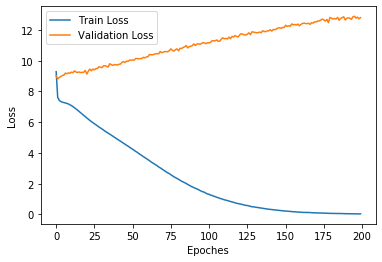

In [23]:
plt.plot(train_loss, label="Train Loss")
plt.plot(dev_loss, label="Validation Loss")
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

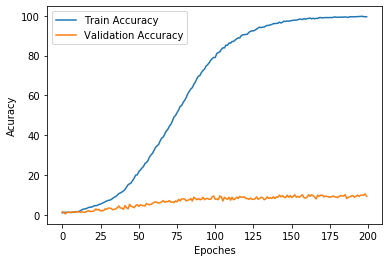

In [24]:
plt.plot(train_acc, label="Train Accuracy")
plt.plot(dev_acc, label="Validation Accuracy")
plt.xlabel('Epoches')
plt.ylabel('Acuracy')
plt.legend()
plt.show()

In [25]:
print('The best training accuracy is %.2f%%, at epoch %i' % (max(train_acc),np.argmax(train_acc)))
print('The best validation accuracy is %.2f%%, at epoch %i' % (max(dev_acc),np.argmax(dev_acc)))

The best training accuracy is 99.79%, at epoch 196
The best validation accuracy is 10.48%, at epoch 198


In [10]:
dev_dict = build_dict(dev_d + dev_q + y_dev,max_words=35000)

#Words: 7841 -> 7841
('the', 3031)
('of', 1726)
('a', 1090)
('is', 1007)
('and', 985)
...
('confluence', 1)
('mosquito', 1)
('map', 1)
('pulley', 1)
('deciduous', 1)


In [13]:
# How many word in dev not in dict
n_word = 0
for i in dev_d+dev_q+y_dev:
    for w in i:
        if w not in word_dict:
            n_word += 1     

In [14]:
percent = n_word*100./len(dev_dict)
print('There is %.2f%% word in validation not in training dictionary' % percent)

There is 22.94% word in validation not in training dictionary
